# modifications:
1) weight initialization with RandomNormal: you can see it in the beginning of the definition of the functions "define_discriminator" and "define_generator" and within the generation of each layer: "kernel_initializer=init" instead of kernel_initializer="orthogonal".

2) add dropout after each layer.

3) add noise to labels. to do.

4) study best metrics for labels. to do.

5) reduce the number of needed attributes by doing operations on the latent space as described in the chapter 9 of the book.

6) look here: https://github.com/guyez/Conditional-Generation-of-Faces/blob/master/VAC%2BGAN.ipynb  they use this parameters:
    - discriminator_optimizer = Adam(lr=0.0002, beta_1=0)
    - classifier_optimizer = Adam(lr=0.0002, beta_1=0)
    - generator_optimizer = Adam(lr=0.00005, beta_1=0)
7) it's not ok to create labels with random values because there are attributes which can't be true together (for instance blond_hair and brown_hair).

# Note:
- this aux_gan has been obtained modifying the code of the cond_GAn given by Petru

- dropout(0.4) for the discriminator hidden layers gives error, use dropout(0.5).


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

In [11]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
import os
import cv2
import pandas as pd
import gzip
from tensorflow.keras import backend as K
import tensorflow as tf 
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.initializers import RandomNormal
import random 
from tensorflow.keras.layers import Conv2D, Input, Dense, Activation, Reshape, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, Dropout, BatchNormalization
######################################## RANDOM SEED:
#random.seed(13)

#epsilon set according to BIGGAN https://arxiv.org/pdf/1809.11096.pdf

def _l2normalizer(v, epsilon=1e-4):
    return v / (K.sum(v**2)**0.5 + epsilon)


def power_iteration(W, u, rounds=1):
    '''
    Accroding the paper, we only need to do power iteration one time.
    '''
    _u = u

    for i in range(rounds):
        _v = _l2normalizer(K.dot(_u, W))
        _u = _l2normalizer(K.dot(_v, K.transpose(W)))

    W_sn = K.sum(K.dot(_u, W) * _v)
    return W_sn, _u, _v

"""
Convolution 2D with spectral normalization
"""
class SNConv2D(Conv2D):
    def __init__(self, filters, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2D, self).__init__(filters, **kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.

        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2D, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-1], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):

        outputs = K.conv2d(inputs,
                           self.compute_spectral_normal(training=training),
                           strides=self.strides, padding=self.padding,
                           data_format=self.data_format,
                           dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2D, self).compute_output_shape(input_shape)

"""
Transposed Convolution 2D with spectral normalization
"""
class SNConv2DTranspose(Conv2DTranspose):
    def __init__(self, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2DTranspose, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2DTranspose, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-2], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        out_pad_h = out_pad_w = None

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_output_length(
            height, kernel_h, self.padding, stride=stride_h)
        out_width = conv_utils.deconv_output_length(
            width, kernel_w, self.padding, stride=stride_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        outputs = K.conv2d_transpose(
            inputs,
            self.compute_spectral_normal(training=training),
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format
        )

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2DTranspose, self).compute_output_shape(input_shape)

    



In [18]:
def get_attributes(filename, how_many, attributes_ind, dict_attributes, RandomListOfIntegers):
    # extract attribute names given the attribute indexes:
    list_attributes = []
    for attr in attributes_ind:
        list_attributes.append(dict_attributes[attr])
    # import the attributes you want:
    attributes = pd.read_csv(filename)[list_attributes]
    # convert to array
    attributes = np.array(attributes)
    # extract the attributes only of the number of images you want:
    attributes =  attributes[RandomListOfIntegers]
    
    return attributes

def load_images(dataset, images_directory, img_shape):
    X = []
    for i, myid in enumerate(dataset):
        image = load_img(images_directory + "/" + myid, target_size=img_shape[:2])
        image = (img_to_array(image) - 127.5) / 127.5 # from [0, 255] to [-1, 1]
        image = image[25:153, 45:173]
        image = cv2.resize(src=image, dsize=(64, 64))
        X.append(image)
    X = np.array(X)
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    #print('X.shape: ', X.shape, 'labels.shape: ', labels.shape, 'y.shape: ', y.shape)
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_attr, n_classes=2): # two calsses: 0 and 1
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim) # (64, 100)
    # generate labels
    labels = np.random.randint(n_classes, size=(n_samples, n_attr)) # HERE (n_samples, 40)
    return [z_input, labels]



# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples, n_attr, n_classes=2)
    #print('z_input: ', z_input.shape, 'labels_input: ', labels_input.shape)
    # predict outputs
    concat = np.hstack((z_input, labels_input))
    images = generator.predict(concat)
    # create class labels
    y = np.zeros((n_samples, 1))
    #print('images: ', images.shape, 'labels_input: ', labels_input.shape, 'y: ', y.shape)
    return [images, labels_input], y


######### LOAD DATASET:
def load_dataset(how_many, ind_attributes, dict_attributes, images_directory = 'img_align_celeba_nozip', attr_file = 'list_attr_celeba.csv', img_shape = (178, 218, 3)):  
    RandomListOfIntegers = [random.randint(0,180000) for iter in range(how_many)] # 180000 is the training set size
    celeba_img = np.sort(os.listdir(images_directory))
    images_id = celeba_img[RandomListOfIntegers]
    images = load_images(images_id, images_directory, img_shape)
    attributes = get_attributes(attr_file, how_many, ind_attributes, dict_attributes, RandomListOfIntegers)
    attributes[attributes<=0] = 0
    dataset = [images, attributes]
    return dataset

######### LOAD FID DATASET:
def load_fid_dataset(how_many, ind_attributes, dict_attributes, images_directory = 'img_align_celeba_nozip', attr_file = 'list_attr_celeba.csv', img_shape = (178, 218, 3)):  
    # from 20k images I select "howmany" images for the fid. Note that "howmany" must be 10k
    RandomListOfIntegers = [random.randint(180000, 200000) for iter in range(how_many)]
    celeba_img = np.sort(os.listdir(images_directory))
    images_id = celeba_img[RandomListOfIntegers]
    images = load_images(images_id, images_directory, img_shape)
    attributes = get_attributes(attr_file, how_many, ind_attributes, dict_attributes, RandomListOfIntegers)
    attributes[attributes<=0] = 0
    fid_dataset = [images, attributes]
    return fid_dataset

######### LOAD GROUN TRUTH LABELS FOR FID:
def load_groundtruth_labels(how_many, ind_attributes, dict_attributes, attr_file = 'list_attr_celeba.csv'):  
    # the 200000 could also be the exact number of images of celeba
    RandomListOfIntegers = [random.randint(0, 200000) for iter in range(how_many)]
    attributes = get_attributes(attr_file, how_many, ind_attributes, dict_attributes, RandomListOfIntegers)
    attributes[attributes<=0] = 0
    return attributes

# plot of generated images
def plot_images(examples, n_test_images):
    # plot images
    for i in range(n_test_images):
        # define subplot
        plt.subplot(n_test_images/4, 4, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

In [13]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy", "binary_crossentropy"], optimizer=opt) ##
    return model

In [14]:
def define_discriminator(n_attr, filters = 64, kernel_size = 3, in_shape=(64,64,3)): # HERE
    
    # kernel initializer:
    init = RandomNormal(stddev=0.02)
    
    # input layer:
    in_image = Input(shape=in_shape)

   # 64 x 64 x FILTERS
    fe = SNConv2D(filters=filters, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(in_image) ##in_image
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 32 x 32 x FILTERS
    fe = SNConv2D(filters=filters * 2, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 16 x 16 x FILTERS
    fe = SNConv2D(filters=filters * 4, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 8 x 8 x FILTERS
    fe = SNConv2D(filters=filters * 8, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    
    # Current size: 4 x 4 x FILTERS 
    fe = GlobalAveragePooling2D()(fe)
    
    # output about fake/real image:
    out1 = Dense(1, activation='sigmoid')(fe)
    # output about attributes:
    out2 = Dense(n_attr, activation='sigmoid')(fe) ##
    
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy", "binary_crossentropy"], optimizer=opt, metrics=['accuracy'])
    return model



# define the standalone generator model
def define_generator(latent_dim, n_attr, filters=64, kernel_size=4):

    noise_plus_label = Input(shape=(latent_dim + n_attr,))
    
    n_nodes = 4 * 4 * filters * 8
    gen = Dense(n_nodes)(noise_plus_label)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, filters * 8))(gen)
    gen = BatchNormalization()(gen)
    
    # 4x4 -> 8x8
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters*4, kernel_size=4, strides=(1,1), padding='same', spectral_normalization=True)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 8x8 -> 16x16
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters*2, kernel_size=4, strides=(1,1), padding='same', spectral_normalization=True)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 16x16 -> 32x32
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters, kernel_size=4, strides=(1,1), padding='same', spectral_normalization=True)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 32x32 -> 64x64
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters // 2, kernel_size=4, strides=(1,1), padding='same', spectral_normalization=True)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # output
    out_layer = SNConv2D(filters=3, kernel_size=4, activation='tanh', padding='same', spectral_normalization=True)(gen)
    # define model
    model = Model(noise_plus_label, out_layer)
    return model



# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    img = g_model.output
    d_model.trainable = False
    valid, target_label = d_model(img)
    
    noise_plus_label = g_model.input
    model = Model(noise_plus_label, [valid, target_label])

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy", "binary_crossentropy"], optimizer=opt)
    return model

In [5]:
#TODO: half a batch and full batch?
#TODO: try to train to times the discriminator

def train(generator, discriminator, combined, dataset, latent_dim, epochs, batch_size, n_test_images):

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        [imgs , img_labels], _ = generate_real_samples(dataset, batch_size)
            
        [noise, sampled_labels] = generate_latent_points(latent_dim, batch_size, n_attr, n_classes=2)
        
        #print('noise: ', noise.shape, 'sampled_labels: ', sampled_labels.shape)
        # Generate a half batch of new images
        concat = np.hstack((noise, sampled_labels))
        gen_imgs = generator.predict(concat)


        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, [valid, img_labels])
        d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, sampled_labels])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator
        g_loss = combined.train_on_batch(concat, [valid, sampled_labels])

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
        
        if epoch % 1000 == 0:
            # save the generator model
            generator.save('cgan2/cgan_generator' +str(epoch)+'.h5')
            model = load_model('cgan2/cgan_generator' +str(epoch)+'.h5',
                               custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D})

            z_input, labels = generate_latent_points(latent_dim, n_test_images, n_attr, n_classes=2 )
            # create laels with random values:
            labels = np.zeros((n_test_images, n_attr)) # HERE (100, 40)
            concat = np.hstack((z_input, labels))
            # generate images
            X = model.predict(concat)
            print(X.shape)
            # scale from [-1,1] to [0,1]
            X = (X + 1) / 2.0
            plot_images(X, n_test_images)

In [24]:

# train the generator and discriminator
def train2(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size, n_test_images):
    bat_per_epo = int(dataset[0].shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected ✬real✬ samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            #print('X_real: ',X_real.shape,'labels_real: ' ,labels_real.shape, 'y_real: ',y_real.shape)
            # update discriminator model weights
            d_metrics1 = d_model.train_on_batch(X_real, [y_real, labels_real])##
            #d_loss1, _ = d_model.train_on_batch([X_real,labels_real], y_real)##
            # use this command: d_model.metrics_names to see what returns "d_model.train_on_batch"
            d_loss1 = d_metrics1[0]
            # generate ✬fake✬ examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_metrics2 = d_model.train_on_batch(X_fake, [y_fake, labels])
            d_loss2 = d_metrics2[0]
            # prepare points in latent space as input for the generator
            [z_input, z_labels] = generate_latent_points(latent_dim, batch_size, n_attr, n_classes=2)
            # create inverted labels for the fake samples
            y_gan = np.ones((batch_size, 1))
            # update the generator via the discriminator✬s error
            #_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
            concat = np.hstack((z_input, z_labels))
            g_metrics = gan_model.train_on_batch(concat, [y_gan, z_labels])
            g_loss = g_metrics[0]
            
        # summarize loss on this batch
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # save the generator model
        g_model.save('cgan/cgan_generator' +str(i+j)+'.h5')
        model = load_model('cgan/cgan_generator' +str(i+j)+'.h5',
                           custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D})
        
        z_input, labels = generate_latent_points(latent_dim, n_test_images, n_attr, n_classes=2 )
        # create laels with random values:
        labels = np.zeros((n_test_images, n_attr)) # HERE (100, 40)
        concat = np.hstack((z_input, labels))
        # generate images
        X = g_model.predict(concat)
        # scale from [-1,1] to [0,1]
        X = (X + 1) / 2.0
        plot_images(X, n_test_images)

In [16]:
######### ATTRIBUTE SELECTION:

# list the indexes of the attributes to be used to condition the generator:
dict_attributes = {1: '5_o_Clock_Shadow', 2: 'Arched_Eyebrows', 3: 'Attractive', 4: 'Bags_Under_Eyes', 
                   5: 'Bald', 6: 'Bangs', 7: 'Big_Lips', 8: 'Big_Nose', 9: 'Black_Hair', 10: 'Blond_Hair', 
                   11: 'Blurry', 12: 'Brown_Hair', 13: 'Bushy_Eyebrows', 14: 'Chubby', 15: 'Double_Chin', 
                   16: 'Eyeglasses', 17: 'Goatee', 18: 'Gray_Hair', 19: 'Heavy_Makeup', 20: 'High_Cheekbones', 
                   21: 'Male', 22: 'Mouth_Slightly_Open', 23: 'Mustache', 24: 'Narrow_Eyes', 25: 'No_Beard', 
                   26: 'Oval_Face', 27: 'Pale_Skin', 28: 'Pointy_Nose', 29: 'Receding_Hairline', 30: 'Rosy_Cheeks', 
                   31: 'Sideburns', 32: 'Smiling', 33: 'Straight_Hair', 34: 'Wavy_Hair', 35: 'Wearing_Earrings', 
                   36: 'Wearing_Hat', 37: 'Wearing_Lipstick', 38: 'Wearing_Necklace', 39: 'Wearing_Necktie', 40: 'Young'}

#ind_attributes = [9, 10, 32] # Black_Hair, Blond_Hair, Smiling

ind_attributes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                 31, 32, 33, 34, 35, 36, 37, 38, 39, 40 ]
# use booleans to indicate respectively wrt the "ind_attributes" which attributes must be used to test the conditioning:
#ind_test_attributes = np.array([1, 1, 1])
ind_test_attributes = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1 , 1,
                               1, 1, 1, 1, 1, 1, 1, 1, 1 ,1,
                               1, 1, 1, 1, 1, 1, 1, 1, 1 ,1,
                               1, 1, 1, 1, 1, 1, 1, 1, 1 ,1])

In [7]:
############### PARAMETERS:

how_many = 150000 ############################ number of images to use for training

# size of the latent space
latent_dim = 100


# divide dataset into this number of batches:
batch_size = 32 # number of images per batch

n_epochs = 100000

n_test_images = 8 # number of images to save per each epoch, USE MULTIPLE OF 4


###########à FIXED PARAM: DON'T TOUCH THEM
# number of attributes per image:
n_attr = len(ind_attributes) 
n_classes=2 # just 2 possible value for each attribute

################# MODELS:
# create the discriminator
d_model = define_discriminator(n_attr)
#d_model.summary()

# create the generator
g_model = define_generator(latent_dim, n_attr)
#g_model.summary()

# create the gan
gan_model = define_gan(g_model, d_model)

dataset = load_dataset(how_many, ind_attributes, dict_attributes)

In [22]:
n_epochs = 25

>1, 4687/4687, d1=0.852, d2=0.808 g=1.297


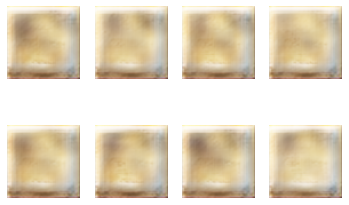

>2, 4687/4687, d1=0.486, d2=0.761 g=3.421


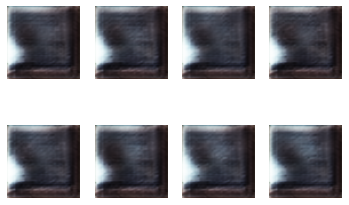

>3, 4687/4687, d1=1.278, d2=1.133 g=1.901


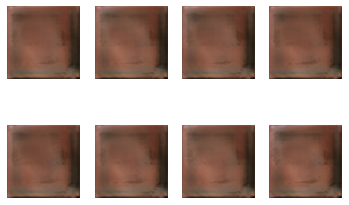

In [ ]:
train2(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size, n_test_images);

0 [D loss: 1.416722, acc.: 4.69%, op_acc: 50.55%] [G loss: 1.216109]
(8, 64, 64, 3)


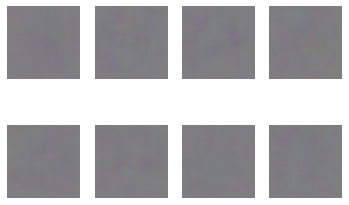

1 [D loss: 1.315968, acc.: 50.00%, op_acc: 52.54%] [G loss: 1.102680]
2 [D loss: 1.276040, acc.: 50.00%, op_acc: 50.78%] [G loss: 0.965762]
3 [D loss: 1.227379, acc.: 50.00%, op_acc: 52.85%] [G loss: 0.839499]
4 [D loss: 1.175793, acc.: 50.00%, op_acc: 54.84%] [G loss: 0.762854]
5 [D loss: 1.131904, acc.: 50.00%, op_acc: 58.16%] [G loss: 0.731744]
6 [D loss: 1.099228, acc.: 50.00%, op_acc: 59.53%] [G loss: 0.738997]
7 [D loss: 1.082780, acc.: 50.00%, op_acc: 62.23%] [G loss: 0.744336]
8 [D loss: 1.060928, acc.: 50.00%, op_acc: 63.32%] [G loss: 0.766090]
9 [D loss: 1.058579, acc.: 50.00%, op_acc: 65.90%] [G loss: 0.756440]
10 [D loss: 1.037403, acc.: 50.00%, op_acc: 65.59%] [G loss: 0.760999]
11 [D loss: 1.039770, acc.: 50.00%, op_acc: 62.54%] [G loss: 0.807030]
12 [D loss: 1.026046, acc.: 50.00%, op_acc: 64.06%] [G loss: 0.830266]
13 [D loss: 1.013719, acc.: 50.00%, op_acc: 64.77%] [G loss: 0.806478]
14 [D loss: 1.009086, acc.: 50.00%, op_acc: 64.57%] [G loss: 0.835935]
15 [D loss: 0.9

117 [D loss: 0.905835, acc.: 93.75%, op_acc: 64.26%] [G loss: 0.851193]
118 [D loss: 0.864920, acc.: 93.75%, op_acc: 64.30%] [G loss: 0.880426]
119 [D loss: 0.902552, acc.: 90.62%, op_acc: 64.57%] [G loss: 0.872281]
120 [D loss: 0.842320, acc.: 93.75%, op_acc: 65.66%] [G loss: 0.875719]
121 [D loss: 0.787712, acc.: 93.75%, op_acc: 65.82%] [G loss: 0.843174]
122 [D loss: 0.909091, acc.: 92.19%, op_acc: 64.34%] [G loss: 0.891716]
123 [D loss: 0.874123, acc.: 92.19%, op_acc: 65.16%] [G loss: 0.888258]
124 [D loss: 0.793540, acc.: 95.31%, op_acc: 64.57%] [G loss: 0.890367]
125 [D loss: 0.787793, acc.: 93.75%, op_acc: 65.00%] [G loss: 0.898306]
126 [D loss: 0.836985, acc.: 92.19%, op_acc: 64.41%] [G loss: 0.920396]
127 [D loss: 0.791380, acc.: 93.75%, op_acc: 65.86%] [G loss: 0.886416]
128 [D loss: 0.800389, acc.: 93.75%, op_acc: 65.23%] [G loss: 0.895456]
129 [D loss: 0.796285, acc.: 95.31%, op_acc: 63.44%] [G loss: 0.932887]
130 [D loss: 0.698430, acc.: 96.88%, op_acc: 65.43%] [G loss: 0.

231 [D loss: 0.592035, acc.: 100.00%, op_acc: 65.66%] [G loss: 0.857211]
232 [D loss: 0.597380, acc.: 100.00%, op_acc: 66.05%] [G loss: 0.840032]
233 [D loss: 0.617137, acc.: 96.88%, op_acc: 68.09%] [G loss: 0.838294]
234 [D loss: 0.588781, acc.: 100.00%, op_acc: 66.41%] [G loss: 0.848055]
235 [D loss: 0.578933, acc.: 98.44%, op_acc: 68.48%] [G loss: 0.853881]
236 [D loss: 0.586029, acc.: 100.00%, op_acc: 64.96%] [G loss: 0.850419]
237 [D loss: 0.640500, acc.: 96.88%, op_acc: 66.87%] [G loss: 0.850905]
238 [D loss: 0.563256, acc.: 100.00%, op_acc: 66.52%] [G loss: 0.843634]
239 [D loss: 0.580721, acc.: 100.00%, op_acc: 66.60%] [G loss: 0.839264]
240 [D loss: 0.574971, acc.: 100.00%, op_acc: 66.17%] [G loss: 0.839704]
241 [D loss: 0.671752, acc.: 96.88%, op_acc: 65.39%] [G loss: 0.830970]
242 [D loss: 0.573183, acc.: 100.00%, op_acc: 66.17%] [G loss: 0.840678]
243 [D loss: 0.576671, acc.: 100.00%, op_acc: 67.11%] [G loss: 0.828541]
244 [D loss: 0.603810, acc.: 100.00%, op_acc: 65.43%] [

345 [D loss: 0.580016, acc.: 100.00%, op_acc: 67.34%] [G loss: 0.782322]
346 [D loss: 0.590727, acc.: 100.00%, op_acc: 66.21%] [G loss: 0.764292]
347 [D loss: 0.559963, acc.: 100.00%, op_acc: 66.52%] [G loss: 0.781941]
348 [D loss: 0.605278, acc.: 98.44%, op_acc: 67.07%] [G loss: 0.767730]
349 [D loss: 0.574893, acc.: 100.00%, op_acc: 66.72%] [G loss: 0.777274]
350 [D loss: 0.567281, acc.: 100.00%, op_acc: 67.07%] [G loss: 0.786554]
351 [D loss: 0.608995, acc.: 98.44%, op_acc: 66.41%] [G loss: 0.789285]
352 [D loss: 0.617790, acc.: 98.44%, op_acc: 66.41%] [G loss: 0.813673]
353 [D loss: 0.612624, acc.: 96.88%, op_acc: 65.78%] [G loss: 0.835130]
354 [D loss: 0.566459, acc.: 100.00%, op_acc: 65.90%] [G loss: 0.998770]
355 [D loss: 1.040315, acc.: 81.25%, op_acc: 65.82%] [G loss: 9.089781]
356 [D loss: 6.101125, acc.: 50.00%, op_acc: 44.49%] [G loss: 1.311685]
357 [D loss: 1.551881, acc.: 26.56%, op_acc: 66.64%] [G loss: 1.057939]
358 [D loss: 1.360895, acc.: 39.06%, op_acc: 63.91%] [G lo

459 [D loss: 0.991194, acc.: 93.75%, op_acc: 64.57%] [G loss: 1.018021]
460 [D loss: 1.018581, acc.: 85.94%, op_acc: 65.31%] [G loss: 1.010308]
461 [D loss: 0.925311, acc.: 93.75%, op_acc: 65.98%] [G loss: 0.988894]
462 [D loss: 0.835478, acc.: 96.88%, op_acc: 66.17%] [G loss: 1.008593]
463 [D loss: 0.896881, acc.: 92.19%, op_acc: 65.59%] [G loss: 0.999983]
464 [D loss: 0.844186, acc.: 90.62%, op_acc: 66.09%] [G loss: 0.995057]
465 [D loss: 0.810357, acc.: 96.88%, op_acc: 65.74%] [G loss: 0.988541]
466 [D loss: 0.816767, acc.: 95.31%, op_acc: 63.95%] [G loss: 1.033103]
467 [D loss: 0.791856, acc.: 98.44%, op_acc: 65.35%] [G loss: 1.062997]
468 [D loss: 0.830779, acc.: 98.44%, op_acc: 65.51%] [G loss: 1.100862]
469 [D loss: 0.744976, acc.: 95.31%, op_acc: 64.92%] [G loss: 1.193156]
470 [D loss: 1.155347, acc.: 54.69%, op_acc: 65.31%] [G loss: 1.058227]
471 [D loss: 1.047708, acc.: 89.06%, op_acc: 66.52%] [G loss: 1.310025]
472 [D loss: 1.124675, acc.: 81.25%, op_acc: 65.78%] [G loss: 1.

573 [D loss: 1.313218, acc.: 73.44%, op_acc: 64.77%] [G loss: 1.265271]
574 [D loss: 1.322614, acc.: 59.38%, op_acc: 64.92%] [G loss: 1.235948]
575 [D loss: 1.320682, acc.: 57.81%, op_acc: 66.09%] [G loss: 1.240202]
576 [D loss: 1.290044, acc.: 70.31%, op_acc: 64.61%] [G loss: 1.257812]
577 [D loss: 1.326571, acc.: 54.69%, op_acc: 66.68%] [G loss: 1.223658]
578 [D loss: 1.374471, acc.: 53.12%, op_acc: 65.35%] [G loss: 1.240847]
579 [D loss: 1.326124, acc.: 57.81%, op_acc: 64.96%] [G loss: 1.237584]
580 [D loss: 1.359283, acc.: 51.56%, op_acc: 65.23%] [G loss: 1.271207]
581 [D loss: 1.348528, acc.: 50.00%, op_acc: 66.95%] [G loss: 1.258042]
582 [D loss: 1.327106, acc.: 59.38%, op_acc: 64.61%] [G loss: 1.292336]
583 [D loss: 1.362703, acc.: 59.38%, op_acc: 64.73%] [G loss: 1.312723]
584 [D loss: 1.331735, acc.: 62.50%, op_acc: 65.27%] [G loss: 1.322814]
585 [D loss: 1.327361, acc.: 54.69%, op_acc: 67.23%] [G loss: 1.273685]
586 [D loss: 1.343784, acc.: 51.56%, op_acc: 66.80%] [G loss: 1.

687 [D loss: 1.296642, acc.: 59.38%, op_acc: 63.75%] [G loss: 1.319831]
688 [D loss: 1.287467, acc.: 57.81%, op_acc: 64.34%] [G loss: 1.287616]
689 [D loss: 1.285678, acc.: 56.25%, op_acc: 65.08%] [G loss: 1.279128]
690 [D loss: 1.269129, acc.: 56.25%, op_acc: 67.03%] [G loss: 1.271258]
691 [D loss: 1.303925, acc.: 45.31%, op_acc: 65.35%] [G loss: 1.267032]
692 [D loss: 1.268790, acc.: 56.25%, op_acc: 65.47%] [G loss: 1.260323]
693 [D loss: 1.257415, acc.: 70.31%, op_acc: 65.20%] [G loss: 1.295714]
694 [D loss: 1.255465, acc.: 67.19%, op_acc: 65.08%] [G loss: 1.259329]
695 [D loss: 1.240561, acc.: 54.69%, op_acc: 67.19%] [G loss: 1.248827]
696 [D loss: 1.246536, acc.: 59.38%, op_acc: 65.08%] [G loss: 1.241235]
697 [D loss: 1.283445, acc.: 45.31%, op_acc: 64.96%] [G loss: 1.220931]
698 [D loss: 1.291767, acc.: 39.06%, op_acc: 65.16%] [G loss: 1.282746]
699 [D loss: 1.304035, acc.: 43.75%, op_acc: 63.55%] [G loss: 1.287793]
700 [D loss: 1.301246, acc.: 42.19%, op_acc: 65.08%] [G loss: 1.

801 [D loss: 1.326218, acc.: 53.12%, op_acc: 65.08%] [G loss: 1.407111]
802 [D loss: 1.323770, acc.: 57.81%, op_acc: 65.94%] [G loss: 1.415459]
803 [D loss: 1.326134, acc.: 51.56%, op_acc: 63.98%] [G loss: 1.391138]
804 [D loss: 1.332395, acc.: 48.44%, op_acc: 65.74%] [G loss: 1.383113]
805 [D loss: 1.320809, acc.: 53.12%, op_acc: 65.90%] [G loss: 1.385418]
806 [D loss: 1.323874, acc.: 48.44%, op_acc: 65.82%] [G loss: 1.406713]
807 [D loss: 1.337185, acc.: 53.12%, op_acc: 64.14%] [G loss: 1.418331]
808 [D loss: 1.317191, acc.: 57.81%, op_acc: 66.52%] [G loss: 1.380461]
809 [D loss: 1.322447, acc.: 57.81%, op_acc: 65.08%] [G loss: 1.416564]
810 [D loss: 1.326801, acc.: 59.38%, op_acc: 63.87%] [G loss: 1.420967]
811 [D loss: 1.319921, acc.: 53.12%, op_acc: 65.55%] [G loss: 1.383484]
812 [D loss: 1.318940, acc.: 67.19%, op_acc: 65.16%] [G loss: 1.391180]
813 [D loss: 1.308317, acc.: 67.19%, op_acc: 65.74%] [G loss: 1.389327]
814 [D loss: 1.317485, acc.: 64.06%, op_acc: 64.80%] [G loss: 1.

916 [D loss: 1.336106, acc.: 51.56%, op_acc: 64.77%] [G loss: 1.455153]
917 [D loss: 1.337716, acc.: 50.00%, op_acc: 65.12%] [G loss: 1.452397]
918 [D loss: 1.345193, acc.: 54.69%, op_acc: 63.01%] [G loss: 1.484780]
919 [D loss: 1.329033, acc.: 42.19%, op_acc: 65.62%] [G loss: 1.444998]
920 [D loss: 1.333135, acc.: 45.31%, op_acc: 65.51%] [G loss: 1.450206]
921 [D loss: 1.337355, acc.: 45.31%, op_acc: 64.06%] [G loss: 1.448395]
922 [D loss: 1.337929, acc.: 50.00%, op_acc: 63.52%] [G loss: 1.460459]
923 [D loss: 1.336572, acc.: 46.88%, op_acc: 65.39%] [G loss: 1.437363]
924 [D loss: 1.345147, acc.: 42.19%, op_acc: 64.61%] [G loss: 1.432276]
925 [D loss: 1.341424, acc.: 34.38%, op_acc: 65.94%] [G loss: 1.433956]
926 [D loss: 1.345796, acc.: 43.75%, op_acc: 64.26%] [G loss: 1.452954]
927 [D loss: 1.340819, acc.: 37.50%, op_acc: 64.34%] [G loss: 1.447101]
928 [D loss: 1.337477, acc.: 40.62%, op_acc: 65.66%] [G loss: 1.448489]
929 [D loss: 1.343051, acc.: 32.81%, op_acc: 65.86%] [G loss: 1.

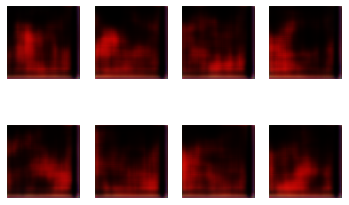

1001 [D loss: 1.320253, acc.: 48.44%, op_acc: 64.96%] [G loss: 1.380787]
1002 [D loss: 1.322411, acc.: 48.44%, op_acc: 66.60%] [G loss: 1.358023]
1003 [D loss: 1.330540, acc.: 42.19%, op_acc: 67.11%] [G loss: 1.370868]
1004 [D loss: 1.330436, acc.: 48.44%, op_acc: 64.30%] [G loss: 1.400378]
1005 [D loss: 1.322174, acc.: 45.31%, op_acc: 65.00%] [G loss: 1.392094]
1006 [D loss: 1.320538, acc.: 46.88%, op_acc: 65.74%] [G loss: 1.383527]
1007 [D loss: 1.313471, acc.: 46.88%, op_acc: 64.65%] [G loss: 1.398426]
1008 [D loss: 1.310677, acc.: 48.44%, op_acc: 65.94%] [G loss: 1.385554]
1009 [D loss: 1.327816, acc.: 42.19%, op_acc: 64.65%] [G loss: 1.399782]
1010 [D loss: 1.322367, acc.: 42.19%, op_acc: 66.25%] [G loss: 1.373914]
1011 [D loss: 1.317571, acc.: 48.44%, op_acc: 64.45%] [G loss: 1.397503]
1012 [D loss: 1.300572, acc.: 46.88%, op_acc: 64.53%] [G loss: 1.400203]
1013 [D loss: 1.302270, acc.: 45.31%, op_acc: 66.68%] [G loss: 1.390136]
1014 [D loss: 1.317644, acc.: 46.88%, op_acc: 65.27

1115 [D loss: 1.332640, acc.: 46.88%, op_acc: 66.45%] [G loss: 1.427688]
1116 [D loss: 1.340467, acc.: 53.12%, op_acc: 64.96%] [G loss: 1.425475]
1117 [D loss: 1.310573, acc.: 54.69%, op_acc: 65.51%] [G loss: 1.429844]
1118 [D loss: 1.322343, acc.: 51.56%, op_acc: 66.33%] [G loss: 1.438358]
1119 [D loss: 1.320183, acc.: 56.25%, op_acc: 66.02%] [G loss: 1.418152]
1120 [D loss: 1.336495, acc.: 43.75%, op_acc: 66.48%] [G loss: 1.424811]
1121 [D loss: 1.326410, acc.: 53.12%, op_acc: 65.20%] [G loss: 1.448592]
1122 [D loss: 1.323268, acc.: 48.44%, op_acc: 66.52%] [G loss: 1.421896]
1123 [D loss: 1.308480, acc.: 62.50%, op_acc: 66.37%] [G loss: 1.442191]
1124 [D loss: 1.297229, acc.: 65.62%, op_acc: 65.90%] [G loss: 1.461155]
1125 [D loss: 1.323881, acc.: 45.31%, op_acc: 65.16%] [G loss: 1.434174]
1126 [D loss: 1.324229, acc.: 54.69%, op_acc: 65.62%] [G loss: 1.429375]
1127 [D loss: 1.321993, acc.: 60.94%, op_acc: 64.69%] [G loss: 1.435189]
1128 [D loss: 1.315294, acc.: 60.94%, op_acc: 64.14

1229 [D loss: 1.300696, acc.: 65.62%, op_acc: 65.20%] [G loss: 1.440425]
1230 [D loss: 1.309308, acc.: 62.50%, op_acc: 64.22%] [G loss: 1.426752]
1231 [D loss: 1.313602, acc.: 51.56%, op_acc: 66.02%] [G loss: 1.428913]
1232 [D loss: 1.306528, acc.: 60.94%, op_acc: 66.05%] [G loss: 1.434780]
1233 [D loss: 1.315836, acc.: 60.94%, op_acc: 65.08%] [G loss: 1.427600]
1234 [D loss: 1.326656, acc.: 46.88%, op_acc: 65.55%] [G loss: 1.422404]
1235 [D loss: 1.310934, acc.: 57.81%, op_acc: 63.52%] [G loss: 1.447351]
1236 [D loss: 1.319962, acc.: 56.25%, op_acc: 64.53%] [G loss: 1.430390]
1237 [D loss: 1.334448, acc.: 50.00%, op_acc: 65.12%] [G loss: 1.411353]
1238 [D loss: 1.325297, acc.: 56.25%, op_acc: 66.48%] [G loss: 1.403241]
1239 [D loss: 1.329535, acc.: 53.12%, op_acc: 66.29%] [G loss: 1.405565]
1240 [D loss: 1.335455, acc.: 46.88%, op_acc: 66.68%] [G loss: 1.412754]
1241 [D loss: 1.319090, acc.: 62.50%, op_acc: 65.00%] [G loss: 1.440022]
1242 [D loss: 1.326040, acc.: 57.81%, op_acc: 64.14

1343 [D loss: 1.322100, acc.: 48.44%, op_acc: 67.58%] [G loss: 1.380965]
1344 [D loss: 1.313292, acc.: 54.69%, op_acc: 65.51%] [G loss: 1.426885]
1345 [D loss: 1.319467, acc.: 51.56%, op_acc: 66.48%] [G loss: 1.424033]
1346 [D loss: 1.313782, acc.: 59.38%, op_acc: 64.34%] [G loss: 1.437120]
1347 [D loss: 1.316478, acc.: 59.38%, op_acc: 66.33%] [G loss: 1.402915]
1348 [D loss: 1.308701, acc.: 54.69%, op_acc: 65.43%] [G loss: 1.432528]
1349 [D loss: 1.323148, acc.: 56.25%, op_acc: 65.82%] [G loss: 1.414347]
1350 [D loss: 1.303338, acc.: 54.69%, op_acc: 66.09%] [G loss: 1.414487]
1351 [D loss: 1.301547, acc.: 62.50%, op_acc: 64.73%] [G loss: 1.428226]
1352 [D loss: 1.319517, acc.: 60.94%, op_acc: 65.62%] [G loss: 1.407654]
1353 [D loss: 1.311673, acc.: 59.38%, op_acc: 65.62%] [G loss: 1.419688]
1354 [D loss: 1.310370, acc.: 59.38%, op_acc: 67.07%] [G loss: 1.410562]
1355 [D loss: 1.313919, acc.: 54.69%, op_acc: 66.17%] [G loss: 1.419418]
1356 [D loss: 1.304950, acc.: 59.38%, op_acc: 67.30

1457 [D loss: 1.304428, acc.: 56.25%, op_acc: 64.80%] [G loss: 1.427786]
1458 [D loss: 1.324088, acc.: 53.12%, op_acc: 66.17%] [G loss: 1.404906]
1459 [D loss: 1.302152, acc.: 62.50%, op_acc: 64.53%] [G loss: 1.417492]
1460 [D loss: 1.305169, acc.: 68.75%, op_acc: 63.79%] [G loss: 1.422745]
1461 [D loss: 1.332184, acc.: 45.31%, op_acc: 66.02%] [G loss: 1.401533]
1462 [D loss: 1.350353, acc.: 48.44%, op_acc: 66.68%] [G loss: 1.380117]
1463 [D loss: 1.353495, acc.: 39.06%, op_acc: 66.05%] [G loss: 1.401264]
1464 [D loss: 1.342338, acc.: 45.31%, op_acc: 64.45%] [G loss: 1.415303]
1465 [D loss: 1.346961, acc.: 53.12%, op_acc: 65.31%] [G loss: 1.394101]
1466 [D loss: 1.331388, acc.: 57.81%, op_acc: 63.91%] [G loss: 1.433521]
1467 [D loss: 1.341759, acc.: 46.88%, op_acc: 64.65%] [G loss: 1.437200]
1468 [D loss: 1.341900, acc.: 42.19%, op_acc: 65.08%] [G loss: 1.422901]
1469 [D loss: 1.343427, acc.: 46.88%, op_acc: 63.79%] [G loss: 1.442241]
1470 [D loss: 1.323147, acc.: 51.56%, op_acc: 65.90

1571 [D loss: 1.328018, acc.: 45.31%, op_acc: 66.25%] [G loss: 1.407634]
1572 [D loss: 1.301506, acc.: 54.69%, op_acc: 66.17%] [G loss: 1.406969]
1573 [D loss: 1.323453, acc.: 46.88%, op_acc: 65.86%] [G loss: 1.405344]
1574 [D loss: 1.302685, acc.: 57.81%, op_acc: 67.38%] [G loss: 1.422768]
1575 [D loss: 1.308296, acc.: 65.62%, op_acc: 65.62%] [G loss: 1.420869]
1576 [D loss: 1.304850, acc.: 65.62%, op_acc: 65.82%] [G loss: 1.406730]
1577 [D loss: 1.318151, acc.: 59.38%, op_acc: 66.72%] [G loss: 1.404385]
1578 [D loss: 1.331735, acc.: 57.81%, op_acc: 66.21%] [G loss: 1.389323]
1579 [D loss: 1.317747, acc.: 70.31%, op_acc: 63.44%] [G loss: 1.441647]
1580 [D loss: 1.303137, acc.: 67.19%, op_acc: 64.41%] [G loss: 1.430360]
1581 [D loss: 1.302619, acc.: 75.00%, op_acc: 64.84%] [G loss: 1.415372]
1582 [D loss: 1.318696, acc.: 51.56%, op_acc: 65.00%] [G loss: 1.411876]
1583 [D loss: 1.314794, acc.: 54.69%, op_acc: 66.64%] [G loss: 1.399608]
1584 [D loss: 1.335818, acc.: 40.62%, op_acc: 65.90

1685 [D loss: 1.320499, acc.: 56.25%, op_acc: 65.12%] [G loss: 1.382151]
1686 [D loss: 1.302943, acc.: 57.81%, op_acc: 65.90%] [G loss: 1.423545]
1687 [D loss: 1.330892, acc.: 50.00%, op_acc: 66.45%] [G loss: 1.391561]
1688 [D loss: 1.322733, acc.: 54.69%, op_acc: 65.04%] [G loss: 1.415262]
1689 [D loss: 1.315526, acc.: 65.62%, op_acc: 64.53%] [G loss: 1.421211]
1690 [D loss: 1.298891, acc.: 59.38%, op_acc: 64.57%] [G loss: 1.430408]
1691 [D loss: 1.293190, acc.: 64.06%, op_acc: 67.03%] [G loss: 1.405576]
1692 [D loss: 1.299385, acc.: 60.94%, op_acc: 65.98%] [G loss: 1.407871]
1693 [D loss: 1.300747, acc.: 60.94%, op_acc: 65.90%] [G loss: 1.406039]
1694 [D loss: 1.306559, acc.: 54.69%, op_acc: 65.90%] [G loss: 1.412791]
1695 [D loss: 1.315744, acc.: 65.62%, op_acc: 65.39%] [G loss: 1.400065]
1696 [D loss: 1.297513, acc.: 67.19%, op_acc: 66.21%] [G loss: 1.410549]
1697 [D loss: 1.327582, acc.: 53.12%, op_acc: 65.82%] [G loss: 1.390936]
1698 [D loss: 1.332653, acc.: 57.81%, op_acc: 65.74

1799 [D loss: 1.340574, acc.: 40.62%, op_acc: 65.12%] [G loss: 1.431336]
1800 [D loss: 1.317873, acc.: 50.00%, op_acc: 65.20%] [G loss: 1.438556]
1801 [D loss: 1.344978, acc.: 35.94%, op_acc: 65.82%] [G loss: 1.419650]
1802 [D loss: 1.333418, acc.: 50.00%, op_acc: 65.27%] [G loss: 1.424489]
1803 [D loss: 1.338654, acc.: 40.62%, op_acc: 65.27%] [G loss: 1.445422]
1804 [D loss: 1.332167, acc.: 46.88%, op_acc: 66.45%] [G loss: 1.442783]
1805 [D loss: 1.332683, acc.: 50.00%, op_acc: 64.96%] [G loss: 1.454478]
1806 [D loss: 1.326735, acc.: 57.81%, op_acc: 64.02%] [G loss: 1.457461]
1807 [D loss: 1.332827, acc.: 48.44%, op_acc: 64.34%] [G loss: 1.446878]
1808 [D loss: 1.327058, acc.: 48.44%, op_acc: 65.35%] [G loss: 1.442715]
1809 [D loss: 1.328682, acc.: 54.69%, op_acc: 64.69%] [G loss: 1.460823]
1810 [D loss: 1.327819, acc.: 43.75%, op_acc: 66.91%] [G loss: 1.430537]
1811 [D loss: 1.332280, acc.: 50.00%, op_acc: 64.30%] [G loss: 1.449408]
1812 [D loss: 1.340567, acc.: 40.62%, op_acc: 65.08

1913 [D loss: 1.332305, acc.: 50.00%, op_acc: 65.66%] [G loss: 1.426446]
1914 [D loss: 1.318675, acc.: 60.94%, op_acc: 64.88%] [G loss: 1.446763]
1915 [D loss: 1.314215, acc.: 67.19%, op_acc: 66.21%] [G loss: 1.435822]
1916 [D loss: 1.331034, acc.: 45.31%, op_acc: 67.19%] [G loss: 1.410253]
1917 [D loss: 1.329611, acc.: 42.19%, op_acc: 67.07%] [G loss: 1.413497]
1918 [D loss: 1.342230, acc.: 46.88%, op_acc: 64.84%] [G loss: 1.440811]
1919 [D loss: 1.332884, acc.: 46.88%, op_acc: 66.09%] [G loss: 1.437419]
1920 [D loss: 1.335510, acc.: 42.19%, op_acc: 66.13%] [G loss: 1.425224]
1921 [D loss: 1.335535, acc.: 43.75%, op_acc: 65.43%] [G loss: 1.424443]
1922 [D loss: 1.322744, acc.: 42.19%, op_acc: 67.07%] [G loss: 1.433440]
1923 [D loss: 1.343764, acc.: 35.94%, op_acc: 64.84%] [G loss: 1.425802]
1924 [D loss: 1.328680, acc.: 48.44%, op_acc: 67.03%] [G loss: 1.438190]
1925 [D loss: 1.339437, acc.: 37.50%, op_acc: 63.59%] [G loss: 1.454448]
1926 [D loss: 1.326632, acc.: 42.19%, op_acc: 66.25

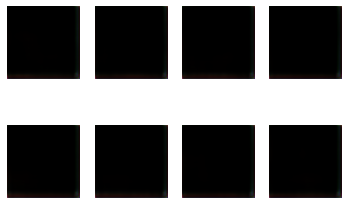

2001 [D loss: 1.304795, acc.: 60.94%, op_acc: 65.39%] [G loss: 1.391006]
2002 [D loss: 1.306259, acc.: 45.31%, op_acc: 64.69%] [G loss: 1.383904]
2003 [D loss: 1.308651, acc.: 46.88%, op_acc: 65.51%] [G loss: 1.389211]
2004 [D loss: 1.325791, acc.: 51.56%, op_acc: 66.21%] [G loss: 1.369860]
2005 [D loss: 1.334367, acc.: 46.88%, op_acc: 65.04%] [G loss: 1.373133]
2006 [D loss: 1.319009, acc.: 51.56%, op_acc: 65.70%] [G loss: 1.393643]
2007 [D loss: 1.334158, acc.: 42.19%, op_acc: 66.13%] [G loss: 1.382937]
2008 [D loss: 1.332752, acc.: 53.12%, op_acc: 65.82%] [G loss: 1.397743]
2009 [D loss: 1.330280, acc.: 46.88%, op_acc: 66.95%] [G loss: 1.380058]
2010 [D loss: 1.336551, acc.: 40.62%, op_acc: 65.35%] [G loss: 1.401320]
2011 [D loss: 1.342240, acc.: 40.62%, op_acc: 67.30%] [G loss: 1.390193]
2012 [D loss: 1.336919, acc.: 50.00%, op_acc: 65.59%] [G loss: 1.403015]
2013 [D loss: 1.352262, acc.: 35.94%, op_acc: 66.37%] [G loss: 1.410369]
2014 [D loss: 1.337646, acc.: 46.88%, op_acc: 64.92

2115 [D loss: 1.317162, acc.: 64.06%, op_acc: 64.30%] [G loss: 1.454742]
2116 [D loss: 1.309217, acc.: 65.62%, op_acc: 65.04%] [G loss: 1.435631]
2117 [D loss: 1.305621, acc.: 71.88%, op_acc: 64.14%] [G loss: 1.441881]
2118 [D loss: 1.316853, acc.: 62.50%, op_acc: 65.66%] [G loss: 1.410503]
2119 [D loss: 1.318610, acc.: 48.44%, op_acc: 65.59%] [G loss: 1.409971]
2120 [D loss: 1.313830, acc.: 51.56%, op_acc: 65.94%] [G loss: 1.422559]
2121 [D loss: 1.322621, acc.: 59.38%, op_acc: 63.36%] [G loss: 1.421635]
2122 [D loss: 1.293697, acc.: 65.62%, op_acc: 65.55%] [G loss: 1.417293]
2123 [D loss: 1.310278, acc.: 56.25%, op_acc: 64.49%] [G loss: 1.413396]
2124 [D loss: 1.301087, acc.: 67.19%, op_acc: 66.05%] [G loss: 1.429590]
2125 [D loss: 1.303679, acc.: 59.38%, op_acc: 64.84%] [G loss: 1.414694]
2126 [D loss: 1.296874, acc.: 59.38%, op_acc: 66.05%] [G loss: 1.395486]
2127 [D loss: 1.304058, acc.: 54.69%, op_acc: 65.04%] [G loss: 1.417801]
2128 [D loss: 1.301966, acc.: 51.56%, op_acc: 67.11

2229 [D loss: 1.286798, acc.: 75.00%, op_acc: 63.44%] [G loss: 1.465041]
2230 [D loss: 1.301458, acc.: 73.44%, op_acc: 65.00%] [G loss: 1.450529]
2231 [D loss: 1.265787, acc.: 81.25%, op_acc: 66.25%] [G loss: 1.405373]
2232 [D loss: 1.250792, acc.: 87.50%, op_acc: 66.76%] [G loss: 1.397609]
2233 [D loss: 1.240239, acc.: 92.19%, op_acc: 66.21%] [G loss: 1.388251]
2234 [D loss: 1.248076, acc.: 85.94%, op_acc: 65.59%] [G loss: 1.366593]
2235 [D loss: 1.257544, acc.: 76.56%, op_acc: 64.65%] [G loss: 1.392255]
2236 [D loss: 1.231311, acc.: 60.94%, op_acc: 64.92%] [G loss: 1.328188]
2237 [D loss: 1.246757, acc.: 40.62%, op_acc: 65.43%] [G loss: 1.362267]
2238 [D loss: 1.209320, acc.: 45.31%, op_acc: 66.64%] [G loss: 1.320970]
2239 [D loss: 1.240623, acc.: 40.62%, op_acc: 66.41%] [G loss: 1.311996]
2240 [D loss: 1.212378, acc.: 46.88%, op_acc: 66.68%] [G loss: 1.274829]
2241 [D loss: 1.232208, acc.: 46.88%, op_acc: 64.84%] [G loss: 1.317384]
2242 [D loss: 1.184273, acc.: 48.44%, op_acc: 65.27

2343 [D loss: 1.321827, acc.: 51.56%, op_acc: 65.51%] [G loss: 1.394076]
2344 [D loss: 1.326247, acc.: 51.56%, op_acc: 64.80%] [G loss: 1.389242]
2345 [D loss: 1.310210, acc.: 54.69%, op_acc: 66.21%] [G loss: 1.388808]
2346 [D loss: 1.328227, acc.: 54.69%, op_acc: 63.79%] [G loss: 1.389748]
2347 [D loss: 1.334253, acc.: 51.56%, op_acc: 64.96%] [G loss: 1.408863]
2348 [D loss: 1.312283, acc.: 46.88%, op_acc: 67.46%] [G loss: 1.367069]
2349 [D loss: 1.339019, acc.: 53.12%, op_acc: 64.88%] [G loss: 1.411516]
2350 [D loss: 1.334173, acc.: 54.69%, op_acc: 64.80%] [G loss: 1.388800]
2351 [D loss: 1.337053, acc.: 45.31%, op_acc: 65.39%] [G loss: 1.392716]
2352 [D loss: 1.327111, acc.: 51.56%, op_acc: 66.25%] [G loss: 1.408413]
2353 [D loss: 1.340477, acc.: 46.88%, op_acc: 65.78%] [G loss: 1.403848]
2354 [D loss: 1.321084, acc.: 62.50%, op_acc: 65.08%] [G loss: 1.455017]
2355 [D loss: 1.341038, acc.: 48.44%, op_acc: 66.09%] [G loss: 1.408166]
2356 [D loss: 1.321802, acc.: 42.19%, op_acc: 65.90

2456 [D loss: 1.311776, acc.: 59.38%, op_acc: 64.49%] [G loss: 1.427789]
2457 [D loss: 1.300566, acc.: 64.06%, op_acc: 65.16%] [G loss: 1.442038]
2458 [D loss: 1.280132, acc.: 68.75%, op_acc: 65.94%] [G loss: 1.424906]
2459 [D loss: 1.307319, acc.: 57.81%, op_acc: 66.64%] [G loss: 1.391199]
2460 [D loss: 1.294863, acc.: 54.69%, op_acc: 65.90%] [G loss: 1.429251]
2461 [D loss: 1.314537, acc.: 56.25%, op_acc: 64.96%] [G loss: 1.414461]
2462 [D loss: 1.312274, acc.: 56.25%, op_acc: 65.98%] [G loss: 1.390962]
2463 [D loss: 1.333045, acc.: 48.44%, op_acc: 65.27%] [G loss: 1.390074]
2464 [D loss: 1.330293, acc.: 42.19%, op_acc: 64.45%] [G loss: 1.416467]
2465 [D loss: 1.309249, acc.: 53.12%, op_acc: 65.78%] [G loss: 1.400231]
2466 [D loss: 1.325529, acc.: 54.69%, op_acc: 65.47%] [G loss: 1.405168]
2467 [D loss: 1.334142, acc.: 46.88%, op_acc: 65.55%] [G loss: 1.395082]
2468 [D loss: 1.310046, acc.: 53.12%, op_acc: 65.55%] [G loss: 1.405394]
2469 [D loss: 1.320380, acc.: 53.12%, op_acc: 65.27

2570 [D loss: 1.343549, acc.: 45.31%, op_acc: 65.12%] [G loss: 1.461223]
2571 [D loss: 1.342808, acc.: 45.31%, op_acc: 65.78%] [G loss: 1.457111]
2572 [D loss: 1.329994, acc.: 50.00%, op_acc: 65.62%] [G loss: 1.467931]
2573 [D loss: 1.345350, acc.: 48.44%, op_acc: 67.19%] [G loss: 1.452082]
2574 [D loss: 1.339617, acc.: 50.00%, op_acc: 65.31%] [G loss: 1.477421]
2575 [D loss: 1.336599, acc.: 46.88%, op_acc: 66.60%] [G loss: 1.459841]
2576 [D loss: 1.348397, acc.: 45.31%, op_acc: 65.62%] [G loss: 1.465220]
2577 [D loss: 1.339743, acc.: 48.44%, op_acc: 63.63%] [G loss: 1.472569]
2578 [D loss: 1.331250, acc.: 50.00%, op_acc: 65.98%] [G loss: 1.469976]
2579 [D loss: 1.340199, acc.: 50.00%, op_acc: 63.83%] [G loss: 1.478924]
2580 [D loss: 1.336110, acc.: 50.00%, op_acc: 65.66%] [G loss: 1.466750]
2581 [D loss: 1.339366, acc.: 50.00%, op_acc: 64.22%] [G loss: 1.477025]
2582 [D loss: 1.327598, acc.: 50.00%, op_acc: 67.19%] [G loss: 1.466242]
2583 [D loss: 1.336977, acc.: 50.00%, op_acc: 66.21

2684 [D loss: 1.262008, acc.: 67.19%, op_acc: 65.66%] [G loss: 1.353030]
2685 [D loss: 1.241423, acc.: 64.06%, op_acc: 64.73%] [G loss: 1.366891]
2686 [D loss: 1.220752, acc.: 59.38%, op_acc: 64.69%] [G loss: 1.333434]
2687 [D loss: 1.260325, acc.: 43.75%, op_acc: 67.27%] [G loss: 1.304203]
2688 [D loss: 1.333017, acc.: 37.50%, op_acc: 66.29%] [G loss: 1.294587]
2689 [D loss: 1.322826, acc.: 45.31%, op_acc: 64.26%] [G loss: 1.330436]
2690 [D loss: 1.290319, acc.: 43.75%, op_acc: 68.09%] [G loss: 1.291151]
2691 [D loss: 1.294554, acc.: 42.19%, op_acc: 64.49%] [G loss: 1.358711]
2692 [D loss: 1.305205, acc.: 46.88%, op_acc: 65.00%] [G loss: 1.361622]
2693 [D loss: 1.294998, acc.: 45.31%, op_acc: 64.77%] [G loss: 1.315992]
2694 [D loss: 1.280953, acc.: 46.88%, op_acc: 65.90%] [G loss: 1.330671]
2695 [D loss: 1.291089, acc.: 42.19%, op_acc: 65.08%] [G loss: 1.314483]
2696 [D loss: 1.301074, acc.: 43.75%, op_acc: 64.65%] [G loss: 1.324111]
2697 [D loss: 1.271999, acc.: 48.44%, op_acc: 65.70

2798 [D loss: 1.335578, acc.: 50.00%, op_acc: 64.37%] [G loss: 1.480867]
2799 [D loss: 1.329912, acc.: 50.00%, op_acc: 65.90%] [G loss: 1.466733]
2800 [D loss: 1.329919, acc.: 50.00%, op_acc: 66.09%] [G loss: 1.472731]
2801 [D loss: 1.325114, acc.: 50.00%, op_acc: 66.91%] [G loss: 1.460072]
2802 [D loss: 1.330351, acc.: 50.00%, op_acc: 65.20%] [G loss: 1.471826]
2803 [D loss: 1.321542, acc.: 50.00%, op_acc: 66.95%] [G loss: 1.460101]
2804 [D loss: 1.321070, acc.: 50.00%, op_acc: 66.84%] [G loss: 1.468302]
2805 [D loss: 1.320603, acc.: 50.00%, op_acc: 66.02%] [G loss: 1.465397]
2806 [D loss: 1.325032, acc.: 50.00%, op_acc: 65.86%] [G loss: 1.462419]
2807 [D loss: 1.325861, acc.: 50.00%, op_acc: 65.94%] [G loss: 1.474418]
2808 [D loss: 1.323910, acc.: 50.00%, op_acc: 65.98%] [G loss: 1.469811]
2809 [D loss: 1.323940, acc.: 50.00%, op_acc: 65.90%] [G loss: 1.460495]
2810 [D loss: 1.328181, acc.: 50.00%, op_acc: 64.96%] [G loss: 1.470109]
2811 [D loss: 1.326162, acc.: 50.00%, op_acc: 65.55

2911 [D loss: 1.316655, acc.: 67.19%, op_acc: 65.70%] [G loss: 1.407253]
2912 [D loss: 1.327204, acc.: 67.19%, op_acc: 65.04%] [G loss: 1.426746]
2913 [D loss: 1.319769, acc.: 67.19%, op_acc: 65.47%] [G loss: 1.380184]
2914 [D loss: 1.304280, acc.: 73.44%, op_acc: 66.48%] [G loss: 1.369056]
2915 [D loss: 1.307273, acc.: 65.62%, op_acc: 65.43%] [G loss: 1.404761]
2916 [D loss: 1.329864, acc.: 67.19%, op_acc: 63.95%] [G loss: 1.397415]
2917 [D loss: 1.308309, acc.: 65.62%, op_acc: 66.33%] [G loss: 1.370337]
2918 [D loss: 1.322435, acc.: 60.94%, op_acc: 66.25%] [G loss: 1.389037]
2919 [D loss: 1.307269, acc.: 64.06%, op_acc: 65.59%] [G loss: 1.393713]
2920 [D loss: 1.313268, acc.: 71.88%, op_acc: 65.00%] [G loss: 1.375031]
2921 [D loss: 1.323025, acc.: 62.50%, op_acc: 64.10%] [G loss: 1.404407]
2922 [D loss: 1.323310, acc.: 50.00%, op_acc: 65.43%] [G loss: 1.383376]
2923 [D loss: 1.327366, acc.: 57.81%, op_acc: 66.05%] [G loss: 1.384727]
2924 [D loss: 1.318543, acc.: 60.94%, op_acc: 65.12

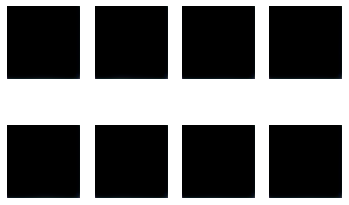

3001 [D loss: 1.336937, acc.: 50.00%, op_acc: 65.55%] [G loss: 1.511240]
3002 [D loss: 1.331078, acc.: 50.00%, op_acc: 66.17%] [G loss: 1.490033]
3003 [D loss: 1.334816, acc.: 50.00%, op_acc: 65.43%] [G loss: 1.503510]
3004 [D loss: 1.338160, acc.: 50.00%, op_acc: 65.00%] [G loss: 1.505400]
3005 [D loss: 1.335779, acc.: 50.00%, op_acc: 65.23%] [G loss: 1.500194]
3006 [D loss: 1.334238, acc.: 50.00%, op_acc: 64.45%] [G loss: 1.504283]
3007 [D loss: 1.331229, acc.: 50.00%, op_acc: 64.57%] [G loss: 1.499950]
3008 [D loss: 1.327819, acc.: 50.00%, op_acc: 65.08%] [G loss: 1.483213]
3009 [D loss: 1.332130, acc.: 50.00%, op_acc: 65.12%] [G loss: 1.473160]
3010 [D loss: 1.336309, acc.: 50.00%, op_acc: 63.98%] [G loss: 1.486297]
3011 [D loss: 1.328334, acc.: 50.00%, op_acc: 66.05%] [G loss: 1.467196]
3012 [D loss: 1.329206, acc.: 50.00%, op_acc: 65.16%] [G loss: 1.444847]
3013 [D loss: 1.319395, acc.: 50.00%, op_acc: 65.86%] [G loss: 1.450976]
3014 [D loss: 1.334036, acc.: 50.00%, op_acc: 64.77

3115 [D loss: 1.335588, acc.: 50.00%, op_acc: 65.78%] [G loss: 1.463625]
3116 [D loss: 1.341209, acc.: 50.00%, op_acc: 65.00%] [G loss: 1.467097]
3117 [D loss: 1.345804, acc.: 50.00%, op_acc: 63.67%] [G loss: 1.469290]
3118 [D loss: 1.345095, acc.: 50.00%, op_acc: 65.23%] [G loss: 1.471993]
3119 [D loss: 1.341006, acc.: 50.00%, op_acc: 65.23%] [G loss: 1.463428]
3120 [D loss: 1.347340, acc.: 50.00%, op_acc: 63.98%] [G loss: 1.471368]
3121 [D loss: 1.340875, acc.: 50.00%, op_acc: 64.77%] [G loss: 1.459144]
3122 [D loss: 1.331045, acc.: 50.00%, op_acc: 66.80%] [G loss: 1.452190]
3123 [D loss: 1.342358, acc.: 50.00%, op_acc: 65.35%] [G loss: 1.459301]
3124 [D loss: 1.332426, acc.: 50.00%, op_acc: 65.98%] [G loss: 1.453784]
3125 [D loss: 1.336683, acc.: 50.00%, op_acc: 65.04%] [G loss: 1.459537]
3126 [D loss: 1.329069, acc.: 50.00%, op_acc: 66.64%] [G loss: 1.448234]
3127 [D loss: 1.346250, acc.: 50.00%, op_acc: 63.05%] [G loss: 1.468672]
3128 [D loss: 1.333930, acc.: 50.00%, op_acc: 65.82

3229 [D loss: 1.288132, acc.: 50.00%, op_acc: 64.77%] [G loss: 1.387799]
3230 [D loss: 1.270458, acc.: 50.00%, op_acc: 67.03%] [G loss: 1.357439]
3231 [D loss: 1.268072, acc.: 50.00%, op_acc: 64.61%] [G loss: 1.390605]
3232 [D loss: 1.271988, acc.: 50.00%, op_acc: 66.64%] [G loss: 1.349698]
3233 [D loss: 1.280187, acc.: 50.00%, op_acc: 65.47%] [G loss: 1.384634]
3234 [D loss: 1.268366, acc.: 50.00%, op_acc: 66.09%] [G loss: 1.352669]
3235 [D loss: 1.269746, acc.: 50.00%, op_acc: 64.77%] [G loss: 1.360711]
3236 [D loss: 1.261677, acc.: 50.00%, op_acc: 65.23%] [G loss: 1.353832]
3237 [D loss: 1.275380, acc.: 50.00%, op_acc: 64.26%] [G loss: 1.334267]
3238 [D loss: 1.279819, acc.: 50.00%, op_acc: 65.31%] [G loss: 1.350363]
3239 [D loss: 1.283185, acc.: 50.00%, op_acc: 63.75%] [G loss: 1.362480]
3240 [D loss: 1.268124, acc.: 50.00%, op_acc: 65.47%] [G loss: 1.322587]
3241 [D loss: 1.264097, acc.: 50.00%, op_acc: 65.20%] [G loss: 1.299953]
3242 [D loss: 1.242034, acc.: 50.00%, op_acc: 67.07

3342 [D loss: 0.880134, acc.: 95.31%, op_acc: 66.09%] [G loss: 0.886287]
3343 [D loss: 0.895933, acc.: 93.75%, op_acc: 65.31%] [G loss: 0.883048]
3344 [D loss: 0.877332, acc.: 95.31%, op_acc: 64.06%] [G loss: 0.900657]
3345 [D loss: 0.877064, acc.: 93.75%, op_acc: 64.69%] [G loss: 0.912643]
3346 [D loss: 0.863675, acc.: 93.75%, op_acc: 66.60%] [G loss: 0.869558]
3347 [D loss: 0.814257, acc.: 96.88%, op_acc: 65.94%] [G loss: 0.892215]
3348 [D loss: 0.816183, acc.: 95.31%, op_acc: 64.34%] [G loss: 0.883754]
3349 [D loss: 0.827454, acc.: 95.31%, op_acc: 64.61%] [G loss: 0.869478]
3350 [D loss: 0.836719, acc.: 92.19%, op_acc: 66.80%] [G loss: 0.855547]
3351 [D loss: 0.887995, acc.: 89.06%, op_acc: 65.66%] [G loss: 0.822329]
3352 [D loss: 0.918415, acc.: 92.19%, op_acc: 64.57%] [G loss: 0.830918]
3353 [D loss: 0.752051, acc.: 98.44%, op_acc: 65.94%] [G loss: 0.830474]
3354 [D loss: 0.779666, acc.: 95.31%, op_acc: 64.69%] [G loss: 0.873793]
3355 [D loss: 0.751755, acc.: 96.88%, op_acc: 66.17

3456 [D loss: 1.197342, acc.: 51.56%, op_acc: 66.33%] [G loss: 1.137614]
3457 [D loss: 1.196284, acc.: 57.81%, op_acc: 65.43%] [G loss: 1.128384]
3458 [D loss: 1.172175, acc.: 65.62%, op_acc: 65.78%] [G loss: 1.102822]
3459 [D loss: 1.183888, acc.: 62.50%, op_acc: 67.42%] [G loss: 1.050203]
3460 [D loss: 1.171844, acc.: 76.56%, op_acc: 64.34%] [G loss: 1.078538]
3461 [D loss: 1.129609, acc.: 78.12%, op_acc: 66.05%] [G loss: 1.019862]
3462 [D loss: 1.115246, acc.: 84.38%, op_acc: 66.25%] [G loss: 1.004177]
3463 [D loss: 1.084296, acc.: 95.31%, op_acc: 64.77%] [G loss: 0.997995]
3464 [D loss: 1.131452, acc.: 93.75%, op_acc: 65.35%] [G loss: 1.004675]
3465 [D loss: 1.075177, acc.: 93.75%, op_acc: 63.67%] [G loss: 1.033320]
3466 [D loss: 1.014910, acc.: 95.31%, op_acc: 66.21%] [G loss: 0.960169]
3467 [D loss: 0.951661, acc.: 100.00%, op_acc: 64.45%] [G loss: 0.985955]
3468 [D loss: 0.958050, acc.: 95.31%, op_acc: 65.23%] [G loss: 0.976362]
3469 [D loss: 0.839892, acc.: 100.00%, op_acc: 66.

3570 [D loss: 1.338472, acc.: 51.56%, op_acc: 64.92%] [G loss: 1.513134]
3571 [D loss: 1.348385, acc.: 50.00%, op_acc: 64.92%] [G loss: 1.493192]
3572 [D loss: 1.342860, acc.: 51.56%, op_acc: 64.96%] [G loss: 1.543725]
3573 [D loss: 1.357638, acc.: 51.56%, op_acc: 63.71%] [G loss: 1.515235]
3574 [D loss: 1.368376, acc.: 50.00%, op_acc: 65.66%] [G loss: 1.504626]
3575 [D loss: 1.422554, acc.: 50.00%, op_acc: 63.87%] [G loss: 1.527776]
3576 [D loss: 1.401480, acc.: 46.88%, op_acc: 63.91%] [G loss: 1.557124]
3577 [D loss: 1.385936, acc.: 48.44%, op_acc: 65.20%] [G loss: 1.577374]
3578 [D loss: 1.355023, acc.: 50.00%, op_acc: 65.94%] [G loss: 1.591124]
3579 [D loss: 1.344884, acc.: 50.00%, op_acc: 65.98%] [G loss: 1.602877]
3580 [D loss: 1.348229, acc.: 50.00%, op_acc: 64.49%] [G loss: 1.627390]
3581 [D loss: 1.339834, acc.: 50.00%, op_acc: 65.82%] [G loss: 1.569317]
3582 [D loss: 1.341352, acc.: 50.00%, op_acc: 64.34%] [G loss: 1.563925]
3583 [D loss: 1.336881, acc.: 50.00%, op_acc: 64.45

3684 [D loss: 1.337563, acc.: 57.81%, op_acc: 65.12%] [G loss: 1.703774]
3685 [D loss: 1.377554, acc.: 53.12%, op_acc: 67.19%] [G loss: 1.735395]
3686 [D loss: 1.487100, acc.: 23.44%, op_acc: 66.80%] [G loss: 1.658335]
3687 [D loss: 1.495823, acc.: 32.81%, op_acc: 64.77%] [G loss: 1.570410]
3688 [D loss: 1.394738, acc.: 50.00%, op_acc: 64.61%] [G loss: 1.568510]
3689 [D loss: 1.345046, acc.: 50.00%, op_acc: 65.62%] [G loss: 1.561043]
3690 [D loss: 1.331028, acc.: 50.00%, op_acc: 65.27%] [G loss: 1.567349]
3691 [D loss: 1.315207, acc.: 50.00%, op_acc: 66.48%] [G loss: 1.551395]
3692 [D loss: 1.346968, acc.: 50.00%, op_acc: 65.59%] [G loss: 1.521658]
3693 [D loss: 1.331250, acc.: 50.00%, op_acc: 66.45%] [G loss: 1.503855]
3694 [D loss: 1.326135, acc.: 50.00%, op_acc: 65.39%] [G loss: 1.505247]
3695 [D loss: 1.359612, acc.: 50.00%, op_acc: 65.35%] [G loss: 1.475238]
3696 [D loss: 1.334555, acc.: 50.00%, op_acc: 65.66%] [G loss: 1.455792]
3697 [D loss: 1.346530, acc.: 50.00%, op_acc: 64.06

3797 [D loss: 1.303120, acc.: 67.19%, op_acc: 66.87%] [G loss: 1.339293]
3798 [D loss: 1.324970, acc.: 60.94%, op_acc: 64.14%] [G loss: 1.347364]
3799 [D loss: 1.356343, acc.: 53.12%, op_acc: 64.02%] [G loss: 1.363417]
3800 [D loss: 1.315781, acc.: 65.62%, op_acc: 65.90%] [G loss: 1.332466]
3801 [D loss: 1.313790, acc.: 62.50%, op_acc: 65.78%] [G loss: 1.339909]
3802 [D loss: 1.293052, acc.: 67.19%, op_acc: 66.09%] [G loss: 1.366595]
3803 [D loss: 1.316449, acc.: 64.06%, op_acc: 64.18%] [G loss: 1.358589]
3804 [D loss: 1.311234, acc.: 59.38%, op_acc: 66.41%] [G loss: 1.335554]
3805 [D loss: 1.332021, acc.: 67.19%, op_acc: 64.69%] [G loss: 1.371058]
3806 [D loss: 1.310084, acc.: 65.62%, op_acc: 65.51%] [G loss: 1.338475]
3807 [D loss: 1.314750, acc.: 54.69%, op_acc: 65.59%] [G loss: 1.346646]
3808 [D loss: 1.338344, acc.: 60.94%, op_acc: 63.16%] [G loss: 1.386836]
3809 [D loss: 1.307565, acc.: 65.62%, op_acc: 66.02%] [G loss: 1.350552]
3810 [D loss: 1.297644, acc.: 62.50%, op_acc: 65.86

3911 [D loss: 1.223820, acc.: 85.94%, op_acc: 66.56%] [G loss: 1.303036]
3912 [D loss: 1.336778, acc.: 62.50%, op_acc: 64.06%] [G loss: 1.338919]
3913 [D loss: 1.263733, acc.: 82.81%, op_acc: 65.82%] [G loss: 1.354848]
3914 [D loss: 1.259791, acc.: 75.00%, op_acc: 66.29%] [G loss: 1.401801]
3915 [D loss: 1.318122, acc.: 60.94%, op_acc: 65.16%] [G loss: 1.399908]
3916 [D loss: 1.436253, acc.: 28.12%, op_acc: 64.02%] [G loss: 1.359342]
3917 [D loss: 1.505359, acc.: 26.56%, op_acc: 66.52%] [G loss: 1.342532]
3918 [D loss: 1.392153, acc.: 34.38%, op_acc: 66.05%] [G loss: 1.448203]
3919 [D loss: 1.415103, acc.: 20.31%, op_acc: 66.72%] [G loss: 1.420520]
3920 [D loss: 1.439456, acc.: 28.12%, op_acc: 64.80%] [G loss: 1.483778]
3921 [D loss: 1.355396, acc.: 45.31%, op_acc: 64.96%] [G loss: 1.502002]
3922 [D loss: 1.330611, acc.: 64.06%, op_acc: 65.98%] [G loss: 1.431633]
3923 [D loss: 1.362963, acc.: 40.62%, op_acc: 65.66%] [G loss: 1.417017]
3924 [D loss: 1.339209, acc.: 62.50%, op_acc: 64.61

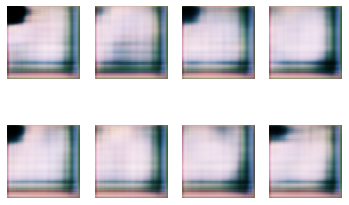

4001 [D loss: 1.320662, acc.: 50.00%, op_acc: 64.92%] [G loss: 1.353422]
4002 [D loss: 1.306885, acc.: 48.44%, op_acc: 65.04%] [G loss: 1.330758]
4003 [D loss: 1.310781, acc.: 48.44%, op_acc: 65.78%] [G loss: 1.331788]
4004 [D loss: 1.317023, acc.: 50.00%, op_acc: 65.74%] [G loss: 1.328203]
4005 [D loss: 1.320204, acc.: 50.00%, op_acc: 67.03%] [G loss: 1.315307]
4006 [D loss: 1.340318, acc.: 50.00%, op_acc: 64.84%] [G loss: 1.321667]
4007 [D loss: 1.363192, acc.: 48.44%, op_acc: 65.86%] [G loss: 1.317672]
4008 [D loss: 1.364230, acc.: 48.44%, op_acc: 65.27%] [G loss: 1.334172]
4009 [D loss: 1.368828, acc.: 48.44%, op_acc: 63.91%] [G loss: 1.357146]
4010 [D loss: 1.362495, acc.: 48.44%, op_acc: 66.17%] [G loss: 1.301639]
4011 [D loss: 1.351734, acc.: 48.44%, op_acc: 65.51%] [G loss: 1.307100]
4012 [D loss: 1.361672, acc.: 48.44%, op_acc: 66.76%] [G loss: 1.310632]
4013 [D loss: 1.380541, acc.: 45.31%, op_acc: 64.80%] [G loss: 1.316308]
4014 [D loss: 1.371862, acc.: 48.44%, op_acc: 65.20

4114 [D loss: 1.326877, acc.: 48.44%, op_acc: 66.05%] [G loss: 1.343668]
4115 [D loss: 1.337253, acc.: 48.44%, op_acc: 64.73%] [G loss: 1.354649]
4116 [D loss: 1.333635, acc.: 50.00%, op_acc: 65.31%] [G loss: 1.366501]
4117 [D loss: 1.324754, acc.: 50.00%, op_acc: 65.78%] [G loss: 1.336548]
4118 [D loss: 1.320402, acc.: 50.00%, op_acc: 66.99%] [G loss: 1.326508]
4119 [D loss: 1.340205, acc.: 50.00%, op_acc: 63.16%] [G loss: 1.377985]
4120 [D loss: 1.326590, acc.: 50.00%, op_acc: 66.29%] [G loss: 1.350521]
4121 [D loss: 1.334682, acc.: 50.00%, op_acc: 64.41%] [G loss: 1.355942]
4122 [D loss: 1.342015, acc.: 50.00%, op_acc: 64.02%] [G loss: 1.379042]
4123 [D loss: 1.331396, acc.: 50.00%, op_acc: 65.90%] [G loss: 1.349369]
4124 [D loss: 1.328252, acc.: 48.44%, op_acc: 65.47%] [G loss: 1.335758]
4125 [D loss: 1.326879, acc.: 50.00%, op_acc: 66.21%] [G loss: 1.356877]
4126 [D loss: 1.320425, acc.: 48.44%, op_acc: 66.64%] [G loss: 1.327708]
4127 [D loss: 1.326382, acc.: 48.44%, op_acc: 65.04

4228 [D loss: 1.330301, acc.: 53.12%, op_acc: 65.23%] [G loss: 1.437210]
4229 [D loss: 1.321107, acc.: 53.12%, op_acc: 66.25%] [G loss: 1.436877]
4230 [D loss: 1.324169, acc.: 53.12%, op_acc: 65.00%] [G loss: 1.431788]
4231 [D loss: 1.323426, acc.: 57.81%, op_acc: 65.35%] [G loss: 1.429808]
4232 [D loss: 1.328331, acc.: 53.12%, op_acc: 64.84%] [G loss: 1.436463]
4233 [D loss: 1.314658, acc.: 46.88%, op_acc: 67.11%] [G loss: 1.414300]
4234 [D loss: 1.316463, acc.: 56.25%, op_acc: 66.29%] [G loss: 1.418900]
4235 [D loss: 1.317628, acc.: 51.56%, op_acc: 67.15%] [G loss: 1.401923]
4236 [D loss: 1.317996, acc.: 68.75%, op_acc: 64.73%] [G loss: 1.435901]
4237 [D loss: 1.328784, acc.: 51.56%, op_acc: 64.53%] [G loss: 1.428880]
4238 [D loss: 1.313084, acc.: 56.25%, op_acc: 66.21%] [G loss: 1.419113]
4239 [D loss: 1.318765, acc.: 64.06%, op_acc: 64.73%] [G loss: 1.430598]
4240 [D loss: 1.321910, acc.: 70.31%, op_acc: 64.34%] [G loss: 1.427354]
4241 [D loss: 1.313112, acc.: 79.69%, op_acc: 63.44

4342 [D loss: 1.340454, acc.: 31.25%, op_acc: 66.13%] [G loss: 1.404223]
4343 [D loss: 1.342622, acc.: 31.25%, op_acc: 65.78%] [G loss: 1.417994]
4344 [D loss: 1.352336, acc.: 31.25%, op_acc: 65.08%] [G loss: 1.422672]
4345 [D loss: 1.338906, acc.: 42.19%, op_acc: 66.09%] [G loss: 1.417037]
4346 [D loss: 1.335112, acc.: 54.69%, op_acc: 66.72%] [G loss: 1.404123]
4347 [D loss: 1.342200, acc.: 57.81%, op_acc: 65.08%] [G loss: 1.407372]
4348 [D loss: 1.338258, acc.: 51.56%, op_acc: 66.21%] [G loss: 1.397716]
4349 [D loss: 1.365689, acc.: 26.56%, op_acc: 64.65%] [G loss: 1.418764]
4350 [D loss: 1.360502, acc.: 29.69%, op_acc: 64.30%] [G loss: 1.409470]
4351 [D loss: 1.340383, acc.: 34.38%, op_acc: 66.88%] [G loss: 1.398343]
4352 [D loss: 1.345015, acc.: 26.56%, op_acc: 66.05%] [G loss: 1.383189]
4353 [D loss: 1.350223, acc.: 28.12%, op_acc: 65.51%] [G loss: 1.422424]
4354 [D loss: 1.343549, acc.: 25.00%, op_acc: 67.03%] [G loss: 1.390773]
4355 [D loss: 1.366666, acc.: 17.19%, op_acc: 63.67

4456 [D loss: 1.331973, acc.: 48.44%, op_acc: 66.02%] [G loss: 1.402344]
4457 [D loss: 1.326682, acc.: 50.00%, op_acc: 64.57%] [G loss: 1.408635]
4458 [D loss: 1.334291, acc.: 48.44%, op_acc: 65.00%] [G loss: 1.393529]
4459 [D loss: 1.327715, acc.: 50.00%, op_acc: 66.05%] [G loss: 1.396813]
4460 [D loss: 1.325793, acc.: 50.00%, op_acc: 66.37%] [G loss: 1.390676]
4461 [D loss: 1.328284, acc.: 50.00%, op_acc: 66.68%] [G loss: 1.393261]
4462 [D loss: 1.330843, acc.: 50.00%, op_acc: 65.70%] [G loss: 1.382492]
4463 [D loss: 1.333098, acc.: 50.00%, op_acc: 64.80%] [G loss: 1.389601]
4464 [D loss: 1.341684, acc.: 50.00%, op_acc: 63.20%] [G loss: 1.413032]
4465 [D loss: 1.333120, acc.: 50.00%, op_acc: 64.73%] [G loss: 1.402822]
4466 [D loss: 1.326734, acc.: 50.00%, op_acc: 66.09%] [G loss: 1.397594]
4467 [D loss: 1.321859, acc.: 50.00%, op_acc: 66.72%] [G loss: 1.386618]
4468 [D loss: 1.337124, acc.: 50.00%, op_acc: 64.57%] [G loss: 1.417662]
4469 [D loss: 1.332434, acc.: 50.00%, op_acc: 65.23

4569 [D loss: 1.152249, acc.: 92.19%, op_acc: 65.35%] [G loss: 1.309270]
4570 [D loss: 1.139268, acc.: 89.06%, op_acc: 64.53%] [G loss: 1.331058]
4571 [D loss: 1.087814, acc.: 79.69%, op_acc: 65.04%] [G loss: 1.328107]
4572 [D loss: 1.225376, acc.: 64.06%, op_acc: 62.50%] [G loss: 1.352346]
4573 [D loss: 1.146133, acc.: 75.00%, op_acc: 63.55%] [G loss: 1.352246]
4574 [D loss: 1.089288, acc.: 75.00%, op_acc: 66.60%] [G loss: 1.297854]
4575 [D loss: 1.202168, acc.: 78.12%, op_acc: 66.52%] [G loss: 1.352479]
4576 [D loss: 1.250744, acc.: 68.75%, op_acc: 65.27%] [G loss: 1.343637]
4577 [D loss: 1.257091, acc.: 65.62%, op_acc: 66.41%] [G loss: 1.365479]
4578 [D loss: 1.321256, acc.: 68.75%, op_acc: 64.73%] [G loss: 1.385502]
4579 [D loss: 1.298967, acc.: 70.31%, op_acc: 65.04%] [G loss: 1.423266]
4580 [D loss: 1.394645, acc.: 62.50%, op_acc: 64.80%] [G loss: 1.386293]
4581 [D loss: 1.388062, acc.: 31.25%, op_acc: 64.92%] [G loss: 1.387701]
4582 [D loss: 1.354799, acc.: 34.38%, op_acc: 66.33

4683 [D loss: 1.321659, acc.: 39.06%, op_acc: 66.60%] [G loss: 1.410356]
4684 [D loss: 1.323817, acc.: 43.75%, op_acc: 65.74%] [G loss: 1.406986]
4685 [D loss: 1.325812, acc.: 45.31%, op_acc: 66.48%] [G loss: 1.418690]
4686 [D loss: 1.317392, acc.: 34.38%, op_acc: 67.34%] [G loss: 1.406921]
4687 [D loss: 1.324372, acc.: 43.75%, op_acc: 65.59%] [G loss: 1.411041]
4688 [D loss: 1.332213, acc.: 40.62%, op_acc: 64.73%] [G loss: 1.409082]
4689 [D loss: 1.324393, acc.: 45.31%, op_acc: 65.20%] [G loss: 1.407840]
4690 [D loss: 1.314625, acc.: 48.44%, op_acc: 66.60%] [G loss: 1.391801]
4691 [D loss: 1.324493, acc.: 42.19%, op_acc: 65.82%] [G loss: 1.403375]
4692 [D loss: 1.320900, acc.: 45.31%, op_acc: 66.13%] [G loss: 1.396200]
4693 [D loss: 1.318325, acc.: 42.19%, op_acc: 65.98%] [G loss: 1.389981]
4694 [D loss: 1.313800, acc.: 43.75%, op_acc: 65.90%] [G loss: 1.385805]
4695 [D loss: 1.320690, acc.: 43.75%, op_acc: 66.72%] [G loss: 1.389721]
4696 [D loss: 1.324435, acc.: 39.06%, op_acc: 65.00

4797 [D loss: 1.358993, acc.: 42.19%, op_acc: 64.06%] [G loss: 1.357469]
4798 [D loss: 1.360746, acc.: 40.62%, op_acc: 65.98%] [G loss: 1.351859]
4799 [D loss: 1.349890, acc.: 40.62%, op_acc: 64.92%] [G loss: 1.351802]
4800 [D loss: 1.368998, acc.: 40.62%, op_acc: 64.10%] [G loss: 1.377740]
4801 [D loss: 1.355398, acc.: 37.50%, op_acc: 63.87%] [G loss: 1.393862]
4802 [D loss: 1.338035, acc.: 29.69%, op_acc: 65.90%] [G loss: 1.389464]
4803 [D loss: 1.350348, acc.: 28.12%, op_acc: 64.69%] [G loss: 1.406085]
4804 [D loss: 1.341733, acc.: 31.25%, op_acc: 65.39%] [G loss: 1.417180]
4805 [D loss: 1.330345, acc.: 32.81%, op_acc: 65.62%] [G loss: 1.397692]
4806 [D loss: 1.336711, acc.: 31.25%, op_acc: 65.20%] [G loss: 1.412877]
4807 [D loss: 1.332292, acc.: 32.81%, op_acc: 64.73%] [G loss: 1.423368]
4808 [D loss: 1.334626, acc.: 42.19%, op_acc: 65.27%] [G loss: 1.415344]
4809 [D loss: 1.320184, acc.: 43.75%, op_acc: 65.51%] [G loss: 1.408781]
4810 [D loss: 1.335109, acc.: 45.31%, op_acc: 65.51

4911 [D loss: 1.399615, acc.: 26.56%, op_acc: 66.41%] [G loss: 1.249732]
4912 [D loss: 1.372350, acc.: 34.38%, op_acc: 65.23%] [G loss: 1.334317]
4913 [D loss: 1.390626, acc.: 29.69%, op_acc: 64.96%] [G loss: 1.412648]
4914 [D loss: 1.326239, acc.: 42.19%, op_acc: 64.84%] [G loss: 1.466570]
4915 [D loss: 1.347023, acc.: 32.81%, op_acc: 66.37%] [G loss: 1.519816]
4916 [D loss: 1.444226, acc.: 28.12%, op_acc: 64.84%] [G loss: 1.446701]
4917 [D loss: 1.632579, acc.: 26.56%, op_acc: 65.90%] [G loss: 1.371961]
4918 [D loss: 1.522353, acc.: 21.88%, op_acc: 66.29%] [G loss: 1.429572]
4919 [D loss: 1.422428, acc.: 10.94%, op_acc: 64.73%] [G loss: 1.503551]
4920 [D loss: 1.379935, acc.: 53.12%, op_acc: 64.88%] [G loss: 1.532040]
4921 [D loss: 1.369668, acc.: 50.00%, op_acc: 65.66%] [G loss: 1.501814]
4922 [D loss: 1.363700, acc.: 48.44%, op_acc: 65.86%] [G loss: 1.476636]
4923 [D loss: 1.366856, acc.: 54.69%, op_acc: 66.45%] [G loss: 1.468692]
4924 [D loss: 1.372910, acc.: 51.56%, op_acc: 64.06

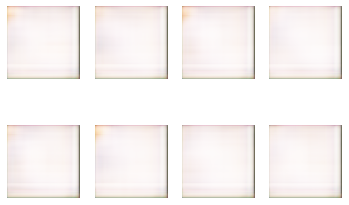

5001 [D loss: 1.320153, acc.: 48.44%, op_acc: 65.62%] [G loss: 1.423619]
5002 [D loss: 1.321080, acc.: 46.88%, op_acc: 66.48%] [G loss: 1.439549]
5003 [D loss: 1.326446, acc.: 50.00%, op_acc: 64.41%] [G loss: 1.444307]
5004 [D loss: 1.329435, acc.: 50.00%, op_acc: 64.10%] [G loss: 1.453682]
5005 [D loss: 1.335054, acc.: 50.00%, op_acc: 63.05%] [G loss: 1.460344]
5006 [D loss: 1.318564, acc.: 50.00%, op_acc: 65.62%] [G loss: 1.450910]
5007 [D loss: 1.326052, acc.: 48.44%, op_acc: 65.43%] [G loss: 1.436596]
5008 [D loss: 1.321425, acc.: 48.44%, op_acc: 65.86%] [G loss: 1.437211]
5009 [D loss: 1.322497, acc.: 46.88%, op_acc: 65.98%] [G loss: 1.435214]
5010 [D loss: 1.328001, acc.: 53.12%, op_acc: 63.67%] [G loss: 1.456105]
5011 [D loss: 1.318758, acc.: 50.00%, op_acc: 65.47%] [G loss: 1.441283]
5012 [D loss: 1.323464, acc.: 53.12%, op_acc: 64.34%] [G loss: 1.444859]
5013 [D loss: 1.329059, acc.: 50.00%, op_acc: 65.08%] [G loss: 1.452854]
5014 [D loss: 1.332287, acc.: 45.31%, op_acc: 65.27

5115 [D loss: 1.428867, acc.: 26.56%, op_acc: 64.73%] [G loss: 1.278128]
5116 [D loss: 1.342398, acc.: 32.81%, op_acc: 67.46%] [G loss: 1.233638]
5117 [D loss: 1.356137, acc.: 35.94%, op_acc: 66.13%] [G loss: 1.215396]
5118 [D loss: 1.371623, acc.: 42.19%, op_acc: 64.22%] [G loss: 1.309300]
5119 [D loss: 1.353626, acc.: 40.62%, op_acc: 66.33%] [G loss: 1.292669]
5120 [D loss: 1.339878, acc.: 34.38%, op_acc: 66.02%] [G loss: 1.257371]
5121 [D loss: 1.381345, acc.: 34.38%, op_acc: 65.35%] [G loss: 1.305821]
5122 [D loss: 1.353106, acc.: 31.25%, op_acc: 65.16%] [G loss: 1.314539]
5123 [D loss: 1.328337, acc.: 34.38%, op_acc: 66.56%] [G loss: 1.267949]
5124 [D loss: 1.371921, acc.: 20.31%, op_acc: 64.06%] [G loss: 1.314199]
5125 [D loss: 1.341639, acc.: 31.25%, op_acc: 65.78%] [G loss: 1.321150]
5126 [D loss: 1.345524, acc.: 23.44%, op_acc: 66.48%] [G loss: 1.313987]
5127 [D loss: 1.342782, acc.: 34.38%, op_acc: 64.80%] [G loss: 1.351002]
5128 [D loss: 1.329281, acc.: 37.50%, op_acc: 66.02

5229 [D loss: 1.334507, acc.: 23.44%, op_acc: 66.80%] [G loss: 1.351173]
5230 [D loss: 1.329072, acc.: 23.44%, op_acc: 65.90%] [G loss: 1.343888]
5231 [D loss: 1.334921, acc.: 23.44%, op_acc: 66.72%] [G loss: 1.347774]
5232 [D loss: 1.332389, acc.: 23.44%, op_acc: 65.74%] [G loss: 1.360515]
5233 [D loss: 1.333369, acc.: 29.69%, op_acc: 66.09%] [G loss: 1.362717]
5234 [D loss: 1.349751, acc.: 25.00%, op_acc: 63.55%] [G loss: 1.396574]
5235 [D loss: 1.343318, acc.: 23.44%, op_acc: 64.96%] [G loss: 1.377701]
5236 [D loss: 1.332060, acc.: 17.19%, op_acc: 66.41%] [G loss: 1.375211]
5237 [D loss: 1.336670, acc.: 21.88%, op_acc: 65.51%] [G loss: 1.371868]
5238 [D loss: 1.333305, acc.: 28.12%, op_acc: 65.94%] [G loss: 1.373602]
5239 [D loss: 1.345181, acc.: 25.00%, op_acc: 63.67%] [G loss: 1.392533]
5240 [D loss: 1.348906, acc.: 15.62%, op_acc: 63.91%] [G loss: 1.406392]
5241 [D loss: 1.326550, acc.: 23.44%, op_acc: 67.50%] [G loss: 1.377171]
5242 [D loss: 1.341077, acc.: 20.31%, op_acc: 64.77

5343 [D loss: 1.323147, acc.: 51.56%, op_acc: 65.00%] [G loss: 1.431591]
5344 [D loss: 1.326919, acc.: 51.56%, op_acc: 64.73%] [G loss: 1.447149]
5345 [D loss: 1.327852, acc.: 54.69%, op_acc: 64.34%] [G loss: 1.457286]
5346 [D loss: 1.318324, acc.: 56.25%, op_acc: 65.74%] [G loss: 1.435808]
5347 [D loss: 1.324527, acc.: 53.12%, op_acc: 64.45%] [G loss: 1.455365]
5348 [D loss: 1.327284, acc.: 53.12%, op_acc: 64.61%] [G loss: 1.453296]
5349 [D loss: 1.328219, acc.: 53.12%, op_acc: 64.06%] [G loss: 1.443708]
5350 [D loss: 1.310691, acc.: 57.81%, op_acc: 66.45%] [G loss: 1.421351]
5351 [D loss: 1.314798, acc.: 54.69%, op_acc: 65.70%] [G loss: 1.429181]
5352 [D loss: 1.318582, acc.: 57.81%, op_acc: 65.43%] [G loss: 1.427033]
5353 [D loss: 1.304281, acc.: 57.81%, op_acc: 66.84%] [G loss: 1.421813]
5354 [D loss: 1.314313, acc.: 64.06%, op_acc: 65.70%] [G loss: 1.442942]
5355 [D loss: 1.325541, acc.: 57.81%, op_acc: 64.22%] [G loss: 1.452502]
5356 [D loss: 1.319400, acc.: 64.06%, op_acc: 64.84

5457 [D loss: 1.368576, acc.: 37.50%, op_acc: 65.27%] [G loss: 1.350265]
5458 [D loss: 1.365198, acc.: 35.94%, op_acc: 65.78%] [G loss: 1.332507]
5459 [D loss: 1.364562, acc.: 43.75%, op_acc: 64.57%] [G loss: 1.348346]
5460 [D loss: 1.338404, acc.: 39.06%, op_acc: 66.48%] [G loss: 1.347385]
5461 [D loss: 1.344699, acc.: 42.19%, op_acc: 65.08%] [G loss: 1.358000]
5462 [D loss: 1.366092, acc.: 39.06%, op_acc: 63.24%] [G loss: 1.380867]
5463 [D loss: 1.356221, acc.: 37.50%, op_acc: 66.68%] [G loss: 1.308524]
5464 [D loss: 1.340776, acc.: 48.44%, op_acc: 66.09%] [G loss: 1.278851]
5465 [D loss: 1.336145, acc.: 45.31%, op_acc: 67.30%] [G loss: 1.243104]
5466 [D loss: 1.341838, acc.: 50.00%, op_acc: 65.70%] [G loss: 1.263041]
5467 [D loss: 1.338479, acc.: 50.00%, op_acc: 65.94%] [G loss: 1.254455]
5468 [D loss: 1.331069, acc.: 50.00%, op_acc: 65.16%] [G loss: 1.257076]
5469 [D loss: 1.339091, acc.: 50.00%, op_acc: 63.95%] [G loss: 1.283165]
5470 [D loss: 1.339481, acc.: 50.00%, op_acc: 65.20

5571 [D loss: 1.344017, acc.: 43.75%, op_acc: 64.18%] [G loss: 1.346850]
5572 [D loss: 1.339135, acc.: 34.38%, op_acc: 64.34%] [G loss: 1.351097]
5573 [D loss: 1.322121, acc.: 42.19%, op_acc: 65.66%] [G loss: 1.317362]
5574 [D loss: 1.328442, acc.: 40.62%, op_acc: 65.70%] [G loss: 1.353440]
5575 [D loss: 1.327234, acc.: 43.75%, op_acc: 65.16%] [G loss: 1.341927]
5576 [D loss: 1.319377, acc.: 40.62%, op_acc: 66.60%] [G loss: 1.331307]
5577 [D loss: 1.324043, acc.: 39.06%, op_acc: 66.05%] [G loss: 1.347897]
5578 [D loss: 1.325480, acc.: 40.62%, op_acc: 65.55%] [G loss: 1.346960]
5579 [D loss: 1.343295, acc.: 35.94%, op_acc: 64.22%] [G loss: 1.379138]
5580 [D loss: 1.339587, acc.: 35.94%, op_acc: 64.57%] [G loss: 1.381541]
5581 [D loss: 1.335306, acc.: 40.62%, op_acc: 65.51%] [G loss: 1.369869]
5582 [D loss: 1.338574, acc.: 32.81%, op_acc: 64.65%] [G loss: 1.365077]
5583 [D loss: 1.327453, acc.: 34.38%, op_acc: 66.09%] [G loss: 1.356418]
5584 [D loss: 1.347764, acc.: 32.81%, op_acc: 63.20

5685 [D loss: 1.343631, acc.: 28.12%, op_acc: 65.20%] [G loss: 1.447772]
5686 [D loss: 1.339557, acc.: 12.50%, op_acc: 64.92%] [G loss: 1.430472]
5687 [D loss: 1.345398, acc.: 14.06%, op_acc: 66.25%] [G loss: 1.453649]
5688 [D loss: 1.337527, acc.: 18.75%, op_acc: 66.56%] [G loss: 1.432575]
5689 [D loss: 1.343352, acc.: 17.19%, op_acc: 65.39%] [G loss: 1.444247]
5690 [D loss: 1.337125, acc.: 28.12%, op_acc: 66.17%] [G loss: 1.448590]
5691 [D loss: 1.346625, acc.: 32.81%, op_acc: 64.65%] [G loss: 1.458033]
5692 [D loss: 1.339007, acc.: 35.94%, op_acc: 65.16%] [G loss: 1.452924]
5693 [D loss: 1.330278, acc.: 42.19%, op_acc: 66.87%] [G loss: 1.438694]
5694 [D loss: 1.339253, acc.: 45.31%, op_acc: 65.74%] [G loss: 1.453383]
5695 [D loss: 1.324825, acc.: 46.88%, op_acc: 67.46%] [G loss: 1.430197]
5696 [D loss: 1.326930, acc.: 46.88%, op_acc: 66.41%] [G loss: 1.439356]
5697 [D loss: 1.325284, acc.: 46.88%, op_acc: 67.54%] [G loss: 1.437509]
5698 [D loss: 1.331386, acc.: 48.44%, op_acc: 65.74

5799 [D loss: 1.324123, acc.: 50.00%, op_acc: 65.74%] [G loss: 1.445512]
5800 [D loss: 1.327492, acc.: 50.00%, op_acc: 66.17%] [G loss: 1.456218]
5801 [D loss: 1.335504, acc.: 50.00%, op_acc: 64.37%] [G loss: 1.454222]
5802 [D loss: 1.333104, acc.: 50.00%, op_acc: 65.70%] [G loss: 1.459110]
5803 [D loss: 1.332635, acc.: 50.00%, op_acc: 65.16%] [G loss: 1.455322]
5804 [D loss: 1.324414, acc.: 50.00%, op_acc: 65.82%] [G loss: 1.438626]
5805 [D loss: 1.333317, acc.: 51.56%, op_acc: 64.88%] [G loss: 1.467256]
5806 [D loss: 1.326903, acc.: 50.00%, op_acc: 65.39%] [G loss: 1.445044]
5807 [D loss: 1.332636, acc.: 50.00%, op_acc: 65.00%] [G loss: 1.461756]
5808 [D loss: 1.325080, acc.: 50.00%, op_acc: 65.16%] [G loss: 1.449799]
5809 [D loss: 1.336941, acc.: 50.00%, op_acc: 64.84%] [G loss: 1.462191]
5810 [D loss: 1.332546, acc.: 50.00%, op_acc: 64.61%] [G loss: 1.466924]
5811 [D loss: 1.327672, acc.: 50.00%, op_acc: 65.59%] [G loss: 1.458393]
5812 [D loss: 1.330256, acc.: 50.00%, op_acc: 65.74

5913 [D loss: 1.322017, acc.: 46.88%, op_acc: 66.45%] [G loss: 1.443707]
5914 [D loss: 1.317846, acc.: 48.44%, op_acc: 67.23%] [G loss: 1.443340]
5915 [D loss: 1.326430, acc.: 48.44%, op_acc: 65.94%] [G loss: 1.457286]
5916 [D loss: 1.335786, acc.: 50.00%, op_acc: 64.26%] [G loss: 1.453986]
5917 [D loss: 1.321621, acc.: 50.00%, op_acc: 66.29%] [G loss: 1.438859]
5918 [D loss: 1.325009, acc.: 50.00%, op_acc: 66.37%] [G loss: 1.448293]
5919 [D loss: 1.326985, acc.: 48.44%, op_acc: 65.47%] [G loss: 1.452601]
5920 [D loss: 1.327400, acc.: 50.00%, op_acc: 65.66%] [G loss: 1.462528]
5921 [D loss: 1.317404, acc.: 48.44%, op_acc: 66.91%] [G loss: 1.434348]
5922 [D loss: 1.330672, acc.: 50.00%, op_acc: 65.51%] [G loss: 1.462833]
5923 [D loss: 1.326299, acc.: 50.00%, op_acc: 65.59%] [G loss: 1.452507]
5924 [D loss: 1.321854, acc.: 50.00%, op_acc: 65.86%] [G loss: 1.453615]
5925 [D loss: 1.336905, acc.: 48.44%, op_acc: 64.45%] [G loss: 1.455888]
5926 [D loss: 1.332448, acc.: 50.00%, op_acc: 63.63

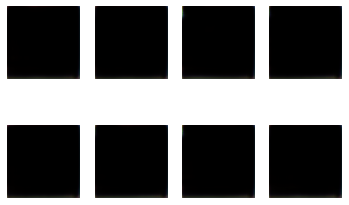

6001 [D loss: 1.302118, acc.: 60.94%, op_acc: 65.08%] [G loss: 1.408253]
6002 [D loss: 1.299235, acc.: 65.62%, op_acc: 64.96%] [G loss: 1.444342]
6003 [D loss: 1.301462, acc.: 59.38%, op_acc: 64.77%] [G loss: 1.437574]
6004 [D loss: 1.309670, acc.: 62.50%, op_acc: 63.48%] [G loss: 1.440588]
6005 [D loss: 1.295497, acc.: 62.50%, op_acc: 66.09%] [G loss: 1.410614]
6006 [D loss: 1.304702, acc.: 56.25%, op_acc: 64.22%] [G loss: 1.436691]
6007 [D loss: 1.307036, acc.: 64.06%, op_acc: 65.31%] [G loss: 1.393095]
6008 [D loss: 1.301441, acc.: 62.50%, op_acc: 65.59%] [G loss: 1.400365]
6009 [D loss: 1.288677, acc.: 56.25%, op_acc: 67.07%] [G loss: 1.400276]
6010 [D loss: 1.297130, acc.: 64.06%, op_acc: 64.69%] [G loss: 1.431957]
6011 [D loss: 1.295748, acc.: 60.94%, op_acc: 64.88%] [G loss: 1.423582]
6012 [D loss: 1.301024, acc.: 59.38%, op_acc: 65.66%] [G loss: 1.392129]
6013 [D loss: 1.302450, acc.: 64.06%, op_acc: 65.55%] [G loss: 1.408084]
6014 [D loss: 1.296330, acc.: 56.25%, op_acc: 64.88

6115 [D loss: 1.330065, acc.: 50.00%, op_acc: 65.16%] [G loss: 1.471372]
6116 [D loss: 1.328797, acc.: 50.00%, op_acc: 65.04%] [G loss: 1.456035]
6117 [D loss: 1.328705, acc.: 50.00%, op_acc: 64.61%] [G loss: 1.464645]
6118 [D loss: 1.323104, acc.: 50.00%, op_acc: 65.86%] [G loss: 1.455540]
6119 [D loss: 1.331093, acc.: 50.00%, op_acc: 64.65%] [G loss: 1.465665]
6120 [D loss: 1.320117, acc.: 50.00%, op_acc: 65.66%] [G loss: 1.448256]
6121 [D loss: 1.325981, acc.: 50.00%, op_acc: 65.51%] [G loss: 1.453992]
6122 [D loss: 1.332741, acc.: 50.00%, op_acc: 64.73%] [G loss: 1.464136]
6123 [D loss: 1.321190, acc.: 50.00%, op_acc: 65.04%] [G loss: 1.456967]
6124 [D loss: 1.322949, acc.: 50.00%, op_acc: 66.45%] [G loss: 1.449077]
6125 [D loss: 1.328400, acc.: 50.00%, op_acc: 65.82%] [G loss: 1.459402]
6126 [D loss: 1.333524, acc.: 48.44%, op_acc: 64.14%] [G loss: 1.466984]
6127 [D loss: 1.324725, acc.: 50.00%, op_acc: 65.70%] [G loss: 1.458259]
6128 [D loss: 1.317087, acc.: 48.44%, op_acc: 66.68

6229 [D loss: 1.359878, acc.: 29.69%, op_acc: 65.39%] [G loss: 1.431967]
6230 [D loss: 1.356718, acc.: 31.25%, op_acc: 65.70%] [G loss: 1.444894]
6231 [D loss: 1.354373, acc.: 40.62%, op_acc: 65.74%] [G loss: 1.441863]
6232 [D loss: 1.349994, acc.: 42.19%, op_acc: 66.48%] [G loss: 1.438815]
6233 [D loss: 1.345463, acc.: 46.88%, op_acc: 66.13%] [G loss: 1.434448]
6234 [D loss: 1.351065, acc.: 48.44%, op_acc: 65.90%] [G loss: 1.442356]
6235 [D loss: 1.354968, acc.: 50.00%, op_acc: 64.80%] [G loss: 1.454052]
6236 [D loss: 1.359556, acc.: 50.00%, op_acc: 63.75%] [G loss: 1.479996]
6237 [D loss: 1.345266, acc.: 50.00%, op_acc: 65.04%] [G loss: 1.452818]
6238 [D loss: 1.334966, acc.: 50.00%, op_acc: 67.15%] [G loss: 1.441414]
6239 [D loss: 1.336470, acc.: 50.00%, op_acc: 66.02%] [G loss: 1.442255]
6240 [D loss: 1.341997, acc.: 50.00%, op_acc: 65.39%] [G loss: 1.451689]
6241 [D loss: 1.327403, acc.: 50.00%, op_acc: 67.62%] [G loss: 1.432039]
6242 [D loss: 1.337691, acc.: 50.00%, op_acc: 66.09

6343 [D loss: 1.318885, acc.: 64.06%, op_acc: 63.48%] [G loss: 1.476436]
6344 [D loss: 1.309394, acc.: 65.62%, op_acc: 66.45%] [G loss: 1.454764]
6345 [D loss: 1.317761, acc.: 62.50%, op_acc: 64.57%] [G loss: 1.457344]
6346 [D loss: 1.309682, acc.: 62.50%, op_acc: 66.52%] [G loss: 1.429905]
6347 [D loss: 1.322271, acc.: 60.94%, op_acc: 64.57%] [G loss: 1.460401]
6348 [D loss: 1.320528, acc.: 56.25%, op_acc: 65.35%] [G loss: 1.445476]
6349 [D loss: 1.308597, acc.: 57.81%, op_acc: 66.09%] [G loss: 1.444273]
6350 [D loss: 1.308012, acc.: 67.19%, op_acc: 65.08%] [G loss: 1.446314]
6351 [D loss: 1.301140, acc.: 53.12%, op_acc: 66.60%] [G loss: 1.434993]
6352 [D loss: 1.320534, acc.: 46.88%, op_acc: 65.98%] [G loss: 1.417838]
6353 [D loss: 1.312445, acc.: 65.62%, op_acc: 65.39%] [G loss: 1.461747]
6354 [D loss: 1.308230, acc.: 56.25%, op_acc: 65.82%] [G loss: 1.432248]
6355 [D loss: 1.308502, acc.: 60.94%, op_acc: 66.80%] [G loss: 1.433823]
6356 [D loss: 1.319452, acc.: 56.25%, op_acc: 64.80

6457 [D loss: 1.336417, acc.: 50.00%, op_acc: 65.23%] [G loss: 1.438133]
6458 [D loss: 1.353782, acc.: 42.19%, op_acc: 65.23%] [G loss: 1.429816]
6459 [D loss: 1.362368, acc.: 29.69%, op_acc: 65.35%] [G loss: 1.406768]
6460 [D loss: 1.366394, acc.: 37.50%, op_acc: 64.92%] [G loss: 1.436317]
6461 [D loss: 1.347018, acc.: 40.62%, op_acc: 65.23%] [G loss: 1.458138]
6462 [D loss: 1.367449, acc.: 28.12%, op_acc: 65.66%] [G loss: 1.428482]
6463 [D loss: 1.356043, acc.: 42.19%, op_acc: 65.16%] [G loss: 1.464105]
6464 [D loss: 1.356644, acc.: 32.81%, op_acc: 65.74%] [G loss: 1.432384]
6465 [D loss: 1.347737, acc.: 42.19%, op_acc: 64.49%] [G loss: 1.464026]
6466 [D loss: 1.352429, acc.: 32.81%, op_acc: 66.48%] [G loss: 1.436101]
6467 [D loss: 1.348015, acc.: 37.50%, op_acc: 66.48%] [G loss: 1.438715]
6468 [D loss: 1.349323, acc.: 39.06%, op_acc: 64.34%] [G loss: 1.474709]
6469 [D loss: 1.343324, acc.: 32.81%, op_acc: 65.59%] [G loss: 1.452573]
6470 [D loss: 1.334574, acc.: 37.50%, op_acc: 66.68

6571 [D loss: 1.304466, acc.: 65.62%, op_acc: 64.77%] [G loss: 1.445896]
6572 [D loss: 1.304795, acc.: 70.31%, op_acc: 65.12%] [G loss: 1.443725]
6573 [D loss: 1.309142, acc.: 60.94%, op_acc: 65.90%] [G loss: 1.422859]
6574 [D loss: 1.329706, acc.: 57.81%, op_acc: 64.65%] [G loss: 1.422867]
6575 [D loss: 1.298554, acc.: 62.50%, op_acc: 66.45%] [G loss: 1.432150]
6576 [D loss: 1.327955, acc.: 53.12%, op_acc: 65.51%] [G loss: 1.426526]
6577 [D loss: 1.331823, acc.: 42.19%, op_acc: 66.52%] [G loss: 1.427060]
6578 [D loss: 1.318730, acc.: 51.56%, op_acc: 66.52%] [G loss: 1.445064]
6579 [D loss: 1.338950, acc.: 48.44%, op_acc: 64.49%] [G loss: 1.445460]
6580 [D loss: 1.332951, acc.: 46.88%, op_acc: 65.74%] [G loss: 1.434292]
6581 [D loss: 1.349277, acc.: 48.44%, op_acc: 65.47%] [G loss: 1.441454]
6582 [D loss: 1.323098, acc.: 62.50%, op_acc: 65.35%] [G loss: 1.443655]
6583 [D loss: 1.328470, acc.: 46.88%, op_acc: 66.29%] [G loss: 1.441541]
6584 [D loss: 1.326599, acc.: 48.44%, op_acc: 67.66

6685 [D loss: 1.244415, acc.: 71.88%, op_acc: 66.45%] [G loss: 1.414337]
6686 [D loss: 1.232585, acc.: 70.31%, op_acc: 67.19%] [G loss: 1.408980]
6687 [D loss: 1.337118, acc.: 43.75%, op_acc: 66.52%] [G loss: 1.444107]
6688 [D loss: 1.366953, acc.: 34.38%, op_acc: 65.70%] [G loss: 1.384960]
6689 [D loss: 1.316788, acc.: 54.69%, op_acc: 65.16%] [G loss: 1.413619]
6690 [D loss: 1.301991, acc.: 50.00%, op_acc: 65.82%] [G loss: 1.408110]
6691 [D loss: 1.356797, acc.: 45.31%, op_acc: 65.08%] [G loss: 1.397282]
6692 [D loss: 1.308400, acc.: 50.00%, op_acc: 65.98%] [G loss: 1.399952]
6693 [D loss: 1.336255, acc.: 45.31%, op_acc: 65.62%] [G loss: 1.387013]
6694 [D loss: 1.342684, acc.: 46.88%, op_acc: 64.45%] [G loss: 1.413569]
6695 [D loss: 1.327188, acc.: 50.00%, op_acc: 65.35%] [G loss: 1.390428]
6696 [D loss: 1.355129, acc.: 39.06%, op_acc: 65.35%] [G loss: 1.376814]
6697 [D loss: 1.349011, acc.: 50.00%, op_acc: 65.23%] [G loss: 1.401078]
6698 [D loss: 1.316856, acc.: 50.00%, op_acc: 65.12

6799 [D loss: 1.258623, acc.: 67.19%, op_acc: 67.66%] [G loss: 1.382609]
6800 [D loss: 1.267375, acc.: 62.50%, op_acc: 65.43%] [G loss: 1.372618]
6801 [D loss: 1.277805, acc.: 67.19%, op_acc: 65.74%] [G loss: 1.415461]
6802 [D loss: 1.278999, acc.: 70.31%, op_acc: 64.92%] [G loss: 1.391272]
6803 [D loss: 1.268659, acc.: 64.06%, op_acc: 65.82%] [G loss: 1.355754]
6804 [D loss: 1.237178, acc.: 68.75%, op_acc: 68.20%] [G loss: 1.322666]
6805 [D loss: 1.259685, acc.: 67.19%, op_acc: 66.84%] [G loss: 1.347574]
6806 [D loss: 1.236968, acc.: 71.88%, op_acc: 64.18%] [G loss: 1.362836]
6807 [D loss: 1.238830, acc.: 78.12%, op_acc: 64.22%] [G loss: 1.351532]
6808 [D loss: 1.223089, acc.: 67.19%, op_acc: 65.94%] [G loss: 1.322811]
6809 [D loss: 1.193738, acc.: 71.88%, op_acc: 64.38%] [G loss: 1.355268]
6810 [D loss: 1.198122, acc.: 78.12%, op_acc: 64.14%] [G loss: 1.336655]
6811 [D loss: 1.287551, acc.: 43.75%, op_acc: 66.17%] [G loss: 1.342828]
6812 [D loss: 1.166770, acc.: 71.88%, op_acc: 65.39

6913 [D loss: 1.290748, acc.: 67.19%, op_acc: 65.78%] [G loss: 1.427995]
6914 [D loss: 1.282750, acc.: 78.12%, op_acc: 65.27%] [G loss: 1.429761]
6915 [D loss: 1.276479, acc.: 71.88%, op_acc: 65.98%] [G loss: 1.418274]
6916 [D loss: 1.291785, acc.: 62.50%, op_acc: 65.43%] [G loss: 1.401145]
6917 [D loss: 1.292097, acc.: 59.38%, op_acc: 65.94%] [G loss: 1.385243]
6918 [D loss: 1.273003, acc.: 68.75%, op_acc: 65.43%] [G loss: 1.354640]
6919 [D loss: 1.284744, acc.: 62.50%, op_acc: 64.69%] [G loss: 1.350844]
6920 [D loss: 1.246717, acc.: 79.69%, op_acc: 64.84%] [G loss: 1.358224]
6921 [D loss: 1.246840, acc.: 76.56%, op_acc: 66.60%] [G loss: 1.297020]
6922 [D loss: 1.268240, acc.: 65.62%, op_acc: 66.52%] [G loss: 1.326586]
6923 [D loss: 1.224913, acc.: 84.38%, op_acc: 64.73%] [G loss: 1.331394]
6924 [D loss: 1.186511, acc.: 81.25%, op_acc: 65.78%] [G loss: 1.308015]
6925 [D loss: 1.190506, acc.: 70.31%, op_acc: 65.20%] [G loss: 1.296783]
6926 [D loss: 1.135570, acc.: 85.94%, op_acc: 65.59

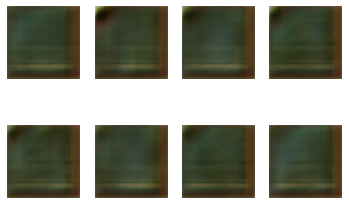

7001 [D loss: 1.331391, acc.: 34.38%, op_acc: 65.94%] [G loss: 1.437423]
7002 [D loss: 1.330264, acc.: 29.69%, op_acc: 65.08%] [G loss: 1.432591]
7003 [D loss: 1.334240, acc.: 34.38%, op_acc: 65.70%] [G loss: 1.435268]
7004 [D loss: 1.338878, acc.: 26.56%, op_acc: 64.84%] [G loss: 1.441333]
7005 [D loss: 1.330671, acc.: 35.94%, op_acc: 65.98%] [G loss: 1.429026]
7006 [D loss: 1.334994, acc.: 23.44%, op_acc: 65.27%] [G loss: 1.434059]
7007 [D loss: 1.338157, acc.: 31.25%, op_acc: 65.12%] [G loss: 1.446672]
7008 [D loss: 1.338521, acc.: 35.94%, op_acc: 64.65%] [G loss: 1.457081]
7009 [D loss: 1.342598, acc.: 31.25%, op_acc: 63.98%] [G loss: 1.449253]
7010 [D loss: 1.328937, acc.: 35.94%, op_acc: 65.82%] [G loss: 1.445514]
7011 [D loss: 1.340797, acc.: 29.69%, op_acc: 64.65%] [G loss: 1.457802]
7012 [D loss: 1.334275, acc.: 29.69%, op_acc: 65.70%] [G loss: 1.446157]
7013 [D loss: 1.333918, acc.: 28.12%, op_acc: 65.08%] [G loss: 1.435026]
7014 [D loss: 1.327724, acc.: 32.81%, op_acc: 66.13

7115 [D loss: 1.265599, acc.: 50.00%, op_acc: 65.78%] [G loss: 1.048007]
7116 [D loss: 1.252107, acc.: 50.00%, op_acc: 65.86%] [G loss: 0.999484]
7117 [D loss: 1.262107, acc.: 50.00%, op_acc: 65.59%] [G loss: 1.014118]
7118 [D loss: 1.256073, acc.: 50.00%, op_acc: 65.31%] [G loss: 0.994135]
7119 [D loss: 1.230502, acc.: 50.00%, op_acc: 66.13%] [G loss: 0.977896]
7120 [D loss: 1.229393, acc.: 50.00%, op_acc: 65.86%] [G loss: 0.989318]
7121 [D loss: 1.234629, acc.: 50.00%, op_acc: 65.16%] [G loss: 0.978529]
7122 [D loss: 1.190348, acc.: 50.00%, op_acc: 68.71%] [G loss: 0.926462]
7123 [D loss: 1.209309, acc.: 50.00%, op_acc: 65.20%] [G loss: 0.953074]
7124 [D loss: 1.186328, acc.: 50.00%, op_acc: 66.05%] [G loss: 0.931277]
7125 [D loss: 1.199058, acc.: 50.00%, op_acc: 64.41%] [G loss: 0.946557]
7126 [D loss: 1.184620, acc.: 50.00%, op_acc: 65.16%] [G loss: 0.936674]
7127 [D loss: 1.184311, acc.: 51.56%, op_acc: 65.39%] [G loss: 0.921726]
7128 [D loss: 1.149613, acc.: 50.00%, op_acc: 65.43

7229 [D loss: 1.301081, acc.: 85.94%, op_acc: 66.91%] [G loss: 1.403454]
7230 [D loss: 1.308697, acc.: 79.69%, op_acc: 65.04%] [G loss: 1.399732]
7231 [D loss: 1.302310, acc.: 84.38%, op_acc: 66.60%] [G loss: 1.387948]
7232 [D loss: 1.321019, acc.: 73.44%, op_acc: 64.10%] [G loss: 1.417236]
7233 [D loss: 1.296801, acc.: 71.88%, op_acc: 67.07%] [G loss: 1.376194]
7234 [D loss: 1.307974, acc.: 53.12%, op_acc: 65.94%] [G loss: 1.366322]
7235 [D loss: 1.301275, acc.: 54.69%, op_acc: 66.68%] [G loss: 1.365710]
7236 [D loss: 1.295599, acc.: 53.12%, op_acc: 67.62%] [G loss: 1.356102]
7237 [D loss: 1.319383, acc.: 46.88%, op_acc: 65.98%] [G loss: 1.380659]
7238 [D loss: 1.324604, acc.: 42.19%, op_acc: 65.43%] [G loss: 1.369187]
7239 [D loss: 1.326311, acc.: 42.19%, op_acc: 66.37%] [G loss: 1.367540]
7240 [D loss: 1.332264, acc.: 46.88%, op_acc: 64.92%] [G loss: 1.385496]
7241 [D loss: 1.330847, acc.: 43.75%, op_acc: 64.77%] [G loss: 1.384638]
7242 [D loss: 1.317157, acc.: 51.56%, op_acc: 65.20

7343 [D loss: 1.332620, acc.: 54.69%, op_acc: 65.39%] [G loss: 1.409602]
7344 [D loss: 1.323201, acc.: 50.00%, op_acc: 66.84%] [G loss: 1.377174]
7345 [D loss: 1.331648, acc.: 46.88%, op_acc: 65.59%] [G loss: 1.393676]
7346 [D loss: 1.327271, acc.: 50.00%, op_acc: 66.33%] [G loss: 1.404749]
7347 [D loss: 1.341021, acc.: 51.56%, op_acc: 63.71%] [G loss: 1.418185]
7348 [D loss: 1.323495, acc.: 51.56%, op_acc: 66.64%] [G loss: 1.392908]
7349 [D loss: 1.331747, acc.: 50.00%, op_acc: 65.39%] [G loss: 1.399077]
7350 [D loss: 1.332923, acc.: 51.56%, op_acc: 64.61%] [G loss: 1.402999]
7351 [D loss: 1.336208, acc.: 51.56%, op_acc: 64.22%] [G loss: 1.406399]
7352 [D loss: 1.330359, acc.: 51.56%, op_acc: 65.20%] [G loss: 1.414402]
7353 [D loss: 1.330023, acc.: 50.00%, op_acc: 65.51%] [G loss: 1.409275]
7354 [D loss: 1.321094, acc.: 50.00%, op_acc: 66.87%] [G loss: 1.394935]
7355 [D loss: 1.331541, acc.: 48.44%, op_acc: 64.84%] [G loss: 1.425378]
7356 [D loss: 1.325792, acc.: 50.00%, op_acc: 66.25

7457 [D loss: 1.323553, acc.: 53.12%, op_acc: 65.39%] [G loss: 1.464650]
7458 [D loss: 1.329288, acc.: 51.56%, op_acc: 63.79%] [G loss: 1.465618]
7459 [D loss: 1.326871, acc.: 53.12%, op_acc: 65.08%] [G loss: 1.454141]
7460 [D loss: 1.323096, acc.: 53.12%, op_acc: 65.66%] [G loss: 1.457958]
7461 [D loss: 1.332332, acc.: 57.81%, op_acc: 64.37%] [G loss: 1.466470]
7462 [D loss: 1.332055, acc.: 53.12%, op_acc: 65.08%] [G loss: 1.467478]
7463 [D loss: 1.319581, acc.: 57.81%, op_acc: 65.59%] [G loss: 1.462614]
7464 [D loss: 1.314605, acc.: 64.06%, op_acc: 66.84%] [G loss: 1.453569]
7465 [D loss: 1.325696, acc.: 56.25%, op_acc: 65.62%] [G loss: 1.453497]
7466 [D loss: 1.326353, acc.: 57.81%, op_acc: 64.45%] [G loss: 1.453408]
7467 [D loss: 1.327838, acc.: 59.38%, op_acc: 64.80%] [G loss: 1.451061]
7468 [D loss: 1.317394, acc.: 54.69%, op_acc: 67.30%] [G loss: 1.449067]
7469 [D loss: 1.310673, acc.: 64.06%, op_acc: 65.51%] [G loss: 1.444549]
7470 [D loss: 1.325411, acc.: 53.12%, op_acc: 65.16

7571 [D loss: 1.330000, acc.: 34.38%, op_acc: 66.45%] [G loss: 1.438917]
7572 [D loss: 1.335999, acc.: 39.06%, op_acc: 64.96%] [G loss: 1.445669]
7573 [D loss: 1.332704, acc.: 25.00%, op_acc: 66.48%] [G loss: 1.422347]
7574 [D loss: 1.325157, acc.: 34.38%, op_acc: 66.80%] [G loss: 1.433976]
7575 [D loss: 1.332159, acc.: 37.50%, op_acc: 65.12%] [G loss: 1.444398]
7576 [D loss: 1.329659, acc.: 39.06%, op_acc: 65.47%] [G loss: 1.449927]
7577 [D loss: 1.318938, acc.: 37.50%, op_acc: 67.93%] [G loss: 1.427173]
7578 [D loss: 1.325426, acc.: 45.31%, op_acc: 65.12%] [G loss: 1.450587]
7579 [D loss: 1.320140, acc.: 43.75%, op_acc: 66.25%] [G loss: 1.435089]
7580 [D loss: 1.317816, acc.: 46.88%, op_acc: 66.52%] [G loss: 1.435338]
7581 [D loss: 1.325798, acc.: 37.50%, op_acc: 66.29%] [G loss: 1.427246]
7582 [D loss: 1.323049, acc.: 46.88%, op_acc: 65.39%] [G loss: 1.443161]
7583 [D loss: 1.318849, acc.: 50.00%, op_acc: 65.12%] [G loss: 1.451165]
7584 [D loss: 1.317184, acc.: 46.88%, op_acc: 66.05

7684 [D loss: 1.320209, acc.: 60.94%, op_acc: 64.49%] [G loss: 1.433197]
7685 [D loss: 1.306366, acc.: 65.62%, op_acc: 65.55%] [G loss: 1.434608]
7686 [D loss: 1.305926, acc.: 65.62%, op_acc: 65.23%] [G loss: 1.430990]
7687 [D loss: 1.314314, acc.: 62.50%, op_acc: 64.26%] [G loss: 1.444077]
7688 [D loss: 1.297704, acc.: 65.62%, op_acc: 65.39%] [G loss: 1.445233]
7689 [D loss: 1.306922, acc.: 70.31%, op_acc: 65.00%] [G loss: 1.444071]
7690 [D loss: 1.319696, acc.: 57.81%, op_acc: 66.37%] [G loss: 1.435637]
7691 [D loss: 1.316756, acc.: 53.12%, op_acc: 66.48%] [G loss: 1.423098]
7692 [D loss: 1.311594, acc.: 53.12%, op_acc: 66.25%] [G loss: 1.427181]
7693 [D loss: 1.311553, acc.: 59.38%, op_acc: 64.77%] [G loss: 1.442513]
7694 [D loss: 1.303902, acc.: 64.06%, op_acc: 67.58%] [G loss: 1.433249]
7695 [D loss: 1.326294, acc.: 51.56%, op_acc: 66.25%] [G loss: 1.426753]
7696 [D loss: 1.333170, acc.: 48.44%, op_acc: 65.66%] [G loss: 1.435111]
7697 [D loss: 1.297867, acc.: 60.94%, op_acc: 65.55

7798 [D loss: 1.344210, acc.: 31.25%, op_acc: 65.35%] [G loss: 1.430634]
7799 [D loss: 1.335681, acc.: 40.62%, op_acc: 65.62%] [G loss: 1.426847]
7800 [D loss: 1.343958, acc.: 40.62%, op_acc: 64.53%] [G loss: 1.438559]
7801 [D loss: 1.326733, acc.: 42.19%, op_acc: 66.21%] [G loss: 1.426507]
7802 [D loss: 1.336761, acc.: 32.81%, op_acc: 66.87%] [G loss: 1.423704]
7803 [D loss: 1.330267, acc.: 39.06%, op_acc: 66.76%] [G loss: 1.431005]
7804 [D loss: 1.337746, acc.: 29.69%, op_acc: 65.27%] [G loss: 1.428617]
7805 [D loss: 1.338665, acc.: 35.94%, op_acc: 65.39%] [G loss: 1.445944]
7806 [D loss: 1.332214, acc.: 35.94%, op_acc: 65.55%] [G loss: 1.430068]
7807 [D loss: 1.333651, acc.: 29.69%, op_acc: 66.60%] [G loss: 1.431083]
7808 [D loss: 1.328120, acc.: 39.06%, op_acc: 66.13%] [G loss: 1.436675]
7809 [D loss: 1.328903, acc.: 48.44%, op_acc: 65.51%] [G loss: 1.434679]
7810 [D loss: 1.329393, acc.: 45.31%, op_acc: 64.96%] [G loss: 1.435230]
7811 [D loss: 1.324304, acc.: 42.19%, op_acc: 66.02

7912 [D loss: 1.323187, acc.: 48.44%, op_acc: 65.04%] [G loss: 1.415823]
7913 [D loss: 1.309286, acc.: 57.81%, op_acc: 67.34%] [G loss: 1.423807]
7914 [D loss: 1.309489, acc.: 59.38%, op_acc: 65.08%] [G loss: 1.428043]
7915 [D loss: 1.306513, acc.: 59.38%, op_acc: 67.50%] [G loss: 1.400852]
7916 [D loss: 1.333122, acc.: 51.56%, op_acc: 64.41%] [G loss: 1.431998]
7917 [D loss: 1.300830, acc.: 56.25%, op_acc: 67.58%] [G loss: 1.419497]
7918 [D loss: 1.293522, acc.: 59.38%, op_acc: 67.62%] [G loss: 1.404653]
7919 [D loss: 1.294634, acc.: 65.62%, op_acc: 65.51%] [G loss: 1.413307]
7920 [D loss: 1.308755, acc.: 60.94%, op_acc: 64.02%] [G loss: 1.433708]
7921 [D loss: 1.306363, acc.: 59.38%, op_acc: 64.73%] [G loss: 1.407543]
7922 [D loss: 1.337142, acc.: 51.56%, op_acc: 65.04%] [G loss: 1.432151]
7923 [D loss: 1.299119, acc.: 62.50%, op_acc: 64.96%] [G loss: 1.433368]
7924 [D loss: 1.280046, acc.: 67.19%, op_acc: 64.41%] [G loss: 1.429970]
7925 [D loss: 1.322816, acc.: 48.44%, op_acc: 66.41

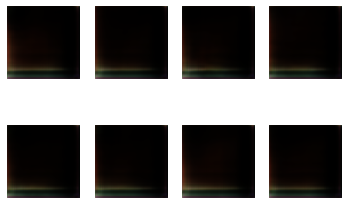

8001 [D loss: 1.298016, acc.: 53.12%, op_acc: 66.52%] [G loss: 1.380901]
8002 [D loss: 1.282802, acc.: 67.19%, op_acc: 66.29%] [G loss: 1.398722]
8003 [D loss: 1.287830, acc.: 65.62%, op_acc: 64.77%] [G loss: 1.422854]
8004 [D loss: 1.270576, acc.: 76.56%, op_acc: 65.98%] [G loss: 1.413215]
8005 [D loss: 1.309909, acc.: 50.00%, op_acc: 66.33%] [G loss: 1.372591]
8006 [D loss: 1.288596, acc.: 60.94%, op_acc: 66.17%] [G loss: 1.421687]
8007 [D loss: 1.307029, acc.: 54.69%, op_acc: 65.66%] [G loss: 1.398064]
8008 [D loss: 1.289512, acc.: 54.69%, op_acc: 66.05%] [G loss: 1.414658]
8009 [D loss: 1.284768, acc.: 65.62%, op_acc: 65.43%] [G loss: 1.424798]
8010 [D loss: 1.303017, acc.: 54.69%, op_acc: 66.17%] [G loss: 1.395436]
8011 [D loss: 1.346101, acc.: 43.75%, op_acc: 65.74%] [G loss: 1.401669]
8012 [D loss: 1.337158, acc.: 46.88%, op_acc: 65.74%] [G loss: 1.411302]
8013 [D loss: 1.333391, acc.: 46.88%, op_acc: 66.37%] [G loss: 1.403916]
8014 [D loss: 1.318869, acc.: 45.31%, op_acc: 66.17

8115 [D loss: 1.305314, acc.: 67.19%, op_acc: 67.15%] [G loss: 1.421862]
8116 [D loss: 1.322615, acc.: 51.56%, op_acc: 66.56%] [G loss: 1.427701]
8117 [D loss: 1.336360, acc.: 45.31%, op_acc: 65.51%] [G loss: 1.439314]
8118 [D loss: 1.319238, acc.: 60.94%, op_acc: 66.17%] [G loss: 1.436424]
8119 [D loss: 1.309074, acc.: 56.25%, op_acc: 67.15%] [G loss: 1.424782]
8120 [D loss: 1.326617, acc.: 51.56%, op_acc: 66.09%] [G loss: 1.429419]
8121 [D loss: 1.335358, acc.: 46.88%, op_acc: 66.41%] [G loss: 1.419830]
8122 [D loss: 1.336564, acc.: 43.75%, op_acc: 65.47%] [G loss: 1.439230]
8123 [D loss: 1.331512, acc.: 56.25%, op_acc: 63.52%] [G loss: 1.446230]
8124 [D loss: 1.312819, acc.: 71.88%, op_acc: 63.63%] [G loss: 1.445611]
8125 [D loss: 1.319487, acc.: 54.69%, op_acc: 65.20%] [G loss: 1.438967]
8126 [D loss: 1.317308, acc.: 54.69%, op_acc: 66.05%] [G loss: 1.427217]
8127 [D loss: 1.319973, acc.: 62.50%, op_acc: 64.38%] [G loss: 1.438468]
8128 [D loss: 1.325446, acc.: 59.38%, op_acc: 65.04

8229 [D loss: 1.333638, acc.: 31.25%, op_acc: 66.41%] [G loss: 1.419320]
8230 [D loss: 1.356293, acc.: 28.12%, op_acc: 65.12%] [G loss: 1.433449]
8231 [D loss: 1.354528, acc.: 40.62%, op_acc: 64.34%] [G loss: 1.435058]
8232 [D loss: 1.347415, acc.: 31.25%, op_acc: 65.20%] [G loss: 1.434858]
8233 [D loss: 1.357635, acc.: 32.81%, op_acc: 63.63%] [G loss: 1.446543]
8234 [D loss: 1.340730, acc.: 35.94%, op_acc: 66.29%] [G loss: 1.418396]
8235 [D loss: 1.357869, acc.: 20.31%, op_acc: 66.41%] [G loss: 1.421378]
8236 [D loss: 1.353137, acc.: 26.56%, op_acc: 65.55%] [G loss: 1.429622]
8237 [D loss: 1.346892, acc.: 32.81%, op_acc: 65.90%] [G loss: 1.436685]
8238 [D loss: 1.344160, acc.: 40.62%, op_acc: 65.47%] [G loss: 1.438872]
8239 [D loss: 1.341423, acc.: 37.50%, op_acc: 64.88%] [G loss: 1.444837]
8240 [D loss: 1.330844, acc.: 37.50%, op_acc: 66.80%] [G loss: 1.434682]
8241 [D loss: 1.346363, acc.: 29.69%, op_acc: 67.19%] [G loss: 1.422952]
8242 [D loss: 1.350271, acc.: 35.94%, op_acc: 64.69

8343 [D loss: 1.353916, acc.: 56.25%, op_acc: 65.35%] [G loss: 1.412653]
8344 [D loss: 1.337276, acc.: 50.00%, op_acc: 67.42%] [G loss: 1.367975]
8345 [D loss: 1.309659, acc.: 54.69%, op_acc: 66.37%] [G loss: 1.393301]
8346 [D loss: 1.303349, acc.: 59.38%, op_acc: 64.88%] [G loss: 1.395393]
8347 [D loss: 1.293882, acc.: 62.50%, op_acc: 65.12%] [G loss: 1.374311]
8348 [D loss: 1.332174, acc.: 45.31%, op_acc: 65.98%] [G loss: 1.352004]
8349 [D loss: 1.337384, acc.: 50.00%, op_acc: 65.16%] [G loss: 1.369085]
8350 [D loss: 1.347048, acc.: 40.62%, op_acc: 66.13%] [G loss: 1.349646]
8351 [D loss: 1.339865, acc.: 42.19%, op_acc: 65.94%] [G loss: 1.364360]
8352 [D loss: 1.346712, acc.: 40.62%, op_acc: 66.99%] [G loss: 1.395491]
8353 [D loss: 1.384299, acc.: 26.56%, op_acc: 67.38%] [G loss: 1.367304]
8354 [D loss: 1.415618, acc.: 31.25%, op_acc: 64.38%] [G loss: 1.420373]
8355 [D loss: 1.372733, acc.: 35.94%, op_acc: 66.29%] [G loss: 1.405851]
8356 [D loss: 1.373047, acc.: 45.31%, op_acc: 63.32

8457 [D loss: 1.274175, acc.: 59.38%, op_acc: 66.76%] [G loss: 1.172562]
8458 [D loss: 1.243781, acc.: 70.31%, op_acc: 65.55%] [G loss: 1.177052]
8459 [D loss: 1.205449, acc.: 82.81%, op_acc: 65.55%] [G loss: 1.162956]
8460 [D loss: 1.191557, acc.: 84.38%, op_acc: 64.96%] [G loss: 1.123764]
8461 [D loss: 1.182708, acc.: 73.44%, op_acc: 65.00%] [G loss: 1.089930]
8462 [D loss: 1.126369, acc.: 84.38%, op_acc: 67.62%] [G loss: 1.035104]
8463 [D loss: 1.106859, acc.: 90.62%, op_acc: 65.86%] [G loss: 1.077245]
8464 [D loss: 1.207935, acc.: 73.44%, op_acc: 65.82%] [G loss: 1.179095]
8465 [D loss: 1.272633, acc.: 39.06%, op_acc: 66.05%] [G loss: 1.398055]
8466 [D loss: 1.326738, acc.: 45.31%, op_acc: 64.61%] [G loss: 1.908072]
8467 [D loss: 1.219398, acc.: 67.19%, op_acc: 63.24%] [G loss: 1.520245]
8468 [D loss: 1.191833, acc.: 76.56%, op_acc: 65.66%] [G loss: 1.296486]
8469 [D loss: 1.247549, acc.: 78.12%, op_acc: 63.01%] [G loss: 1.322148]
8470 [D loss: 1.177875, acc.: 75.00%, op_acc: 64.61

8571 [D loss: 1.269700, acc.: 75.00%, op_acc: 66.13%] [G loss: 1.211617]
8572 [D loss: 1.342186, acc.: 65.62%, op_acc: 63.20%] [G loss: 1.165936]
8573 [D loss: 1.280746, acc.: 75.00%, op_acc: 66.17%] [G loss: 1.135986]
8574 [D loss: 1.309651, acc.: 70.31%, op_acc: 64.80%] [G loss: 1.147676]
8575 [D loss: 1.330587, acc.: 67.19%, op_acc: 65.20%] [G loss: 1.152302]
8576 [D loss: 1.285638, acc.: 76.56%, op_acc: 66.56%] [G loss: 1.179176]
8577 [D loss: 1.270899, acc.: 68.75%, op_acc: 66.37%] [G loss: 1.181045]
8578 [D loss: 1.243384, acc.: 75.00%, op_acc: 65.51%] [G loss: 1.170431]
8579 [D loss: 1.269373, acc.: 67.19%, op_acc: 64.73%] [G loss: 1.163628]
8580 [D loss: 1.246771, acc.: 73.44%, op_acc: 65.39%] [G loss: 1.128958]
8581 [D loss: 1.190351, acc.: 81.25%, op_acc: 66.52%] [G loss: 1.093889]
8582 [D loss: 1.251745, acc.: 73.44%, op_acc: 64.73%] [G loss: 1.033424]
8583 [D loss: 1.196108, acc.: 78.12%, op_acc: 65.82%] [G loss: 0.982334]
8584 [D loss: 1.191924, acc.: 76.56%, op_acc: 65.98

8685 [D loss: 1.307270, acc.: 76.56%, op_acc: 61.13%] [G loss: 1.503241]
8686 [D loss: 0.846685, acc.: 96.88%, op_acc: 66.60%] [G loss: 2.296693]
8687 [D loss: 1.194065, acc.: 87.50%, op_acc: 63.28%] [G loss: 2.674708]
8688 [D loss: 1.667482, acc.: 37.50%, op_acc: 65.00%] [G loss: 1.783944]
8689 [D loss: 1.892835, acc.: 26.56%, op_acc: 65.47%] [G loss: 1.348734]
8690 [D loss: 1.509610, acc.: 43.75%, op_acc: 65.94%] [G loss: 1.342210]
8691 [D loss: 1.434033, acc.: 42.19%, op_acc: 67.34%] [G loss: 1.382612]
8692 [D loss: 1.452149, acc.: 42.19%, op_acc: 64.92%] [G loss: 1.393556]
8693 [D loss: 1.395209, acc.: 45.31%, op_acc: 65.31%] [G loss: 1.397362]
8694 [D loss: 1.388834, acc.: 45.31%, op_acc: 65.74%] [G loss: 1.381845]
8695 [D loss: 1.398347, acc.: 43.75%, op_acc: 64.14%] [G loss: 1.383605]
8696 [D loss: 1.386472, acc.: 45.31%, op_acc: 65.55%] [G loss: 1.386252]
8697 [D loss: 1.359103, acc.: 48.44%, op_acc: 66.09%] [G loss: 1.378406]
8698 [D loss: 1.357999, acc.: 40.62%, op_acc: 66.52

8799 [D loss: 1.334125, acc.: 65.62%, op_acc: 65.59%] [G loss: 1.112020]
8800 [D loss: 1.321020, acc.: 65.62%, op_acc: 64.57%] [G loss: 1.136513]
8801 [D loss: 1.309532, acc.: 67.19%, op_acc: 64.96%] [G loss: 1.084134]
8802 [D loss: 1.358750, acc.: 65.62%, op_acc: 66.33%] [G loss: 1.076982]
8803 [D loss: 1.350469, acc.: 57.81%, op_acc: 66.21%] [G loss: 1.039808]
8804 [D loss: 1.307934, acc.: 81.25%, op_acc: 64.26%] [G loss: 1.076919]
8805 [D loss: 1.319984, acc.: 68.75%, op_acc: 64.57%] [G loss: 1.054593]
8806 [D loss: 1.342821, acc.: 62.50%, op_acc: 65.82%] [G loss: 1.055089]
8807 [D loss: 1.286523, acc.: 73.44%, op_acc: 64.80%] [G loss: 1.033445]
8808 [D loss: 1.312388, acc.: 64.06%, op_acc: 64.65%] [G loss: 1.057842]
8809 [D loss: 1.289593, acc.: 65.62%, op_acc: 66.33%] [G loss: 1.067935]
8810 [D loss: 1.331166, acc.: 56.25%, op_acc: 65.59%] [G loss: 1.053980]
8811 [D loss: 1.326712, acc.: 64.06%, op_acc: 65.31%] [G loss: 1.035254]
8812 [D loss: 1.317168, acc.: 64.06%, op_acc: 65.70

8913 [D loss: 0.581224, acc.: 100.00%, op_acc: 65.59%] [G loss: 0.927891]
8914 [D loss: 0.680493, acc.: 98.44%, op_acc: 65.59%] [G loss: 0.964041]
8915 [D loss: 0.700549, acc.: 96.88%, op_acc: 66.76%] [G loss: 0.878092]
8916 [D loss: 0.607360, acc.: 100.00%, op_acc: 65.47%] [G loss: 0.909573]
8917 [D loss: 0.599439, acc.: 100.00%, op_acc: 65.74%] [G loss: 0.921850]
8918 [D loss: 0.627912, acc.: 100.00%, op_acc: 65.66%] [G loss: 0.903545]
8919 [D loss: 0.663919, acc.: 98.44%, op_acc: 64.88%] [G loss: 0.906839]
8920 [D loss: 0.629328, acc.: 98.44%, op_acc: 64.96%] [G loss: 0.912602]
8921 [D loss: 0.659485, acc.: 98.44%, op_acc: 66.21%] [G loss: 0.878954]
8922 [D loss: 0.663443, acc.: 98.44%, op_acc: 65.04%] [G loss: 0.890889]
8923 [D loss: 0.622833, acc.: 98.44%, op_acc: 68.01%] [G loss: 0.884416]
8924 [D loss: 0.633174, acc.: 100.00%, op_acc: 63.98%] [G loss: 0.898731]
8925 [D loss: 0.579780, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.935543]
8926 [D loss: 0.611093, acc.: 100.00%, op_acc

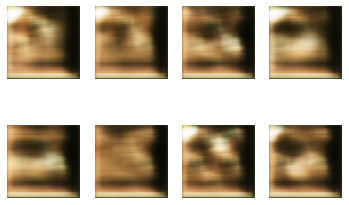

9001 [D loss: 0.993036, acc.: 89.06%, op_acc: 62.07%] [G loss: 1.004929]
9002 [D loss: 0.945413, acc.: 90.62%, op_acc: 63.40%] [G loss: 0.988983]
9003 [D loss: 0.906291, acc.: 95.31%, op_acc: 65.43%] [G loss: 0.980706]
9004 [D loss: 0.834977, acc.: 93.75%, op_acc: 64.18%] [G loss: 1.000148]
9005 [D loss: 0.757362, acc.: 95.31%, op_acc: 64.18%] [G loss: 0.982291]
9006 [D loss: 0.871626, acc.: 87.50%, op_acc: 66.68%] [G loss: 0.964219]
9007 [D loss: 0.745167, acc.: 96.88%, op_acc: 65.51%] [G loss: 0.972346]
9008 [D loss: 0.723714, acc.: 96.88%, op_acc: 66.87%] [G loss: 0.966328]
9009 [D loss: 0.797873, acc.: 90.62%, op_acc: 67.11%] [G loss: 0.972994]
9010 [D loss: 0.972705, acc.: 87.50%, op_acc: 65.20%] [G loss: 0.962456]
9011 [D loss: 0.908571, acc.: 93.75%, op_acc: 65.27%] [G loss: 0.964892]
9012 [D loss: 0.889032, acc.: 92.19%, op_acc: 65.16%] [G loss: 0.936255]
9013 [D loss: 0.922751, acc.: 92.19%, op_acc: 65.23%] [G loss: 0.985329]
9014 [D loss: 0.786856, acc.: 92.19%, op_acc: 66.80

9114 [D loss: 0.820605, acc.: 93.75%, op_acc: 66.02%] [G loss: 0.895638]
9115 [D loss: 0.746066, acc.: 96.88%, op_acc: 64.10%] [G loss: 0.942233]
9116 [D loss: 0.790478, acc.: 96.88%, op_acc: 64.65%] [G loss: 0.928098]
9117 [D loss: 0.767093, acc.: 96.88%, op_acc: 65.31%] [G loss: 0.907880]
9118 [D loss: 1.121041, acc.: 73.44%, op_acc: 64.73%] [G loss: 0.884041]
9119 [D loss: 1.073559, acc.: 85.94%, op_acc: 60.90%] [G loss: 0.911502]
9120 [D loss: 0.912306, acc.: 89.06%, op_acc: 64.69%] [G loss: 0.963245]
9121 [D loss: 1.016439, acc.: 81.25%, op_acc: 62.42%] [G loss: 0.898261]
9122 [D loss: 0.826918, acc.: 95.31%, op_acc: 64.10%] [G loss: 0.938213]
9123 [D loss: 1.112484, acc.: 82.81%, op_acc: 63.59%] [G loss: 0.898235]
9124 [D loss: 0.832563, acc.: 93.75%, op_acc: 65.08%] [G loss: 0.920709]
9125 [D loss: 0.814232, acc.: 93.75%, op_acc: 66.45%] [G loss: 0.901650]
9126 [D loss: 0.933741, acc.: 89.06%, op_acc: 64.84%] [G loss: 0.890898]
9127 [D loss: 0.843990, acc.: 92.19%, op_acc: 66.76

9226 [D loss: 0.618118, acc.: 100.00%, op_acc: 65.86%] [G loss: 0.983427]
9227 [D loss: 0.743497, acc.: 96.88%, op_acc: 66.37%] [G loss: 1.003423]
9228 [D loss: 0.611339, acc.: 100.00%, op_acc: 66.68%] [G loss: 0.985814]
9229 [D loss: 0.762312, acc.: 95.31%, op_acc: 66.29%] [G loss: 1.079431]
9230 [D loss: 0.643725, acc.: 100.00%, op_acc: 65.20%] [G loss: 0.905909]
9231 [D loss: 0.671713, acc.: 96.88%, op_acc: 65.70%] [G loss: 0.913515]
9232 [D loss: 0.709709, acc.: 93.75%, op_acc: 64.49%] [G loss: 0.888271]
9233 [D loss: 0.632305, acc.: 100.00%, op_acc: 65.62%] [G loss: 0.922933]
9234 [D loss: 0.624043, acc.: 100.00%, op_acc: 66.33%] [G loss: 0.925407]
9235 [D loss: 0.634358, acc.: 98.44%, op_acc: 65.62%] [G loss: 0.982617]
9236 [D loss: 0.680562, acc.: 98.44%, op_acc: 66.17%] [G loss: 0.910548]
9237 [D loss: 0.667433, acc.: 98.44%, op_acc: 66.60%] [G loss: 0.959713]
9238 [D loss: 0.622959, acc.: 100.00%, op_acc: 65.74%] [G loss: 0.887359]
9239 [D loss: 0.624127, acc.: 100.00%, op_acc

9338 [D loss: 0.611160, acc.: 98.44%, op_acc: 66.56%] [G loss: 0.821188]
9339 [D loss: 0.595395, acc.: 100.00%, op_acc: 67.93%] [G loss: 0.785984]
9340 [D loss: 0.610976, acc.: 96.88%, op_acc: 68.05%] [G loss: 0.861259]
9341 [D loss: 0.610784, acc.: 100.00%, op_acc: 65.86%] [G loss: 0.806629]
9342 [D loss: 0.571219, acc.: 100.00%, op_acc: 67.66%] [G loss: 0.861315]
9343 [D loss: 0.577807, acc.: 100.00%, op_acc: 68.55%] [G loss: 0.885178]
9344 [D loss: 0.612843, acc.: 100.00%, op_acc: 66.87%] [G loss: 0.847146]
9345 [D loss: 0.665669, acc.: 98.44%, op_acc: 66.41%] [G loss: 0.822890]
9346 [D loss: 0.633914, acc.: 100.00%, op_acc: 64.73%] [G loss: 0.915793]
9347 [D loss: 1.114513, acc.: 70.31%, op_acc: 65.78%] [G loss: 0.885471]
9348 [D loss: 0.840430, acc.: 89.06%, op_acc: 66.87%] [G loss: 1.046488]
9349 [D loss: 0.671287, acc.: 98.44%, op_acc: 67.66%] [G loss: 0.868609]
9350 [D loss: 0.652487, acc.: 98.44%, op_acc: 66.33%] [G loss: 0.962705]
9351 [D loss: 0.891632, acc.: 85.94%, op_acc:

9452 [D loss: 1.183360, acc.: 78.12%, op_acc: 66.60%] [G loss: 1.059088]
9453 [D loss: 1.201703, acc.: 75.00%, op_acc: 65.62%] [G loss: 1.077877]
9454 [D loss: 1.184263, acc.: 82.81%, op_acc: 65.51%] [G loss: 1.072896]
9455 [D loss: 1.200960, acc.: 82.81%, op_acc: 64.22%] [G loss: 1.094149]
9456 [D loss: 1.168589, acc.: 92.19%, op_acc: 65.35%] [G loss: 1.071889]
9457 [D loss: 1.173414, acc.: 92.19%, op_acc: 66.64%] [G loss: 1.029097]
9458 [D loss: 1.149071, acc.: 84.38%, op_acc: 65.31%] [G loss: 1.043467]
9459 [D loss: 1.196929, acc.: 76.56%, op_acc: 64.06%] [G loss: 1.042675]
9460 [D loss: 1.209668, acc.: 71.88%, op_acc: 63.98%] [G loss: 1.027646]
9461 [D loss: 1.223881, acc.: 70.31%, op_acc: 65.74%] [G loss: 1.000734]
9462 [D loss: 1.204573, acc.: 51.56%, op_acc: 64.61%] [G loss: 0.996934]
9463 [D loss: 1.235507, acc.: 50.00%, op_acc: 65.98%] [G loss: 0.974381]
9464 [D loss: 1.254416, acc.: 54.69%, op_acc: 64.88%] [G loss: 0.993234]
9465 [D loss: 1.274562, acc.: 42.19%, op_acc: 64.61

9565 [D loss: 1.526735, acc.: 17.19%, op_acc: 66.05%] [G loss: 1.369292]
9566 [D loss: 1.488289, acc.: 12.50%, op_acc: 64.92%] [G loss: 1.389163]
9567 [D loss: 1.495573, acc.: 12.50%, op_acc: 64.92%] [G loss: 1.385301]
9568 [D loss: 1.439760, acc.: 20.31%, op_acc: 65.86%] [G loss: 1.366773]
9569 [D loss: 1.432489, acc.: 21.88%, op_acc: 64.88%] [G loss: 1.381481]
9570 [D loss: 1.371571, acc.: 32.81%, op_acc: 67.03%] [G loss: 1.393486]
9571 [D loss: 1.316844, acc.: 53.12%, op_acc: 64.92%] [G loss: 1.405099]
9572 [D loss: 1.338857, acc.: 43.75%, op_acc: 66.45%] [G loss: 1.397131]
9573 [D loss: 1.333067, acc.: 53.12%, op_acc: 65.39%] [G loss: 1.422050]
9574 [D loss: 1.275527, acc.: 84.38%, op_acc: 65.47%] [G loss: 1.417113]
9575 [D loss: 1.278441, acc.: 82.81%, op_acc: 64.96%] [G loss: 1.413817]
9576 [D loss: 1.263727, acc.: 76.56%, op_acc: 65.78%] [G loss: 1.434449]
9577 [D loss: 1.275900, acc.: 75.00%, op_acc: 65.27%] [G loss: 1.445788]
9578 [D loss: 1.245969, acc.: 87.50%, op_acc: 65.86

9679 [D loss: 0.804721, acc.: 93.75%, op_acc: 65.00%] [G loss: 0.945039]
9680 [D loss: 0.649827, acc.: 100.00%, op_acc: 66.56%] [G loss: 0.903033]
9681 [D loss: 0.632016, acc.: 100.00%, op_acc: 66.56%] [G loss: 0.890588]
9682 [D loss: 0.682654, acc.: 98.44%, op_acc: 66.76%] [G loss: 0.956235]
9683 [D loss: 0.664606, acc.: 98.44%, op_acc: 65.98%] [G loss: 0.904995]
9684 [D loss: 0.649611, acc.: 98.44%, op_acc: 65.08%] [G loss: 0.941464]
9685 [D loss: 0.681903, acc.: 98.44%, op_acc: 65.86%] [G loss: 0.914696]
9686 [D loss: 0.670164, acc.: 100.00%, op_acc: 66.37%] [G loss: 0.916871]
9687 [D loss: 0.629819, acc.: 100.00%, op_acc: 65.62%] [G loss: 0.951309]
9688 [D loss: 0.621757, acc.: 100.00%, op_acc: 66.52%] [G loss: 0.975773]
9689 [D loss: 0.605183, acc.: 100.00%, op_acc: 65.90%] [G loss: 0.932999]
9690 [D loss: 0.677101, acc.: 95.31%, op_acc: 66.02%] [G loss: 0.928696]
9691 [D loss: 0.658834, acc.: 96.88%, op_acc: 66.80%] [G loss: 0.939142]
9692 [D loss: 0.632257, acc.: 100.00%, op_acc

9791 [D loss: 0.611640, acc.: 98.44%, op_acc: 67.07%] [G loss: 0.801540]
9792 [D loss: 0.575286, acc.: 100.00%, op_acc: 65.47%] [G loss: 0.792029]
9793 [D loss: 0.567144, acc.: 100.00%, op_acc: 66.41%] [G loss: 0.854875]
9794 [D loss: 0.605273, acc.: 100.00%, op_acc: 65.86%] [G loss: 0.864314]
9795 [D loss: 0.591660, acc.: 98.44%, op_acc: 66.13%] [G loss: 0.810842]
9796 [D loss: 0.595963, acc.: 98.44%, op_acc: 66.21%] [G loss: 0.792459]
9797 [D loss: 0.604958, acc.: 100.00%, op_acc: 65.04%] [G loss: 0.777607]
9798 [D loss: 0.636931, acc.: 98.44%, op_acc: 66.37%] [G loss: 0.771386]
9799 [D loss: 0.575410, acc.: 100.00%, op_acc: 66.21%] [G loss: 0.783630]
9800 [D loss: 0.578193, acc.: 100.00%, op_acc: 67.15%] [G loss: 0.805250]
9801 [D loss: 0.561786, acc.: 100.00%, op_acc: 67.07%] [G loss: 0.782096]
9802 [D loss: 0.642810, acc.: 95.31%, op_acc: 65.90%] [G loss: 0.794425]
9803 [D loss: 0.572542, acc.: 100.00%, op_acc: 66.17%] [G loss: 0.782417]
9804 [D loss: 0.581368, acc.: 100.00%, op_a

9903 [D loss: 0.656059, acc.: 96.88%, op_acc: 65.86%] [G loss: 0.975106]
9904 [D loss: 0.575582, acc.: 100.00%, op_acc: 66.41%] [G loss: 0.938043]
9905 [D loss: 0.653167, acc.: 98.44%, op_acc: 67.15%] [G loss: 0.956729]
9906 [D loss: 0.644994, acc.: 98.44%, op_acc: 67.62%] [G loss: 0.944824]
9907 [D loss: 0.661042, acc.: 96.88%, op_acc: 67.38%] [G loss: 0.906059]
9908 [D loss: 0.614850, acc.: 100.00%, op_acc: 65.12%] [G loss: 0.934457]
9909 [D loss: 0.750501, acc.: 95.31%, op_acc: 64.92%] [G loss: 0.942354]
9910 [D loss: 0.636663, acc.: 95.31%, op_acc: 67.85%] [G loss: 0.885091]
9911 [D loss: 0.665307, acc.: 95.31%, op_acc: 65.66%] [G loss: 0.945121]
9912 [D loss: 0.611203, acc.: 100.00%, op_acc: 66.64%] [G loss: 0.902541]
9913 [D loss: 0.688097, acc.: 96.88%, op_acc: 66.48%] [G loss: 0.925033]
9914 [D loss: 0.587260, acc.: 100.00%, op_acc: 65.66%] [G loss: 0.927409]
9915 [D loss: 0.649229, acc.: 95.31%, op_acc: 67.77%] [G loss: 0.929317]
9916 [D loss: 0.587644, acc.: 100.00%, op_acc: 

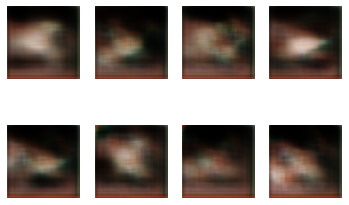

10001 [D loss: 1.260715, acc.: 70.31%, op_acc: 65.51%] [G loss: 2.764032]
10002 [D loss: 1.299613, acc.: 82.81%, op_acc: 63.01%] [G loss: 1.197679]
10003 [D loss: 0.919661, acc.: 90.62%, op_acc: 66.95%] [G loss: 1.760637]
10004 [D loss: 0.703628, acc.: 98.44%, op_acc: 65.04%] [G loss: 1.574295]
10005 [D loss: 0.788751, acc.: 95.31%, op_acc: 65.20%] [G loss: 1.164942]
10006 [D loss: 0.798501, acc.: 92.19%, op_acc: 63.95%] [G loss: 1.020480]
10007 [D loss: 0.709523, acc.: 100.00%, op_acc: 64.80%] [G loss: 1.022036]
10008 [D loss: 0.777679, acc.: 93.75%, op_acc: 65.16%] [G loss: 0.994495]
10009 [D loss: 0.647636, acc.: 100.00%, op_acc: 65.86%] [G loss: 1.045581]
10010 [D loss: 0.625872, acc.: 100.00%, op_acc: 64.41%] [G loss: 1.067717]
10011 [D loss: 0.672512, acc.: 98.44%, op_acc: 66.64%] [G loss: 0.988987]
10012 [D loss: 0.659960, acc.: 96.88%, op_acc: 65.59%] [G loss: 0.949721]
10013 [D loss: 0.693691, acc.: 98.44%, op_acc: 64.22%] [G loss: 0.986398]
10014 [D loss: 0.628813, acc.: 98.4

10113 [D loss: 1.015697, acc.: 87.50%, op_acc: 64.77%] [G loss: 0.908317]
10114 [D loss: 1.013364, acc.: 85.94%, op_acc: 64.38%] [G loss: 0.955459]
10115 [D loss: 0.803265, acc.: 92.19%, op_acc: 66.72%] [G loss: 0.890781]
10116 [D loss: 0.869891, acc.: 95.31%, op_acc: 66.80%] [G loss: 0.923516]
10117 [D loss: 0.831466, acc.: 92.19%, op_acc: 64.22%] [G loss: 0.932771]
10118 [D loss: 0.850456, acc.: 90.62%, op_acc: 66.52%] [G loss: 0.903348]
10119 [D loss: 0.909469, acc.: 89.06%, op_acc: 66.68%] [G loss: 0.911604]
10120 [D loss: 0.769524, acc.: 95.31%, op_acc: 65.74%] [G loss: 0.909614]
10121 [D loss: 0.959331, acc.: 85.94%, op_acc: 67.19%] [G loss: 0.904720]
10122 [D loss: 0.965309, acc.: 87.50%, op_acc: 64.57%] [G loss: 0.920295]
10123 [D loss: 0.811521, acc.: 93.75%, op_acc: 64.14%] [G loss: 0.943249]
10124 [D loss: 0.886146, acc.: 90.62%, op_acc: 66.13%] [G loss: 0.917856]
10125 [D loss: 0.809780, acc.: 92.19%, op_acc: 64.45%] [G loss: 0.962305]
10126 [D loss: 0.888357, acc.: 90.62%,

10225 [D loss: 1.029421, acc.: 84.38%, op_acc: 66.68%] [G loss: 1.148453]
10226 [D loss: 0.946442, acc.: 87.50%, op_acc: 66.37%] [G loss: 1.313766]
10227 [D loss: 1.259059, acc.: 70.31%, op_acc: 64.84%] [G loss: 1.251421]
10228 [D loss: 0.878441, acc.: 92.19%, op_acc: 66.37%] [G loss: 1.481673]
10229 [D loss: 0.986102, acc.: 87.50%, op_acc: 65.04%] [G loss: 1.314857]
10230 [D loss: 1.004720, acc.: 89.06%, op_acc: 66.64%] [G loss: 1.105895]
10231 [D loss: 1.050522, acc.: 87.50%, op_acc: 64.77%] [G loss: 1.136989]
10232 [D loss: 1.450943, acc.: 60.94%, op_acc: 64.80%] [G loss: 1.062625]
10233 [D loss: 1.074058, acc.: 87.50%, op_acc: 65.70%] [G loss: 1.168266]
10234 [D loss: 1.308674, acc.: 67.19%, op_acc: 63.36%] [G loss: 1.166057]
10235 [D loss: 1.026761, acc.: 90.62%, op_acc: 65.47%] [G loss: 1.170922]
10236 [D loss: 1.191915, acc.: 79.69%, op_acc: 63.32%] [G loss: 1.100978]
10237 [D loss: 1.001061, acc.: 92.19%, op_acc: 63.79%] [G loss: 1.014787]
10238 [D loss: 0.903860, acc.: 95.31%,

10337 [D loss: 0.718639, acc.: 96.88%, op_acc: 67.46%] [G loss: 0.953050]
10338 [D loss: 0.579236, acc.: 100.00%, op_acc: 67.50%] [G loss: 0.934467]
10339 [D loss: 0.637879, acc.: 98.44%, op_acc: 67.07%] [G loss: 0.935494]
10340 [D loss: 0.588955, acc.: 100.00%, op_acc: 67.03%] [G loss: 0.977589]
10341 [D loss: 0.588743, acc.: 100.00%, op_acc: 67.07%] [G loss: 0.973589]
10342 [D loss: 0.602089, acc.: 100.00%, op_acc: 66.29%] [G loss: 0.930948]
10343 [D loss: 0.632114, acc.: 96.88%, op_acc: 65.20%] [G loss: 0.995281]
10344 [D loss: 0.713929, acc.: 96.88%, op_acc: 65.55%] [G loss: 0.987201]
10345 [D loss: 0.826091, acc.: 90.62%, op_acc: 65.00%] [G loss: 1.083383]
10346 [D loss: 0.881728, acc.: 92.19%, op_acc: 66.33%] [G loss: 1.298079]
10347 [D loss: 2.197129, acc.: 43.75%, op_acc: 66.05%] [G loss: 7.721242]
10348 [D loss: 2.472414, acc.: 51.56%, op_acc: 56.56%] [G loss: 1.500876]
10349 [D loss: 1.385620, acc.: 48.44%, op_acc: 64.57%] [G loss: 1.196917]
10350 [D loss: 1.342117, acc.: 46.

10449 [D loss: 0.588437, acc.: 100.00%, op_acc: 65.27%] [G loss: 0.836141]
10450 [D loss: 0.611027, acc.: 100.00%, op_acc: 66.02%] [G loss: 0.867408]
10451 [D loss: 0.597716, acc.: 100.00%, op_acc: 66.33%] [G loss: 0.833415]
10452 [D loss: 0.615588, acc.: 100.00%, op_acc: 65.90%] [G loss: 0.830420]
10453 [D loss: 0.582072, acc.: 100.00%, op_acc: 66.17%] [G loss: 0.897789]
10454 [D loss: 0.598287, acc.: 100.00%, op_acc: 67.34%] [G loss: 0.868043]
10455 [D loss: 0.618151, acc.: 100.00%, op_acc: 65.70%] [G loss: 0.862195]
10456 [D loss: 0.627811, acc.: 98.44%, op_acc: 66.60%] [G loss: 0.857511]
10457 [D loss: 0.633939, acc.: 100.00%, op_acc: 65.66%] [G loss: 0.864556]
10458 [D loss: 0.575138, acc.: 100.00%, op_acc: 66.45%] [G loss: 0.874249]
10459 [D loss: 0.586984, acc.: 100.00%, op_acc: 67.97%] [G loss: 0.861988]
10460 [D loss: 0.667503, acc.: 96.88%, op_acc: 68.59%] [G loss: 0.825608]
10461 [D loss: 0.597456, acc.: 100.00%, op_acc: 67.03%] [G loss: 0.829868]
10462 [D loss: 0.649241, ac

10559 [D loss: 1.125741, acc.: 85.94%, op_acc: 64.92%] [G loss: 1.227507]
10560 [D loss: 1.102769, acc.: 81.25%, op_acc: 65.04%] [G loss: 1.203065]
10561 [D loss: 0.978982, acc.: 93.75%, op_acc: 65.55%] [G loss: 1.224684]
10562 [D loss: 1.117655, acc.: 84.38%, op_acc: 66.05%] [G loss: 1.160753]
10563 [D loss: 1.002912, acc.: 92.19%, op_acc: 64.92%] [G loss: 1.203202]
10564 [D loss: 1.072378, acc.: 87.50%, op_acc: 64.02%] [G loss: 1.166198]
10565 [D loss: 0.964445, acc.: 87.50%, op_acc: 66.05%] [G loss: 1.145520]
10566 [D loss: 1.024324, acc.: 90.62%, op_acc: 66.13%] [G loss: 1.155874]
10567 [D loss: 1.059801, acc.: 84.38%, op_acc: 65.90%] [G loss: 1.100082]
10568 [D loss: 1.157875, acc.: 78.12%, op_acc: 66.56%] [G loss: 1.058414]
10569 [D loss: 0.936453, acc.: 95.31%, op_acc: 66.25%] [G loss: 1.064258]
10570 [D loss: 1.007300, acc.: 87.50%, op_acc: 66.21%] [G loss: 1.025929]
10571 [D loss: 1.042403, acc.: 85.94%, op_acc: 66.80%] [G loss: 1.007931]
10572 [D loss: 1.121973, acc.: 79.69%,

10669 [D loss: 0.627243, acc.: 98.44%, op_acc: 65.98%] [G loss: 1.110439]
10670 [D loss: 0.739282, acc.: 95.31%, op_acc: 65.51%] [G loss: 1.115485]
10671 [D loss: 0.793289, acc.: 95.31%, op_acc: 67.54%] [G loss: 1.028668]
10672 [D loss: 0.686867, acc.: 98.44%, op_acc: 65.94%] [G loss: 1.037318]
10673 [D loss: 0.640158, acc.: 96.88%, op_acc: 64.69%] [G loss: 1.112714]
10674 [D loss: 0.606055, acc.: 100.00%, op_acc: 67.03%] [G loss: 1.150358]
10675 [D loss: 0.656771, acc.: 98.44%, op_acc: 66.21%] [G loss: 1.101917]
10676 [D loss: 0.671667, acc.: 100.00%, op_acc: 66.17%] [G loss: 1.010450]
10677 [D loss: 0.666113, acc.: 98.44%, op_acc: 65.82%] [G loss: 1.034289]
10678 [D loss: 0.642885, acc.: 100.00%, op_acc: 65.94%] [G loss: 1.220328]
10679 [D loss: 0.688203, acc.: 100.00%, op_acc: 66.05%] [G loss: 1.050536]
10680 [D loss: 0.805372, acc.: 93.75%, op_acc: 64.49%] [G loss: 1.082166]
10681 [D loss: 0.829669, acc.: 95.31%, op_acc: 65.43%] [G loss: 1.101895]
10682 [D loss: 0.860873, acc.: 90.

10781 [D loss: 0.607545, acc.: 98.44%, op_acc: 66.37%] [G loss: 0.869178]
10782 [D loss: 0.571826, acc.: 98.44%, op_acc: 68.01%] [G loss: 0.895502]
10783 [D loss: 0.641488, acc.: 96.88%, op_acc: 66.45%] [G loss: 0.884886]
10784 [D loss: 0.573800, acc.: 100.00%, op_acc: 67.19%] [G loss: 0.871687]
10785 [D loss: 0.589657, acc.: 100.00%, op_acc: 67.50%] [G loss: 0.855724]
10786 [D loss: 0.584807, acc.: 100.00%, op_acc: 65.31%] [G loss: 0.861700]
10787 [D loss: 0.595994, acc.: 100.00%, op_acc: 66.13%] [G loss: 0.859653]
10788 [D loss: 0.586610, acc.: 100.00%, op_acc: 67.07%] [G loss: 0.839525]
10789 [D loss: 0.630479, acc.: 98.44%, op_acc: 67.38%] [G loss: 0.848190]
10790 [D loss: 0.561935, acc.: 100.00%, op_acc: 67.89%] [G loss: 0.852821]
10791 [D loss: 0.600643, acc.: 98.44%, op_acc: 67.42%] [G loss: 0.874180]
10792 [D loss: 0.592549, acc.: 98.44%, op_acc: 67.62%] [G loss: 0.891985]
10793 [D loss: 0.582263, acc.: 100.00%, op_acc: 67.11%] [G loss: 0.846576]
10794 [D loss: 0.569436, acc.: 

10891 [D loss: 0.702223, acc.: 96.88%, op_acc: 65.82%] [G loss: 0.925767]
10892 [D loss: 0.687995, acc.: 96.88%, op_acc: 65.62%] [G loss: 0.910653]
10893 [D loss: 0.675533, acc.: 98.44%, op_acc: 64.96%] [G loss: 0.982946]
10894 [D loss: 0.601956, acc.: 100.00%, op_acc: 66.33%] [G loss: 0.962358]
10895 [D loss: 0.755854, acc.: 93.75%, op_acc: 64.84%] [G loss: 0.928948]
10896 [D loss: 0.643182, acc.: 100.00%, op_acc: 66.64%] [G loss: 0.896181]
10897 [D loss: 0.605995, acc.: 98.44%, op_acc: 66.29%] [G loss: 0.970940]
10898 [D loss: 0.633866, acc.: 98.44%, op_acc: 65.78%] [G loss: 0.977358]
10899 [D loss: 0.642383, acc.: 98.44%, op_acc: 66.41%] [G loss: 0.928031]
10900 [D loss: 0.632208, acc.: 98.44%, op_acc: 66.21%] [G loss: 0.936936]
10901 [D loss: 0.594930, acc.: 100.00%, op_acc: 66.09%] [G loss: 0.978449]
10902 [D loss: 0.603947, acc.: 100.00%, op_acc: 66.64%] [G loss: 0.966494]
10903 [D loss: 0.639250, acc.: 98.44%, op_acc: 65.39%] [G loss: 0.949151]
10904 [D loss: 0.611131, acc.: 98.

(8, 64, 64, 3)


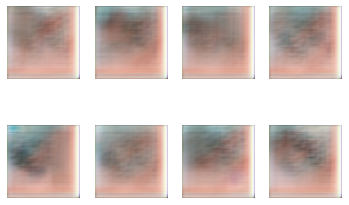

11001 [D loss: 0.579477, acc.: 100.00%, op_acc: 66.21%] [G loss: 0.992218]
11002 [D loss: 0.572379, acc.: 100.00%, op_acc: 67.03%] [G loss: 1.048679]
11003 [D loss: 0.609179, acc.: 98.44%, op_acc: 66.99%] [G loss: 1.032990]
11004 [D loss: 0.620592, acc.: 98.44%, op_acc: 66.17%] [G loss: 1.032953]
11005 [D loss: 0.600983, acc.: 100.00%, op_acc: 65.90%] [G loss: 1.016045]
11006 [D loss: 0.589642, acc.: 100.00%, op_acc: 65.43%] [G loss: 1.075365]
11007 [D loss: 0.596979, acc.: 100.00%, op_acc: 65.70%] [G loss: 1.021402]
11008 [D loss: 0.594139, acc.: 100.00%, op_acc: 66.99%] [G loss: 1.023480]
11009 [D loss: 0.645400, acc.: 98.44%, op_acc: 67.03%] [G loss: 1.030549]
11010 [D loss: 0.576916, acc.: 100.00%, op_acc: 67.50%] [G loss: 0.997263]
11011 [D loss: 0.574704, acc.: 100.00%, op_acc: 67.19%] [G loss: 1.026199]
11012 [D loss: 0.601859, acc.: 100.00%, op_acc: 64.49%] [G loss: 1.070582]
11013 [D loss: 0.587457, acc.: 100.00%, op_acc: 65.78%] [G loss: 1.078784]
11014 [D loss: 0.650465, acc

11113 [D loss: 0.572777, acc.: 100.00%, op_acc: 66.95%] [G loss: 0.937348]
11114 [D loss: 0.607965, acc.: 98.44%, op_acc: 66.56%] [G loss: 0.905161]
11115 [D loss: 0.571283, acc.: 100.00%, op_acc: 66.80%] [G loss: 0.903726]
11116 [D loss: 0.563229, acc.: 100.00%, op_acc: 68.71%] [G loss: 0.964775]
11117 [D loss: 0.591398, acc.: 100.00%, op_acc: 66.45%] [G loss: 0.917101]
11118 [D loss: 0.594121, acc.: 98.44%, op_acc: 66.60%] [G loss: 0.927092]
11119 [D loss: 0.637249, acc.: 96.88%, op_acc: 67.34%] [G loss: 0.942722]
11120 [D loss: 0.566590, acc.: 100.00%, op_acc: 66.29%] [G loss: 0.909470]
11121 [D loss: 0.573799, acc.: 100.00%, op_acc: 66.41%] [G loss: 0.891170]
11122 [D loss: 0.567352, acc.: 100.00%, op_acc: 67.11%] [G loss: 0.902544]
11123 [D loss: 0.578674, acc.: 100.00%, op_acc: 66.91%] [G loss: 0.954068]
11124 [D loss: 0.603271, acc.: 100.00%, op_acc: 67.27%] [G loss: 0.903887]
11125 [D loss: 0.620331, acc.: 98.44%, op_acc: 65.98%] [G loss: 0.927844]
11126 [D loss: 0.664718, acc.

11225 [D loss: 0.729783, acc.: 95.31%, op_acc: 65.59%] [G loss: 0.852620]
11226 [D loss: 0.709071, acc.: 96.88%, op_acc: 66.17%] [G loss: 0.844541]
11227 [D loss: 0.726165, acc.: 96.88%, op_acc: 65.23%] [G loss: 0.865183]
11228 [D loss: 0.800364, acc.: 96.88%, op_acc: 63.16%] [G loss: 0.847818]
11229 [D loss: 0.734137, acc.: 96.88%, op_acc: 66.05%] [G loss: 0.829943]
11230 [D loss: 0.628343, acc.: 100.00%, op_acc: 67.77%] [G loss: 0.821042]
11231 [D loss: 0.780836, acc.: 92.19%, op_acc: 64.65%] [G loss: 0.835701]
11232 [D loss: 0.690653, acc.: 95.31%, op_acc: 68.01%] [G loss: 0.823081]
11233 [D loss: 0.703976, acc.: 95.31%, op_acc: 66.95%] [G loss: 0.818863]
11234 [D loss: 0.649464, acc.: 100.00%, op_acc: 65.55%] [G loss: 0.798474]
11235 [D loss: 0.794167, acc.: 93.75%, op_acc: 65.78%] [G loss: 0.824962]
11236 [D loss: 0.689029, acc.: 96.88%, op_acc: 67.62%] [G loss: 0.862930]
11237 [D loss: 0.904194, acc.: 95.31%, op_acc: 63.40%] [G loss: 0.823932]
11238 [D loss: 0.671155, acc.: 98.44

11337 [D loss: 0.588683, acc.: 100.00%, op_acc: 65.47%] [G loss: 1.001638]
11338 [D loss: 0.603186, acc.: 100.00%, op_acc: 65.86%] [G loss: 0.964067]
11339 [D loss: 0.599486, acc.: 98.44%, op_acc: 67.89%] [G loss: 0.958912]
11340 [D loss: 0.583420, acc.: 98.44%, op_acc: 66.87%] [G loss: 0.949725]
11341 [D loss: 0.597142, acc.: 98.44%, op_acc: 67.27%] [G loss: 1.008757]
11342 [D loss: 0.565799, acc.: 100.00%, op_acc: 66.91%] [G loss: 0.914918]
11343 [D loss: 0.641763, acc.: 96.88%, op_acc: 67.62%] [G loss: 0.914294]
11344 [D loss: 0.582399, acc.: 100.00%, op_acc: 66.64%] [G loss: 0.956864]
11345 [D loss: 0.603684, acc.: 98.44%, op_acc: 66.91%] [G loss: 0.956533]
11346 [D loss: 0.628654, acc.: 96.88%, op_acc: 67.11%] [G loss: 0.925159]
11347 [D loss: 0.615052, acc.: 98.44%, op_acc: 69.14%] [G loss: 0.948867]
11348 [D loss: 0.590178, acc.: 98.44%, op_acc: 66.37%] [G loss: 0.903508]
11349 [D loss: 0.590698, acc.: 100.00%, op_acc: 65.43%] [G loss: 0.912372]
11350 [D loss: 0.638216, acc.: 98

11447 [D loss: 0.561769, acc.: 100.00%, op_acc: 67.30%] [G loss: 0.900122]
11448 [D loss: 0.602342, acc.: 98.44%, op_acc: 66.45%] [G loss: 0.892103]
11449 [D loss: 0.588886, acc.: 100.00%, op_acc: 67.58%] [G loss: 0.883951]
11450 [D loss: 0.559758, acc.: 100.00%, op_acc: 67.11%] [G loss: 0.867831]
11451 [D loss: 0.561085, acc.: 100.00%, op_acc: 67.50%] [G loss: 0.927658]
11452 [D loss: 0.614033, acc.: 98.44%, op_acc: 67.54%] [G loss: 0.923376]
11453 [D loss: 0.571288, acc.: 100.00%, op_acc: 67.62%] [G loss: 0.873778]
11454 [D loss: 0.572174, acc.: 100.00%, op_acc: 67.07%] [G loss: 0.945441]
11455 [D loss: 0.582061, acc.: 100.00%, op_acc: 68.20%] [G loss: 0.912279]
11456 [D loss: 0.576456, acc.: 100.00%, op_acc: 65.47%] [G loss: 0.849058]
11457 [D loss: 0.571725, acc.: 100.00%, op_acc: 66.80%] [G loss: 0.892802]
11458 [D loss: 0.579819, acc.: 100.00%, op_acc: 67.93%] [G loss: 0.903029]
11459 [D loss: 0.594616, acc.: 100.00%, op_acc: 66.13%] [G loss: 0.929268]
11460 [D loss: 0.597018, ac

11558 [D loss: 1.602647, acc.: 64.06%, op_acc: 62.66%] [G loss: 1.444671]
11559 [D loss: 1.252282, acc.: 76.56%, op_acc: 65.27%] [G loss: 1.072307]
11560 [D loss: 0.933610, acc.: 93.75%, op_acc: 65.04%] [G loss: 1.070082]
11561 [D loss: 0.734668, acc.: 100.00%, op_acc: 64.02%] [G loss: 1.138014]
11562 [D loss: 0.861586, acc.: 90.62%, op_acc: 65.20%] [G loss: 1.105500]
11563 [D loss: 0.853313, acc.: 92.19%, op_acc: 66.25%] [G loss: 1.045633]
11564 [D loss: 0.872770, acc.: 96.88%, op_acc: 65.08%] [G loss: 1.043255]
11565 [D loss: 0.741182, acc.: 96.88%, op_acc: 66.17%] [G loss: 1.013718]
11566 [D loss: 0.787688, acc.: 93.75%, op_acc: 65.20%] [G loss: 0.992908]
11567 [D loss: 0.877549, acc.: 93.75%, op_acc: 65.82%] [G loss: 0.964068]
11568 [D loss: 0.733646, acc.: 95.31%, op_acc: 65.08%] [G loss: 0.971979]
11569 [D loss: 0.809508, acc.: 95.31%, op_acc: 65.00%] [G loss: 0.984683]
11570 [D loss: 0.824276, acc.: 92.19%, op_acc: 63.71%] [G loss: 1.010442]
11571 [D loss: 0.830939, acc.: 95.31%

11670 [D loss: 0.798795, acc.: 93.75%, op_acc: 65.51%] [G loss: 0.960116]
11671 [D loss: 0.721829, acc.: 98.44%, op_acc: 65.78%] [G loss: 0.949052]
11672 [D loss: 0.691599, acc.: 100.00%, op_acc: 65.12%] [G loss: 0.953437]
11673 [D loss: 0.691432, acc.: 98.44%, op_acc: 65.16%] [G loss: 0.951151]
11674 [D loss: 0.718354, acc.: 96.88%, op_acc: 65.98%] [G loss: 0.933860]
11675 [D loss: 0.678425, acc.: 98.44%, op_acc: 65.27%] [G loss: 0.951640]
11676 [D loss: 0.685950, acc.: 100.00%, op_acc: 65.70%] [G loss: 0.932704]
11677 [D loss: 0.684556, acc.: 96.88%, op_acc: 65.98%] [G loss: 0.928651]
11678 [D loss: 0.633317, acc.: 98.44%, op_acc: 66.21%] [G loss: 0.930464]
11679 [D loss: 0.654305, acc.: 96.88%, op_acc: 65.70%] [G loss: 0.933848]
11680 [D loss: 0.673821, acc.: 96.88%, op_acc: 64.69%] [G loss: 0.942275]
11681 [D loss: 0.638378, acc.: 98.44%, op_acc: 65.55%] [G loss: 0.950955]
11682 [D loss: 0.648259, acc.: 98.44%, op_acc: 65.12%] [G loss: 0.916195]
11683 [D loss: 0.637909, acc.: 98.44

11782 [D loss: 1.073750, acc.: 68.75%, op_acc: 66.21%] [G loss: 4.664861]
11783 [D loss: 2.896716, acc.: 23.44%, op_acc: 57.73%] [G loss: 1.195164]
11784 [D loss: 1.082698, acc.: 79.69%, op_acc: 65.59%] [G loss: 1.483195]
11785 [D loss: 1.125129, acc.: 85.94%, op_acc: 67.11%] [G loss: 1.305402]
11786 [D loss: 1.032773, acc.: 87.50%, op_acc: 64.61%] [G loss: 1.293309]
11787 [D loss: 1.221787, acc.: 78.12%, op_acc: 64.84%] [G loss: 1.116902]
11788 [D loss: 1.117874, acc.: 81.25%, op_acc: 65.27%] [G loss: 1.075063]
11789 [D loss: 0.911102, acc.: 90.62%, op_acc: 64.69%] [G loss: 1.040780]
11790 [D loss: 0.855895, acc.: 95.31%, op_acc: 65.90%] [G loss: 0.993065]
11791 [D loss: 0.873533, acc.: 92.19%, op_acc: 65.00%] [G loss: 0.955224]
11792 [D loss: 0.786772, acc.: 95.31%, op_acc: 65.94%] [G loss: 0.965468]
11793 [D loss: 0.813149, acc.: 93.75%, op_acc: 66.91%] [G loss: 0.901421]
11794 [D loss: 0.871447, acc.: 92.19%, op_acc: 66.25%] [G loss: 0.891282]
11795 [D loss: 0.730708, acc.: 98.44%,

11892 [D loss: 0.902193, acc.: 92.19%, op_acc: 64.69%] [G loss: 0.955332]
11893 [D loss: 0.895700, acc.: 90.62%, op_acc: 64.73%] [G loss: 0.906551]
11894 [D loss: 0.773920, acc.: 95.31%, op_acc: 65.43%] [G loss: 0.902684]
11895 [D loss: 0.754875, acc.: 93.75%, op_acc: 66.48%] [G loss: 0.903101]
11896 [D loss: 0.670185, acc.: 96.88%, op_acc: 65.94%] [G loss: 0.891669]
11897 [D loss: 0.775904, acc.: 89.06%, op_acc: 64.30%] [G loss: 0.930528]
11898 [D loss: 0.631575, acc.: 98.44%, op_acc: 65.59%] [G loss: 0.888611]
11899 [D loss: 0.672273, acc.: 95.31%, op_acc: 65.12%] [G loss: 0.879628]
11900 [D loss: 0.773996, acc.: 93.75%, op_acc: 65.66%] [G loss: 0.901403]
11901 [D loss: 0.720373, acc.: 98.44%, op_acc: 63.28%] [G loss: 0.915943]
11902 [D loss: 0.763986, acc.: 95.31%, op_acc: 66.17%] [G loss: 0.883448]
11903 [D loss: 0.792163, acc.: 95.31%, op_acc: 64.57%] [G loss: 0.905854]
11904 [D loss: 0.611591, acc.: 100.00%, op_acc: 65.86%] [G loss: 0.886887]
11905 [D loss: 0.702356, acc.: 96.88%

(8, 64, 64, 3)


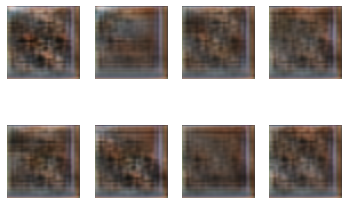

12001 [D loss: 0.568506, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.929816]
12002 [D loss: 0.562538, acc.: 100.00%, op_acc: 66.45%] [G loss: 0.967680]
12003 [D loss: 0.576097, acc.: 98.44%, op_acc: 67.81%] [G loss: 0.982188]
12004 [D loss: 0.577378, acc.: 100.00%, op_acc: 66.72%] [G loss: 0.887454]
12005 [D loss: 0.559561, acc.: 100.00%, op_acc: 67.03%] [G loss: 0.943730]
12006 [D loss: 0.569232, acc.: 100.00%, op_acc: 66.60%] [G loss: 0.964829]
12007 [D loss: 0.587420, acc.: 100.00%, op_acc: 65.08%] [G loss: 0.936917]
12008 [D loss: 0.577870, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.997833]
12009 [D loss: 0.598482, acc.: 100.00%, op_acc: 67.27%] [G loss: 0.956351]
12010 [D loss: 0.594183, acc.: 100.00%, op_acc: 66.41%] [G loss: 0.937798]
12011 [D loss: 0.562188, acc.: 100.00%, op_acc: 67.46%] [G loss: 0.941795]
12012 [D loss: 0.546616, acc.: 100.00%, op_acc: 69.34%] [G loss: 0.922167]
12013 [D loss: 0.597146, acc.: 100.00%, op_acc: 65.04%] [G loss: 0.971129]
12014 [D loss: 0.571482, a

12111 [D loss: 1.325163, acc.: 79.69%, op_acc: 64.22%] [G loss: 1.012536]
12112 [D loss: 1.245066, acc.: 82.81%, op_acc: 65.66%] [G loss: 0.983941]
12113 [D loss: 1.175831, acc.: 87.50%, op_acc: 63.36%] [G loss: 0.987635]
12114 [D loss: 1.236181, acc.: 89.06%, op_acc: 64.14%] [G loss: 1.002459]
12115 [D loss: 0.921161, acc.: 90.62%, op_acc: 64.92%] [G loss: 1.029760]
12116 [D loss: 1.182963, acc.: 81.25%, op_acc: 64.26%] [G loss: 0.983992]
12117 [D loss: 0.968501, acc.: 89.06%, op_acc: 65.20%] [G loss: 1.033794]
12118 [D loss: 0.873934, acc.: 95.31%, op_acc: 65.12%] [G loss: 1.028920]
12119 [D loss: 1.159699, acc.: 79.69%, op_acc: 65.78%] [G loss: 1.019789]
12120 [D loss: 1.355901, acc.: 70.31%, op_acc: 65.12%] [G loss: 1.029905]
12121 [D loss: 1.075207, acc.: 82.81%, op_acc: 65.12%] [G loss: 1.075801]
12122 [D loss: 1.098867, acc.: 85.94%, op_acc: 65.98%] [G loss: 1.052918]
12123 [D loss: 1.268076, acc.: 78.12%, op_acc: 63.79%] [G loss: 1.040410]
12124 [D loss: 1.081618, acc.: 85.94%,

12221 [D loss: 0.588396, acc.: 100.00%, op_acc: 65.86%] [G loss: 0.879921]
12222 [D loss: 0.590714, acc.: 100.00%, op_acc: 64.10%] [G loss: 0.905231]
12223 [D loss: 0.575834, acc.: 100.00%, op_acc: 65.78%] [G loss: 0.885062]
12224 [D loss: 0.607954, acc.: 100.00%, op_acc: 66.21%] [G loss: 0.883364]
12225 [D loss: 0.603950, acc.: 100.00%, op_acc: 66.17%] [G loss: 0.900939]
12226 [D loss: 0.574060, acc.: 100.00%, op_acc: 66.29%] [G loss: 0.864162]
12227 [D loss: 0.604684, acc.: 100.00%, op_acc: 65.47%] [G loss: 0.906333]
12228 [D loss: 0.613618, acc.: 96.88%, op_acc: 66.09%] [G loss: 0.916137]
12229 [D loss: 0.585967, acc.: 100.00%, op_acc: 64.41%] [G loss: 0.877987]
12230 [D loss: 0.571076, acc.: 100.00%, op_acc: 66.68%] [G loss: 0.838144]
12231 [D loss: 0.606685, acc.: 100.00%, op_acc: 63.95%] [G loss: 0.925868]
12232 [D loss: 0.615562, acc.: 100.00%, op_acc: 65.62%] [G loss: 0.883247]
12233 [D loss: 0.590268, acc.: 100.00%, op_acc: 65.00%] [G loss: 0.910396]
12234 [D loss: 0.653866, a

12331 [D loss: 0.624819, acc.: 98.44%, op_acc: 66.72%] [G loss: 0.897606]
12332 [D loss: 0.574433, acc.: 100.00%, op_acc: 67.34%] [G loss: 0.878409]
12333 [D loss: 0.586407, acc.: 100.00%, op_acc: 65.39%] [G loss: 0.880980]
12334 [D loss: 0.600655, acc.: 98.44%, op_acc: 66.95%] [G loss: 0.902486]
12335 [D loss: 0.622864, acc.: 96.88%, op_acc: 64.61%] [G loss: 0.901881]
12336 [D loss: 0.581726, acc.: 100.00%, op_acc: 66.80%] [G loss: 0.870172]
12337 [D loss: 0.586331, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.899184]
12338 [D loss: 0.591121, acc.: 100.00%, op_acc: 66.60%] [G loss: 0.919039]
12339 [D loss: 0.613101, acc.: 98.44%, op_acc: 65.43%] [G loss: 0.926118]
12340 [D loss: 0.578833, acc.: 100.00%, op_acc: 66.17%] [G loss: 0.917447]
12341 [D loss: 0.572813, acc.: 100.00%, op_acc: 66.64%] [G loss: 0.947600]
12342 [D loss: 0.614208, acc.: 98.44%, op_acc: 67.54%] [G loss: 0.918575]
12343 [D loss: 0.575311, acc.: 100.00%, op_acc: 67.19%] [G loss: 0.906739]
12344 [D loss: 0.595018, acc.:

12441 [D loss: 0.570779, acc.: 100.00%, op_acc: 67.54%] [G loss: 0.900371]
12442 [D loss: 0.572533, acc.: 98.44%, op_acc: 67.89%] [G loss: 0.896115]
12443 [D loss: 0.609894, acc.: 98.44%, op_acc: 66.56%] [G loss: 0.911297]
12444 [D loss: 0.587892, acc.: 100.00%, op_acc: 66.37%] [G loss: 0.905198]
12445 [D loss: 0.556098, acc.: 100.00%, op_acc: 67.89%] [G loss: 0.900168]
12446 [D loss: 0.561144, acc.: 100.00%, op_acc: 67.42%] [G loss: 0.905728]
12447 [D loss: 0.570595, acc.: 100.00%, op_acc: 67.50%] [G loss: 0.890820]
12448 [D loss: 0.577763, acc.: 100.00%, op_acc: 66.68%] [G loss: 0.939847]
12449 [D loss: 0.573660, acc.: 100.00%, op_acc: 66.37%] [G loss: 0.891772]
12450 [D loss: 0.601746, acc.: 100.00%, op_acc: 67.77%] [G loss: 0.906376]
12451 [D loss: 0.576490, acc.: 100.00%, op_acc: 66.99%] [G loss: 0.916794]
12452 [D loss: 0.571999, acc.: 100.00%, op_acc: 65.62%] [G loss: 0.933101]
12453 [D loss: 0.582094, acc.: 100.00%, op_acc: 66.45%] [G loss: 0.909308]
12454 [D loss: 0.577808, ac

12551 [D loss: 0.582510, acc.: 98.44%, op_acc: 67.30%] [G loss: 0.865932]
12552 [D loss: 0.582393, acc.: 100.00%, op_acc: 65.78%] [G loss: 0.821220]
12553 [D loss: 0.563650, acc.: 100.00%, op_acc: 65.78%] [G loss: 0.842876]
12554 [D loss: 0.628926, acc.: 96.88%, op_acc: 66.68%] [G loss: 0.895386]
12555 [D loss: 0.580217, acc.: 98.44%, op_acc: 66.05%] [G loss: 0.853952]
12556 [D loss: 0.575093, acc.: 100.00%, op_acc: 67.34%] [G loss: 0.819428]
12557 [D loss: 0.572006, acc.: 100.00%, op_acc: 66.56%] [G loss: 0.850075]
12558 [D loss: 0.572093, acc.: 100.00%, op_acc: 65.98%] [G loss: 0.856079]
12559 [D loss: 0.561448, acc.: 100.00%, op_acc: 67.46%] [G loss: 0.954794]
12560 [D loss: 0.592960, acc.: 100.00%, op_acc: 67.62%] [G loss: 0.864378]
12561 [D loss: 0.564184, acc.: 100.00%, op_acc: 67.97%] [G loss: 0.894942]
12562 [D loss: 0.605085, acc.: 100.00%, op_acc: 66.95%] [G loss: 0.915864]
12563 [D loss: 0.585012, acc.: 100.00%, op_acc: 66.33%] [G loss: 0.947162]
12564 [D loss: 0.563637, acc

12661 [D loss: 0.582217, acc.: 100.00%, op_acc: 67.23%] [G loss: 0.943826]
12662 [D loss: 0.620273, acc.: 96.88%, op_acc: 67.54%] [G loss: 0.937695]
12663 [D loss: 0.604304, acc.: 100.00%, op_acc: 69.06%] [G loss: 0.880126]
12664 [D loss: 0.586177, acc.: 100.00%, op_acc: 66.52%] [G loss: 0.925550]
12665 [D loss: 0.659979, acc.: 96.88%, op_acc: 67.58%] [G loss: 0.857044]
12666 [D loss: 0.614176, acc.: 100.00%, op_acc: 64.22%] [G loss: 0.916197]
12667 [D loss: 0.587866, acc.: 100.00%, op_acc: 67.19%] [G loss: 0.898197]
12668 [D loss: 0.606373, acc.: 100.00%, op_acc: 65.55%] [G loss: 0.914190]
12669 [D loss: 0.616502, acc.: 98.44%, op_acc: 68.16%] [G loss: 0.859873]
12670 [D loss: 0.589053, acc.: 100.00%, op_acc: 67.03%] [G loss: 0.887122]
12671 [D loss: 0.595911, acc.: 100.00%, op_acc: 66.72%] [G loss: 0.954763]
12672 [D loss: 0.607747, acc.: 98.44%, op_acc: 67.93%] [G loss: 0.875301]
12673 [D loss: 0.684565, acc.: 95.31%, op_acc: 65.08%] [G loss: 0.901362]
12674 [D loss: 0.652357, acc.:

12773 [D loss: 0.827923, acc.: 95.31%, op_acc: 66.91%] [G loss: 0.995508]
12774 [D loss: 0.789042, acc.: 96.88%, op_acc: 65.23%] [G loss: 1.003877]
12775 [D loss: 0.654711, acc.: 100.00%, op_acc: 65.27%] [G loss: 1.082031]
12776 [D loss: 0.665364, acc.: 100.00%, op_acc: 65.55%] [G loss: 1.030808]
12777 [D loss: 0.679134, acc.: 98.44%, op_acc: 64.69%] [G loss: 1.037633]
12778 [D loss: 0.760670, acc.: 96.88%, op_acc: 65.35%] [G loss: 1.013899]
12779 [D loss: 0.770389, acc.: 93.75%, op_acc: 66.21%] [G loss: 0.997325]
12780 [D loss: 0.657837, acc.: 100.00%, op_acc: 65.04%] [G loss: 1.044526]
12781 [D loss: 0.866654, acc.: 93.75%, op_acc: 64.61%] [G loss: 0.985643]
12782 [D loss: 0.754816, acc.: 98.44%, op_acc: 65.82%] [G loss: 1.027506]
12783 [D loss: 0.735245, acc.: 95.31%, op_acc: 66.80%] [G loss: 0.984583]
12784 [D loss: 0.829990, acc.: 93.75%, op_acc: 65.16%] [G loss: 1.037573]
12785 [D loss: 0.742366, acc.: 96.88%, op_acc: 66.48%] [G loss: 1.006558]
12786 [D loss: 0.760460, acc.: 96.8

12885 [D loss: 0.670707, acc.: 98.44%, op_acc: 66.60%] [G loss: 0.869837]
12886 [D loss: 0.596627, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.908723]
12887 [D loss: 0.653766, acc.: 98.44%, op_acc: 67.42%] [G loss: 0.902708]
12888 [D loss: 0.619837, acc.: 100.00%, op_acc: 65.23%] [G loss: 0.885828]
12889 [D loss: 0.676595, acc.: 96.88%, op_acc: 65.62%] [G loss: 0.903019]
12890 [D loss: 0.564139, acc.: 100.00%, op_acc: 66.60%] [G loss: 0.941742]
12891 [D loss: 0.628000, acc.: 98.44%, op_acc: 65.35%] [G loss: 0.900132]
12892 [D loss: 0.767968, acc.: 95.31%, op_acc: 65.59%] [G loss: 0.937692]
12893 [D loss: 0.653816, acc.: 98.44%, op_acc: 68.05%] [G loss: 0.908273]
12894 [D loss: 0.703417, acc.: 96.88%, op_acc: 66.80%] [G loss: 0.889763]
12895 [D loss: 0.592066, acc.: 100.00%, op_acc: 67.27%] [G loss: 0.985499]
12896 [D loss: 0.632613, acc.: 100.00%, op_acc: 66.37%] [G loss: 0.886431]
12897 [D loss: 0.666818, acc.: 96.88%, op_acc: 68.05%] [G loss: 0.882219]
12898 [D loss: 0.690808, acc.: 96

12997 [D loss: 1.303464, acc.: 70.31%, op_acc: 64.10%] [G loss: 1.501878]
12998 [D loss: 1.025664, acc.: 85.94%, op_acc: 65.47%] [G loss: 1.305464]
12999 [D loss: 1.056199, acc.: 87.50%, op_acc: 66.02%] [G loss: 1.181418]
13000 [D loss: 1.288573, acc.: 76.56%, op_acc: 63.83%] [G loss: 1.050816]
(8, 64, 64, 3)


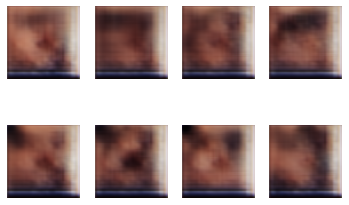

13001 [D loss: 1.566804, acc.: 56.25%, op_acc: 65.16%] [G loss: 1.054037]
13002 [D loss: 1.477164, acc.: 59.38%, op_acc: 63.67%] [G loss: 1.215017]
13003 [D loss: 1.118202, acc.: 82.81%, op_acc: 64.65%] [G loss: 1.304018]
13004 [D loss: 1.009453, acc.: 85.94%, op_acc: 64.38%] [G loss: 1.206392]
13005 [D loss: 1.142251, acc.: 82.81%, op_acc: 66.52%] [G loss: 1.167086]
13006 [D loss: 1.270888, acc.: 73.44%, op_acc: 66.68%] [G loss: 1.141009]
13007 [D loss: 0.936531, acc.: 93.75%, op_acc: 63.75%] [G loss: 1.214380]
13008 [D loss: 1.003493, acc.: 90.62%, op_acc: 65.86%] [G loss: 1.101331]
13009 [D loss: 1.067790, acc.: 87.50%, op_acc: 65.08%] [G loss: 1.040474]
13010 [D loss: 1.190096, acc.: 79.69%, op_acc: 64.73%] [G loss: 1.013345]
13011 [D loss: 1.136456, acc.: 82.81%, op_acc: 65.70%] [G loss: 1.030495]
13012 [D loss: 1.014943, acc.: 89.06%, op_acc: 66.05%] [G loss: 1.058796]
13013 [D loss: 0.897222, acc.: 90.62%, op_acc: 66.05%] [G loss: 1.008172]
13014 [D loss: 0.875291, acc.: 95.31%,

13111 [D loss: 0.595890, acc.: 98.44%, op_acc: 67.62%] [G loss: 0.966628]
13112 [D loss: 0.606053, acc.: 100.00%, op_acc: 66.45%] [G loss: 0.941814]
13113 [D loss: 0.571539, acc.: 100.00%, op_acc: 68.01%] [G loss: 0.951803]
13114 [D loss: 0.612771, acc.: 100.00%, op_acc: 67.54%] [G loss: 0.947058]
13115 [D loss: 0.601135, acc.: 100.00%, op_acc: 67.97%] [G loss: 0.960044]
13116 [D loss: 0.560969, acc.: 100.00%, op_acc: 67.07%] [G loss: 0.980073]
13117 [D loss: 0.677704, acc.: 95.31%, op_acc: 65.59%] [G loss: 0.946731]
13118 [D loss: 0.642519, acc.: 98.44%, op_acc: 67.42%] [G loss: 0.918740]
13119 [D loss: 0.591768, acc.: 100.00%, op_acc: 67.23%] [G loss: 0.998530]
13120 [D loss: 0.608421, acc.: 98.44%, op_acc: 66.21%] [G loss: 0.880714]
13121 [D loss: 0.591464, acc.: 100.00%, op_acc: 66.02%] [G loss: 0.917854]
13122 [D loss: 0.598904, acc.: 98.44%, op_acc: 66.33%] [G loss: 0.934870]
13123 [D loss: 0.606623, acc.: 100.00%, op_acc: 65.90%] [G loss: 0.958556]
13124 [D loss: 0.600188, acc.:

13221 [D loss: 0.564877, acc.: 100.00%, op_acc: 65.78%] [G loss: 0.891439]
13222 [D loss: 0.611585, acc.: 98.44%, op_acc: 66.76%] [G loss: 0.903848]
13223 [D loss: 0.565180, acc.: 100.00%, op_acc: 67.81%] [G loss: 0.960274]
13224 [D loss: 0.577386, acc.: 98.44%, op_acc: 67.27%] [G loss: 0.917772]
13225 [D loss: 0.556375, acc.: 100.00%, op_acc: 66.09%] [G loss: 0.937931]
13226 [D loss: 0.595532, acc.: 100.00%, op_acc: 66.37%] [G loss: 1.001509]
13227 [D loss: 0.562818, acc.: 100.00%, op_acc: 67.27%] [G loss: 0.940480]
13228 [D loss: 0.566723, acc.: 100.00%, op_acc: 66.88%] [G loss: 0.933136]
13229 [D loss: 0.571988, acc.: 100.00%, op_acc: 65.43%] [G loss: 0.974336]
13230 [D loss: 0.564451, acc.: 100.00%, op_acc: 65.43%] [G loss: 1.088120]
13231 [D loss: 0.574429, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.971313]
13232 [D loss: 0.575354, acc.: 100.00%, op_acc: 66.99%] [G loss: 0.925151]
13233 [D loss: 0.600812, acc.: 100.00%, op_acc: 64.30%] [G loss: 0.911509]
13234 [D loss: 0.584538, ac

13333 [D loss: 0.603441, acc.: 100.00%, op_acc: 67.30%] [G loss: 0.959659]
13334 [D loss: 0.629188, acc.: 98.44%, op_acc: 65.66%] [G loss: 0.914569]
13335 [D loss: 0.657617, acc.: 96.88%, op_acc: 66.80%] [G loss: 0.887082]
13336 [D loss: 0.641460, acc.: 98.44%, op_acc: 65.04%] [G loss: 0.917956]
13337 [D loss: 0.601654, acc.: 100.00%, op_acc: 64.61%] [G loss: 0.912322]
13338 [D loss: 0.653019, acc.: 98.44%, op_acc: 66.48%] [G loss: 0.857142]
13339 [D loss: 0.640353, acc.: 98.44%, op_acc: 65.94%] [G loss: 0.926319]
13340 [D loss: 0.648219, acc.: 98.44%, op_acc: 65.90%] [G loss: 0.864651]
13341 [D loss: 0.609402, acc.: 100.00%, op_acc: 66.80%] [G loss: 0.894575]
13342 [D loss: 0.618442, acc.: 98.44%, op_acc: 67.03%] [G loss: 0.875260]
13343 [D loss: 0.645778, acc.: 98.44%, op_acc: 66.37%] [G loss: 0.922754]
13344 [D loss: 0.590617, acc.: 100.00%, op_acc: 65.98%] [G loss: 0.907514]
13345 [D loss: 0.587454, acc.: 100.00%, op_acc: 66.88%] [G loss: 0.891418]
13346 [D loss: 0.681785, acc.: 95

13443 [D loss: 0.602486, acc.: 98.44%, op_acc: 66.56%] [G loss: 0.896440]
13444 [D loss: 0.578750, acc.: 100.00%, op_acc: 65.74%] [G loss: 0.914180]
13445 [D loss: 0.601796, acc.: 100.00%, op_acc: 67.27%] [G loss: 0.929345]
13446 [D loss: 0.641076, acc.: 98.44%, op_acc: 65.86%] [G loss: 0.941268]
13447 [D loss: 0.571106, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.944525]
13448 [D loss: 0.579968, acc.: 100.00%, op_acc: 65.86%] [G loss: 0.899370]
13449 [D loss: 0.603603, acc.: 100.00%, op_acc: 65.74%] [G loss: 0.937667]
13450 [D loss: 0.647434, acc.: 98.44%, op_acc: 65.31%] [G loss: 0.948446]
13451 [D loss: 0.585361, acc.: 100.00%, op_acc: 65.74%] [G loss: 0.900508]
13452 [D loss: 0.596372, acc.: 100.00%, op_acc: 66.52%] [G loss: 0.873270]
13453 [D loss: 0.572170, acc.: 100.00%, op_acc: 67.42%] [G loss: 0.936326]
13454 [D loss: 0.568052, acc.: 100.00%, op_acc: 66.60%] [G loss: 0.894193]
13455 [D loss: 0.601759, acc.: 100.00%, op_acc: 66.72%] [G loss: 0.937292]
13456 [D loss: 0.591073, acc

13554 [D loss: 0.579940, acc.: 100.00%, op_acc: 66.29%] [G loss: 0.876349]
13555 [D loss: 0.604480, acc.: 98.44%, op_acc: 65.98%] [G loss: 0.886699]
13556 [D loss: 0.605731, acc.: 98.44%, op_acc: 66.84%] [G loss: 0.847600]
13557 [D loss: 0.651969, acc.: 98.44%, op_acc: 66.09%] [G loss: 0.832852]
13558 [D loss: 0.607910, acc.: 100.00%, op_acc: 66.21%] [G loss: 0.868371]
13559 [D loss: 0.594074, acc.: 100.00%, op_acc: 66.05%] [G loss: 0.836829]
13560 [D loss: 0.569565, acc.: 100.00%, op_acc: 65.90%] [G loss: 0.896104]
13561 [D loss: 0.595227, acc.: 100.00%, op_acc: 68.52%] [G loss: 0.918756]
13562 [D loss: 0.621796, acc.: 100.00%, op_acc: 65.78%] [G loss: 0.868425]
13563 [D loss: 0.636306, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.856744]
13564 [D loss: 0.802154, acc.: 93.75%, op_acc: 65.90%] [G loss: 0.908968]
13565 [D loss: 0.686191, acc.: 96.88%, op_acc: 64.10%] [G loss: 0.904187]
13566 [D loss: 0.631945, acc.: 98.44%, op_acc: 66.87%] [G loss: 0.923899]
13567 [D loss: 0.779681, acc.: 

13664 [D loss: 0.581619, acc.: 100.00%, op_acc: 67.38%] [G loss: 1.008332]
13665 [D loss: 0.606934, acc.: 98.44%, op_acc: 66.05%] [G loss: 0.925637]
13666 [D loss: 0.620961, acc.: 98.44%, op_acc: 66.72%] [G loss: 0.873070]
13667 [D loss: 0.595730, acc.: 100.00%, op_acc: 66.56%] [G loss: 0.944743]
13668 [D loss: 0.604864, acc.: 98.44%, op_acc: 67.11%] [G loss: 0.877199]
13669 [D loss: 0.623142, acc.: 98.44%, op_acc: 65.31%] [G loss: 0.874992]
13670 [D loss: 0.622280, acc.: 100.00%, op_acc: 67.19%] [G loss: 0.944206]
13671 [D loss: 0.603216, acc.: 100.00%, op_acc: 66.45%] [G loss: 0.985042]
13672 [D loss: 0.747888, acc.: 96.88%, op_acc: 65.51%] [G loss: 0.890362]
13673 [D loss: 0.567436, acc.: 100.00%, op_acc: 67.07%] [G loss: 0.896547]
13674 [D loss: 0.600664, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.997247]
13675 [D loss: 0.612836, acc.: 98.44%, op_acc: 66.72%] [G loss: 0.956236]
13676 [D loss: 0.683760, acc.: 98.44%, op_acc: 65.51%] [G loss: 0.881795]
13677 [D loss: 0.779551, acc.: 9

13776 [D loss: 0.626218, acc.: 100.00%, op_acc: 64.80%] [G loss: 0.933236]
13777 [D loss: 0.633082, acc.: 98.44%, op_acc: 65.66%] [G loss: 0.902160]
13778 [D loss: 0.687696, acc.: 95.31%, op_acc: 66.52%] [G loss: 0.905114]
13779 [D loss: 0.558621, acc.: 100.00%, op_acc: 68.48%] [G loss: 0.936988]
13780 [D loss: 0.753811, acc.: 95.31%, op_acc: 66.95%] [G loss: 0.910909]
13781 [D loss: 0.835801, acc.: 90.62%, op_acc: 64.65%] [G loss: 0.938328]
13782 [D loss: 0.632067, acc.: 98.44%, op_acc: 66.52%] [G loss: 0.925152]
13783 [D loss: 0.633055, acc.: 98.44%, op_acc: 67.73%] [G loss: 0.958000]
13784 [D loss: 0.696690, acc.: 93.75%, op_acc: 67.03%] [G loss: 0.922273]
13785 [D loss: 0.619481, acc.: 98.44%, op_acc: 67.89%] [G loss: 0.966891]
13786 [D loss: 0.609178, acc.: 100.00%, op_acc: 67.50%] [G loss: 0.886555]
13787 [D loss: 0.601615, acc.: 98.44%, op_acc: 67.97%] [G loss: 0.910044]
13788 [D loss: 0.642426, acc.: 98.44%, op_acc: 66.05%] [G loss: 0.881287]
13789 [D loss: 0.575385, acc.: 100.

13888 [D loss: 0.589312, acc.: 100.00%, op_acc: 65.62%] [G loss: 0.946643]
13889 [D loss: 0.595130, acc.: 100.00%, op_acc: 66.95%] [G loss: 1.043862]
13890 [D loss: 0.606462, acc.: 96.88%, op_acc: 68.83%] [G loss: 0.967193]
13891 [D loss: 0.600978, acc.: 98.44%, op_acc: 66.91%] [G loss: 0.977322]
13892 [D loss: 0.578697, acc.: 100.00%, op_acc: 68.05%] [G loss: 0.938065]
13893 [D loss: 0.606218, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.932709]
13894 [D loss: 0.581008, acc.: 100.00%, op_acc: 67.07%] [G loss: 0.920185]
13895 [D loss: 0.581837, acc.: 100.00%, op_acc: 67.42%] [G loss: 0.942937]
13896 [D loss: 0.646606, acc.: 98.44%, op_acc: 66.60%] [G loss: 0.940061]
13897 [D loss: 0.588457, acc.: 100.00%, op_acc: 66.09%] [G loss: 0.937974]
13898 [D loss: 0.614779, acc.: 98.44%, op_acc: 66.45%] [G loss: 0.974161]
13899 [D loss: 0.599542, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.964647]
13900 [D loss: 0.597560, acc.: 100.00%, op_acc: 66.99%] [G loss: 0.912520]
13901 [D loss: 0.596783, acc.

13998 [D loss: 0.574490, acc.: 100.00%, op_acc: 67.19%] [G loss: 0.871071]
13999 [D loss: 0.572006, acc.: 100.00%, op_acc: 66.48%] [G loss: 0.893938]
14000 [D loss: 0.607981, acc.: 100.00%, op_acc: 65.94%] [G loss: 0.916899]
(8, 64, 64, 3)


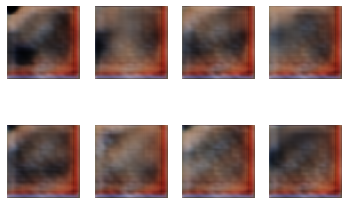

14001 [D loss: 0.569943, acc.: 100.00%, op_acc: 68.28%] [G loss: 0.867965]
14002 [D loss: 0.606355, acc.: 100.00%, op_acc: 65.08%] [G loss: 0.933170]
14003 [D loss: 0.592882, acc.: 100.00%, op_acc: 65.47%] [G loss: 0.923704]
14004 [D loss: 0.607743, acc.: 98.44%, op_acc: 67.89%] [G loss: 0.901266]
14005 [D loss: 0.595695, acc.: 100.00%, op_acc: 66.21%] [G loss: 0.906343]
14006 [D loss: 0.579307, acc.: 100.00%, op_acc: 66.02%] [G loss: 0.889744]
14007 [D loss: 0.608631, acc.: 98.44%, op_acc: 67.85%] [G loss: 0.885716]
14008 [D loss: 0.568511, acc.: 100.00%, op_acc: 66.88%] [G loss: 0.900460]
14009 [D loss: 0.581917, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.903272]
14010 [D loss: 0.555699, acc.: 100.00%, op_acc: 68.79%] [G loss: 0.923138]
14011 [D loss: 0.563777, acc.: 100.00%, op_acc: 68.28%] [G loss: 0.941106]
14012 [D loss: 0.601446, acc.: 100.00%, op_acc: 66.13%] [G loss: 0.914220]
14013 [D loss: 0.568733, acc.: 100.00%, op_acc: 68.12%] [G loss: 0.883908]
14014 [D loss: 0.632084, ac

14112 [D loss: 0.851240, acc.: 93.75%, op_acc: 67.34%] [G loss: 0.904149]
14113 [D loss: 0.744412, acc.: 95.31%, op_acc: 67.77%] [G loss: 0.876187]
14114 [D loss: 0.624442, acc.: 98.44%, op_acc: 67.38%] [G loss: 0.886393]
14115 [D loss: 0.706275, acc.: 95.31%, op_acc: 66.13%] [G loss: 0.865763]
14116 [D loss: 0.694414, acc.: 96.88%, op_acc: 67.85%] [G loss: 0.879657]
14117 [D loss: 0.616807, acc.: 100.00%, op_acc: 66.02%] [G loss: 0.942564]
14118 [D loss: 0.662599, acc.: 96.88%, op_acc: 66.05%] [G loss: 0.894267]
14119 [D loss: 0.629606, acc.: 98.44%, op_acc: 65.98%] [G loss: 0.888798]
14120 [D loss: 0.677853, acc.: 96.88%, op_acc: 67.11%] [G loss: 0.912743]
14121 [D loss: 0.690890, acc.: 96.88%, op_acc: 66.29%] [G loss: 0.931098]
14122 [D loss: 0.659867, acc.: 98.44%, op_acc: 66.48%] [G loss: 0.879456]
14123 [D loss: 0.585203, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.917782]
14124 [D loss: 0.597934, acc.: 100.00%, op_acc: 68.28%] [G loss: 0.929312]
14125 [D loss: 0.591846, acc.: 100.

14224 [D loss: 1.245270, acc.: 75.00%, op_acc: 65.55%] [G loss: 1.112217]
14225 [D loss: 1.454947, acc.: 62.50%, op_acc: 64.92%] [G loss: 1.044828]
14226 [D loss: 1.167109, acc.: 70.31%, op_acc: 66.41%] [G loss: 1.065941]
14227 [D loss: 1.237045, acc.: 78.12%, op_acc: 67.66%] [G loss: 1.063177]
14228 [D loss: 1.119644, acc.: 81.25%, op_acc: 66.41%] [G loss: 1.093921]
14229 [D loss: 1.136954, acc.: 85.94%, op_acc: 65.39%] [G loss: 1.114647]
14230 [D loss: 1.021043, acc.: 89.06%, op_acc: 66.17%] [G loss: 1.095640]
14231 [D loss: 0.942578, acc.: 92.19%, op_acc: 67.93%] [G loss: 1.121347]
14232 [D loss: 1.103696, acc.: 82.81%, op_acc: 64.53%] [G loss: 1.138627]
14233 [D loss: 0.913507, acc.: 90.62%, op_acc: 64.65%] [G loss: 1.144497]
14234 [D loss: 0.956797, acc.: 90.62%, op_acc: 66.41%] [G loss: 1.153696]
14235 [D loss: 0.908025, acc.: 90.62%, op_acc: 64.69%] [G loss: 1.172767]
14236 [D loss: 0.851033, acc.: 96.88%, op_acc: 66.45%] [G loss: 1.200935]
14237 [D loss: 0.833995, acc.: 93.75%,

14336 [D loss: 0.655642, acc.: 96.88%, op_acc: 67.77%] [G loss: 0.878904]
14337 [D loss: 0.610872, acc.: 100.00%, op_acc: 67.34%] [G loss: 0.884768]
14338 [D loss: 0.629468, acc.: 98.44%, op_acc: 67.70%] [G loss: 0.892468]
14339 [D loss: 0.798528, acc.: 95.31%, op_acc: 65.70%] [G loss: 0.924020]
14340 [D loss: 0.640125, acc.: 96.88%, op_acc: 64.22%] [G loss: 0.929738]
14341 [D loss: 0.661769, acc.: 98.44%, op_acc: 66.60%] [G loss: 0.885663]
14342 [D loss: 0.647161, acc.: 98.44%, op_acc: 66.25%] [G loss: 0.937276]
14343 [D loss: 0.683269, acc.: 96.88%, op_acc: 66.80%] [G loss: 0.900407]
14344 [D loss: 0.647242, acc.: 98.44%, op_acc: 67.27%] [G loss: 0.937477]
14345 [D loss: 0.685512, acc.: 96.88%, op_acc: 67.62%] [G loss: 0.869028]
14346 [D loss: 0.731107, acc.: 95.31%, op_acc: 65.59%] [G loss: 0.995297]
14347 [D loss: 0.860612, acc.: 93.75%, op_acc: 65.59%] [G loss: 0.983329]
14348 [D loss: 0.720452, acc.: 98.44%, op_acc: 67.42%] [G loss: 0.956109]
14349 [D loss: 0.802686, acc.: 90.62%

14448 [D loss: 1.054004, acc.: 89.06%, op_acc: 64.92%] [G loss: 1.065899]
14449 [D loss: 1.012449, acc.: 87.50%, op_acc: 66.84%] [G loss: 1.036045]
14450 [D loss: 1.309021, acc.: 73.44%, op_acc: 66.37%] [G loss: 0.987575]
14451 [D loss: 1.063090, acc.: 85.94%, op_acc: 66.25%] [G loss: 0.977013]
14452 [D loss: 1.028750, acc.: 87.50%, op_acc: 65.08%] [G loss: 0.993155]
14453 [D loss: 0.927186, acc.: 92.19%, op_acc: 66.45%] [G loss: 1.000424]
14454 [D loss: 0.921521, acc.: 89.06%, op_acc: 66.17%] [G loss: 1.005262]
14455 [D loss: 0.864156, acc.: 90.62%, op_acc: 67.81%] [G loss: 0.993124]
14456 [D loss: 0.839440, acc.: 95.31%, op_acc: 66.05%] [G loss: 0.963899]
14457 [D loss: 0.806746, acc.: 93.75%, op_acc: 65.27%] [G loss: 0.951124]
14458 [D loss: 0.833642, acc.: 92.19%, op_acc: 66.76%] [G loss: 0.912437]
14459 [D loss: 0.723945, acc.: 96.88%, op_acc: 66.91%] [G loss: 0.869528]
14460 [D loss: 0.720570, acc.: 95.31%, op_acc: 67.50%] [G loss: 0.892171]
14461 [D loss: 0.724111, acc.: 93.75%,

14558 [D loss: 0.587497, acc.: 98.44%, op_acc: 68.12%] [G loss: 1.004055]
14559 [D loss: 0.588069, acc.: 100.00%, op_acc: 66.37%] [G loss: 0.924387]
14560 [D loss: 0.563188, acc.: 100.00%, op_acc: 67.07%] [G loss: 1.018285]
14561 [D loss: 0.578001, acc.: 100.00%, op_acc: 66.60%] [G loss: 1.009577]
14562 [D loss: 0.567418, acc.: 100.00%, op_acc: 67.27%] [G loss: 1.006807]
14563 [D loss: 0.564599, acc.: 100.00%, op_acc: 67.73%] [G loss: 0.989454]
14564 [D loss: 0.562649, acc.: 100.00%, op_acc: 66.60%] [G loss: 0.988382]
14565 [D loss: 0.546471, acc.: 100.00%, op_acc: 67.50%] [G loss: 0.973960]
14566 [D loss: 0.567418, acc.: 100.00%, op_acc: 65.27%] [G loss: 0.955758]
14567 [D loss: 0.582461, acc.: 100.00%, op_acc: 66.56%] [G loss: 0.981151]
14568 [D loss: 0.569496, acc.: 100.00%, op_acc: 66.56%] [G loss: 0.990328]
14569 [D loss: 0.560410, acc.: 100.00%, op_acc: 66.99%] [G loss: 0.967941]
14570 [D loss: 0.600652, acc.: 100.00%, op_acc: 65.70%] [G loss: 0.974533]
14571 [D loss: 0.563966, a

14669 [D loss: 0.581538, acc.: 100.00%, op_acc: 66.87%] [G loss: 1.046886]
14670 [D loss: 0.627390, acc.: 98.44%, op_acc: 68.83%] [G loss: 0.944231]
14671 [D loss: 0.649883, acc.: 98.44%, op_acc: 66.13%] [G loss: 0.996844]
14672 [D loss: 0.627769, acc.: 98.44%, op_acc: 66.05%] [G loss: 1.005664]
14673 [D loss: 0.599258, acc.: 100.00%, op_acc: 65.90%] [G loss: 1.006987]
14674 [D loss: 0.608236, acc.: 100.00%, op_acc: 65.47%] [G loss: 1.095143]
14675 [D loss: 0.659672, acc.: 98.44%, op_acc: 66.91%] [G loss: 1.167114]
14676 [D loss: 0.640583, acc.: 96.88%, op_acc: 66.68%] [G loss: 1.837004]
14677 [D loss: 0.788853, acc.: 95.31%, op_acc: 64.77%] [G loss: 1.702964]
14678 [D loss: 0.703925, acc.: 98.44%, op_acc: 67.15%] [G loss: 2.709827]
14679 [D loss: 0.760135, acc.: 95.31%, op_acc: 66.05%] [G loss: 1.434596]
14680 [D loss: 0.930522, acc.: 92.19%, op_acc: 64.84%] [G loss: 0.996026]
14681 [D loss: 0.591250, acc.: 100.00%, op_acc: 66.48%] [G loss: 1.158802]
14682 [D loss: 0.613596, acc.: 98.

14781 [D loss: 0.579330, acc.: 100.00%, op_acc: 67.30%] [G loss: 0.990857]
14782 [D loss: 0.586364, acc.: 100.00%, op_acc: 65.74%] [G loss: 0.954981]
14783 [D loss: 0.570350, acc.: 100.00%, op_acc: 66.02%] [G loss: 0.958395]
14784 [D loss: 0.582644, acc.: 100.00%, op_acc: 67.11%] [G loss: 0.939995]
14785 [D loss: 0.597522, acc.: 98.44%, op_acc: 67.15%] [G loss: 0.953581]
14786 [D loss: 0.624389, acc.: 98.44%, op_acc: 65.86%] [G loss: 0.947317]
14787 [D loss: 0.597444, acc.: 100.00%, op_acc: 65.82%] [G loss: 0.964296]
14788 [D loss: 0.607681, acc.: 98.44%, op_acc: 65.98%] [G loss: 0.918484]
14789 [D loss: 0.583882, acc.: 100.00%, op_acc: 65.27%] [G loss: 0.893650]
14790 [D loss: 0.582516, acc.: 100.00%, op_acc: 67.46%] [G loss: 0.950578]
14791 [D loss: 0.593584, acc.: 100.00%, op_acc: 67.19%] [G loss: 0.932956]
14792 [D loss: 0.567290, acc.: 100.00%, op_acc: 65.98%] [G loss: 0.898076]
14793 [D loss: 0.583876, acc.: 100.00%, op_acc: 66.68%] [G loss: 0.929472]
14794 [D loss: 0.586961, acc

14891 [D loss: 0.665866, acc.: 95.31%, op_acc: 66.76%] [G loss: 1.004439]
14892 [D loss: 0.612723, acc.: 100.00%, op_acc: 64.88%] [G loss: 0.898217]
14893 [D loss: 0.573223, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.943469]
14894 [D loss: 0.581993, acc.: 100.00%, op_acc: 68.09%] [G loss: 0.931409]
14895 [D loss: 0.568402, acc.: 100.00%, op_acc: 67.42%] [G loss: 1.011611]
14896 [D loss: 0.614146, acc.: 98.44%, op_acc: 66.99%] [G loss: 1.009558]
14897 [D loss: 0.577654, acc.: 100.00%, op_acc: 67.93%] [G loss: 0.957919]
14898 [D loss: 0.574993, acc.: 100.00%, op_acc: 67.11%] [G loss: 0.926102]
14899 [D loss: 0.572221, acc.: 100.00%, op_acc: 68.32%] [G loss: 0.951668]
14900 [D loss: 0.601303, acc.: 98.44%, op_acc: 67.30%] [G loss: 0.985046]
14901 [D loss: 0.585986, acc.: 100.00%, op_acc: 65.78%] [G loss: 0.955495]
14902 [D loss: 0.613171, acc.: 100.00%, op_acc: 65.51%] [G loss: 1.012116]
14903 [D loss: 0.600261, acc.: 100.00%, op_acc: 66.60%] [G loss: 0.948028]
14904 [D loss: 0.592921, acc

(8, 64, 64, 3)


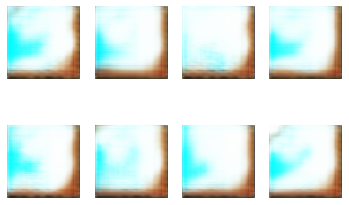

15001 [D loss: 0.597725, acc.: 98.44%, op_acc: 65.62%] [G loss: 1.020210]
15002 [D loss: 0.590671, acc.: 100.00%, op_acc: 65.39%] [G loss: 0.989629]
15003 [D loss: 0.603134, acc.: 100.00%, op_acc: 64.77%] [G loss: 1.020489]
15004 [D loss: 0.586017, acc.: 100.00%, op_acc: 63.98%] [G loss: 1.001358]
15005 [D loss: 0.576327, acc.: 100.00%, op_acc: 66.84%] [G loss: 1.005902]
15006 [D loss: 0.587644, acc.: 100.00%, op_acc: 64.96%] [G loss: 1.003837]
15007 [D loss: 0.591764, acc.: 100.00%, op_acc: 64.26%] [G loss: 1.009900]
15008 [D loss: 0.588595, acc.: 100.00%, op_acc: 65.31%] [G loss: 1.044878]
15009 [D loss: 0.621485, acc.: 98.44%, op_acc: 64.45%] [G loss: 0.993471]
15010 [D loss: 0.589111, acc.: 100.00%, op_acc: 65.78%] [G loss: 0.971344]
15011 [D loss: 0.585590, acc.: 100.00%, op_acc: 65.82%] [G loss: 0.984020]
15012 [D loss: 0.576400, acc.: 100.00%, op_acc: 67.34%] [G loss: 1.040782]
15013 [D loss: 0.582070, acc.: 100.00%, op_acc: 65.90%] [G loss: 1.040276]
15014 [D loss: 0.602129, ac

15111 [D loss: 0.865131, acc.: 92.19%, op_acc: 65.43%] [G loss: 1.240956]
15112 [D loss: 0.950823, acc.: 90.62%, op_acc: 65.20%] [G loss: 1.273098]
15113 [D loss: 0.827064, acc.: 95.31%, op_acc: 65.31%] [G loss: 1.045277]
15114 [D loss: 0.835548, acc.: 92.19%, op_acc: 65.31%] [G loss: 0.985360]
15115 [D loss: 0.798870, acc.: 95.31%, op_acc: 64.34%] [G loss: 1.003206]
15116 [D loss: 0.725163, acc.: 100.00%, op_acc: 65.70%] [G loss: 0.997256]
15117 [D loss: 0.698022, acc.: 100.00%, op_acc: 66.29%] [G loss: 0.977727]
15118 [D loss: 0.848129, acc.: 95.31%, op_acc: 63.20%] [G loss: 0.962596]
15119 [D loss: 0.687381, acc.: 98.44%, op_acc: 64.77%] [G loss: 1.008878]
15120 [D loss: 0.712707, acc.: 96.88%, op_acc: 64.14%] [G loss: 1.020687]
15121 [D loss: 0.846803, acc.: 92.19%, op_acc: 66.25%] [G loss: 0.977666]
15122 [D loss: 0.932524, acc.: 95.31%, op_acc: 64.84%] [G loss: 0.987404]
15123 [D loss: 0.610877, acc.: 100.00%, op_acc: 67.42%] [G loss: 1.063851]
15124 [D loss: 0.736678, acc.: 96.8

15223 [D loss: 0.599249, acc.: 100.00%, op_acc: 66.72%] [G loss: 0.959181]
15224 [D loss: 0.684715, acc.: 93.75%, op_acc: 67.11%] [G loss: 0.945460]
15225 [D loss: 0.602829, acc.: 100.00%, op_acc: 66.80%] [G loss: 0.893601]
15226 [D loss: 0.585817, acc.: 100.00%, op_acc: 67.62%] [G loss: 0.885265]
15227 [D loss: 0.581758, acc.: 100.00%, op_acc: 67.77%] [G loss: 0.890258]
15228 [D loss: 0.630445, acc.: 96.88%, op_acc: 66.87%] [G loss: 0.898251]
15229 [D loss: 0.588633, acc.: 100.00%, op_acc: 67.42%] [G loss: 0.903530]
15230 [D loss: 0.591102, acc.: 100.00%, op_acc: 67.46%] [G loss: 1.066567]
15231 [D loss: 0.645550, acc.: 98.44%, op_acc: 66.56%] [G loss: 0.877110]
15232 [D loss: 0.674415, acc.: 96.88%, op_acc: 64.61%] [G loss: 0.914923]
15233 [D loss: 0.669712, acc.: 95.31%, op_acc: 66.88%] [G loss: 0.911439]
15234 [D loss: 0.677015, acc.: 96.88%, op_acc: 67.23%] [G loss: 0.904977]
15235 [D loss: 0.702594, acc.: 93.75%, op_acc: 66.56%] [G loss: 0.886868]
15236 [D loss: 0.699672, acc.: 9

15335 [D loss: 0.783645, acc.: 95.31%, op_acc: 66.17%] [G loss: 1.318326]
15336 [D loss: 0.802903, acc.: 96.88%, op_acc: 64.92%] [G loss: 1.656020]
15337 [D loss: 1.096250, acc.: 76.56%, op_acc: 65.98%] [G loss: 1.285234]
15338 [D loss: 0.968573, acc.: 84.38%, op_acc: 66.29%] [G loss: 1.151352]
15339 [D loss: 0.979120, acc.: 84.38%, op_acc: 67.07%] [G loss: 1.028558]
15340 [D loss: 1.271102, acc.: 71.88%, op_acc: 62.54%] [G loss: 0.976642]
15341 [D loss: 1.312056, acc.: 81.25%, op_acc: 63.05%] [G loss: 0.985738]
15342 [D loss: 1.062109, acc.: 87.50%, op_acc: 65.47%] [G loss: 0.980774]
15343 [D loss: 1.111470, acc.: 81.25%, op_acc: 63.48%] [G loss: 0.991090]
15344 [D loss: 0.707700, acc.: 100.00%, op_acc: 66.72%] [G loss: 0.996936]
15345 [D loss: 0.766975, acc.: 93.75%, op_acc: 66.64%] [G loss: 0.919889]
15346 [D loss: 0.705342, acc.: 98.44%, op_acc: 65.78%] [G loss: 0.927803]
15347 [D loss: 0.697307, acc.: 96.88%, op_acc: 67.19%] [G loss: 0.900236]
15348 [D loss: 0.696746, acc.: 98.44%

15447 [D loss: 0.625476, acc.: 98.44%, op_acc: 66.02%] [G loss: 0.856578]
15448 [D loss: 0.644839, acc.: 98.44%, op_acc: 66.41%] [G loss: 0.819908]
15449 [D loss: 0.578168, acc.: 100.00%, op_acc: 66.87%] [G loss: 0.881413]
15450 [D loss: 0.582790, acc.: 100.00%, op_acc: 66.64%] [G loss: 0.886192]
15451 [D loss: 0.591053, acc.: 98.44%, op_acc: 66.64%] [G loss: 0.886072]
15452 [D loss: 0.613576, acc.: 98.44%, op_acc: 66.41%] [G loss: 0.829173]
15453 [D loss: 0.597043, acc.: 100.00%, op_acc: 67.19%] [G loss: 0.870429]
15454 [D loss: 0.623632, acc.: 98.44%, op_acc: 66.48%] [G loss: 0.868283]
15455 [D loss: 0.617653, acc.: 96.88%, op_acc: 67.11%] [G loss: 0.856468]
15456 [D loss: 0.604327, acc.: 100.00%, op_acc: 64.88%] [G loss: 0.891732]
15457 [D loss: 0.603472, acc.: 98.44%, op_acc: 65.70%] [G loss: 0.924342]
15458 [D loss: 0.580420, acc.: 100.00%, op_acc: 66.87%] [G loss: 0.891334]
15459 [D loss: 0.595709, acc.: 98.44%, op_acc: 67.42%] [G loss: 0.872575]
15460 [D loss: 0.634277, acc.: 98

15559 [D loss: 0.641010, acc.: 98.44%, op_acc: 65.70%] [G loss: 0.952919]
15560 [D loss: 0.689499, acc.: 98.44%, op_acc: 65.35%] [G loss: 0.970937]
15561 [D loss: 0.776998, acc.: 95.31%, op_acc: 64.69%] [G loss: 0.967336]
15562 [D loss: 0.615550, acc.: 100.00%, op_acc: 66.21%] [G loss: 0.955403]
15563 [D loss: 0.618639, acc.: 98.44%, op_acc: 67.07%] [G loss: 0.972482]
15564 [D loss: 0.614694, acc.: 100.00%, op_acc: 65.27%] [G loss: 0.954466]
15565 [D loss: 0.695999, acc.: 96.88%, op_acc: 65.66%] [G loss: 0.947579]
15566 [D loss: 0.654353, acc.: 98.44%, op_acc: 67.07%] [G loss: 0.939620]
15567 [D loss: 0.627428, acc.: 100.00%, op_acc: 64.53%] [G loss: 0.983883]
15568 [D loss: 0.655515, acc.: 98.44%, op_acc: 67.03%] [G loss: 0.955045]
15569 [D loss: 0.628675, acc.: 98.44%, op_acc: 66.68%] [G loss: 0.981195]
15570 [D loss: 0.885527, acc.: 93.75%, op_acc: 64.18%] [G loss: 0.965403]
15571 [D loss: 0.640532, acc.: 100.00%, op_acc: 65.90%] [G loss: 0.968883]
15572 [D loss: 0.608812, acc.: 98.

15671 [D loss: 0.612450, acc.: 100.00%, op_acc: 65.70%] [G loss: 0.947473]
15672 [D loss: 0.650892, acc.: 98.44%, op_acc: 64.10%] [G loss: 0.945153]
15673 [D loss: 0.594343, acc.: 98.44%, op_acc: 65.66%] [G loss: 0.967932]
15674 [D loss: 0.598700, acc.: 98.44%, op_acc: 67.54%] [G loss: 0.942306]
15675 [D loss: 0.634981, acc.: 98.44%, op_acc: 65.66%] [G loss: 0.982355]
15676 [D loss: 0.589231, acc.: 100.00%, op_acc: 67.27%] [G loss: 0.950428]
15677 [D loss: 0.743778, acc.: 96.88%, op_acc: 66.05%] [G loss: 0.924718]
15678 [D loss: 0.640284, acc.: 96.88%, op_acc: 66.29%] [G loss: 0.954606]
15679 [D loss: 0.612300, acc.: 100.00%, op_acc: 66.80%] [G loss: 0.921431]
15680 [D loss: 0.565258, acc.: 100.00%, op_acc: 66.80%] [G loss: 0.967805]
15681 [D loss: 0.756208, acc.: 93.75%, op_acc: 66.05%] [G loss: 0.961710]
15682 [D loss: 0.622759, acc.: 100.00%, op_acc: 64.84%] [G loss: 0.949987]
15683 [D loss: 0.610432, acc.: 98.44%, op_acc: 66.48%] [G loss: 0.924863]
15684 [D loss: 0.633088, acc.: 98

15781 [D loss: 0.570235, acc.: 100.00%, op_acc: 68.01%] [G loss: 0.914277]
15782 [D loss: 0.550747, acc.: 100.00%, op_acc: 67.58%] [G loss: 0.913967]
15783 [D loss: 0.555172, acc.: 100.00%, op_acc: 68.32%] [G loss: 0.911012]
15784 [D loss: 0.678219, acc.: 96.88%, op_acc: 65.47%] [G loss: 0.968077]
15785 [D loss: 0.575006, acc.: 100.00%, op_acc: 67.03%] [G loss: 0.913019]
15786 [D loss: 0.562283, acc.: 100.00%, op_acc: 67.15%] [G loss: 0.886328]
15787 [D loss: 0.580557, acc.: 100.00%, op_acc: 66.33%] [G loss: 0.857158]
15788 [D loss: 0.611568, acc.: 98.44%, op_acc: 66.99%] [G loss: 0.885550]
15789 [D loss: 0.605997, acc.: 98.44%, op_acc: 66.13%] [G loss: 0.951967]
15790 [D loss: 0.574145, acc.: 100.00%, op_acc: 66.72%] [G loss: 0.922681]
15791 [D loss: 0.560487, acc.: 100.00%, op_acc: 67.27%] [G loss: 0.963531]
15792 [D loss: 0.576709, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.864736]
15793 [D loss: 0.572898, acc.: 100.00%, op_acc: 64.61%] [G loss: 0.957811]
15794 [D loss: 0.570898, acc

15891 [D loss: 0.799064, acc.: 93.75%, op_acc: 66.05%] [G loss: 0.900058]
15892 [D loss: 0.693738, acc.: 98.44%, op_acc: 67.27%] [G loss: 0.851723]
15893 [D loss: 0.756846, acc.: 93.75%, op_acc: 65.94%] [G loss: 0.909720]
15894 [D loss: 0.693800, acc.: 95.31%, op_acc: 68.16%] [G loss: 0.871716]
15895 [D loss: 0.658080, acc.: 98.44%, op_acc: 66.52%] [G loss: 0.947445]
15896 [D loss: 0.680189, acc.: 96.88%, op_acc: 67.11%] [G loss: 0.888803]
15897 [D loss: 0.642224, acc.: 96.88%, op_acc: 66.41%] [G loss: 0.931103]
15898 [D loss: 0.601942, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.922346]
15899 [D loss: 0.640587, acc.: 98.44%, op_acc: 67.07%] [G loss: 0.904046]
15900 [D loss: 0.574852, acc.: 100.00%, op_acc: 69.22%] [G loss: 0.887591]
15901 [D loss: 0.655369, acc.: 98.44%, op_acc: 64.65%] [G loss: 0.933114]
15902 [D loss: 0.677151, acc.: 98.44%, op_acc: 67.66%] [G loss: 0.878816]
15903 [D loss: 0.615037, acc.: 100.00%, op_acc: 65.00%] [G loss: 0.892071]
15904 [D loss: 0.597467, acc.: 98.4

(8, 64, 64, 3)


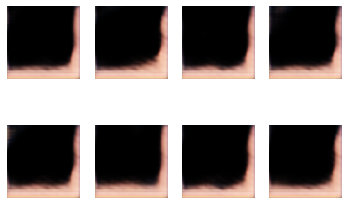

16001 [D loss: 0.666785, acc.: 95.31%, op_acc: 65.90%] [G loss: 0.920504]
16002 [D loss: 0.565387, acc.: 100.00%, op_acc: 66.87%] [G loss: 0.936360]
16003 [D loss: 0.631994, acc.: 98.44%, op_acc: 68.01%] [G loss: 0.932375]
16004 [D loss: 0.603609, acc.: 96.88%, op_acc: 67.34%] [G loss: 1.029692]
16005 [D loss: 0.576152, acc.: 100.00%, op_acc: 66.60%] [G loss: 0.952612]
16006 [D loss: 0.578233, acc.: 100.00%, op_acc: 66.80%] [G loss: 0.954531]
16007 [D loss: 0.833617, acc.: 89.06%, op_acc: 66.21%] [G loss: 5.048589]
16008 [D loss: 0.947222, acc.: 84.38%, op_acc: 65.31%] [G loss: 1.412998]
16009 [D loss: 0.777204, acc.: 92.19%, op_acc: 65.86%] [G loss: 5.021857]
16010 [D loss: 0.715246, acc.: 93.75%, op_acc: 66.84%] [G loss: 4.347049]
16011 [D loss: 0.773905, acc.: 96.88%, op_acc: 65.31%] [G loss: 2.257323]
16012 [D loss: 0.687199, acc.: 96.88%, op_acc: 65.23%] [G loss: 1.813036]
16013 [D loss: 0.715486, acc.: 95.31%, op_acc: 67.73%] [G loss: 1.239332]
16014 [D loss: 0.975574, acc.: 79.6

16111 [D loss: 0.561775, acc.: 100.00%, op_acc: 67.97%] [G loss: 0.898858]
16112 [D loss: 0.562291, acc.: 100.00%, op_acc: 66.91%] [G loss: 0.969054]
16113 [D loss: 0.576852, acc.: 100.00%, op_acc: 66.21%] [G loss: 0.948856]
16114 [D loss: 0.592139, acc.: 98.44%, op_acc: 66.80%] [G loss: 0.928152]
16115 [D loss: 0.627734, acc.: 98.44%, op_acc: 64.41%] [G loss: 0.919939]
16116 [D loss: 0.649681, acc.: 98.44%, op_acc: 66.02%] [G loss: 0.914197]
16117 [D loss: 0.562008, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.908970]
16118 [D loss: 0.574069, acc.: 100.00%, op_acc: 68.24%] [G loss: 0.909377]
16119 [D loss: 0.564644, acc.: 100.00%, op_acc: 67.85%] [G loss: 0.912649]
16120 [D loss: 0.605609, acc.: 96.88%, op_acc: 67.07%] [G loss: 0.872244]
16121 [D loss: 0.563709, acc.: 100.00%, op_acc: 67.85%] [G loss: 0.937304]
16122 [D loss: 0.587701, acc.: 100.00%, op_acc: 67.66%] [G loss: 0.916672]
16123 [D loss: 0.581130, acc.: 100.00%, op_acc: 66.95%] [G loss: 0.977928]
16124 [D loss: 0.548804, acc.

16222 [D loss: 0.607142, acc.: 98.44%, op_acc: 66.17%] [G loss: 0.905052]
16223 [D loss: 0.562562, acc.: 100.00%, op_acc: 67.03%] [G loss: 0.891411]
16224 [D loss: 0.577517, acc.: 100.00%, op_acc: 66.52%] [G loss: 0.932342]
16225 [D loss: 0.563763, acc.: 100.00%, op_acc: 66.68%] [G loss: 0.897975]
16226 [D loss: 0.543076, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.988576]
16227 [D loss: 0.652915, acc.: 98.44%, op_acc: 65.78%] [G loss: 0.918252]
16228 [D loss: 0.601606, acc.: 98.44%, op_acc: 66.95%] [G loss: 0.937464]
16229 [D loss: 0.570992, acc.: 100.00%, op_acc: 66.45%] [G loss: 0.908628]
16230 [D loss: 0.601924, acc.: 100.00%, op_acc: 66.21%] [G loss: 0.952423]
16231 [D loss: 0.601111, acc.: 98.44%, op_acc: 65.23%] [G loss: 0.972147]
16232 [D loss: 0.583778, acc.: 100.00%, op_acc: 66.91%] [G loss: 0.896203]
16233 [D loss: 0.553678, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.887254]
16234 [D loss: 0.599900, acc.: 98.44%, op_acc: 65.00%] [G loss: 0.884380]
16235 [D loss: 0.560600, acc.:

16332 [D loss: 0.571567, acc.: 100.00%, op_acc: 66.09%] [G loss: 0.944221]
16333 [D loss: 0.566600, acc.: 100.00%, op_acc: 68.09%] [G loss: 0.888374]
16334 [D loss: 0.574363, acc.: 100.00%, op_acc: 66.60%] [G loss: 0.905485]
16335 [D loss: 0.627198, acc.: 98.44%, op_acc: 65.74%] [G loss: 0.905495]
16336 [D loss: 0.569679, acc.: 100.00%, op_acc: 66.68%] [G loss: 0.882556]
16337 [D loss: 0.571420, acc.: 100.00%, op_acc: 67.34%] [G loss: 0.978642]
16338 [D loss: 0.609428, acc.: 100.00%, op_acc: 65.51%] [G loss: 0.885977]
16339 [D loss: 0.562606, acc.: 100.00%, op_acc: 67.11%] [G loss: 0.878752]
16340 [D loss: 0.557252, acc.: 100.00%, op_acc: 66.95%] [G loss: 0.884262]
16341 [D loss: 0.567996, acc.: 100.00%, op_acc: 67.11%] [G loss: 0.893093]
16342 [D loss: 0.576928, acc.: 100.00%, op_acc: 66.41%] [G loss: 0.900798]
16343 [D loss: 0.561679, acc.: 100.00%, op_acc: 68.44%] [G loss: 0.893343]
16344 [D loss: 0.590646, acc.: 100.00%, op_acc: 65.20%] [G loss: 0.931931]
16345 [D loss: 0.580787, a

16444 [D loss: 0.653115, acc.: 100.00%, op_acc: 66.05%] [G loss: 1.499010]
16445 [D loss: 0.697979, acc.: 95.31%, op_acc: 67.07%] [G loss: 1.497636]
16446 [D loss: 0.650380, acc.: 98.44%, op_acc: 66.88%] [G loss: 1.361100]
16447 [D loss: 0.743675, acc.: 93.75%, op_acc: 63.98%] [G loss: 1.440338]
16448 [D loss: 0.644694, acc.: 98.44%, op_acc: 68.09%] [G loss: 1.354130]
16449 [D loss: 0.716937, acc.: 96.88%, op_acc: 67.58%] [G loss: 1.527568]
16450 [D loss: 0.600208, acc.: 100.00%, op_acc: 67.97%] [G loss: 1.797969]
16451 [D loss: 1.100027, acc.: 85.94%, op_acc: 63.75%] [G loss: 1.147409]
16452 [D loss: 0.732264, acc.: 98.44%, op_acc: 66.25%] [G loss: 1.311613]
16453 [D loss: 0.782525, acc.: 95.31%, op_acc: 66.41%] [G loss: 1.201381]
16454 [D loss: 0.864736, acc.: 92.19%, op_acc: 65.43%] [G loss: 1.266023]
16455 [D loss: 0.807537, acc.: 92.19%, op_acc: 66.17%] [G loss: 1.166313]
16456 [D loss: 1.170129, acc.: 75.00%, op_acc: 65.62%] [G loss: 1.278569]
16457 [D loss: 0.991311, acc.: 85.94

16554 [D loss: 0.565778, acc.: 100.00%, op_acc: 65.70%] [G loss: 0.929132]
16555 [D loss: 0.548285, acc.: 100.00%, op_acc: 67.54%] [G loss: 0.923631]
16556 [D loss: 0.567050, acc.: 100.00%, op_acc: 66.09%] [G loss: 0.879728]
16557 [D loss: 0.575491, acc.: 100.00%, op_acc: 65.43%] [G loss: 0.981896]
16558 [D loss: 0.597599, acc.: 100.00%, op_acc: 64.88%] [G loss: 0.973001]
16559 [D loss: 0.549314, acc.: 100.00%, op_acc: 67.54%] [G loss: 0.899601]
16560 [D loss: 0.601336, acc.: 96.88%, op_acc: 67.89%] [G loss: 0.914713]
16561 [D loss: 0.563320, acc.: 100.00%, op_acc: 67.77%] [G loss: 0.925172]
16562 [D loss: 0.560580, acc.: 100.00%, op_acc: 67.15%] [G loss: 0.933407]
16563 [D loss: 0.556355, acc.: 100.00%, op_acc: 67.42%] [G loss: 1.022567]
16564 [D loss: 0.603393, acc.: 96.88%, op_acc: 67.38%] [G loss: 0.924178]
16565 [D loss: 0.589518, acc.: 98.44%, op_acc: 67.34%] [G loss: 0.979749]
16566 [D loss: 0.540793, acc.: 100.00%, op_acc: 67.23%] [G loss: 0.949733]
16567 [D loss: 0.559745, acc

16664 [D loss: 0.741521, acc.: 93.75%, op_acc: 65.78%] [G loss: 0.901901]
16665 [D loss: 0.855742, acc.: 92.19%, op_acc: 64.41%] [G loss: 0.859992]
16666 [D loss: 0.707442, acc.: 95.31%, op_acc: 66.80%] [G loss: 0.851875]
16667 [D loss: 0.835328, acc.: 90.62%, op_acc: 66.68%] [G loss: 0.827010]
16668 [D loss: 0.713830, acc.: 96.88%, op_acc: 64.38%] [G loss: 0.868079]
16669 [D loss: 0.666832, acc.: 98.44%, op_acc: 66.37%] [G loss: 0.851555]
16670 [D loss: 0.595229, acc.: 100.00%, op_acc: 67.03%] [G loss: 0.874571]
16671 [D loss: 0.856257, acc.: 92.19%, op_acc: 65.35%] [G loss: 0.860939]
16672 [D loss: 0.627044, acc.: 98.44%, op_acc: 68.24%] [G loss: 0.887339]
16673 [D loss: 0.734184, acc.: 95.31%, op_acc: 63.83%] [G loss: 0.854228]
16674 [D loss: 0.638715, acc.: 98.44%, op_acc: 66.72%] [G loss: 0.831688]
16675 [D loss: 0.647293, acc.: 98.44%, op_acc: 66.48%] [G loss: 0.873226]
16676 [D loss: 0.663420, acc.: 96.88%, op_acc: 65.90%] [G loss: 0.871365]
16677 [D loss: 0.588367, acc.: 100.00

16775 [D loss: 0.847606, acc.: 98.44%, op_acc: 66.13%] [G loss: 0.952192]
16776 [D loss: 0.586589, acc.: 100.00%, op_acc: 65.12%] [G loss: 0.922069]
16777 [D loss: 0.636562, acc.: 98.44%, op_acc: 66.02%] [G loss: 0.863704]
16778 [D loss: 0.654797, acc.: 96.88%, op_acc: 68.55%] [G loss: 0.867583]
16779 [D loss: 0.661989, acc.: 96.88%, op_acc: 66.84%] [G loss: 0.858005]
16780 [D loss: 0.611182, acc.: 98.44%, op_acc: 66.21%] [G loss: 0.885450]
16781 [D loss: 0.608321, acc.: 98.44%, op_acc: 68.40%] [G loss: 0.826864]
16782 [D loss: 0.586809, acc.: 100.00%, op_acc: 67.73%] [G loss: 0.859007]
16783 [D loss: 0.617971, acc.: 98.44%, op_acc: 65.98%] [G loss: 0.864077]
16784 [D loss: 0.589753, acc.: 100.00%, op_acc: 66.52%] [G loss: 0.865927]
16785 [D loss: 0.652652, acc.: 98.44%, op_acc: 65.98%] [G loss: 0.849224]
16786 [D loss: 0.588602, acc.: 100.00%, op_acc: 66.02%] [G loss: 0.855193]
16787 [D loss: 0.569929, acc.: 100.00%, op_acc: 67.93%] [G loss: 0.861434]
16788 [D loss: 0.618194, acc.: 96

16887 [D loss: 0.632074, acc.: 98.44%, op_acc: 68.09%] [G loss: 1.034705]
16888 [D loss: 0.622926, acc.: 100.00%, op_acc: 67.73%] [G loss: 1.009271]
16889 [D loss: 0.594275, acc.: 98.44%, op_acc: 68.55%] [G loss: 1.029940]
16890 [D loss: 0.620579, acc.: 100.00%, op_acc: 65.70%] [G loss: 1.189216]
16891 [D loss: 0.670902, acc.: 98.44%, op_acc: 66.37%] [G loss: 0.966894]
16892 [D loss: 0.630308, acc.: 98.44%, op_acc: 66.56%] [G loss: 0.937177]
16893 [D loss: 0.659379, acc.: 98.44%, op_acc: 67.23%] [G loss: 1.026455]
16894 [D loss: 0.609566, acc.: 100.00%, op_acc: 68.32%] [G loss: 0.960616]
16895 [D loss: 0.608538, acc.: 100.00%, op_acc: 68.75%] [G loss: 0.908678]
16896 [D loss: 0.595152, acc.: 100.00%, op_acc: 68.83%] [G loss: 0.998546]
16897 [D loss: 0.583976, acc.: 100.00%, op_acc: 68.12%] [G loss: 0.962219]
16898 [D loss: 0.663210, acc.: 98.44%, op_acc: 67.34%] [G loss: 1.175325]
16899 [D loss: 0.585484, acc.: 100.00%, op_acc: 66.91%] [G loss: 1.025582]
16900 [D loss: 0.603221, acc.: 

16999 [D loss: 0.787771, acc.: 93.75%, op_acc: 65.08%] [G loss: 0.988711]
17000 [D loss: 0.620882, acc.: 100.00%, op_acc: 66.21%] [G loss: 1.030164]
(8, 64, 64, 3)


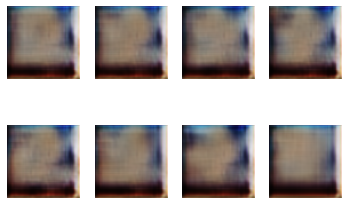

17001 [D loss: 0.711945, acc.: 95.31%, op_acc: 67.11%] [G loss: 1.001165]
17002 [D loss: 0.641369, acc.: 98.44%, op_acc: 69.30%] [G loss: 0.994151]
17003 [D loss: 0.671497, acc.: 96.88%, op_acc: 65.66%] [G loss: 1.078311]
17004 [D loss: 0.873465, acc.: 95.31%, op_acc: 66.60%] [G loss: 1.147031]
17005 [D loss: 0.773080, acc.: 92.19%, op_acc: 67.27%] [G loss: 1.121904]
17006 [D loss: 0.741323, acc.: 93.75%, op_acc: 68.24%] [G loss: 1.123742]
17007 [D loss: 0.681877, acc.: 93.75%, op_acc: 66.99%] [G loss: 1.398454]
17008 [D loss: 0.623175, acc.: 98.44%, op_acc: 68.32%] [G loss: 1.362670]
17009 [D loss: 0.739035, acc.: 95.31%, op_acc: 66.60%] [G loss: 1.120433]
17010 [D loss: 1.076066, acc.: 85.94%, op_acc: 65.86%] [G loss: 1.240721]
17011 [D loss: 0.966870, acc.: 90.62%, op_acc: 64.10%] [G loss: 1.256784]
17012 [D loss: 1.031456, acc.: 85.94%, op_acc: 65.66%] [G loss: 1.155254]
17013 [D loss: 1.015041, acc.: 85.94%, op_acc: 64.65%] [G loss: 1.138171]
17014 [D loss: 1.009492, acc.: 90.62%,

17113 [D loss: 0.691615, acc.: 96.88%, op_acc: 66.33%] [G loss: 0.920516]
17114 [D loss: 0.671234, acc.: 100.00%, op_acc: 67.70%] [G loss: 0.964299]
17115 [D loss: 0.669975, acc.: 98.44%, op_acc: 66.45%] [G loss: 0.912943]
17116 [D loss: 0.688790, acc.: 96.88%, op_acc: 66.52%] [G loss: 0.934633]
17117 [D loss: 0.681157, acc.: 96.88%, op_acc: 69.10%] [G loss: 0.890352]
17118 [D loss: 0.653056, acc.: 100.00%, op_acc: 67.73%] [G loss: 0.907383]
17119 [D loss: 0.698726, acc.: 96.88%, op_acc: 66.48%] [G loss: 0.917139]
17120 [D loss: 0.651758, acc.: 98.44%, op_acc: 67.07%] [G loss: 0.909178]
17121 [D loss: 0.729735, acc.: 96.88%, op_acc: 66.17%] [G loss: 0.909769]
17122 [D loss: 0.775421, acc.: 93.75%, op_acc: 67.03%] [G loss: 0.935003]
17123 [D loss: 0.706445, acc.: 96.88%, op_acc: 66.45%] [G loss: 0.879670]
17124 [D loss: 0.671067, acc.: 93.75%, op_acc: 67.81%] [G loss: 0.915426]
17125 [D loss: 0.680743, acc.: 96.88%, op_acc: 65.62%] [G loss: 0.935988]
17126 [D loss: 0.706647, acc.: 98.44

17225 [D loss: 0.550969, acc.: 100.00%, op_acc: 67.62%] [G loss: 0.787973]
17226 [D loss: 0.581283, acc.: 100.00%, op_acc: 66.60%] [G loss: 0.824683]
17227 [D loss: 0.579927, acc.: 98.44%, op_acc: 68.32%] [G loss: 0.820214]
17228 [D loss: 0.586576, acc.: 98.44%, op_acc: 66.02%] [G loss: 0.826032]
17229 [D loss: 0.573211, acc.: 100.00%, op_acc: 68.05%] [G loss: 0.791598]
17230 [D loss: 0.604389, acc.: 98.44%, op_acc: 67.81%] [G loss: 0.816772]
17231 [D loss: 0.613888, acc.: 96.88%, op_acc: 67.54%] [G loss: 0.825738]
17232 [D loss: 0.587622, acc.: 100.00%, op_acc: 66.56%] [G loss: 0.833969]
17233 [D loss: 0.659413, acc.: 96.88%, op_acc: 66.05%] [G loss: 0.795829]
17234 [D loss: 0.602237, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.803134]
17235 [D loss: 0.573079, acc.: 98.44%, op_acc: 68.87%] [G loss: 0.822382]
17236 [D loss: 0.597651, acc.: 98.44%, op_acc: 66.88%] [G loss: 0.814432]
17237 [D loss: 0.636174, acc.: 98.44%, op_acc: 66.68%] [G loss: 0.820208]
17238 [D loss: 0.610781, acc.: 98

17337 [D loss: 1.431425, acc.: 59.38%, op_acc: 62.62%] [G loss: 0.903426]
17338 [D loss: 0.914889, acc.: 89.06%, op_acc: 66.72%] [G loss: 0.949052]
17339 [D loss: 0.961214, acc.: 82.81%, op_acc: 66.64%] [G loss: 0.960936]
17340 [D loss: 1.065447, acc.: 81.25%, op_acc: 65.59%] [G loss: 1.131102]
17341 [D loss: 1.646300, acc.: 54.69%, op_acc: 63.48%] [G loss: 1.281902]
17342 [D loss: 0.999815, acc.: 81.25%, op_acc: 64.96%] [G loss: 1.243029]
17343 [D loss: 1.269555, acc.: 67.19%, op_acc: 64.84%] [G loss: 1.226849]
17344 [D loss: 0.957162, acc.: 85.94%, op_acc: 65.20%] [G loss: 1.221883]
17345 [D loss: 1.101718, acc.: 75.00%, op_acc: 65.00%] [G loss: 1.616358]
17346 [D loss: 1.140871, acc.: 75.00%, op_acc: 65.47%] [G loss: 1.290019]
17347 [D loss: 1.130371, acc.: 79.69%, op_acc: 64.30%] [G loss: 1.173317]
17348 [D loss: 0.957247, acc.: 90.62%, op_acc: 65.35%] [G loss: 1.082494]
17349 [D loss: 0.891925, acc.: 90.62%, op_acc: 68.24%] [G loss: 0.896013]
17350 [D loss: 0.800110, acc.: 92.19%,

17449 [D loss: 0.607413, acc.: 100.00%, op_acc: 66.52%] [G loss: 0.874537]
17450 [D loss: 0.582625, acc.: 100.00%, op_acc: 66.99%] [G loss: 0.859122]
17451 [D loss: 0.723979, acc.: 98.44%, op_acc: 68.40%] [G loss: 0.874062]
17452 [D loss: 0.752125, acc.: 96.88%, op_acc: 67.03%] [G loss: 0.847546]
17453 [D loss: 0.586549, acc.: 100.00%, op_acc: 67.46%] [G loss: 0.859370]
17454 [D loss: 0.671730, acc.: 98.44%, op_acc: 65.12%] [G loss: 0.917160]
17455 [D loss: 0.619199, acc.: 98.44%, op_acc: 68.91%] [G loss: 0.857452]
17456 [D loss: 0.638407, acc.: 98.44%, op_acc: 65.59%] [G loss: 0.884564]
17457 [D loss: 0.595044, acc.: 98.44%, op_acc: 68.01%] [G loss: 0.894791]
17458 [D loss: 0.586251, acc.: 100.00%, op_acc: 68.79%] [G loss: 0.861273]
17459 [D loss: 0.604068, acc.: 98.44%, op_acc: 66.05%] [G loss: 0.850373]
17460 [D loss: 0.687801, acc.: 96.88%, op_acc: 65.59%] [G loss: 0.864106]
17461 [D loss: 0.599747, acc.: 98.44%, op_acc: 68.24%] [G loss: 0.885408]
17462 [D loss: 0.591349, acc.: 98.

17559 [D loss: 0.581375, acc.: 100.00%, op_acc: 68.01%] [G loss: 1.026836]
17560 [D loss: 0.647950, acc.: 98.44%, op_acc: 65.47%] [G loss: 0.977051]
17561 [D loss: 0.690525, acc.: 93.75%, op_acc: 66.48%] [G loss: 1.168200]
17562 [D loss: 0.743046, acc.: 90.62%, op_acc: 67.62%] [G loss: 1.072955]
17563 [D loss: 0.724526, acc.: 92.19%, op_acc: 68.24%] [G loss: 1.252606]
17564 [D loss: 0.649503, acc.: 96.88%, op_acc: 68.16%] [G loss: 1.163798]
17565 [D loss: 0.799625, acc.: 92.19%, op_acc: 67.19%] [G loss: 1.279230]
17566 [D loss: 0.715010, acc.: 95.31%, op_acc: 66.95%] [G loss: 1.118317]
17567 [D loss: 0.722040, acc.: 95.31%, op_acc: 68.40%] [G loss: 1.064165]
17568 [D loss: 0.764754, acc.: 93.75%, op_acc: 65.94%] [G loss: 1.105921]
17569 [D loss: 0.630351, acc.: 100.00%, op_acc: 69.80%] [G loss: 1.318873]
17570 [D loss: 0.677614, acc.: 96.88%, op_acc: 67.66%] [G loss: 1.215286]
17571 [D loss: 0.746043, acc.: 93.75%, op_acc: 68.28%] [G loss: 1.260130]
17572 [D loss: 0.832681, acc.: 89.06

17671 [D loss: 0.613721, acc.: 100.00%, op_acc: 66.87%] [G loss: 0.944934]
17672 [D loss: 0.624215, acc.: 98.44%, op_acc: 66.37%] [G loss: 0.960608]
17673 [D loss: 0.599402, acc.: 100.00%, op_acc: 66.99%] [G loss: 0.933649]
17674 [D loss: 0.627627, acc.: 98.44%, op_acc: 66.95%] [G loss: 0.944244]
17675 [D loss: 0.609819, acc.: 100.00%, op_acc: 66.29%] [G loss: 0.962933]
17676 [D loss: 0.657726, acc.: 98.44%, op_acc: 67.23%] [G loss: 0.953538]
17677 [D loss: 0.613336, acc.: 98.44%, op_acc: 66.91%] [G loss: 0.941211]
17678 [D loss: 0.598229, acc.: 100.00%, op_acc: 66.99%] [G loss: 0.953632]
17679 [D loss: 0.579792, acc.: 98.44%, op_acc: 67.81%] [G loss: 0.926221]
17680 [D loss: 0.600664, acc.: 100.00%, op_acc: 66.64%] [G loss: 0.963031]
17681 [D loss: 0.599466, acc.: 100.00%, op_acc: 67.23%] [G loss: 0.945791]
17682 [D loss: 0.665563, acc.: 98.44%, op_acc: 66.68%] [G loss: 0.924889]
17683 [D loss: 0.819368, acc.: 95.31%, op_acc: 64.02%] [G loss: 0.963504]
17684 [D loss: 0.630127, acc.: 1

17783 [D loss: 0.614800, acc.: 98.44%, op_acc: 67.93%] [G loss: 0.871280]
17784 [D loss: 0.579337, acc.: 100.00%, op_acc: 69.02%] [G loss: 0.983783]
17785 [D loss: 0.731495, acc.: 95.31%, op_acc: 67.11%] [G loss: 0.968350]
17786 [D loss: 0.579864, acc.: 100.00%, op_acc: 66.91%] [G loss: 0.928518]
17787 [D loss: 0.553970, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.935588]
17788 [D loss: 0.569698, acc.: 100.00%, op_acc: 67.27%] [G loss: 0.959503]
17789 [D loss: 0.596228, acc.: 100.00%, op_acc: 66.13%] [G loss: 0.906371]
17790 [D loss: 0.557341, acc.: 100.00%, op_acc: 67.70%] [G loss: 0.916853]
17791 [D loss: 0.636464, acc.: 96.88%, op_acc: 66.48%] [G loss: 0.951348]
17792 [D loss: 0.610330, acc.: 96.88%, op_acc: 67.46%] [G loss: 0.927667]
17793 [D loss: 0.585275, acc.: 100.00%, op_acc: 66.33%] [G loss: 0.883367]
17794 [D loss: 0.565648, acc.: 100.00%, op_acc: 68.09%] [G loss: 0.940820]
17795 [D loss: 0.584586, acc.: 98.44%, op_acc: 66.05%] [G loss: 0.920555]
17796 [D loss: 0.615206, acc.:

17895 [D loss: 1.022163, acc.: 89.06%, op_acc: 63.75%] [G loss: 1.031999]
17896 [D loss: 0.918353, acc.: 90.62%, op_acc: 65.20%] [G loss: 1.034020]
17897 [D loss: 0.923044, acc.: 95.31%, op_acc: 64.73%] [G loss: 1.038471]
17898 [D loss: 1.011498, acc.: 85.94%, op_acc: 64.80%] [G loss: 1.086035]
17899 [D loss: 0.893999, acc.: 89.06%, op_acc: 63.87%] [G loss: 1.089605]
17900 [D loss: 0.737985, acc.: 95.31%, op_acc: 66.05%] [G loss: 1.115769]
17901 [D loss: 0.801072, acc.: 93.75%, op_acc: 64.88%] [G loss: 1.098634]
17902 [D loss: 0.814085, acc.: 92.19%, op_acc: 65.20%] [G loss: 1.120692]
17903 [D loss: 0.827699, acc.: 93.75%, op_acc: 65.08%] [G loss: 1.199291]
17904 [D loss: 0.929420, acc.: 90.62%, op_acc: 63.44%] [G loss: 1.204199]
17905 [D loss: 0.782854, acc.: 95.31%, op_acc: 64.61%] [G loss: 1.376599]
17906 [D loss: 0.844882, acc.: 93.75%, op_acc: 65.86%] [G loss: 1.247979]
17907 [D loss: 0.802520, acc.: 96.88%, op_acc: 64.73%] [G loss: 1.537678]
17908 [D loss: 0.697354, acc.: 100.00%

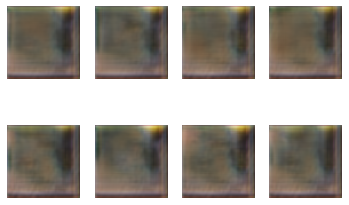

18001 [D loss: 0.554318, acc.: 100.00%, op_acc: 66.56%] [G loss: 0.936682]
18002 [D loss: 0.601409, acc.: 98.44%, op_acc: 66.56%] [G loss: 0.961677]
18003 [D loss: 0.575200, acc.: 100.00%, op_acc: 67.03%] [G loss: 0.976409]
18004 [D loss: 0.588802, acc.: 98.44%, op_acc: 66.72%] [G loss: 0.994503]
18005 [D loss: 0.565279, acc.: 100.00%, op_acc: 67.30%] [G loss: 0.986487]
18006 [D loss: 0.561615, acc.: 100.00%, op_acc: 67.19%] [G loss: 0.969424]
18007 [D loss: 0.550311, acc.: 100.00%, op_acc: 66.37%] [G loss: 0.960509]
18008 [D loss: 0.566790, acc.: 100.00%, op_acc: 66.52%] [G loss: 0.908497]
18009 [D loss: 0.583744, acc.: 100.00%, op_acc: 66.13%] [G loss: 0.996527]
18010 [D loss: 0.567249, acc.: 100.00%, op_acc: 69.02%] [G loss: 0.936120]
18011 [D loss: 0.588434, acc.: 98.44%, op_acc: 67.50%] [G loss: 0.956264]
18012 [D loss: 0.568872, acc.: 100.00%, op_acc: 66.25%] [G loss: 0.954833]
18013 [D loss: 0.556353, acc.: 100.00%, op_acc: 68.12%] [G loss: 0.939006]
18014 [D loss: 0.596094, acc

18111 [D loss: 0.639236, acc.: 98.44%, op_acc: 67.07%] [G loss: 0.961338]
18112 [D loss: 0.659949, acc.: 98.44%, op_acc: 67.70%] [G loss: 0.960439]
18113 [D loss: 0.628716, acc.: 96.88%, op_acc: 68.83%] [G loss: 0.952727]
18114 [D loss: 0.736199, acc.: 95.31%, op_acc: 68.24%] [G loss: 0.920271]
18115 [D loss: 0.618765, acc.: 100.00%, op_acc: 64.53%] [G loss: 0.976462]
18116 [D loss: 0.622924, acc.: 100.00%, op_acc: 66.17%] [G loss: 0.937076]
18117 [D loss: 0.627679, acc.: 98.44%, op_acc: 65.35%] [G loss: 0.951045]
18118 [D loss: 0.587107, acc.: 100.00%, op_acc: 67.70%] [G loss: 0.937005]
18119 [D loss: 0.603297, acc.: 100.00%, op_acc: 66.64%] [G loss: 0.940674]
18120 [D loss: 0.576570, acc.: 100.00%, op_acc: 69.14%] [G loss: 0.936482]
18121 [D loss: 0.614607, acc.: 98.44%, op_acc: 65.94%] [G loss: 0.989889]
18122 [D loss: 0.603817, acc.: 100.00%, op_acc: 66.72%] [G loss: 0.928258]
18123 [D loss: 0.613227, acc.: 98.44%, op_acc: 67.07%] [G loss: 0.965698]
18124 [D loss: 0.615952, acc.: 9

18221 [D loss: 0.579090, acc.: 100.00%, op_acc: 66.68%] [G loss: 0.891248]
18222 [D loss: 0.564812, acc.: 100.00%, op_acc: 66.05%] [G loss: 0.893757]
18223 [D loss: 0.590412, acc.: 98.44%, op_acc: 66.91%] [G loss: 0.943146]
18224 [D loss: 0.554612, acc.: 100.00%, op_acc: 67.42%] [G loss: 0.875441]
18225 [D loss: 0.570506, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.866775]
18226 [D loss: 0.555906, acc.: 100.00%, op_acc: 68.32%] [G loss: 0.890681]
18227 [D loss: 0.550285, acc.: 100.00%, op_acc: 67.70%] [G loss: 0.894298]
18228 [D loss: 0.560090, acc.: 100.00%, op_acc: 67.15%] [G loss: 0.918936]
18229 [D loss: 0.566829, acc.: 100.00%, op_acc: 67.19%] [G loss: 0.924558]
18230 [D loss: 0.557122, acc.: 100.00%, op_acc: 67.62%] [G loss: 0.891528]
18231 [D loss: 0.567385, acc.: 100.00%, op_acc: 66.13%] [G loss: 0.879458]
18232 [D loss: 0.575160, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.919124]
18233 [D loss: 0.555811, acc.: 100.00%, op_acc: 65.70%] [G loss: 0.905208]
18234 [D loss: 0.538725, a

18331 [D loss: 0.588127, acc.: 98.44%, op_acc: 66.41%] [G loss: 1.401275]
18332 [D loss: 0.979299, acc.: 84.38%, op_acc: 64.88%] [G loss: 2.838181]
18333 [D loss: 0.588661, acc.: 100.00%, op_acc: 64.69%] [G loss: 3.938636]
18334 [D loss: 1.095894, acc.: 89.06%, op_acc: 66.37%] [G loss: 2.364466]
18335 [D loss: 0.774703, acc.: 92.19%, op_acc: 65.16%] [G loss: 5.279531]
18336 [D loss: 0.750480, acc.: 92.19%, op_acc: 66.13%] [G loss: 4.283267]
18337 [D loss: 0.923899, acc.: 90.62%, op_acc: 67.46%] [G loss: 5.524517]
18338 [D loss: 0.905938, acc.: 93.75%, op_acc: 65.31%] [G loss: 3.174514]
18339 [D loss: 2.005418, acc.: 43.75%, op_acc: 64.34%] [G loss: 6.795807]
18340 [D loss: 2.701059, acc.: 70.31%, op_acc: 54.61%] [G loss: 1.372553]
18341 [D loss: 1.767072, acc.: 50.00%, op_acc: 63.28%] [G loss: 0.974926]
18342 [D loss: 0.998506, acc.: 84.38%, op_acc: 66.41%] [G loss: 1.024998]
18343 [D loss: 1.282292, acc.: 79.69%, op_acc: 64.80%] [G loss: 0.984953]
18344 [D loss: 1.091160, acc.: 78.12%

18442 [D loss: 0.560800, acc.: 100.00%, op_acc: 68.87%] [G loss: 0.910080]
18443 [D loss: 0.608180, acc.: 98.44%, op_acc: 67.89%] [G loss: 0.886423]
18444 [D loss: 0.592254, acc.: 98.44%, op_acc: 67.89%] [G loss: 0.886348]
18445 [D loss: 0.575202, acc.: 100.00%, op_acc: 65.74%] [G loss: 0.879880]
18446 [D loss: 0.601834, acc.: 100.00%, op_acc: 66.17%] [G loss: 0.898889]
18447 [D loss: 0.578062, acc.: 100.00%, op_acc: 64.80%] [G loss: 0.913561]
18448 [D loss: 0.582172, acc.: 100.00%, op_acc: 66.72%] [G loss: 0.851446]
18449 [D loss: 0.566732, acc.: 100.00%, op_acc: 67.46%] [G loss: 0.950072]
18450 [D loss: 0.593586, acc.: 100.00%, op_acc: 66.02%] [G loss: 0.923498]
18451 [D loss: 0.569479, acc.: 100.00%, op_acc: 67.73%] [G loss: 0.998332]
18452 [D loss: 0.640297, acc.: 95.31%, op_acc: 67.73%] [G loss: 0.908632]
18453 [D loss: 0.558987, acc.: 100.00%, op_acc: 67.62%] [G loss: 0.897547]
18454 [D loss: 0.579661, acc.: 100.00%, op_acc: 66.68%] [G loss: 0.891476]
18455 [D loss: 0.559429, acc

18552 [D loss: 0.635292, acc.: 98.44%, op_acc: 66.76%] [G loss: 0.928192]
18553 [D loss: 0.602746, acc.: 100.00%, op_acc: 66.87%] [G loss: 0.895090]
18554 [D loss: 0.582877, acc.: 100.00%, op_acc: 67.15%] [G loss: 0.959115]
18555 [D loss: 0.622873, acc.: 98.44%, op_acc: 66.45%] [G loss: 0.981524]
18556 [D loss: 0.579425, acc.: 100.00%, op_acc: 67.89%] [G loss: 0.933536]
18557 [D loss: 0.575163, acc.: 100.00%, op_acc: 67.73%] [G loss: 0.902814]
18558 [D loss: 0.578476, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.959986]
18559 [D loss: 0.580756, acc.: 100.00%, op_acc: 68.63%] [G loss: 0.973522]
18560 [D loss: 0.623747, acc.: 98.44%, op_acc: 65.27%] [G loss: 1.005784]
18561 [D loss: 0.582622, acc.: 100.00%, op_acc: 68.55%] [G loss: 0.957004]
18562 [D loss: 0.601765, acc.: 98.44%, op_acc: 67.66%] [G loss: 0.953176]
18563 [D loss: 0.613524, acc.: 100.00%, op_acc: 66.09%] [G loss: 0.960489]
18564 [D loss: 0.595117, acc.: 98.44%, op_acc: 66.99%] [G loss: 0.972791]
18565 [D loss: 0.623743, acc.:

18664 [D loss: 0.684791, acc.: 96.88%, op_acc: 65.86%] [G loss: 0.960224]
18665 [D loss: 0.682184, acc.: 98.44%, op_acc: 67.73%] [G loss: 1.122700]
18666 [D loss: 0.842203, acc.: 92.19%, op_acc: 65.86%] [G loss: 1.553353]
18667 [D loss: 0.663934, acc.: 96.88%, op_acc: 68.24%] [G loss: 1.219103]
18668 [D loss: 0.921438, acc.: 87.50%, op_acc: 67.70%] [G loss: 1.147483]
18669 [D loss: 0.705449, acc.: 96.88%, op_acc: 66.33%] [G loss: 1.356771]
18670 [D loss: 0.968946, acc.: 82.81%, op_acc: 65.43%] [G loss: 1.148167]
18671 [D loss: 0.720405, acc.: 95.31%, op_acc: 65.43%] [G loss: 1.115792]
18672 [D loss: 0.745383, acc.: 95.31%, op_acc: 66.48%] [G loss: 1.018220]
18673 [D loss: 0.765794, acc.: 95.31%, op_acc: 67.89%] [G loss: 1.052615]
18674 [D loss: 0.792232, acc.: 93.75%, op_acc: 65.55%] [G loss: 0.995088]
18675 [D loss: 1.016653, acc.: 85.94%, op_acc: 65.74%] [G loss: 0.948471]
18676 [D loss: 0.692978, acc.: 96.88%, op_acc: 66.25%] [G loss: 0.933824]
18677 [D loss: 0.678045, acc.: 95.31%,

18776 [D loss: 0.827628, acc.: 87.50%, op_acc: 68.05%] [G loss: 1.971872]
18777 [D loss: 1.252452, acc.: 57.81%, op_acc: 65.82%] [G loss: 4.133890]
18778 [D loss: 0.833766, acc.: 87.50%, op_acc: 65.55%] [G loss: 3.389835]
18779 [D loss: 0.956694, acc.: 84.38%, op_acc: 65.04%] [G loss: 1.437008]
18780 [D loss: 0.986904, acc.: 82.81%, op_acc: 66.25%] [G loss: 1.155733]
18781 [D loss: 0.800656, acc.: 93.75%, op_acc: 64.49%] [G loss: 1.270957]
18782 [D loss: 0.741413, acc.: 95.31%, op_acc: 67.89%] [G loss: 1.096398]
18783 [D loss: 0.698220, acc.: 98.44%, op_acc: 66.45%] [G loss: 1.153954]
18784 [D loss: 0.733955, acc.: 93.75%, op_acc: 66.25%] [G loss: 1.095494]
18785 [D loss: 0.666777, acc.: 96.88%, op_acc: 66.87%] [G loss: 1.120173]
18786 [D loss: 0.675678, acc.: 100.00%, op_acc: 67.19%] [G loss: 1.067317]
18787 [D loss: 0.677017, acc.: 98.44%, op_acc: 65.23%] [G loss: 1.219376]
18788 [D loss: 0.622115, acc.: 98.44%, op_acc: 68.59%] [G loss: 1.190515]
18789 [D loss: 0.744196, acc.: 96.88%

18888 [D loss: 0.673529, acc.: 96.88%, op_acc: 66.76%] [G loss: 1.004375]
18889 [D loss: 0.617238, acc.: 98.44%, op_acc: 66.05%] [G loss: 0.977465]
18890 [D loss: 0.627427, acc.: 98.44%, op_acc: 67.46%] [G loss: 1.036235]
18891 [D loss: 0.609742, acc.: 100.00%, op_acc: 66.29%] [G loss: 0.989340]
18892 [D loss: 0.662291, acc.: 96.88%, op_acc: 66.84%] [G loss: 0.926608]
18893 [D loss: 0.649437, acc.: 96.88%, op_acc: 68.71%] [G loss: 0.942506]
18894 [D loss: 0.580490, acc.: 100.00%, op_acc: 67.34%] [G loss: 0.937946]
18895 [D loss: 0.606779, acc.: 100.00%, op_acc: 67.27%] [G loss: 1.025710]
18896 [D loss: 0.599965, acc.: 98.44%, op_acc: 68.40%] [G loss: 0.944701]
18897 [D loss: 0.604868, acc.: 98.44%, op_acc: 68.40%] [G loss: 0.944348]
18898 [D loss: 0.636893, acc.: 98.44%, op_acc: 67.58%] [G loss: 0.947033]
18899 [D loss: 0.617293, acc.: 98.44%, op_acc: 66.33%] [G loss: 0.977967]
18900 [D loss: 0.592917, acc.: 100.00%, op_acc: 66.45%] [G loss: 0.948945]
18901 [D loss: 0.648779, acc.: 96.

19000 [D loss: 0.687944, acc.: 98.44%, op_acc: 67.54%] [G loss: 0.957644]
(8, 64, 64, 3)


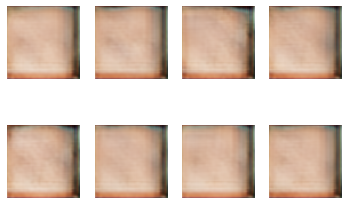

19001 [D loss: 0.688515, acc.: 93.75%, op_acc: 68.28%] [G loss: 0.937089]
19002 [D loss: 0.664302, acc.: 98.44%, op_acc: 66.76%] [G loss: 0.936444]
19003 [D loss: 0.647228, acc.: 96.88%, op_acc: 66.05%] [G loss: 0.960889]
19004 [D loss: 0.705025, acc.: 96.88%, op_acc: 65.51%] [G loss: 0.939643]
19005 [D loss: 0.701664, acc.: 95.31%, op_acc: 67.15%] [G loss: 0.931216]
19006 [D loss: 0.708220, acc.: 96.88%, op_acc: 66.37%] [G loss: 0.912859]
19007 [D loss: 0.631241, acc.: 98.44%, op_acc: 66.45%] [G loss: 0.979322]
19008 [D loss: 0.662857, acc.: 98.44%, op_acc: 68.09%] [G loss: 0.919037]
19009 [D loss: 0.631992, acc.: 100.00%, op_acc: 66.91%] [G loss: 0.913593]
19010 [D loss: 0.628916, acc.: 98.44%, op_acc: 66.09%] [G loss: 0.919095]
19011 [D loss: 0.626415, acc.: 98.44%, op_acc: 66.33%] [G loss: 0.949015]
19012 [D loss: 0.814391, acc.: 96.88%, op_acc: 64.92%] [G loss: 0.914485]
19013 [D loss: 0.673189, acc.: 98.44%, op_acc: 67.85%] [G loss: 0.896314]
19014 [D loss: 0.703820, acc.: 95.31%

19113 [D loss: 0.759675, acc.: 92.19%, op_acc: 65.82%] [G loss: 1.585161]
19114 [D loss: 1.258108, acc.: 82.81%, op_acc: 63.48%] [G loss: 1.462507]
19115 [D loss: 1.308299, acc.: 67.19%, op_acc: 65.39%] [G loss: 1.796713]
19116 [D loss: 1.206151, acc.: 70.31%, op_acc: 66.99%] [G loss: 2.250010]
19117 [D loss: 1.222780, acc.: 71.88%, op_acc: 65.74%] [G loss: 1.987208]
19118 [D loss: 1.636749, acc.: 59.38%, op_acc: 63.28%] [G loss: 1.822640]
19119 [D loss: 1.547509, acc.: 54.69%, op_acc: 65.51%] [G loss: 2.223539]
19120 [D loss: 1.609497, acc.: 54.69%, op_acc: 62.15%] [G loss: 1.797680]
19121 [D loss: 1.912373, acc.: 35.94%, op_acc: 64.10%] [G loss: 1.105633]
19122 [D loss: 1.570674, acc.: 56.25%, op_acc: 64.84%] [G loss: 1.028719]
19123 [D loss: 1.228891, acc.: 76.56%, op_acc: 65.82%] [G loss: 1.013198]
19124 [D loss: 1.166147, acc.: 81.25%, op_acc: 64.92%] [G loss: 1.038407]
19125 [D loss: 1.141892, acc.: 78.12%, op_acc: 64.61%] [G loss: 1.018925]
19126 [D loss: 0.946337, acc.: 92.19%,

19225 [D loss: 0.565631, acc.: 100.00%, op_acc: 67.30%] [G loss: 0.928229]
19226 [D loss: 0.550591, acc.: 100.00%, op_acc: 68.63%] [G loss: 0.937174]
19227 [D loss: 0.572563, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.925947]
19228 [D loss: 0.656275, acc.: 96.88%, op_acc: 68.44%] [G loss: 0.958881]
19229 [D loss: 0.564693, acc.: 100.00%, op_acc: 69.41%] [G loss: 0.921222]
19230 [D loss: 0.564917, acc.: 100.00%, op_acc: 67.34%] [G loss: 0.960556]
19231 [D loss: 0.567527, acc.: 100.00%, op_acc: 67.85%] [G loss: 0.922939]
19232 [D loss: 0.555616, acc.: 100.00%, op_acc: 67.73%] [G loss: 0.911303]
19233 [D loss: 0.596892, acc.: 98.44%, op_acc: 67.23%] [G loss: 0.899199]
19234 [D loss: 0.595771, acc.: 100.00%, op_acc: 66.05%] [G loss: 0.935033]
19235 [D loss: 0.576604, acc.: 100.00%, op_acc: 68.05%] [G loss: 0.983804]
19236 [D loss: 0.574649, acc.: 98.44%, op_acc: 66.60%] [G loss: 0.887579]
19237 [D loss: 0.550378, acc.: 100.00%, op_acc: 68.87%] [G loss: 0.913877]
19238 [D loss: 0.582724, acc

19337 [D loss: 0.786782, acc.: 92.19%, op_acc: 67.07%] [G loss: 1.163627]
19338 [D loss: 0.929171, acc.: 90.62%, op_acc: 66.37%] [G loss: 0.997499]
19339 [D loss: 0.980055, acc.: 84.38%, op_acc: 67.42%] [G loss: 0.969956]
19340 [D loss: 0.773680, acc.: 90.62%, op_acc: 66.60%] [G loss: 1.015235]
19341 [D loss: 0.813360, acc.: 95.31%, op_acc: 65.70%] [G loss: 1.004195]
19342 [D loss: 0.709389, acc.: 95.31%, op_acc: 65.94%] [G loss: 0.986520]
19343 [D loss: 0.625918, acc.: 96.88%, op_acc: 66.91%] [G loss: 1.019603]
19344 [D loss: 0.597868, acc.: 98.44%, op_acc: 68.52%] [G loss: 0.962099]
19345 [D loss: 0.616011, acc.: 100.00%, op_acc: 67.89%] [G loss: 0.963465]
19346 [D loss: 0.654967, acc.: 96.88%, op_acc: 67.34%] [G loss: 0.928381]
19347 [D loss: 0.688369, acc.: 92.19%, op_acc: 66.64%] [G loss: 0.989717]
19348 [D loss: 0.685668, acc.: 96.88%, op_acc: 65.51%] [G loss: 0.947804]
19349 [D loss: 0.680177, acc.: 96.88%, op_acc: 66.52%] [G loss: 1.013918]
19350 [D loss: 0.595419, acc.: 100.00

19449 [D loss: 0.612620, acc.: 98.44%, op_acc: 68.16%] [G loss: 0.905286]
19450 [D loss: 0.616854, acc.: 98.44%, op_acc: 67.54%] [G loss: 0.925386]
19451 [D loss: 0.611476, acc.: 98.44%, op_acc: 66.13%] [G loss: 0.943750]
19452 [D loss: 0.606814, acc.: 98.44%, op_acc: 66.64%] [G loss: 0.884311]
19453 [D loss: 0.572084, acc.: 100.00%, op_acc: 66.72%] [G loss: 0.983908]
19454 [D loss: 0.618463, acc.: 96.88%, op_acc: 67.46%] [G loss: 0.900892]
19455 [D loss: 0.594506, acc.: 100.00%, op_acc: 68.87%] [G loss: 0.945654]
19456 [D loss: 0.588174, acc.: 100.00%, op_acc: 68.09%] [G loss: 0.916675]
19457 [D loss: 0.592948, acc.: 100.00%, op_acc: 65.31%] [G loss: 0.963210]
19458 [D loss: 0.575536, acc.: 100.00%, op_acc: 68.71%] [G loss: 0.922178]
19459 [D loss: 0.569252, acc.: 100.00%, op_acc: 68.36%] [G loss: 0.966189]
19460 [D loss: 0.743842, acc.: 95.31%, op_acc: 65.23%] [G loss: 0.914031]
19461 [D loss: 0.584014, acc.: 100.00%, op_acc: 68.20%] [G loss: 0.927106]
19462 [D loss: 0.576637, acc.: 

19560 [D loss: 0.584107, acc.: 100.00%, op_acc: 67.03%] [G loss: 0.911300]
19561 [D loss: 0.579182, acc.: 98.44%, op_acc: 67.23%] [G loss: 0.947115]
19562 [D loss: 0.568516, acc.: 100.00%, op_acc: 68.71%] [G loss: 0.907697]
19563 [D loss: 0.561755, acc.: 100.00%, op_acc: 67.93%] [G loss: 0.906711]
19564 [D loss: 0.562244, acc.: 100.00%, op_acc: 67.70%] [G loss: 0.923296]
19565 [D loss: 0.614609, acc.: 98.44%, op_acc: 68.32%] [G loss: 0.919383]
19566 [D loss: 0.590201, acc.: 98.44%, op_acc: 66.80%] [G loss: 0.919506]
19567 [D loss: 0.561721, acc.: 100.00%, op_acc: 68.05%] [G loss: 0.913975]
19568 [D loss: 0.544833, acc.: 100.00%, op_acc: 68.63%] [G loss: 0.925108]
19569 [D loss: 0.661118, acc.: 98.44%, op_acc: 67.50%] [G loss: 0.902073]
19570 [D loss: 0.610299, acc.: 98.44%, op_acc: 67.81%] [G loss: 0.939707]
19571 [D loss: 0.599507, acc.: 100.00%, op_acc: 66.68%] [G loss: 0.961996]
19572 [D loss: 0.567537, acc.: 100.00%, op_acc: 66.72%] [G loss: 0.896204]
19573 [D loss: 0.561456, acc.:

19670 [D loss: 0.794915, acc.: 93.75%, op_acc: 66.64%] [G loss: 0.985807]
19671 [D loss: 0.718760, acc.: 95.31%, op_acc: 65.12%] [G loss: 1.046152]
19672 [D loss: 0.619755, acc.: 98.44%, op_acc: 66.84%] [G loss: 1.030736]
19673 [D loss: 0.602064, acc.: 100.00%, op_acc: 68.40%] [G loss: 1.063532]
19674 [D loss: 0.746763, acc.: 92.19%, op_acc: 67.81%] [G loss: 1.009167]
19675 [D loss: 0.623311, acc.: 98.44%, op_acc: 67.66%] [G loss: 1.010498]
19676 [D loss: 0.598176, acc.: 98.44%, op_acc: 68.79%] [G loss: 1.045099]
19677 [D loss: 0.615034, acc.: 100.00%, op_acc: 66.05%] [G loss: 0.992118]
19678 [D loss: 0.769443, acc.: 95.31%, op_acc: 66.21%] [G loss: 0.998649]
19679 [D loss: 0.631875, acc.: 100.00%, op_acc: 66.80%] [G loss: 1.010456]
19680 [D loss: 0.656359, acc.: 96.88%, op_acc: 67.03%] [G loss: 1.005097]
19681 [D loss: 0.577108, acc.: 100.00%, op_acc: 68.87%] [G loss: 1.041826]
19682 [D loss: 0.653578, acc.: 95.31%, op_acc: 67.19%] [G loss: 0.999905]
19683 [D loss: 0.652255, acc.: 98.

19780 [D loss: 0.558757, acc.: 100.00%, op_acc: 67.85%] [G loss: 0.907241]
19781 [D loss: 0.645620, acc.: 98.44%, op_acc: 65.74%] [G loss: 0.906969]
19782 [D loss: 0.591594, acc.: 98.44%, op_acc: 68.67%] [G loss: 0.871535]
19783 [D loss: 0.560106, acc.: 100.00%, op_acc: 65.78%] [G loss: 0.930349]
19784 [D loss: 0.613534, acc.: 98.44%, op_acc: 68.09%] [G loss: 0.907378]
19785 [D loss: 0.569406, acc.: 100.00%, op_acc: 69.06%] [G loss: 0.883810]
19786 [D loss: 0.606487, acc.: 100.00%, op_acc: 65.74%] [G loss: 0.899572]
19787 [D loss: 0.567633, acc.: 100.00%, op_acc: 66.76%] [G loss: 1.070407]
19788 [D loss: 0.611150, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.960588]
19789 [D loss: 0.609696, acc.: 98.44%, op_acc: 66.21%] [G loss: 0.900546]
19790 [D loss: 0.582107, acc.: 100.00%, op_acc: 67.73%] [G loss: 0.933001]
19791 [D loss: 0.583873, acc.: 98.44%, op_acc: 68.24%] [G loss: 0.945316]
19792 [D loss: 0.624192, acc.: 96.88%, op_acc: 66.33%] [G loss: 0.982716]
19793 [D loss: 0.580299, acc.: 

19892 [D loss: 0.645358, acc.: 98.44%, op_acc: 66.88%] [G loss: 1.017225]
19893 [D loss: 0.770547, acc.: 92.19%, op_acc: 66.25%] [G loss: 1.071379]
19894 [D loss: 0.643500, acc.: 100.00%, op_acc: 65.08%] [G loss: 1.094483]
19895 [D loss: 1.202157, acc.: 73.44%, op_acc: 66.05%] [G loss: 1.326609]
19896 [D loss: 0.910407, acc.: 89.06%, op_acc: 66.33%] [G loss: 0.937575]
19897 [D loss: 1.240291, acc.: 62.50%, op_acc: 66.37%] [G loss: 1.042357]
19898 [D loss: 0.960933, acc.: 89.06%, op_acc: 64.34%] [G loss: 0.922554]
19899 [D loss: 1.244515, acc.: 78.12%, op_acc: 64.73%] [G loss: 0.974889]
19900 [D loss: 0.855118, acc.: 87.50%, op_acc: 66.48%] [G loss: 1.273414]
19901 [D loss: 0.801835, acc.: 90.62%, op_acc: 67.77%] [G loss: 1.407125]
19902 [D loss: 0.984767, acc.: 82.81%, op_acc: 67.03%] [G loss: 2.519474]
19903 [D loss: 0.895573, acc.: 89.06%, op_acc: 65.98%] [G loss: 5.795951]
19904 [D loss: 0.955146, acc.: 85.94%, op_acc: 66.13%] [G loss: 3.630025]
19905 [D loss: 2.228091, acc.: 35.94%

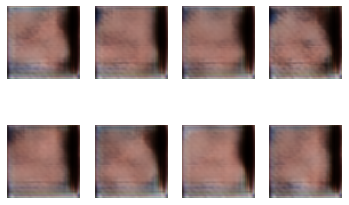

20001 [D loss: 0.612184, acc.: 100.00%, op_acc: 67.15%] [G loss: 0.941047]
20002 [D loss: 0.608667, acc.: 100.00%, op_acc: 65.82%] [G loss: 1.037024]
20003 [D loss: 0.605707, acc.: 98.44%, op_acc: 67.03%] [G loss: 0.824115]
20004 [D loss: 0.593887, acc.: 100.00%, op_acc: 67.11%] [G loss: 0.872211]
20005 [D loss: 0.600125, acc.: 98.44%, op_acc: 67.58%] [G loss: 0.829551]
20006 [D loss: 0.673130, acc.: 96.88%, op_acc: 65.55%] [G loss: 0.852038]
20007 [D loss: 0.600144, acc.: 98.44%, op_acc: 66.72%] [G loss: 0.860833]
20008 [D loss: 0.578777, acc.: 100.00%, op_acc: 67.27%] [G loss: 0.921563]
20009 [D loss: 0.614354, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.865977]
20010 [D loss: 0.604369, acc.: 98.44%, op_acc: 66.80%] [G loss: 0.891778]
20011 [D loss: 0.578918, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.859704]
20012 [D loss: 0.605170, acc.: 98.44%, op_acc: 67.93%] [G loss: 0.929183]
20013 [D loss: 0.631435, acc.: 98.44%, op_acc: 67.62%] [G loss: 0.855737]
20014 [D loss: 0.710843, acc.: 9

20113 [D loss: 0.879770, acc.: 95.31%, op_acc: 67.23%] [G loss: 1.113936]
20114 [D loss: 0.858575, acc.: 90.62%, op_acc: 66.76%] [G loss: 1.050047]
20115 [D loss: 0.752568, acc.: 96.88%, op_acc: 66.80%] [G loss: 1.073786]
20116 [D loss: 0.830241, acc.: 92.19%, op_acc: 67.46%] [G loss: 1.056835]
20117 [D loss: 0.781185, acc.: 93.75%, op_acc: 65.20%] [G loss: 1.048292]
20118 [D loss: 0.737930, acc.: 93.75%, op_acc: 66.48%] [G loss: 1.090121]
20119 [D loss: 0.830242, acc.: 95.31%, op_acc: 65.51%] [G loss: 1.032474]
20120 [D loss: 0.624599, acc.: 100.00%, op_acc: 67.46%] [G loss: 1.099066]
20121 [D loss: 0.651065, acc.: 96.88%, op_acc: 66.52%] [G loss: 1.030861]
20122 [D loss: 0.626803, acc.: 98.44%, op_acc: 67.42%] [G loss: 1.081501]
20123 [D loss: 0.661734, acc.: 98.44%, op_acc: 67.23%] [G loss: 1.075359]
20124 [D loss: 0.615440, acc.: 100.00%, op_acc: 66.13%] [G loss: 1.080604]
20125 [D loss: 0.635761, acc.: 98.44%, op_acc: 67.19%] [G loss: 1.156928]
20126 [D loss: 0.601393, acc.: 100.0

20225 [D loss: 0.884978, acc.: 89.06%, op_acc: 66.80%] [G loss: 1.050095]
20226 [D loss: 0.835242, acc.: 92.19%, op_acc: 66.25%] [G loss: 1.038718]
20227 [D loss: 1.025494, acc.: 87.50%, op_acc: 65.59%] [G loss: 1.008117]
20228 [D loss: 0.857772, acc.: 90.62%, op_acc: 65.20%] [G loss: 0.961522]
20229 [D loss: 0.856919, acc.: 92.19%, op_acc: 66.76%] [G loss: 0.988883]
20230 [D loss: 0.936331, acc.: 90.62%, op_acc: 66.17%] [G loss: 1.002808]
20231 [D loss: 0.801777, acc.: 92.19%, op_acc: 66.05%] [G loss: 0.972062]
20232 [D loss: 0.817936, acc.: 92.19%, op_acc: 67.54%] [G loss: 1.004931]
20233 [D loss: 0.753100, acc.: 93.75%, op_acc: 67.11%] [G loss: 0.967878]
20234 [D loss: 0.826642, acc.: 95.31%, op_acc: 65.08%] [G loss: 0.977818]
20235 [D loss: 0.698709, acc.: 93.75%, op_acc: 67.15%] [G loss: 0.980775]
20236 [D loss: 0.950059, acc.: 89.06%, op_acc: 66.95%] [G loss: 0.948761]
20237 [D loss: 0.912399, acc.: 92.19%, op_acc: 66.09%] [G loss: 1.051019]
20238 [D loss: 0.748551, acc.: 95.31%,

20337 [D loss: 0.696052, acc.: 98.44%, op_acc: 65.90%] [G loss: 2.438750]
20338 [D loss: 1.082785, acc.: 90.62%, op_acc: 64.26%] [G loss: 2.150288]
20339 [D loss: 0.774425, acc.: 95.31%, op_acc: 66.95%] [G loss: 2.254045]
20340 [D loss: 0.919986, acc.: 90.62%, op_acc: 65.27%] [G loss: 2.047195]
20341 [D loss: 1.415287, acc.: 73.44%, op_acc: 65.00%] [G loss: 2.023113]
20342 [D loss: 0.911643, acc.: 93.75%, op_acc: 65.51%] [G loss: 2.247368]
20343 [D loss: 0.855955, acc.: 92.19%, op_acc: 62.70%] [G loss: 2.277504]
20344 [D loss: 0.850376, acc.: 95.31%, op_acc: 66.17%] [G loss: 2.081712]
20345 [D loss: 0.764432, acc.: 96.88%, op_acc: 65.04%] [G loss: 1.862148]
20346 [D loss: 1.103538, acc.: 78.12%, op_acc: 65.08%] [G loss: 1.518414]
20347 [D loss: 0.705070, acc.: 93.75%, op_acc: 65.66%] [G loss: 1.686266]
20348 [D loss: 0.842252, acc.: 92.19%, op_acc: 65.55%] [G loss: 1.492697]
20349 [D loss: 0.791973, acc.: 92.19%, op_acc: 65.94%] [G loss: 1.246120]
20350 [D loss: 0.752294, acc.: 93.75%,

20449 [D loss: 0.871061, acc.: 93.75%, op_acc: 64.61%] [G loss: 0.989686]
20450 [D loss: 0.803683, acc.: 93.75%, op_acc: 66.76%] [G loss: 1.004185]
20451 [D loss: 0.710465, acc.: 96.88%, op_acc: 67.15%] [G loss: 1.022828]
20452 [D loss: 0.725024, acc.: 95.31%, op_acc: 66.72%] [G loss: 1.036242]
20453 [D loss: 0.723874, acc.: 95.31%, op_acc: 66.76%] [G loss: 1.087338]
20454 [D loss: 0.714415, acc.: 96.88%, op_acc: 67.62%] [G loss: 1.013956]
20455 [D loss: 0.702376, acc.: 96.88%, op_acc: 65.78%] [G loss: 1.058979]
20456 [D loss: 0.718773, acc.: 96.88%, op_acc: 65.51%] [G loss: 1.007203]
20457 [D loss: 0.706504, acc.: 96.88%, op_acc: 66.64%] [G loss: 0.985323]
20458 [D loss: 0.659729, acc.: 98.44%, op_acc: 66.33%] [G loss: 1.003275]
20459 [D loss: 0.700059, acc.: 98.44%, op_acc: 63.91%] [G loss: 0.996618]
20460 [D loss: 0.645157, acc.: 98.44%, op_acc: 67.03%] [G loss: 0.977480]
20461 [D loss: 0.677792, acc.: 98.44%, op_acc: 68.40%] [G loss: 1.051756]
20462 [D loss: 0.732166, acc.: 92.19%,

20561 [D loss: 0.601018, acc.: 98.44%, op_acc: 66.99%] [G loss: 3.053340]
20562 [D loss: 0.643573, acc.: 98.44%, op_acc: 66.25%] [G loss: 1.584899]
20563 [D loss: 1.271279, acc.: 73.44%, op_acc: 64.69%] [G loss: 7.305103]
20564 [D loss: 1.102656, acc.: 87.50%, op_acc: 66.17%] [G loss: 6.692673]
20565 [D loss: 1.692157, acc.: 45.31%, op_acc: 64.10%] [G loss: 5.106540]
20566 [D loss: 0.941835, acc.: 87.50%, op_acc: 65.08%] [G loss: 4.639728]
20567 [D loss: 1.515145, acc.: 79.69%, op_acc: 62.34%] [G loss: 1.019859]
20568 [D loss: 0.775748, acc.: 95.31%, op_acc: 66.21%] [G loss: 1.011489]
20569 [D loss: 0.595563, acc.: 100.00%, op_acc: 66.33%] [G loss: 1.026780]
20570 [D loss: 0.765534, acc.: 93.75%, op_acc: 66.25%] [G loss: 0.986470]
20571 [D loss: 0.679789, acc.: 96.88%, op_acc: 66.56%] [G loss: 0.969229]
20572 [D loss: 0.647240, acc.: 98.44%, op_acc: 65.98%] [G loss: 0.994797]
20573 [D loss: 0.696885, acc.: 96.88%, op_acc: 68.09%] [G loss: 0.986997]
20574 [D loss: 0.657640, acc.: 95.31%

20673 [D loss: 0.604146, acc.: 100.00%, op_acc: 68.20%] [G loss: 0.955255]
20674 [D loss: 0.593061, acc.: 100.00%, op_acc: 67.46%] [G loss: 0.963786]
20675 [D loss: 0.645318, acc.: 96.88%, op_acc: 68.09%] [G loss: 0.965624]
20676 [D loss: 0.619964, acc.: 100.00%, op_acc: 66.95%] [G loss: 0.996839]
20677 [D loss: 0.613859, acc.: 100.00%, op_acc: 67.66%] [G loss: 0.980569]
20678 [D loss: 0.629088, acc.: 98.44%, op_acc: 67.23%] [G loss: 0.977741]
20679 [D loss: 0.721480, acc.: 93.75%, op_acc: 66.13%] [G loss: 0.974963]
20680 [D loss: 0.618894, acc.: 98.44%, op_acc: 66.99%] [G loss: 0.991804]
20681 [D loss: 0.636370, acc.: 98.44%, op_acc: 68.75%] [G loss: 0.980784]
20682 [D loss: 0.654027, acc.: 96.88%, op_acc: 66.05%] [G loss: 0.999716]
20683 [D loss: 0.592690, acc.: 100.00%, op_acc: 68.20%] [G loss: 0.962172]
20684 [D loss: 0.717987, acc.: 95.31%, op_acc: 65.59%] [G loss: 0.990641]
20685 [D loss: 0.597735, acc.: 100.00%, op_acc: 68.20%] [G loss: 0.975893]
20686 [D loss: 0.598599, acc.: 1

20784 [D loss: 0.618685, acc.: 100.00%, op_acc: 67.93%] [G loss: 1.035990]
20785 [D loss: 0.689687, acc.: 96.88%, op_acc: 67.70%] [G loss: 1.004865]
20786 [D loss: 0.593646, acc.: 100.00%, op_acc: 66.60%] [G loss: 0.985019]
20787 [D loss: 0.630237, acc.: 96.88%, op_acc: 68.91%] [G loss: 0.959149]
20788 [D loss: 0.641013, acc.: 98.44%, op_acc: 66.56%] [G loss: 1.017076]
20789 [D loss: 0.618680, acc.: 98.44%, op_acc: 67.07%] [G loss: 1.053022]
20790 [D loss: 0.573155, acc.: 100.00%, op_acc: 67.81%] [G loss: 0.979157]
20791 [D loss: 0.613881, acc.: 98.44%, op_acc: 69.34%] [G loss: 0.982521]
20792 [D loss: 0.605809, acc.: 100.00%, op_acc: 65.08%] [G loss: 1.012872]
20793 [D loss: 0.641668, acc.: 98.44%, op_acc: 66.87%] [G loss: 0.994613]
20794 [D loss: 0.603666, acc.: 100.00%, op_acc: 67.03%] [G loss: 1.007597]
20795 [D loss: 0.589885, acc.: 100.00%, op_acc: 66.80%] [G loss: 1.048479]
20796 [D loss: 0.615571, acc.: 98.44%, op_acc: 67.03%] [G loss: 1.051187]
20797 [D loss: 0.709433, acc.: 9

20894 [D loss: 0.563702, acc.: 100.00%, op_acc: 67.07%] [G loss: 1.203753]
20895 [D loss: 0.602422, acc.: 98.44%, op_acc: 66.80%] [G loss: 1.058883]
20896 [D loss: 0.579614, acc.: 100.00%, op_acc: 68.40%] [G loss: 1.130458]
20897 [D loss: 0.568674, acc.: 100.00%, op_acc: 67.81%] [G loss: 0.999094]
20898 [D loss: 0.578407, acc.: 100.00%, op_acc: 67.54%] [G loss: 1.064965]
20899 [D loss: 0.623842, acc.: 98.44%, op_acc: 66.25%] [G loss: 1.104090]
20900 [D loss: 0.616002, acc.: 98.44%, op_acc: 66.99%] [G loss: 1.006492]
20901 [D loss: 0.584179, acc.: 100.00%, op_acc: 68.28%] [G loss: 1.023003]
20902 [D loss: 0.883140, acc.: 96.88%, op_acc: 65.82%] [G loss: 0.961386]
20903 [D loss: 0.571867, acc.: 100.00%, op_acc: 68.48%] [G loss: 1.026602]
20904 [D loss: 0.578582, acc.: 100.00%, op_acc: 66.37%] [G loss: 1.200324]
20905 [D loss: 0.600710, acc.: 98.44%, op_acc: 66.48%] [G loss: 1.003932]
20906 [D loss: 0.592640, acc.: 100.00%, op_acc: 68.59%] [G loss: 1.020948]
20907 [D loss: 0.609035, acc.:

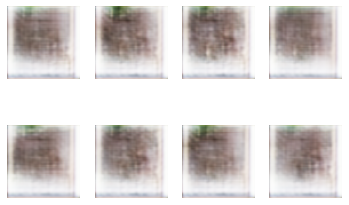

21001 [D loss: 0.640335, acc.: 98.44%, op_acc: 67.30%] [G loss: 0.935826]
21002 [D loss: 0.606346, acc.: 98.44%, op_acc: 66.09%] [G loss: 0.923754]
21003 [D loss: 0.569627, acc.: 100.00%, op_acc: 66.72%] [G loss: 1.027892]
21004 [D loss: 0.592557, acc.: 98.44%, op_acc: 66.33%] [G loss: 0.922547]
21005 [D loss: 0.559390, acc.: 100.00%, op_acc: 66.87%] [G loss: 0.910385]
21006 [D loss: 0.561974, acc.: 100.00%, op_acc: 66.48%] [G loss: 0.888004]
21007 [D loss: 0.570975, acc.: 98.44%, op_acc: 68.32%] [G loss: 0.911280]
21008 [D loss: 0.572358, acc.: 100.00%, op_acc: 66.21%] [G loss: 0.960409]
21009 [D loss: 0.566139, acc.: 100.00%, op_acc: 66.29%] [G loss: 0.973503]
21010 [D loss: 0.542887, acc.: 100.00%, op_acc: 67.89%] [G loss: 0.913409]
21011 [D loss: 0.653562, acc.: 96.88%, op_acc: 65.74%] [G loss: 0.978659]
21012 [D loss: 0.572621, acc.: 100.00%, op_acc: 66.13%] [G loss: 0.930410]
21013 [D loss: 0.546319, acc.: 100.00%, op_acc: 68.09%] [G loss: 0.954095]
21014 [D loss: 0.554670, acc.:

21111 [D loss: 0.576676, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.914163]
21112 [D loss: 0.555890, acc.: 100.00%, op_acc: 66.87%] [G loss: 1.000073]
21113 [D loss: 0.573383, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.956869]
21114 [D loss: 0.770635, acc.: 95.31%, op_acc: 65.47%] [G loss: 0.888517]
21115 [D loss: 0.567976, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.906051]
21116 [D loss: 0.614544, acc.: 98.44%, op_acc: 64.80%] [G loss: 0.960686]
21117 [D loss: 0.596594, acc.: 98.44%, op_acc: 67.11%] [G loss: 0.900266]
21118 [D loss: 0.575264, acc.: 100.00%, op_acc: 64.92%] [G loss: 0.903880]
21119 [D loss: 0.572363, acc.: 100.00%, op_acc: 65.62%] [G loss: 0.971071]
21120 [D loss: 0.608971, acc.: 98.44%, op_acc: 66.37%] [G loss: 0.908754]
21121 [D loss: 0.545135, acc.: 100.00%, op_acc: 67.03%] [G loss: 0.910889]
21122 [D loss: 0.612029, acc.: 100.00%, op_acc: 65.98%] [G loss: 0.915732]
21123 [D loss: 0.557098, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.965313]
21124 [D loss: 0.573112, acc.

21223 [D loss: 1.133528, acc.: 73.44%, op_acc: 66.13%] [G loss: 1.024051]
21224 [D loss: 0.601730, acc.: 100.00%, op_acc: 66.95%] [G loss: 1.244521]
21225 [D loss: 0.643627, acc.: 96.88%, op_acc: 67.89%] [G loss: 1.010639]
21226 [D loss: 0.685305, acc.: 95.31%, op_acc: 67.38%] [G loss: 0.969053]
21227 [D loss: 0.790387, acc.: 95.31%, op_acc: 65.62%] [G loss: 1.043001]
21228 [D loss: 0.743578, acc.: 95.31%, op_acc: 66.64%] [G loss: 1.074438]
21229 [D loss: 0.609598, acc.: 100.00%, op_acc: 66.76%] [G loss: 1.108720]
21230 [D loss: 0.634629, acc.: 96.88%, op_acc: 66.41%] [G loss: 1.040959]
21231 [D loss: 0.608354, acc.: 100.00%, op_acc: 67.11%] [G loss: 1.120626]
21232 [D loss: 0.636669, acc.: 100.00%, op_acc: 66.52%] [G loss: 1.067987]
21233 [D loss: 0.611267, acc.: 100.00%, op_acc: 67.54%] [G loss: 1.016379]
21234 [D loss: 0.614994, acc.: 100.00%, op_acc: 65.78%] [G loss: 1.083056]
21235 [D loss: 0.627730, acc.: 100.00%, op_acc: 67.34%] [G loss: 1.007281]
21236 [D loss: 0.648398, acc.: 

21335 [D loss: 0.850079, acc.: 92.19%, op_acc: 66.41%] [G loss: 0.933633]
21336 [D loss: 0.842167, acc.: 95.31%, op_acc: 67.66%] [G loss: 0.930392]
21337 [D loss: 0.752114, acc.: 95.31%, op_acc: 64.77%] [G loss: 0.975731]
21338 [D loss: 0.830674, acc.: 93.75%, op_acc: 64.18%] [G loss: 0.977915]
21339 [D loss: 0.808056, acc.: 95.31%, op_acc: 64.06%] [G loss: 0.938762]
21340 [D loss: 0.689013, acc.: 98.44%, op_acc: 66.72%] [G loss: 0.929066]
21341 [D loss: 0.839281, acc.: 92.19%, op_acc: 66.64%] [G loss: 0.921643]
21342 [D loss: 0.727981, acc.: 96.88%, op_acc: 68.59%] [G loss: 0.911925]
21343 [D loss: 0.856506, acc.: 90.62%, op_acc: 65.94%] [G loss: 0.926699]
21344 [D loss: 0.857132, acc.: 93.75%, op_acc: 66.29%] [G loss: 0.912814]
21345 [D loss: 0.667398, acc.: 98.44%, op_acc: 66.64%] [G loss: 0.910866]
21346 [D loss: 0.669042, acc.: 98.44%, op_acc: 64.37%] [G loss: 0.973364]
21347 [D loss: 0.735163, acc.: 96.88%, op_acc: 66.21%] [G loss: 0.958055]
21348 [D loss: 0.700842, acc.: 95.31%,

21447 [D loss: 1.423913, acc.: 51.56%, op_acc: 65.43%] [G loss: 1.239159]
21448 [D loss: 1.458257, acc.: 48.44%, op_acc: 65.70%] [G loss: 1.243959]
21449 [D loss: 1.556436, acc.: 37.50%, op_acc: 66.56%] [G loss: 1.210834]
21450 [D loss: 1.265612, acc.: 64.06%, op_acc: 65.86%] [G loss: 1.202524]
21451 [D loss: 1.173565, acc.: 68.75%, op_acc: 67.85%] [G loss: 1.345135]
21452 [D loss: 1.314155, acc.: 65.62%, op_acc: 67.58%] [G loss: 1.274695]
21453 [D loss: 1.246364, acc.: 65.62%, op_acc: 66.68%] [G loss: 1.203317]
21454 [D loss: 1.134418, acc.: 78.12%, op_acc: 67.73%] [G loss: 1.188023]
21455 [D loss: 1.075883, acc.: 87.50%, op_acc: 67.27%] [G loss: 1.208599]
21456 [D loss: 1.046921, acc.: 87.50%, op_acc: 67.23%] [G loss: 1.238262]
21457 [D loss: 1.135951, acc.: 84.38%, op_acc: 66.68%] [G loss: 1.203539]
21458 [D loss: 1.132965, acc.: 87.50%, op_acc: 65.90%] [G loss: 1.157115]
21459 [D loss: 1.147754, acc.: 79.69%, op_acc: 65.82%] [G loss: 1.146173]
21460 [D loss: 1.095182, acc.: 87.50%,

21559 [D loss: 0.682802, acc.: 98.44%, op_acc: 67.19%] [G loss: 0.981746]
21560 [D loss: 0.764851, acc.: 98.44%, op_acc: 66.37%] [G loss: 0.985889]
21561 [D loss: 0.930690, acc.: 90.62%, op_acc: 63.36%] [G loss: 1.003566]
21562 [D loss: 0.747883, acc.: 92.19%, op_acc: 66.13%] [G loss: 1.002118]
21563 [D loss: 0.776980, acc.: 93.75%, op_acc: 65.94%] [G loss: 1.010291]
21564 [D loss: 0.664058, acc.: 100.00%, op_acc: 66.05%] [G loss: 0.993259]
21565 [D loss: 0.717842, acc.: 96.88%, op_acc: 64.88%] [G loss: 0.978538]
21566 [D loss: 0.675249, acc.: 96.88%, op_acc: 68.55%] [G loss: 0.976121]
21567 [D loss: 0.693485, acc.: 96.88%, op_acc: 66.87%] [G loss: 1.018853]
21568 [D loss: 0.683532, acc.: 95.31%, op_acc: 67.23%] [G loss: 1.035513]
21569 [D loss: 0.775516, acc.: 95.31%, op_acc: 67.03%] [G loss: 1.001718]
21570 [D loss: 0.679281, acc.: 98.44%, op_acc: 67.07%] [G loss: 1.022569]
21571 [D loss: 0.668078, acc.: 100.00%, op_acc: 66.84%] [G loss: 1.081690]
21572 [D loss: 0.818880, acc.: 92.19

21671 [D loss: 0.759192, acc.: 93.75%, op_acc: 66.25%] [G loss: 0.964912]
21672 [D loss: 0.639820, acc.: 96.88%, op_acc: 66.21%] [G loss: 0.956995]
21673 [D loss: 0.623860, acc.: 98.44%, op_acc: 66.02%] [G loss: 0.992609]
21674 [D loss: 0.693381, acc.: 96.88%, op_acc: 66.33%] [G loss: 0.927811]
21675 [D loss: 0.578621, acc.: 100.00%, op_acc: 67.15%] [G loss: 1.000110]
21676 [D loss: 0.591142, acc.: 100.00%, op_acc: 66.87%] [G loss: 1.052962]
21677 [D loss: 0.608429, acc.: 100.00%, op_acc: 64.37%] [G loss: 0.981532]
21678 [D loss: 0.705444, acc.: 92.19%, op_acc: 67.58%] [G loss: 0.998334]
21679 [D loss: 0.641348, acc.: 96.88%, op_acc: 66.76%] [G loss: 0.949043]
21680 [D loss: 0.605697, acc.: 98.44%, op_acc: 66.84%] [G loss: 0.988375]
21681 [D loss: 0.626969, acc.: 96.88%, op_acc: 66.60%] [G loss: 1.016764]
21682 [D loss: 0.732190, acc.: 95.31%, op_acc: 66.33%] [G loss: 0.997334]
21683 [D loss: 0.603457, acc.: 100.00%, op_acc: 65.78%] [G loss: 1.006287]
21684 [D loss: 0.600747, acc.: 98.

21781 [D loss: 0.640474, acc.: 98.44%, op_acc: 66.45%] [G loss: 1.026913]
21782 [D loss: 0.804595, acc.: 90.62%, op_acc: 65.39%] [G loss: 1.004423]
21783 [D loss: 0.647820, acc.: 100.00%, op_acc: 65.51%] [G loss: 1.030863]
21784 [D loss: 0.643637, acc.: 96.88%, op_acc: 67.77%] [G loss: 0.986980]
21785 [D loss: 0.602357, acc.: 100.00%, op_acc: 66.84%] [G loss: 1.046811]
21786 [D loss: 0.795877, acc.: 98.44%, op_acc: 65.12%] [G loss: 1.010215]
21787 [D loss: 0.564360, acc.: 100.00%, op_acc: 68.09%] [G loss: 0.996243]
21788 [D loss: 0.697132, acc.: 95.31%, op_acc: 66.48%] [G loss: 0.977855]
21789 [D loss: 0.691025, acc.: 93.75%, op_acc: 67.30%] [G loss: 0.994427]
21790 [D loss: 0.777371, acc.: 95.31%, op_acc: 66.09%] [G loss: 1.012858]
21791 [D loss: 0.607198, acc.: 98.44%, op_acc: 67.42%] [G loss: 1.024451]
21792 [D loss: 0.607802, acc.: 98.44%, op_acc: 67.73%] [G loss: 1.034128]
21793 [D loss: 0.678795, acc.: 95.31%, op_acc: 69.38%] [G loss: 0.981617]
21794 [D loss: 0.646681, acc.: 98.4

21893 [D loss: 0.920040, acc.: 93.75%, op_acc: 66.21%] [G loss: 1.009140]
21894 [D loss: 0.937451, acc.: 90.62%, op_acc: 65.94%] [G loss: 0.996904]
21895 [D loss: 0.852050, acc.: 92.19%, op_acc: 66.48%] [G loss: 0.974140]
21896 [D loss: 0.880017, acc.: 89.06%, op_acc: 67.58%] [G loss: 1.008310]
21897 [D loss: 0.853365, acc.: 92.19%, op_acc: 64.30%] [G loss: 1.032704]
21898 [D loss: 0.833582, acc.: 92.19%, op_acc: 66.56%] [G loss: 0.953228]
21899 [D loss: 0.830140, acc.: 93.75%, op_acc: 65.16%] [G loss: 0.998993]
21900 [D loss: 1.133826, acc.: 87.50%, op_acc: 66.56%] [G loss: 0.987652]
21901 [D loss: 0.951304, acc.: 87.50%, op_acc: 65.43%] [G loss: 0.965888]
21902 [D loss: 0.741015, acc.: 96.88%, op_acc: 66.21%] [G loss: 1.052493]
21903 [D loss: 0.916883, acc.: 87.50%, op_acc: 64.92%] [G loss: 0.997620]
21904 [D loss: 1.058067, acc.: 85.94%, op_acc: 66.52%] [G loss: 0.956586]
21905 [D loss: 0.761879, acc.: 95.31%, op_acc: 68.16%] [G loss: 1.012414]
21906 [D loss: 0.760229, acc.: 93.75%,

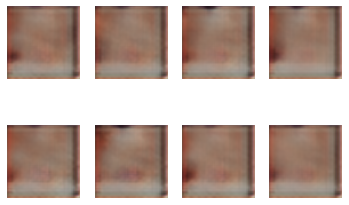

22001 [D loss: 0.579679, acc.: 100.00%, op_acc: 66.09%] [G loss: 1.007901]
22002 [D loss: 0.573687, acc.: 100.00%, op_acc: 68.59%] [G loss: 0.935670]
22003 [D loss: 0.629774, acc.: 98.44%, op_acc: 66.09%] [G loss: 0.923058]
22004 [D loss: 0.599124, acc.: 100.00%, op_acc: 66.09%] [G loss: 0.907240]
22005 [D loss: 0.593255, acc.: 100.00%, op_acc: 66.13%] [G loss: 0.904772]
22006 [D loss: 0.560926, acc.: 100.00%, op_acc: 66.56%] [G loss: 0.918816]
22007 [D loss: 0.619780, acc.: 98.44%, op_acc: 65.55%] [G loss: 0.909108]
22008 [D loss: 0.581104, acc.: 100.00%, op_acc: 67.42%] [G loss: 0.916859]
22009 [D loss: 0.589455, acc.: 98.44%, op_acc: 66.52%] [G loss: 0.917500]
22010 [D loss: 0.579783, acc.: 100.00%, op_acc: 67.54%] [G loss: 0.958343]
22011 [D loss: 0.577047, acc.: 100.00%, op_acc: 66.68%] [G loss: 0.897784]
22012 [D loss: 0.600046, acc.: 98.44%, op_acc: 65.31%] [G loss: 0.963576]
22013 [D loss: 0.640366, acc.: 98.44%, op_acc: 66.17%] [G loss: 0.953616]
22014 [D loss: 0.558740, acc.:

22111 [D loss: 0.583963, acc.: 100.00%, op_acc: 66.88%] [G loss: 1.017995]
22112 [D loss: 0.815146, acc.: 95.31%, op_acc: 65.90%] [G loss: 0.961094]
22113 [D loss: 0.590412, acc.: 100.00%, op_acc: 68.40%] [G loss: 0.913960]
22114 [D loss: 0.615552, acc.: 98.44%, op_acc: 66.52%] [G loss: 0.937729]
22115 [D loss: 0.659632, acc.: 96.88%, op_acc: 65.59%] [G loss: 0.881314]
22116 [D loss: 0.564972, acc.: 100.00%, op_acc: 66.25%] [G loss: 0.944354]
22117 [D loss: 0.578702, acc.: 100.00%, op_acc: 65.98%] [G loss: 1.041038]
22118 [D loss: 0.579811, acc.: 100.00%, op_acc: 66.80%] [G loss: 0.920252]
22119 [D loss: 0.670921, acc.: 95.31%, op_acc: 65.74%] [G loss: 0.953739]
22120 [D loss: 0.592403, acc.: 100.00%, op_acc: 66.17%] [G loss: 0.974909]
22121 [D loss: 0.579460, acc.: 100.00%, op_acc: 64.84%] [G loss: 1.129907]
22122 [D loss: 0.569827, acc.: 100.00%, op_acc: 67.66%] [G loss: 1.017035]
22123 [D loss: 0.639821, acc.: 98.44%, op_acc: 65.39%] [G loss: 0.952094]
22124 [D loss: 0.562457, acc.:

22223 [D loss: 0.580016, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.993381]
22224 [D loss: 0.643896, acc.: 98.44%, op_acc: 66.68%] [G loss: 0.943092]
22225 [D loss: 0.637632, acc.: 96.88%, op_acc: 66.99%] [G loss: 0.976192]
22226 [D loss: 0.607562, acc.: 98.44%, op_acc: 65.62%] [G loss: 1.016926]
22227 [D loss: 0.596367, acc.: 100.00%, op_acc: 67.07%] [G loss: 0.925924]
22228 [D loss: 0.585266, acc.: 100.00%, op_acc: 65.70%] [G loss: 0.930343]
22229 [D loss: 0.607942, acc.: 98.44%, op_acc: 67.81%] [G loss: 0.920752]
22230 [D loss: 0.566673, acc.: 100.00%, op_acc: 67.77%] [G loss: 0.978500]
22231 [D loss: 0.571048, acc.: 100.00%, op_acc: 66.95%] [G loss: 0.999282]
22232 [D loss: 0.608756, acc.: 98.44%, op_acc: 66.17%] [G loss: 0.973862]
22233 [D loss: 0.607080, acc.: 100.00%, op_acc: 68.01%] [G loss: 0.981126]
22234 [D loss: 0.595919, acc.: 96.88%, op_acc: 67.70%] [G loss: 1.008531]
22235 [D loss: 0.579312, acc.: 100.00%, op_acc: 67.07%] [G loss: 0.959770]
22236 [D loss: 0.560160, acc.: 

22335 [D loss: 1.374326, acc.: 48.44%, op_acc: 64.02%] [G loss: 1.864005]
22336 [D loss: 1.248671, acc.: 70.31%, op_acc: 66.60%] [G loss: 2.063074]
22337 [D loss: 1.187345, acc.: 79.69%, op_acc: 66.17%] [G loss: 2.130996]
22338 [D loss: 1.237384, acc.: 70.31%, op_acc: 67.27%] [G loss: 1.991608]
22339 [D loss: 1.378890, acc.: 51.56%, op_acc: 67.23%] [G loss: 1.894383]
22340 [D loss: 1.457980, acc.: 45.31%, op_acc: 63.98%] [G loss: 1.933914]
22341 [D loss: 1.222918, acc.: 54.69%, op_acc: 65.94%] [G loss: 2.128516]
22342 [D loss: 1.411891, acc.: 54.69%, op_acc: 65.59%] [G loss: 2.134728]
22343 [D loss: 1.248479, acc.: 60.94%, op_acc: 66.72%] [G loss: 2.164264]
22344 [D loss: 1.233340, acc.: 73.44%, op_acc: 66.95%] [G loss: 2.043123]
22345 [D loss: 1.461883, acc.: 64.06%, op_acc: 64.38%] [G loss: 1.774821]
22346 [D loss: 1.301406, acc.: 65.62%, op_acc: 66.45%] [G loss: 1.785117]
22347 [D loss: 1.125400, acc.: 78.12%, op_acc: 67.03%] [G loss: 1.674502]
22348 [D loss: 1.129411, acc.: 75.00%,

22447 [D loss: 0.616680, acc.: 100.00%, op_acc: 66.87%] [G loss: 0.937573]
22448 [D loss: 0.585825, acc.: 100.00%, op_acc: 66.52%] [G loss: 0.944243]
22449 [D loss: 0.581153, acc.: 100.00%, op_acc: 66.56%] [G loss: 0.996636]
22450 [D loss: 0.605756, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.921806]
22451 [D loss: 0.614467, acc.: 98.44%, op_acc: 65.74%] [G loss: 0.919914]
22452 [D loss: 0.604970, acc.: 98.44%, op_acc: 65.62%] [G loss: 0.949657]
22453 [D loss: 0.669942, acc.: 96.88%, op_acc: 67.15%] [G loss: 0.928278]
22454 [D loss: 0.594843, acc.: 100.00%, op_acc: 65.82%] [G loss: 1.001585]
22455 [D loss: 0.624142, acc.: 96.88%, op_acc: 65.70%] [G loss: 0.909303]
22456 [D loss: 0.664616, acc.: 96.88%, op_acc: 65.62%] [G loss: 0.920679]
22457 [D loss: 0.569599, acc.: 100.00%, op_acc: 66.02%] [G loss: 0.987708]
22458 [D loss: 0.608121, acc.: 98.44%, op_acc: 68.16%] [G loss: 0.949444]
22459 [D loss: 0.620887, acc.: 98.44%, op_acc: 66.91%] [G loss: 0.949306]
22460 [D loss: 0.604163, acc.: 9

22559 [D loss: 0.749278, acc.: 95.31%, op_acc: 66.64%] [G loss: 0.897510]
22560 [D loss: 0.670521, acc.: 96.88%, op_acc: 66.87%] [G loss: 0.911019]
22561 [D loss: 0.584840, acc.: 100.00%, op_acc: 67.50%] [G loss: 0.906784]
22562 [D loss: 0.648413, acc.: 98.44%, op_acc: 67.03%] [G loss: 0.908114]
22563 [D loss: 0.658783, acc.: 95.31%, op_acc: 66.17%] [G loss: 0.938382]
22564 [D loss: 0.638807, acc.: 96.88%, op_acc: 67.70%] [G loss: 0.920060]
22565 [D loss: 0.579192, acc.: 100.00%, op_acc: 66.64%] [G loss: 0.929643]
22566 [D loss: 0.595841, acc.: 98.44%, op_acc: 68.36%] [G loss: 0.927887]
22567 [D loss: 0.663940, acc.: 98.44%, op_acc: 67.97%] [G loss: 0.913493]
22568 [D loss: 0.576011, acc.: 100.00%, op_acc: 67.93%] [G loss: 0.903560]
22569 [D loss: 0.573561, acc.: 100.00%, op_acc: 67.54%] [G loss: 0.985123]
22570 [D loss: 0.574642, acc.: 100.00%, op_acc: 67.62%] [G loss: 0.946684]
22571 [D loss: 0.717319, acc.: 95.31%, op_acc: 68.09%] [G loss: 0.908664]
22572 [D loss: 0.635341, acc.: 98

22671 [D loss: 0.752701, acc.: 96.88%, op_acc: 66.48%] [G loss: 1.386991]
22672 [D loss: 0.764515, acc.: 93.75%, op_acc: 65.16%] [G loss: 1.430625]
22673 [D loss: 1.176382, acc.: 68.75%, op_acc: 66.02%] [G loss: 1.426950]
22674 [D loss: 0.840837, acc.: 93.75%, op_acc: 65.47%] [G loss: 1.569029]
22675 [D loss: 1.128740, acc.: 68.75%, op_acc: 65.94%] [G loss: 1.764431]
22676 [D loss: 0.767820, acc.: 96.88%, op_acc: 67.38%] [G loss: 1.637083]
22677 [D loss: 0.963521, acc.: 82.81%, op_acc: 65.70%] [G loss: 1.441389]
22678 [D loss: 1.055850, acc.: 84.38%, op_acc: 66.33%] [G loss: 1.421338]
22679 [D loss: 1.117422, acc.: 73.44%, op_acc: 66.29%] [G loss: 1.898981]
22680 [D loss: 1.405683, acc.: 75.00%, op_acc: 64.49%] [G loss: 1.396263]
22681 [D loss: 1.072423, acc.: 76.56%, op_acc: 64.53%] [G loss: 1.147722]
22682 [D loss: 1.192872, acc.: 73.44%, op_acc: 65.90%] [G loss: 1.349804]
22683 [D loss: 1.595346, acc.: 54.69%, op_acc: 65.86%] [G loss: 1.116125]
22684 [D loss: 1.006391, acc.: 82.81%,

22783 [D loss: 0.664633, acc.: 98.44%, op_acc: 66.45%] [G loss: 0.954547]
22784 [D loss: 0.670691, acc.: 98.44%, op_acc: 66.29%] [G loss: 0.929484]
22785 [D loss: 0.672997, acc.: 98.44%, op_acc: 67.42%] [G loss: 0.923133]
22786 [D loss: 0.666849, acc.: 98.44%, op_acc: 68.36%] [G loss: 0.935607]
22787 [D loss: 0.640349, acc.: 96.88%, op_acc: 68.05%] [G loss: 0.935651]
22788 [D loss: 0.729493, acc.: 95.31%, op_acc: 67.23%] [G loss: 1.028455]
22789 [D loss: 0.758437, acc.: 95.31%, op_acc: 65.78%] [G loss: 1.175933]
22790 [D loss: 0.911567, acc.: 82.81%, op_acc: 65.74%] [G loss: 1.285639]
22791 [D loss: 1.335798, acc.: 54.69%, op_acc: 65.94%] [G loss: 2.399312]
22792 [D loss: 1.021277, acc.: 81.25%, op_acc: 64.22%] [G loss: 2.987840]
22793 [D loss: 1.679401, acc.: 43.75%, op_acc: 64.53%] [G loss: 2.189283]
22794 [D loss: 1.007855, acc.: 82.81%, op_acc: 68.24%] [G loss: 2.553225]
22795 [D loss: 1.185692, acc.: 75.00%, op_acc: 64.26%] [G loss: 1.926487]
22796 [D loss: 1.578508, acc.: 53.12%,

22895 [D loss: 0.642520, acc.: 98.44%, op_acc: 66.80%] [G loss: 1.425947]
22896 [D loss: 0.654598, acc.: 96.88%, op_acc: 66.72%] [G loss: 1.387921]
22897 [D loss: 0.609054, acc.: 100.00%, op_acc: 67.27%] [G loss: 1.534732]
22898 [D loss: 0.739577, acc.: 92.19%, op_acc: 66.13%] [G loss: 1.417453]
22899 [D loss: 0.660087, acc.: 100.00%, op_acc: 67.27%] [G loss: 1.614931]
22900 [D loss: 0.680718, acc.: 96.88%, op_acc: 66.99%] [G loss: 2.011720]
22901 [D loss: 0.712085, acc.: 95.31%, op_acc: 66.05%] [G loss: 1.648514]
22902 [D loss: 0.938641, acc.: 92.19%, op_acc: 64.65%] [G loss: 1.231256]
22903 [D loss: 0.747277, acc.: 95.31%, op_acc: 65.51%] [G loss: 1.077381]
22904 [D loss: 0.622231, acc.: 98.44%, op_acc: 65.12%] [G loss: 1.174535]
22905 [D loss: 0.608227, acc.: 98.44%, op_acc: 64.73%] [G loss: 1.090287]
22906 [D loss: 0.627307, acc.: 96.88%, op_acc: 65.94%] [G loss: 1.023948]
22907 [D loss: 0.646934, acc.: 98.44%, op_acc: 67.70%] [G loss: 1.009783]
22908 [D loss: 0.655662, acc.: 98.44

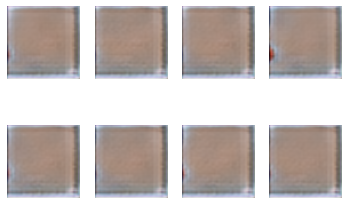

23001 [D loss: 0.676603, acc.: 95.31%, op_acc: 66.33%] [G loss: 0.983311]
23002 [D loss: 0.729761, acc.: 95.31%, op_acc: 66.02%] [G loss: 0.956855]
23003 [D loss: 0.713678, acc.: 98.44%, op_acc: 65.04%] [G loss: 0.933138]
23004 [D loss: 0.706511, acc.: 98.44%, op_acc: 64.53%] [G loss: 0.936777]
23005 [D loss: 0.616292, acc.: 100.00%, op_acc: 64.57%] [G loss: 0.927368]
23006 [D loss: 0.656122, acc.: 98.44%, op_acc: 67.77%] [G loss: 0.918845]
23007 [D loss: 0.796853, acc.: 93.75%, op_acc: 66.37%] [G loss: 0.892000]
23008 [D loss: 0.880807, acc.: 95.31%, op_acc: 65.59%] [G loss: 0.899947]
23009 [D loss: 0.746674, acc.: 96.88%, op_acc: 64.92%] [G loss: 0.925823]
23010 [D loss: 0.801078, acc.: 96.88%, op_acc: 64.18%] [G loss: 0.915567]
23011 [D loss: 0.693651, acc.: 96.88%, op_acc: 66.68%] [G loss: 0.904941]
23012 [D loss: 0.718413, acc.: 98.44%, op_acc: 64.80%] [G loss: 0.912218]
23013 [D loss: 0.661633, acc.: 96.88%, op_acc: 65.98%] [G loss: 0.872736]
23014 [D loss: 0.919085, acc.: 93.75%

23113 [D loss: 0.681452, acc.: 98.44%, op_acc: 67.07%] [G loss: 0.927562]
23114 [D loss: 0.589259, acc.: 100.00%, op_acc: 66.37%] [G loss: 0.944199]
23115 [D loss: 0.615974, acc.: 98.44%, op_acc: 67.42%] [G loss: 0.963674]
23116 [D loss: 0.598376, acc.: 100.00%, op_acc: 67.97%] [G loss: 0.900652]
23117 [D loss: 0.629581, acc.: 98.44%, op_acc: 67.50%] [G loss: 0.942535]
23118 [D loss: 0.673422, acc.: 98.44%, op_acc: 66.52%] [G loss: 0.917745]
23119 [D loss: 0.623530, acc.: 98.44%, op_acc: 67.34%] [G loss: 0.945413]
23120 [D loss: 0.596476, acc.: 100.00%, op_acc: 67.66%] [G loss: 0.929603]
23121 [D loss: 0.608694, acc.: 98.44%, op_acc: 68.32%] [G loss: 0.970258]
23122 [D loss: 0.595084, acc.: 98.44%, op_acc: 68.63%] [G loss: 0.957964]
23123 [D loss: 0.578175, acc.: 100.00%, op_acc: 67.85%] [G loss: 0.949176]
23124 [D loss: 0.612524, acc.: 98.44%, op_acc: 67.58%] [G loss: 0.958205]
23125 [D loss: 0.684857, acc.: 95.31%, op_acc: 66.84%] [G loss: 0.923032]
23126 [D loss: 0.649507, acc.: 98.

23225 [D loss: 0.607806, acc.: 100.00%, op_acc: 66.02%] [G loss: 0.998158]
23226 [D loss: 0.679328, acc.: 98.44%, op_acc: 66.13%] [G loss: 0.979434]
23227 [D loss: 0.621936, acc.: 100.00%, op_acc: 67.34%] [G loss: 0.939515]
23228 [D loss: 0.600869, acc.: 100.00%, op_acc: 66.91%] [G loss: 0.962689]
23229 [D loss: 0.614789, acc.: 98.44%, op_acc: 67.30%] [G loss: 0.962339]
23230 [D loss: 0.741103, acc.: 96.88%, op_acc: 63.95%] [G loss: 0.937540]
23231 [D loss: 0.632712, acc.: 100.00%, op_acc: 65.74%] [G loss: 0.992491]
23232 [D loss: 0.606537, acc.: 100.00%, op_acc: 64.69%] [G loss: 0.964417]
23233 [D loss: 0.603149, acc.: 100.00%, op_acc: 66.37%] [G loss: 0.980754]
23234 [D loss: 0.601167, acc.: 100.00%, op_acc: 66.41%] [G loss: 0.967773]
23235 [D loss: 0.632557, acc.: 100.00%, op_acc: 66.33%] [G loss: 0.957774]
23236 [D loss: 0.603488, acc.: 100.00%, op_acc: 66.33%] [G loss: 0.947589]
23237 [D loss: 0.685634, acc.: 96.88%, op_acc: 66.45%] [G loss: 0.938624]
23238 [D loss: 0.601351, acc.

23337 [D loss: 0.665453, acc.: 98.44%, op_acc: 66.80%] [G loss: 0.988869]
23338 [D loss: 0.733211, acc.: 96.88%, op_acc: 65.43%] [G loss: 1.214422]
23339 [D loss: 0.633687, acc.: 96.88%, op_acc: 65.94%] [G loss: 1.097667]
23340 [D loss: 0.770922, acc.: 95.31%, op_acc: 66.41%] [G loss: 1.131718]
23341 [D loss: 0.618852, acc.: 98.44%, op_acc: 66.45%] [G loss: 1.055046]
23342 [D loss: 0.736392, acc.: 95.31%, op_acc: 67.11%] [G loss: 1.012511]
23343 [D loss: 0.794188, acc.: 90.62%, op_acc: 66.02%] [G loss: 1.106101]
23344 [D loss: 0.674761, acc.: 96.88%, op_acc: 67.27%] [G loss: 1.258050]
23345 [D loss: 0.719180, acc.: 96.88%, op_acc: 66.87%] [G loss: 1.300321]
23346 [D loss: 0.662842, acc.: 98.44%, op_acc: 66.64%] [G loss: 1.684232]
23347 [D loss: 0.832818, acc.: 96.88%, op_acc: 63.87%] [G loss: 1.743883]
23348 [D loss: 0.743232, acc.: 95.31%, op_acc: 66.68%] [G loss: 1.355622]
23349 [D loss: 0.851322, acc.: 92.19%, op_acc: 66.13%] [G loss: 1.948215]
23350 [D loss: 1.080790, acc.: 84.38%,

23449 [D loss: 0.751938, acc.: 95.31%, op_acc: 66.45%] [G loss: 1.194193]
23450 [D loss: 0.749218, acc.: 87.50%, op_acc: 67.23%] [G loss: 1.054716]
23451 [D loss: 1.015516, acc.: 81.25%, op_acc: 66.13%] [G loss: 1.157941]
23452 [D loss: 0.622427, acc.: 98.44%, op_acc: 67.70%] [G loss: 1.340527]
23453 [D loss: 1.085957, acc.: 82.81%, op_acc: 64.53%] [G loss: 1.158807]
23454 [D loss: 1.062516, acc.: 78.12%, op_acc: 65.20%] [G loss: 1.153093]
23455 [D loss: 1.245155, acc.: 76.56%, op_acc: 64.84%] [G loss: 1.136923]
23456 [D loss: 1.596243, acc.: 56.25%, op_acc: 65.35%] [G loss: 1.055633]
23457 [D loss: 1.203729, acc.: 81.25%, op_acc: 64.22%] [G loss: 1.129140]
23458 [D loss: 1.123507, acc.: 87.50%, op_acc: 64.02%] [G loss: 1.251805]
23459 [D loss: 1.252332, acc.: 82.81%, op_acc: 63.44%] [G loss: 1.158714]
23460 [D loss: 1.308114, acc.: 62.50%, op_acc: 65.98%] [G loss: 1.063990]
23461 [D loss: 1.242948, acc.: 73.44%, op_acc: 64.38%] [G loss: 1.086070]
23462 [D loss: 1.148119, acc.: 73.44%,

23561 [D loss: 1.031768, acc.: 87.50%, op_acc: 66.05%] [G loss: 2.174729]
23562 [D loss: 1.216422, acc.: 75.00%, op_acc: 64.92%] [G loss: 2.352961]
23563 [D loss: 1.056071, acc.: 84.38%, op_acc: 65.16%] [G loss: 2.413816]
23564 [D loss: 0.889823, acc.: 93.75%, op_acc: 66.09%] [G loss: 2.846099]
23565 [D loss: 1.007654, acc.: 84.38%, op_acc: 66.45%] [G loss: 2.034054]
23566 [D loss: 0.852188, acc.: 93.75%, op_acc: 65.35%] [G loss: 1.447378]
23567 [D loss: 0.838761, acc.: 95.31%, op_acc: 64.84%] [G loss: 1.677179]
23568 [D loss: 1.155526, acc.: 73.44%, op_acc: 65.59%] [G loss: 2.290205]
23569 [D loss: 0.802111, acc.: 92.19%, op_acc: 66.91%] [G loss: 2.460073]
23570 [D loss: 1.012012, acc.: 76.56%, op_acc: 66.17%] [G loss: 3.625615]
23571 [D loss: 1.241434, acc.: 73.44%, op_acc: 64.34%] [G loss: 4.476367]
23572 [D loss: 2.715486, acc.: 37.50%, op_acc: 61.05%] [G loss: 6.490632]
23573 [D loss: 1.173753, acc.: 85.94%, op_acc: 64.41%] [G loss: 6.175732]
23574 [D loss: 1.112026, acc.: 85.94%,

23673 [D loss: 0.639950, acc.: 98.44%, op_acc: 66.60%] [G loss: 0.973234]
23674 [D loss: 0.668323, acc.: 96.88%, op_acc: 67.58%] [G loss: 0.997944]
23675 [D loss: 0.629009, acc.: 100.00%, op_acc: 66.48%] [G loss: 1.022789]
23676 [D loss: 0.635608, acc.: 96.88%, op_acc: 69.34%] [G loss: 0.988636]
23677 [D loss: 0.697168, acc.: 98.44%, op_acc: 66.84%] [G loss: 0.948947]
23678 [D loss: 0.659866, acc.: 98.44%, op_acc: 66.48%] [G loss: 1.002844]
23679 [D loss: 0.712174, acc.: 96.88%, op_acc: 67.03%] [G loss: 0.966487]
23680 [D loss: 0.809772, acc.: 96.88%, op_acc: 65.94%] [G loss: 0.966326]
23681 [D loss: 0.636873, acc.: 100.00%, op_acc: 69.30%] [G loss: 1.020703]
23682 [D loss: 0.800508, acc.: 92.19%, op_acc: 67.70%] [G loss: 0.926811]
23683 [D loss: 0.725373, acc.: 93.75%, op_acc: 65.74%] [G loss: 0.981630]
23684 [D loss: 0.900569, acc.: 93.75%, op_acc: 64.57%] [G loss: 1.030166]
23685 [D loss: 0.813256, acc.: 89.06%, op_acc: 67.46%] [G loss: 0.981720]
23686 [D loss: 0.884371, acc.: 95.31

23784 [D loss: 0.847662, acc.: 92.19%, op_acc: 65.16%] [G loss: 2.748738]
23785 [D loss: 0.980605, acc.: 93.75%, op_acc: 62.70%] [G loss: 2.696167]
23786 [D loss: 1.013118, acc.: 87.50%, op_acc: 64.96%] [G loss: 2.745399]
23787 [D loss: 1.179493, acc.: 84.38%, op_acc: 64.45%] [G loss: 2.465900]
23788 [D loss: 1.390807, acc.: 73.44%, op_acc: 61.25%] [G loss: 1.342782]
23789 [D loss: 1.142781, acc.: 85.94%, op_acc: 63.28%] [G loss: 1.410005]
23790 [D loss: 0.773402, acc.: 93.75%, op_acc: 66.29%] [G loss: 1.409248]
23791 [D loss: 0.745541, acc.: 95.31%, op_acc: 67.34%] [G loss: 1.293162]
23792 [D loss: 0.851735, acc.: 90.62%, op_acc: 65.35%] [G loss: 1.161174]
23793 [D loss: 0.903304, acc.: 90.62%, op_acc: 64.53%] [G loss: 1.125028]
23794 [D loss: 1.135257, acc.: 84.38%, op_acc: 63.67%] [G loss: 1.036162]
23795 [D loss: 0.959810, acc.: 90.62%, op_acc: 65.39%] [G loss: 1.009421]
23796 [D loss: 0.693146, acc.: 98.44%, op_acc: 66.37%] [G loss: 1.058721]
23797 [D loss: 1.064359, acc.: 89.06%,

23896 [D loss: 0.745375, acc.: 95.31%, op_acc: 66.56%] [G loss: 1.055605]
23897 [D loss: 0.633449, acc.: 100.00%, op_acc: 67.27%] [G loss: 1.019731]
23898 [D loss: 0.604602, acc.: 100.00%, op_acc: 66.84%] [G loss: 1.063876]
23899 [D loss: 0.700652, acc.: 96.88%, op_acc: 67.38%] [G loss: 1.012619]
23900 [D loss: 0.669036, acc.: 96.88%, op_acc: 67.62%] [G loss: 1.040534]
23901 [D loss: 0.907056, acc.: 90.62%, op_acc: 64.65%] [G loss: 0.961753]
23902 [D loss: 0.652932, acc.: 100.00%, op_acc: 66.76%] [G loss: 1.040643]
23903 [D loss: 0.624269, acc.: 100.00%, op_acc: 66.41%] [G loss: 1.039124]
23904 [D loss: 0.741646, acc.: 96.88%, op_acc: 66.41%] [G loss: 1.020044]
23905 [D loss: 0.682615, acc.: 96.88%, op_acc: 69.41%] [G loss: 1.065746]
23906 [D loss: 0.669761, acc.: 100.00%, op_acc: 66.21%] [G loss: 1.039541]
23907 [D loss: 0.739696, acc.: 95.31%, op_acc: 67.58%] [G loss: 1.041889]
23908 [D loss: 0.680488, acc.: 100.00%, op_acc: 66.02%] [G loss: 1.052155]
23909 [D loss: 0.638526, acc.: 9

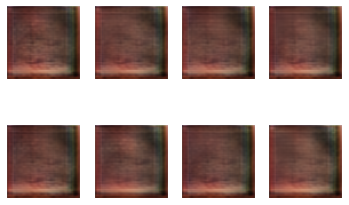

24001 [D loss: 0.607410, acc.: 98.44%, op_acc: 68.01%] [G loss: 0.907549]
24002 [D loss: 0.580376, acc.: 100.00%, op_acc: 69.30%] [G loss: 0.901117]
24003 [D loss: 0.589380, acc.: 100.00%, op_acc: 68.01%] [G loss: 0.897004]
24004 [D loss: 0.576497, acc.: 100.00%, op_acc: 67.77%] [G loss: 0.904244]
24005 [D loss: 0.629580, acc.: 98.44%, op_acc: 67.11%] [G loss: 0.917464]
24006 [D loss: 0.651218, acc.: 95.31%, op_acc: 67.50%] [G loss: 0.933818]
24007 [D loss: 0.600535, acc.: 100.00%, op_acc: 67.70%] [G loss: 0.892810]
24008 [D loss: 0.609549, acc.: 98.44%, op_acc: 68.32%] [G loss: 0.924682]
24009 [D loss: 0.640968, acc.: 95.31%, op_acc: 67.34%] [G loss: 0.910830]
24010 [D loss: 0.614098, acc.: 98.44%, op_acc: 65.98%] [G loss: 0.880613]
24011 [D loss: 0.596222, acc.: 100.00%, op_acc: 66.56%] [G loss: 1.046066]
24012 [D loss: 0.593329, acc.: 100.00%, op_acc: 67.66%] [G loss: 0.965094]
24013 [D loss: 0.598747, acc.: 98.44%, op_acc: 69.10%] [G loss: 0.976018]
24014 [D loss: 0.623566, acc.: 9

24113 [D loss: 0.894254, acc.: 89.06%, op_acc: 65.62%] [G loss: 0.980477]
24114 [D loss: 0.592458, acc.: 98.44%, op_acc: 68.12%] [G loss: 1.027214]
24115 [D loss: 0.660076, acc.: 96.88%, op_acc: 67.66%] [G loss: 1.023170]
24116 [D loss: 0.637196, acc.: 96.88%, op_acc: 68.91%] [G loss: 0.974348]
24117 [D loss: 0.597021, acc.: 100.00%, op_acc: 67.50%] [G loss: 1.030932]
24118 [D loss: 0.747238, acc.: 96.88%, op_acc: 67.11%] [G loss: 0.964881]
24119 [D loss: 0.660791, acc.: 96.88%, op_acc: 67.93%] [G loss: 1.001682]
24120 [D loss: 0.719727, acc.: 93.75%, op_acc: 68.36%] [G loss: 0.961939]
24121 [D loss: 0.707220, acc.: 96.88%, op_acc: 67.34%] [G loss: 0.975020]
24122 [D loss: 0.870320, acc.: 95.31%, op_acc: 66.09%] [G loss: 1.014738]
24123 [D loss: 0.728073, acc.: 93.75%, op_acc: 67.54%] [G loss: 1.024025]
24124 [D loss: 0.777489, acc.: 95.31%, op_acc: 65.27%] [G loss: 0.999270]
24125 [D loss: 0.660681, acc.: 96.88%, op_acc: 66.95%] [G loss: 1.054407]
24126 [D loss: 0.707853, acc.: 96.88%

24225 [D loss: 0.607692, acc.: 98.44%, op_acc: 68.16%] [G loss: 0.816208]
24226 [D loss: 0.589015, acc.: 100.00%, op_acc: 68.75%] [G loss: 0.850004]
24227 [D loss: 0.624684, acc.: 96.88%, op_acc: 68.01%] [G loss: 0.830081]
24228 [D loss: 0.593206, acc.: 98.44%, op_acc: 70.23%] [G loss: 0.833212]
24229 [D loss: 0.642869, acc.: 96.88%, op_acc: 66.29%] [G loss: 0.818595]
24230 [D loss: 0.638677, acc.: 98.44%, op_acc: 68.87%] [G loss: 0.818839]
24231 [D loss: 0.598912, acc.: 98.44%, op_acc: 67.58%] [G loss: 0.856333]
24232 [D loss: 0.584638, acc.: 100.00%, op_acc: 68.01%] [G loss: 0.859730]
24233 [D loss: 0.626074, acc.: 96.88%, op_acc: 68.55%] [G loss: 0.877542]
24234 [D loss: 0.613395, acc.: 98.44%, op_acc: 68.12%] [G loss: 0.844573]
24235 [D loss: 0.597518, acc.: 98.44%, op_acc: 69.38%] [G loss: 0.839453]
24236 [D loss: 0.626547, acc.: 98.44%, op_acc: 66.76%] [G loss: 0.875342]
24237 [D loss: 0.595773, acc.: 100.00%, op_acc: 66.91%] [G loss: 0.803889]
24238 [D loss: 0.581098, acc.: 100.

24336 [D loss: 0.571930, acc.: 100.00%, op_acc: 65.94%] [G loss: 0.973287]
24337 [D loss: 0.569109, acc.: 100.00%, op_acc: 67.97%] [G loss: 0.961125]
24338 [D loss: 0.572612, acc.: 98.44%, op_acc: 68.44%] [G loss: 0.985729]
24339 [D loss: 0.587767, acc.: 100.00%, op_acc: 65.98%] [G loss: 0.955051]
24340 [D loss: 0.582113, acc.: 98.44%, op_acc: 67.58%] [G loss: 0.936236]
24341 [D loss: 0.556929, acc.: 100.00%, op_acc: 67.93%] [G loss: 1.007639]
24342 [D loss: 0.537282, acc.: 100.00%, op_acc: 67.77%] [G loss: 0.960481]
24343 [D loss: 0.600244, acc.: 98.44%, op_acc: 66.13%] [G loss: 1.039731]
24344 [D loss: 0.602231, acc.: 98.44%, op_acc: 68.32%] [G loss: 0.975637]
24345 [D loss: 0.601539, acc.: 98.44%, op_acc: 68.05%] [G loss: 0.935366]
24346 [D loss: 0.644094, acc.: 95.31%, op_acc: 66.52%] [G loss: 1.095933]
24347 [D loss: 0.573882, acc.: 100.00%, op_acc: 66.99%] [G loss: 0.998985]
24348 [D loss: 0.702956, acc.: 98.44%, op_acc: 65.90%] [G loss: 1.043279]
24349 [D loss: 0.653526, acc.: 9

24448 [D loss: 1.127556, acc.: 82.81%, op_acc: 64.73%] [G loss: 1.091774]
24449 [D loss: 1.005585, acc.: 87.50%, op_acc: 65.82%] [G loss: 1.101522]
24450 [D loss: 1.108847, acc.: 75.00%, op_acc: 65.55%] [G loss: 1.234162]
24451 [D loss: 0.976512, acc.: 90.62%, op_acc: 66.17%] [G loss: 1.357921]
24452 [D loss: 1.036179, acc.: 85.94%, op_acc: 68.12%] [G loss: 1.271237]
24453 [D loss: 1.082099, acc.: 84.38%, op_acc: 65.78%] [G loss: 1.214494]
24454 [D loss: 1.025655, acc.: 82.81%, op_acc: 66.99%] [G loss: 1.389532]
24455 [D loss: 0.950045, acc.: 87.50%, op_acc: 66.45%] [G loss: 1.366332]
24456 [D loss: 1.121460, acc.: 75.00%, op_acc: 65.55%] [G loss: 1.325098]
24457 [D loss: 1.007551, acc.: 84.38%, op_acc: 64.92%] [G loss: 1.223800]
24458 [D loss: 0.982627, acc.: 87.50%, op_acc: 64.37%] [G loss: 1.314249]
24459 [D loss: 1.031201, acc.: 79.69%, op_acc: 66.21%] [G loss: 1.241595]
24460 [D loss: 0.819860, acc.: 98.44%, op_acc: 66.09%] [G loss: 1.200293]
24461 [D loss: 0.755420, acc.: 98.44%,

24560 [D loss: 0.936947, acc.: 90.62%, op_acc: 67.62%] [G loss: 1.278093]
24561 [D loss: 1.067973, acc.: 81.25%, op_acc: 66.52%] [G loss: 1.210313]
24562 [D loss: 0.995809, acc.: 84.38%, op_acc: 66.41%] [G loss: 1.244192]
24563 [D loss: 1.319503, acc.: 71.88%, op_acc: 64.57%] [G loss: 1.088055]
24564 [D loss: 0.994578, acc.: 89.06%, op_acc: 66.56%] [G loss: 1.387775]
24565 [D loss: 0.922363, acc.: 93.75%, op_acc: 65.31%] [G loss: 1.577884]
24566 [D loss: 1.078498, acc.: 81.25%, op_acc: 64.80%] [G loss: 1.442736]
24567 [D loss: 1.093968, acc.: 79.69%, op_acc: 67.50%] [G loss: 1.277939]
24568 [D loss: 1.027977, acc.: 81.25%, op_acc: 67.42%] [G loss: 1.351295]
24569 [D loss: 1.032168, acc.: 85.94%, op_acc: 65.12%] [G loss: 1.507577]
24570 [D loss: 0.891794, acc.: 96.88%, op_acc: 65.55%] [G loss: 1.866497]
24571 [D loss: 1.116064, acc.: 82.81%, op_acc: 65.47%] [G loss: 1.633924]
24572 [D loss: 1.010485, acc.: 84.38%, op_acc: 65.39%] [G loss: 1.694496]
24573 [D loss: 1.091756, acc.: 79.69%,

24672 [D loss: 1.317891, acc.: 59.38%, op_acc: 67.73%] [G loss: 1.413296]
24673 [D loss: 1.242712, acc.: 65.62%, op_acc: 66.72%] [G loss: 1.401293]
24674 [D loss: 1.117512, acc.: 82.81%, op_acc: 66.52%] [G loss: 1.497692]
24675 [D loss: 1.198515, acc.: 70.31%, op_acc: 64.84%] [G loss: 1.502132]
24676 [D loss: 1.144206, acc.: 81.25%, op_acc: 68.44%] [G loss: 1.475821]
24677 [D loss: 1.071692, acc.: 84.38%, op_acc: 65.47%] [G loss: 1.547770]
24678 [D loss: 1.132593, acc.: 82.81%, op_acc: 65.51%] [G loss: 1.534584]
24679 [D loss: 1.169196, acc.: 81.25%, op_acc: 66.76%] [G loss: 1.546172]
24680 [D loss: 1.081862, acc.: 78.12%, op_acc: 65.04%] [G loss: 1.596354]
24681 [D loss: 1.044372, acc.: 85.94%, op_acc: 65.59%] [G loss: 1.650747]
24682 [D loss: 1.004219, acc.: 84.38%, op_acc: 67.77%] [G loss: 1.603797]
24683 [D loss: 1.193790, acc.: 64.06%, op_acc: 64.34%] [G loss: 1.618734]
24684 [D loss: 1.775136, acc.: 28.12%, op_acc: 67.42%] [G loss: 1.420829]
24685 [D loss: 1.928427, acc.: 29.69%,

24784 [D loss: 1.027798, acc.: 85.94%, op_acc: 66.99%] [G loss: 1.667154]
24785 [D loss: 0.899426, acc.: 93.75%, op_acc: 67.19%] [G loss: 1.730502]
24786 [D loss: 1.178892, acc.: 79.69%, op_acc: 66.52%] [G loss: 1.461136]
24787 [D loss: 1.163769, acc.: 76.56%, op_acc: 65.59%] [G loss: 1.358812]
24788 [D loss: 1.080190, acc.: 79.69%, op_acc: 66.48%] [G loss: 1.231147]
24789 [D loss: 1.453923, acc.: 45.31%, op_acc: 65.82%] [G loss: 1.126604]
24790 [D loss: 1.193042, acc.: 67.19%, op_acc: 66.29%] [G loss: 1.209058]
24791 [D loss: 1.123346, acc.: 82.81%, op_acc: 65.51%] [G loss: 1.282623]
24792 [D loss: 1.261106, acc.: 65.62%, op_acc: 64.96%] [G loss: 1.256391]
24793 [D loss: 1.185475, acc.: 81.25%, op_acc: 67.19%] [G loss: 1.224678]
24794 [D loss: 1.141881, acc.: 81.25%, op_acc: 64.49%] [G loss: 1.261596]
24795 [D loss: 1.062697, acc.: 84.38%, op_acc: 66.05%] [G loss: 1.218007]
24796 [D loss: 1.084463, acc.: 84.38%, op_acc: 64.26%] [G loss: 1.210660]
24797 [D loss: 1.094444, acc.: 84.38%,

24896 [D loss: 1.665929, acc.: 42.19%, op_acc: 66.37%] [G loss: 1.874687]
24897 [D loss: 1.791481, acc.: 32.81%, op_acc: 65.90%] [G loss: 1.989539]
24898 [D loss: 1.664014, acc.: 42.19%, op_acc: 63.63%] [G loss: 2.195557]
24899 [D loss: 1.705261, acc.: 39.06%, op_acc: 64.45%] [G loss: 2.206893]
24900 [D loss: 1.597732, acc.: 50.00%, op_acc: 63.24%] [G loss: 2.412076]
24901 [D loss: 1.916226, acc.: 42.19%, op_acc: 63.59%] [G loss: 2.957818]
24902 [D loss: 1.256340, acc.: 76.56%, op_acc: 65.35%] [G loss: 3.489820]
24903 [D loss: 0.878287, acc.: 90.62%, op_acc: 66.91%] [G loss: 2.858453]
24904 [D loss: 1.605680, acc.: 34.38%, op_acc: 66.41%] [G loss: 1.737413]
24905 [D loss: 1.583470, acc.: 40.62%, op_acc: 67.07%] [G loss: 1.411105]
24906 [D loss: 1.761340, acc.: 37.50%, op_acc: 64.77%] [G loss: 1.311448]
24907 [D loss: 1.602669, acc.: 42.19%, op_acc: 64.22%] [G loss: 1.234325]
24908 [D loss: 1.510746, acc.: 42.19%, op_acc: 65.82%] [G loss: 1.215591]
24909 [D loss: 1.602719, acc.: 43.75%,

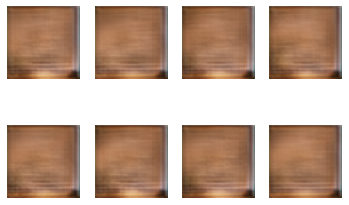

25001 [D loss: 1.269397, acc.: 67.19%, op_acc: 65.62%] [G loss: 1.546978]
25002 [D loss: 1.317709, acc.: 67.19%, op_acc: 66.45%] [G loss: 1.388276]
25003 [D loss: 1.177289, acc.: 78.12%, op_acc: 65.43%] [G loss: 1.524192]
25004 [D loss: 1.091176, acc.: 81.25%, op_acc: 65.35%] [G loss: 1.602408]
25005 [D loss: 1.233254, acc.: 71.88%, op_acc: 65.27%] [G loss: 1.522089]
25006 [D loss: 1.072548, acc.: 82.81%, op_acc: 66.95%] [G loss: 1.649257]
25007 [D loss: 1.154274, acc.: 75.00%, op_acc: 65.98%] [G loss: 1.786977]
25008 [D loss: 1.125800, acc.: 75.00%, op_acc: 65.86%] [G loss: 1.676558]
25009 [D loss: 1.090463, acc.: 81.25%, op_acc: 65.86%] [G loss: 1.358605]
25010 [D loss: 1.230920, acc.: 68.75%, op_acc: 64.53%] [G loss: 1.825642]
25011 [D loss: 1.267069, acc.: 75.00%, op_acc: 64.96%] [G loss: 1.675666]
25012 [D loss: 1.093488, acc.: 82.81%, op_acc: 66.02%] [G loss: 1.902380]
25013 [D loss: 1.128577, acc.: 81.25%, op_acc: 64.53%] [G loss: 1.583983]
25014 [D loss: 1.108793, acc.: 79.69%,

25113 [D loss: 0.584587, acc.: 98.44%, op_acc: 68.12%] [G loss: 0.927909]
25114 [D loss: 0.595820, acc.: 98.44%, op_acc: 66.72%] [G loss: 0.902553]
25115 [D loss: 0.628474, acc.: 98.44%, op_acc: 66.45%] [G loss: 0.909176]
25116 [D loss: 0.583588, acc.: 100.00%, op_acc: 67.46%] [G loss: 0.935123]
25117 [D loss: 0.602851, acc.: 98.44%, op_acc: 66.99%] [G loss: 0.927106]
25118 [D loss: 0.555991, acc.: 100.00%, op_acc: 67.58%] [G loss: 0.925038]
25119 [D loss: 0.613548, acc.: 100.00%, op_acc: 66.99%] [G loss: 0.909263]
25120 [D loss: 0.659227, acc.: 96.88%, op_acc: 68.75%] [G loss: 0.921249]
25121 [D loss: 0.601627, acc.: 100.00%, op_acc: 68.09%] [G loss: 0.879828]
25122 [D loss: 0.579712, acc.: 98.44%, op_acc: 67.73%] [G loss: 0.945672]
25123 [D loss: 0.595038, acc.: 100.00%, op_acc: 65.66%] [G loss: 0.929670]
25124 [D loss: 0.648607, acc.: 95.31%, op_acc: 66.29%] [G loss: 0.899298]
25125 [D loss: 0.636252, acc.: 96.88%, op_acc: 67.58%] [G loss: 0.906961]
25126 [D loss: 0.572946, acc.: 10

25225 [D loss: 0.655007, acc.: 96.88%, op_acc: 67.03%] [G loss: 0.985588]
25226 [D loss: 0.652798, acc.: 96.88%, op_acc: 67.70%] [G loss: 0.986637]
25227 [D loss: 0.730751, acc.: 95.31%, op_acc: 66.95%] [G loss: 0.986964]
25228 [D loss: 0.764069, acc.: 95.31%, op_acc: 65.82%] [G loss: 0.981789]
25229 [D loss: 0.671765, acc.: 95.31%, op_acc: 68.79%] [G loss: 0.954944]
25230 [D loss: 0.641425, acc.: 96.88%, op_acc: 66.60%] [G loss: 0.983800]
25231 [D loss: 0.594329, acc.: 98.44%, op_acc: 68.75%] [G loss: 0.960689]
25232 [D loss: 0.613776, acc.: 98.44%, op_acc: 69.14%] [G loss: 0.964953]
25233 [D loss: 0.723915, acc.: 95.31%, op_acc: 67.30%] [G loss: 0.976709]
25234 [D loss: 0.599480, acc.: 100.00%, op_acc: 67.58%] [G loss: 0.996895]
25235 [D loss: 0.598388, acc.: 100.00%, op_acc: 66.56%] [G loss: 0.983803]
25236 [D loss: 0.642496, acc.: 96.88%, op_acc: 68.55%] [G loss: 0.961746]
25237 [D loss: 0.613750, acc.: 98.44%, op_acc: 68.05%] [G loss: 0.998195]
25238 [D loss: 0.623992, acc.: 98.44

25337 [D loss: 2.966705, acc.: 42.19%, op_acc: 63.36%] [G loss: 9.880175]
25338 [D loss: 1.803149, acc.: 62.50%, op_acc: 59.65%] [G loss: 7.241647]
25339 [D loss: 1.614479, acc.: 60.94%, op_acc: 62.42%] [G loss: 2.868822]
25340 [D loss: 1.775858, acc.: 42.19%, op_acc: 66.09%] [G loss: 4.761923]
25341 [D loss: 1.181851, acc.: 76.56%, op_acc: 65.23%] [G loss: 5.537804]
25342 [D loss: 1.185565, acc.: 73.44%, op_acc: 65.08%] [G loss: 3.932575]
25343 [D loss: 0.937402, acc.: 87.50%, op_acc: 66.48%] [G loss: 3.246751]
25344 [D loss: 1.130900, acc.: 81.25%, op_acc: 64.45%] [G loss: 3.042379]
25345 [D loss: 0.768633, acc.: 95.31%, op_acc: 66.56%] [G loss: 3.254868]
25346 [D loss: 1.050993, acc.: 81.25%, op_acc: 65.00%] [G loss: 2.152446]
25347 [D loss: 0.911995, acc.: 92.19%, op_acc: 65.23%] [G loss: 1.687596]
25348 [D loss: 1.054674, acc.: 85.94%, op_acc: 65.59%] [G loss: 1.671877]
25349 [D loss: 0.795105, acc.: 96.88%, op_acc: 66.41%] [G loss: 1.555974]
25350 [D loss: 0.967745, acc.: 87.50%,

25449 [D loss: 0.664778, acc.: 98.44%, op_acc: 68.16%] [G loss: 1.121670]
25450 [D loss: 0.888904, acc.: 89.06%, op_acc: 65.55%] [G loss: 0.951840]
25451 [D loss: 0.855729, acc.: 95.31%, op_acc: 66.33%] [G loss: 0.971103]
25452 [D loss: 0.699632, acc.: 95.31%, op_acc: 68.12%] [G loss: 0.932382]
25453 [D loss: 0.720434, acc.: 96.88%, op_acc: 67.11%] [G loss: 0.978139]
25454 [D loss: 0.847522, acc.: 87.50%, op_acc: 66.52%] [G loss: 0.956833]
25455 [D loss: 0.715168, acc.: 95.31%, op_acc: 67.97%] [G loss: 0.971738]
25456 [D loss: 0.730251, acc.: 93.75%, op_acc: 67.19%] [G loss: 0.933567]
25457 [D loss: 0.799716, acc.: 92.19%, op_acc: 66.48%] [G loss: 0.964393]
25458 [D loss: 0.774770, acc.: 95.31%, op_acc: 65.12%] [G loss: 1.049492]
25459 [D loss: 0.647641, acc.: 98.44%, op_acc: 68.40%] [G loss: 1.129860]
25460 [D loss: 0.719913, acc.: 93.75%, op_acc: 68.36%] [G loss: 1.010396]
25461 [D loss: 0.704460, acc.: 96.88%, op_acc: 66.84%] [G loss: 0.971904]
25462 [D loss: 0.884323, acc.: 90.62%,

25560 [D loss: 1.102994, acc.: 65.62%, op_acc: 66.05%] [G loss: 2.087834]
25561 [D loss: 0.800037, acc.: 93.75%, op_acc: 67.38%] [G loss: 2.129840]
25562 [D loss: 0.958452, acc.: 87.50%, op_acc: 64.41%] [G loss: 1.394671]
25563 [D loss: 0.855730, acc.: 93.75%, op_acc: 66.52%] [G loss: 1.498842]
25564 [D loss: 0.811993, acc.: 92.19%, op_acc: 66.56%] [G loss: 1.528552]
25565 [D loss: 0.933511, acc.: 89.06%, op_acc: 66.45%] [G loss: 1.199444]
25566 [D loss: 0.783831, acc.: 96.88%, op_acc: 67.62%] [G loss: 1.158991]
25567 [D loss: 0.846509, acc.: 89.06%, op_acc: 64.96%] [G loss: 1.181335]
25568 [D loss: 0.725306, acc.: 98.44%, op_acc: 66.05%] [G loss: 1.208028]
25569 [D loss: 0.852809, acc.: 95.31%, op_acc: 66.68%] [G loss: 1.161169]
25570 [D loss: 0.777554, acc.: 93.75%, op_acc: 64.65%] [G loss: 1.171984]
25571 [D loss: 0.907234, acc.: 90.62%, op_acc: 66.33%] [G loss: 1.028403]
25572 [D loss: 0.881510, acc.: 92.19%, op_acc: 67.50%] [G loss: 1.025436]
25573 [D loss: 0.763351, acc.: 96.88%,

25672 [D loss: 1.388301, acc.: 62.50%, op_acc: 64.65%] [G loss: 1.438809]
25673 [D loss: 1.191606, acc.: 67.19%, op_acc: 65.16%] [G loss: 1.435125]
25674 [D loss: 1.330873, acc.: 57.81%, op_acc: 64.96%] [G loss: 1.430871]
25675 [D loss: 1.306176, acc.: 54.69%, op_acc: 64.77%] [G loss: 1.455619]
25676 [D loss: 1.473203, acc.: 57.81%, op_acc: 65.47%] [G loss: 1.373088]
25677 [D loss: 1.416699, acc.: 53.12%, op_acc: 64.77%] [G loss: 1.463804]
25678 [D loss: 1.479453, acc.: 56.25%, op_acc: 64.14%] [G loss: 1.423884]
25679 [D loss: 1.087582, acc.: 82.81%, op_acc: 66.09%] [G loss: 1.523324]
25680 [D loss: 1.440263, acc.: 68.75%, op_acc: 62.50%] [G loss: 1.342178]
25681 [D loss: 1.560126, acc.: 56.25%, op_acc: 64.65%] [G loss: 1.253860]
25682 [D loss: 1.084503, acc.: 81.25%, op_acc: 66.76%] [G loss: 1.220085]
25683 [D loss: 1.247583, acc.: 70.31%, op_acc: 65.70%] [G loss: 1.101533]
25684 [D loss: 1.186386, acc.: 75.00%, op_acc: 65.51%] [G loss: 1.062260]
25685 [D loss: 1.248271, acc.: 75.00%,

25784 [D loss: 0.627291, acc.: 98.44%, op_acc: 67.81%] [G loss: 0.894404]
25785 [D loss: 0.619748, acc.: 96.88%, op_acc: 68.24%] [G loss: 0.960706]
25786 [D loss: 0.592503, acc.: 100.00%, op_acc: 69.26%] [G loss: 0.931635]
25787 [D loss: 0.632102, acc.: 98.44%, op_acc: 68.09%] [G loss: 0.908193]
25788 [D loss: 0.591083, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.942184]
25789 [D loss: 0.566220, acc.: 100.00%, op_acc: 68.79%] [G loss: 0.938191]
25790 [D loss: 0.615667, acc.: 98.44%, op_acc: 67.93%] [G loss: 0.906015]
25791 [D loss: 0.688654, acc.: 96.88%, op_acc: 66.56%] [G loss: 0.917726]
25792 [D loss: 0.591633, acc.: 100.00%, op_acc: 67.85%] [G loss: 0.926684]
25793 [D loss: 0.591813, acc.: 96.88%, op_acc: 69.34%] [G loss: 0.953416]
25794 [D loss: 0.609003, acc.: 100.00%, op_acc: 68.09%] [G loss: 0.923189]
25795 [D loss: 0.627267, acc.: 98.44%, op_acc: 67.70%] [G loss: 0.881805]
25796 [D loss: 0.650261, acc.: 98.44%, op_acc: 66.13%] [G loss: 0.879157]
25797 [D loss: 0.598604, acc.: 98

25896 [D loss: 0.818523, acc.: 89.06%, op_acc: 66.68%] [G loss: 1.179392]
25897 [D loss: 0.697574, acc.: 96.88%, op_acc: 65.74%] [G loss: 1.190936]
25898 [D loss: 0.761492, acc.: 95.31%, op_acc: 67.77%] [G loss: 1.008641]
25899 [D loss: 0.728687, acc.: 93.75%, op_acc: 65.98%] [G loss: 1.160744]
25900 [D loss: 0.750174, acc.: 93.75%, op_acc: 68.95%] [G loss: 1.133008]
25901 [D loss: 0.728987, acc.: 95.31%, op_acc: 66.72%] [G loss: 1.637870]
25902 [D loss: 0.620923, acc.: 98.44%, op_acc: 69.06%] [G loss: 1.357581]
25903 [D loss: 0.699674, acc.: 96.88%, op_acc: 65.74%] [G loss: 1.287197]
25904 [D loss: 0.641826, acc.: 96.88%, op_acc: 66.68%] [G loss: 1.559367]
25905 [D loss: 0.692881, acc.: 98.44%, op_acc: 66.56%] [G loss: 1.690562]
25906 [D loss: 0.631452, acc.: 100.00%, op_acc: 66.99%] [G loss: 2.114264]
25907 [D loss: 0.629771, acc.: 96.88%, op_acc: 67.66%] [G loss: 1.870919]
25908 [D loss: 0.601987, acc.: 98.44%, op_acc: 66.56%] [G loss: 1.795687]
25909 [D loss: 0.749174, acc.: 95.31%

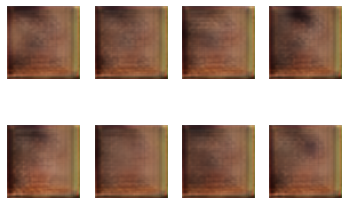

26001 [D loss: 0.689444, acc.: 96.88%, op_acc: 68.52%] [G loss: 0.968064]
26002 [D loss: 0.588438, acc.: 100.00%, op_acc: 69.84%] [G loss: 0.963779]
26003 [D loss: 0.734935, acc.: 95.31%, op_acc: 66.95%] [G loss: 0.952772]
26004 [D loss: 0.581227, acc.: 100.00%, op_acc: 68.36%] [G loss: 0.964049]
26005 [D loss: 0.614040, acc.: 98.44%, op_acc: 67.89%] [G loss: 0.979181]
26006 [D loss: 0.676174, acc.: 96.88%, op_acc: 66.99%] [G loss: 0.966916]
26007 [D loss: 0.589460, acc.: 100.00%, op_acc: 67.38%] [G loss: 1.026136]
26008 [D loss: 0.595259, acc.: 98.44%, op_acc: 70.08%] [G loss: 0.994787]
26009 [D loss: 0.600742, acc.: 98.44%, op_acc: 67.03%] [G loss: 1.009920]
26010 [D loss: 0.619699, acc.: 100.00%, op_acc: 66.13%] [G loss: 0.984885]
26011 [D loss: 0.600061, acc.: 98.44%, op_acc: 66.64%] [G loss: 1.003722]
26012 [D loss: 0.619031, acc.: 98.44%, op_acc: 67.38%] [G loss: 0.992541]
26013 [D loss: 0.617141, acc.: 98.44%, op_acc: 67.11%] [G loss: 0.955654]
26014 [D loss: 0.563848, acc.: 100

26113 [D loss: 0.721966, acc.: 98.44%, op_acc: 65.78%] [G loss: 1.018020]
26114 [D loss: 0.704774, acc.: 96.88%, op_acc: 66.72%] [G loss: 1.013625]
26115 [D loss: 0.811119, acc.: 95.31%, op_acc: 67.58%] [G loss: 0.965737]
26116 [D loss: 0.774415, acc.: 95.31%, op_acc: 65.82%] [G loss: 1.027186]
26117 [D loss: 0.790748, acc.: 96.88%, op_acc: 67.97%] [G loss: 0.996651]
26118 [D loss: 0.947043, acc.: 89.06%, op_acc: 65.94%] [G loss: 1.040526]
26119 [D loss: 0.926993, acc.: 90.62%, op_acc: 67.15%] [G loss: 1.104218]
26120 [D loss: 0.783892, acc.: 90.62%, op_acc: 66.91%] [G loss: 1.095809]
26121 [D loss: 1.021647, acc.: 81.25%, op_acc: 65.98%] [G loss: 1.133770]
26122 [D loss: 1.178474, acc.: 79.69%, op_acc: 64.96%] [G loss: 1.388833]
26123 [D loss: 1.077991, acc.: 81.25%, op_acc: 66.99%] [G loss: 1.493877]
26124 [D loss: 0.769011, acc.: 95.31%, op_acc: 66.64%] [G loss: 1.525635]
26125 [D loss: 0.909907, acc.: 84.38%, op_acc: 66.99%] [G loss: 2.147621]
26126 [D loss: 1.617705, acc.: 42.19%,

26225 [D loss: 0.716972, acc.: 93.75%, op_acc: 67.15%] [G loss: 0.967860]
26226 [D loss: 0.730665, acc.: 95.31%, op_acc: 66.09%] [G loss: 0.976044]
26227 [D loss: 0.624798, acc.: 98.44%, op_acc: 65.66%] [G loss: 0.958691]
26228 [D loss: 0.730815, acc.: 93.75%, op_acc: 66.48%] [G loss: 0.940989]
26229 [D loss: 0.621771, acc.: 98.44%, op_acc: 66.91%] [G loss: 1.091027]
26230 [D loss: 0.641261, acc.: 98.44%, op_acc: 65.98%] [G loss: 1.011478]
26231 [D loss: 0.744999, acc.: 95.31%, op_acc: 67.03%] [G loss: 0.997769]
26232 [D loss: 0.661708, acc.: 98.44%, op_acc: 66.21%] [G loss: 1.106479]
26233 [D loss: 0.788036, acc.: 93.75%, op_acc: 63.83%] [G loss: 1.348327]
26234 [D loss: 0.807297, acc.: 90.62%, op_acc: 67.03%] [G loss: 1.737819]
26235 [D loss: 1.040754, acc.: 81.25%, op_acc: 65.04%] [G loss: 2.301933]
26236 [D loss: 1.375177, acc.: 65.62%, op_acc: 64.53%] [G loss: 3.712207]
26237 [D loss: 1.150996, acc.: 82.81%, op_acc: 62.27%] [G loss: 4.436715]
26238 [D loss: 1.470168, acc.: 51.56%,

26337 [D loss: 0.729785, acc.: 96.88%, op_acc: 65.35%] [G loss: 0.950953]
26338 [D loss: 0.739474, acc.: 96.88%, op_acc: 66.33%] [G loss: 0.917433]
26339 [D loss: 0.701101, acc.: 95.31%, op_acc: 68.16%] [G loss: 0.918541]
26340 [D loss: 0.629171, acc.: 100.00%, op_acc: 67.97%] [G loss: 0.960979]
26341 [D loss: 0.609201, acc.: 100.00%, op_acc: 67.66%] [G loss: 0.944462]
26342 [D loss: 0.658916, acc.: 96.88%, op_acc: 68.01%] [G loss: 0.914196]
26343 [D loss: 0.630015, acc.: 98.44%, op_acc: 67.66%] [G loss: 0.907498]
26344 [D loss: 0.613920, acc.: 98.44%, op_acc: 66.99%] [G loss: 0.941383]
26345 [D loss: 0.624894, acc.: 96.88%, op_acc: 67.70%] [G loss: 0.951486]
26346 [D loss: 0.675403, acc.: 96.88%, op_acc: 68.95%] [G loss: 0.901829]
26347 [D loss: 0.669548, acc.: 96.88%, op_acc: 67.66%] [G loss: 0.920606]
26348 [D loss: 0.637017, acc.: 98.44%, op_acc: 66.05%] [G loss: 0.901572]
26349 [D loss: 0.605472, acc.: 100.00%, op_acc: 67.70%] [G loss: 0.999089]
26350 [D loss: 0.695646, acc.: 96.8

26449 [D loss: 0.590356, acc.: 100.00%, op_acc: 67.11%] [G loss: 1.064151]
26450 [D loss: 0.562644, acc.: 100.00%, op_acc: 67.73%] [G loss: 0.982084]
26451 [D loss: 0.573721, acc.: 100.00%, op_acc: 66.45%] [G loss: 0.996250]
26452 [D loss: 0.711444, acc.: 95.31%, op_acc: 67.30%] [G loss: 1.004482]
26453 [D loss: 0.579624, acc.: 100.00%, op_acc: 67.07%] [G loss: 0.980586]
26454 [D loss: 0.686184, acc.: 95.31%, op_acc: 67.62%] [G loss: 1.000495]
26455 [D loss: 0.681948, acc.: 95.31%, op_acc: 67.15%] [G loss: 1.001602]
26456 [D loss: 0.936421, acc.: 92.19%, op_acc: 64.92%] [G loss: 1.005435]
26457 [D loss: 0.621656, acc.: 100.00%, op_acc: 66.48%] [G loss: 1.106616]
26458 [D loss: 0.562868, acc.: 100.00%, op_acc: 68.32%] [G loss: 1.085499]
26459 [D loss: 0.829416, acc.: 96.88%, op_acc: 65.62%] [G loss: 1.095024]
26460 [D loss: 0.889962, acc.: 92.19%, op_acc: 66.95%] [G loss: 1.034296]
26461 [D loss: 0.597167, acc.: 100.00%, op_acc: 65.70%] [G loss: 1.101783]
26462 [D loss: 0.687751, acc.: 

26561 [D loss: 0.895118, acc.: 89.06%, op_acc: 67.73%] [G loss: 1.182019]
26562 [D loss: 0.818815, acc.: 95.31%, op_acc: 66.52%] [G loss: 1.375331]
26563 [D loss: 0.810577, acc.: 90.62%, op_acc: 67.89%] [G loss: 1.197652]
26564 [D loss: 0.665619, acc.: 98.44%, op_acc: 67.58%] [G loss: 1.258501]
26565 [D loss: 0.824729, acc.: 95.31%, op_acc: 66.45%] [G loss: 1.184491]
26566 [D loss: 0.887339, acc.: 92.19%, op_acc: 65.70%] [G loss: 1.145274]
26567 [D loss: 0.705877, acc.: 98.44%, op_acc: 66.91%] [G loss: 1.111322]
26568 [D loss: 0.720396, acc.: 93.75%, op_acc: 66.45%] [G loss: 1.101188]
26569 [D loss: 0.732443, acc.: 96.88%, op_acc: 65.47%] [G loss: 1.100726]
26570 [D loss: 0.661897, acc.: 98.44%, op_acc: 67.42%] [G loss: 1.106791]
26571 [D loss: 0.652622, acc.: 98.44%, op_acc: 67.11%] [G loss: 1.180161]
26572 [D loss: 0.744027, acc.: 95.31%, op_acc: 65.23%] [G loss: 1.111746]
26573 [D loss: 0.683409, acc.: 98.44%, op_acc: 66.48%] [G loss: 1.118630]
26574 [D loss: 0.682320, acc.: 98.44%,

26673 [D loss: 0.587988, acc.: 100.00%, op_acc: 65.70%] [G loss: 0.961636]
26674 [D loss: 0.630484, acc.: 98.44%, op_acc: 66.05%] [G loss: 0.932508]
26675 [D loss: 0.612322, acc.: 98.44%, op_acc: 66.17%] [G loss: 0.905007]
26676 [D loss: 0.719972, acc.: 93.75%, op_acc: 65.98%] [G loss: 0.957344]
26677 [D loss: 0.593264, acc.: 100.00%, op_acc: 65.55%] [G loss: 0.959481]
26678 [D loss: 0.589375, acc.: 100.00%, op_acc: 65.90%] [G loss: 0.949068]
26679 [D loss: 0.608535, acc.: 98.44%, op_acc: 65.59%] [G loss: 0.914339]
26680 [D loss: 0.604802, acc.: 98.44%, op_acc: 65.20%] [G loss: 0.938852]
26681 [D loss: 0.619278, acc.: 98.44%, op_acc: 68.20%] [G loss: 0.884760]
26682 [D loss: 0.601758, acc.: 100.00%, op_acc: 67.34%] [G loss: 0.938530]
26683 [D loss: 0.629954, acc.: 96.88%, op_acc: 66.37%] [G loss: 0.926644]
26684 [D loss: 0.628996, acc.: 98.44%, op_acc: 67.03%] [G loss: 0.920758]
26685 [D loss: 0.576130, acc.: 100.00%, op_acc: 66.72%] [G loss: 0.912905]
26686 [D loss: 0.596671, acc.: 98

26785 [D loss: 0.830170, acc.: 90.62%, op_acc: 66.87%] [G loss: 1.120946]
26786 [D loss: 0.888331, acc.: 89.06%, op_acc: 67.73%] [G loss: 1.038000]
26787 [D loss: 0.835376, acc.: 90.62%, op_acc: 68.01%] [G loss: 1.047470]
26788 [D loss: 0.821714, acc.: 93.75%, op_acc: 65.27%] [G loss: 1.164219]
26789 [D loss: 0.902642, acc.: 85.94%, op_acc: 65.66%] [G loss: 1.108365]
26790 [D loss: 0.908944, acc.: 92.19%, op_acc: 65.47%] [G loss: 1.099057]
26791 [D loss: 0.941593, acc.: 81.25%, op_acc: 65.55%] [G loss: 1.128962]
26792 [D loss: 0.747689, acc.: 96.88%, op_acc: 67.15%] [G loss: 1.136793]
26793 [D loss: 0.845010, acc.: 87.50%, op_acc: 68.75%] [G loss: 1.021110]
26794 [D loss: 0.836554, acc.: 89.06%, op_acc: 67.50%] [G loss: 1.090160]
26795 [D loss: 0.820733, acc.: 92.19%, op_acc: 67.50%] [G loss: 1.143872]
26796 [D loss: 0.859163, acc.: 90.62%, op_acc: 65.27%] [G loss: 1.083817]
26797 [D loss: 0.827488, acc.: 93.75%, op_acc: 66.17%] [G loss: 1.057062]
26798 [D loss: 0.837393, acc.: 93.75%,

26897 [D loss: 0.735665, acc.: 95.31%, op_acc: 66.25%] [G loss: 1.022956]
26898 [D loss: 0.688966, acc.: 96.88%, op_acc: 66.68%] [G loss: 1.076297]
26899 [D loss: 0.696046, acc.: 98.44%, op_acc: 66.17%] [G loss: 1.001336]
26900 [D loss: 1.107000, acc.: 90.62%, op_acc: 64.18%] [G loss: 0.972018]
26901 [D loss: 0.675663, acc.: 98.44%, op_acc: 66.21%] [G loss: 0.992228]
26902 [D loss: 0.596929, acc.: 100.00%, op_acc: 68.12%] [G loss: 1.005018]
26903 [D loss: 0.630547, acc.: 98.44%, op_acc: 67.03%] [G loss: 1.011678]
26904 [D loss: 0.633633, acc.: 100.00%, op_acc: 66.56%] [G loss: 0.962833]
26905 [D loss: 0.621093, acc.: 100.00%, op_acc: 67.93%] [G loss: 1.032162]
26906 [D loss: 0.607190, acc.: 100.00%, op_acc: 66.99%] [G loss: 0.999541]
26907 [D loss: 0.665264, acc.: 98.44%, op_acc: 68.09%] [G loss: 0.941801]
26908 [D loss: 0.614315, acc.: 100.00%, op_acc: 67.42%] [G loss: 0.961898]
26909 [D loss: 0.610119, acc.: 96.88%, op_acc: 67.54%] [G loss: 0.980267]
26910 [D loss: 0.821387, acc.: 92

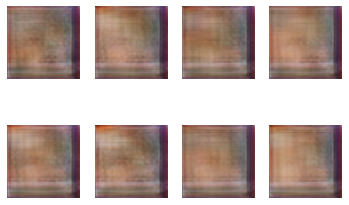

27001 [D loss: 0.959241, acc.: 95.31%, op_acc: 65.70%] [G loss: 2.185189]
27002 [D loss: 1.313900, acc.: 62.50%, op_acc: 64.41%] [G loss: 1.758434]
27003 [D loss: 1.129176, acc.: 68.75%, op_acc: 66.25%] [G loss: 2.025826]
27004 [D loss: 0.978684, acc.: 85.94%, op_acc: 65.94%] [G loss: 2.228464]
27005 [D loss: 1.211367, acc.: 68.75%, op_acc: 65.47%] [G loss: 2.095151]
27006 [D loss: 1.019549, acc.: 82.81%, op_acc: 66.13%] [G loss: 1.999796]
27007 [D loss: 1.249223, acc.: 73.44%, op_acc: 66.33%] [G loss: 1.683758]
27008 [D loss: 0.919997, acc.: 96.88%, op_acc: 68.44%] [G loss: 1.781880]
27009 [D loss: 1.132634, acc.: 78.12%, op_acc: 66.41%] [G loss: 1.864066]
27010 [D loss: 1.245394, acc.: 65.62%, op_acc: 65.70%] [G loss: 1.686164]
27011 [D loss: 1.278367, acc.: 68.75%, op_acc: 64.84%] [G loss: 1.659819]
27012 [D loss: 1.181132, acc.: 68.75%, op_acc: 67.03%] [G loss: 1.635175]
27013 [D loss: 1.313274, acc.: 67.19%, op_acc: 65.90%] [G loss: 1.585123]
27014 [D loss: 1.277029, acc.: 64.06%,

27113 [D loss: 1.318762, acc.: 51.56%, op_acc: 66.05%] [G loss: 1.495181]
27114 [D loss: 1.122934, acc.: 76.56%, op_acc: 67.46%] [G loss: 1.525798]
27115 [D loss: 1.264979, acc.: 67.19%, op_acc: 66.37%] [G loss: 1.383468]
27116 [D loss: 1.466120, acc.: 40.62%, op_acc: 65.16%] [G loss: 1.263756]
27117 [D loss: 1.205062, acc.: 60.94%, op_acc: 67.03%] [G loss: 1.374882]
27118 [D loss: 1.346965, acc.: 62.50%, op_acc: 68.12%] [G loss: 1.287204]
27119 [D loss: 1.390014, acc.: 43.75%, op_acc: 65.98%] [G loss: 1.337050]
27120 [D loss: 1.358847, acc.: 54.69%, op_acc: 65.70%] [G loss: 1.307399]
27121 [D loss: 1.231490, acc.: 71.88%, op_acc: 67.03%] [G loss: 1.367719]
27122 [D loss: 1.560494, acc.: 39.06%, op_acc: 64.37%] [G loss: 1.318515]
27123 [D loss: 1.247781, acc.: 57.81%, op_acc: 65.82%] [G loss: 1.493233]
27124 [D loss: 1.328417, acc.: 64.06%, op_acc: 66.25%] [G loss: 1.459454]
27125 [D loss: 1.326212, acc.: 64.06%, op_acc: 65.20%] [G loss: 1.436444]
27126 [D loss: 1.369072, acc.: 45.31%,

27225 [D loss: 0.959530, acc.: 85.94%, op_acc: 65.00%] [G loss: 0.962027]
27226 [D loss: 0.791771, acc.: 95.31%, op_acc: 66.33%] [G loss: 0.985070]
27227 [D loss: 0.837064, acc.: 93.75%, op_acc: 65.86%] [G loss: 1.006251]
27228 [D loss: 0.777223, acc.: 96.88%, op_acc: 65.16%] [G loss: 0.963402]
27229 [D loss: 0.842939, acc.: 89.06%, op_acc: 67.66%] [G loss: 0.996929]
27230 [D loss: 0.771623, acc.: 95.31%, op_acc: 64.38%] [G loss: 0.992416]
27231 [D loss: 0.714032, acc.: 93.75%, op_acc: 67.15%] [G loss: 1.058263]
27232 [D loss: 0.835223, acc.: 96.88%, op_acc: 65.43%] [G loss: 1.033452]
27233 [D loss: 0.798109, acc.: 93.75%, op_acc: 67.30%] [G loss: 0.910466]
27234 [D loss: 0.784264, acc.: 90.62%, op_acc: 66.09%] [G loss: 0.935867]
27235 [D loss: 0.949613, acc.: 92.19%, op_acc: 64.18%] [G loss: 0.908615]
27236 [D loss: 0.818437, acc.: 92.19%, op_acc: 66.99%] [G loss: 0.876219]
27237 [D loss: 0.770948, acc.: 95.31%, op_acc: 65.82%] [G loss: 0.899911]
27238 [D loss: 0.837264, acc.: 92.19%,

27337 [D loss: 0.763406, acc.: 92.19%, op_acc: 67.58%] [G loss: 1.041589]
27338 [D loss: 0.600293, acc.: 96.88%, op_acc: 68.24%] [G loss: 1.025867]
27339 [D loss: 0.675003, acc.: 96.88%, op_acc: 66.87%] [G loss: 1.000413]
27340 [D loss: 0.740652, acc.: 93.75%, op_acc: 67.15%] [G loss: 1.035463]
27341 [D loss: 0.669997, acc.: 95.31%, op_acc: 67.85%] [G loss: 1.002500]
27342 [D loss: 0.784702, acc.: 93.75%, op_acc: 65.39%] [G loss: 1.021685]
27343 [D loss: 0.792904, acc.: 89.06%, op_acc: 66.60%] [G loss: 1.184754]
27344 [D loss: 0.667558, acc.: 95.31%, op_acc: 67.07%] [G loss: 1.145128]
27345 [D loss: 0.698187, acc.: 96.88%, op_acc: 66.68%] [G loss: 0.991328]
27346 [D loss: 0.688252, acc.: 93.75%, op_acc: 68.36%] [G loss: 1.152105]
27347 [D loss: 0.730357, acc.: 98.44%, op_acc: 66.37%] [G loss: 1.253506]
27348 [D loss: 1.099045, acc.: 81.25%, op_acc: 65.59%] [G loss: 1.438039]
27349 [D loss: 0.767650, acc.: 98.44%, op_acc: 67.50%] [G loss: 1.529772]
27350 [D loss: 1.175126, acc.: 68.75%,

27448 [D loss: 1.387808, acc.: 73.44%, op_acc: 63.32%] [G loss: 1.525556]
27449 [D loss: 1.241818, acc.: 71.88%, op_acc: 66.87%] [G loss: 1.415371]
27450 [D loss: 1.172124, acc.: 75.00%, op_acc: 66.72%] [G loss: 1.471964]
27451 [D loss: 1.308441, acc.: 71.88%, op_acc: 65.08%] [G loss: 1.365084]
27452 [D loss: 1.250180, acc.: 73.44%, op_acc: 65.27%] [G loss: 1.370521]
27453 [D loss: 1.287444, acc.: 67.19%, op_acc: 64.10%] [G loss: 1.325900]
27454 [D loss: 1.297936, acc.: 78.12%, op_acc: 64.77%] [G loss: 1.334674]
27455 [D loss: 1.258194, acc.: 70.31%, op_acc: 67.38%] [G loss: 1.319677]
27456 [D loss: 1.170332, acc.: 78.12%, op_acc: 64.73%] [G loss: 1.394998]
27457 [D loss: 1.236302, acc.: 67.19%, op_acc: 66.17%] [G loss: 1.269976]
27458 [D loss: 1.452867, acc.: 45.31%, op_acc: 64.22%] [G loss: 1.232435]
27459 [D loss: 1.178437, acc.: 62.50%, op_acc: 65.74%] [G loss: 1.292022]
27460 [D loss: 1.427678, acc.: 46.88%, op_acc: 66.33%] [G loss: 1.171029]
27461 [D loss: 1.496207, acc.: 43.75%,

27560 [D loss: 0.996291, acc.: 92.19%, op_acc: 65.74%] [G loss: 1.714327]
27561 [D loss: 0.939958, acc.: 92.19%, op_acc: 66.72%] [G loss: 1.790826]
27562 [D loss: 0.968169, acc.: 90.62%, op_acc: 65.98%] [G loss: 1.760019]
27563 [D loss: 0.984253, acc.: 89.06%, op_acc: 64.26%] [G loss: 1.744289]
27564 [D loss: 0.976656, acc.: 87.50%, op_acc: 65.98%] [G loss: 1.669863]
27565 [D loss: 0.955078, acc.: 93.75%, op_acc: 64.57%] [G loss: 1.677640]
27566 [D loss: 0.900735, acc.: 93.75%, op_acc: 65.55%] [G loss: 1.675742]
27567 [D loss: 1.029950, acc.: 84.38%, op_acc: 65.55%] [G loss: 1.635153]
27568 [D loss: 1.072067, acc.: 85.94%, op_acc: 64.65%] [G loss: 1.437190]
27569 [D loss: 1.005935, acc.: 87.50%, op_acc: 66.91%] [G loss: 1.548511]
27570 [D loss: 1.066695, acc.: 82.81%, op_acc: 67.46%] [G loss: 1.449178]
27571 [D loss: 1.169096, acc.: 75.00%, op_acc: 64.41%] [G loss: 1.286453]
27572 [D loss: 1.180974, acc.: 67.19%, op_acc: 66.72%] [G loss: 1.255027]
27573 [D loss: 1.212980, acc.: 68.75%,

27672 [D loss: 1.173700, acc.: 67.19%, op_acc: 68.67%] [G loss: 1.677359]
27673 [D loss: 1.111794, acc.: 79.69%, op_acc: 67.58%] [G loss: 1.780159]
27674 [D loss: 1.182849, acc.: 82.81%, op_acc: 68.05%] [G loss: 1.655815]
27675 [D loss: 1.162634, acc.: 79.69%, op_acc: 67.58%] [G loss: 1.750543]
27676 [D loss: 1.152512, acc.: 68.75%, op_acc: 67.03%] [G loss: 1.735939]
27677 [D loss: 1.162547, acc.: 75.00%, op_acc: 66.21%] [G loss: 1.635233]
27678 [D loss: 1.112625, acc.: 76.56%, op_acc: 66.21%] [G loss: 1.671271]
27679 [D loss: 1.161087, acc.: 75.00%, op_acc: 67.54%] [G loss: 1.713743]
27680 [D loss: 1.142097, acc.: 82.81%, op_acc: 66.09%] [G loss: 1.733473]
27681 [D loss: 1.196332, acc.: 76.56%, op_acc: 65.51%] [G loss: 1.645398]
27682 [D loss: 1.136931, acc.: 76.56%, op_acc: 65.94%] [G loss: 1.674682]
27683 [D loss: 1.220446, acc.: 68.75%, op_acc: 65.08%] [G loss: 1.466367]
27684 [D loss: 1.290296, acc.: 62.50%, op_acc: 65.86%] [G loss: 1.515413]
27685 [D loss: 1.316544, acc.: 64.06%,

27784 [D loss: 1.014626, acc.: 81.25%, op_acc: 66.72%] [G loss: 0.987889]
27785 [D loss: 0.936557, acc.: 84.38%, op_acc: 65.55%] [G loss: 0.961463]
27786 [D loss: 0.776100, acc.: 96.88%, op_acc: 68.20%] [G loss: 0.937290]
27787 [D loss: 0.800768, acc.: 95.31%, op_acc: 65.62%] [G loss: 1.008358]
27788 [D loss: 0.824412, acc.: 95.31%, op_acc: 66.84%] [G loss: 0.925796]
27789 [D loss: 0.870276, acc.: 95.31%, op_acc: 68.12%] [G loss: 0.940204]
27790 [D loss: 0.731158, acc.: 100.00%, op_acc: 65.82%] [G loss: 0.941999]
27791 [D loss: 0.720665, acc.: 98.44%, op_acc: 65.98%] [G loss: 0.956671]
27792 [D loss: 0.747031, acc.: 95.31%, op_acc: 67.38%] [G loss: 0.930990]
27793 [D loss: 0.713452, acc.: 96.88%, op_acc: 66.80%] [G loss: 0.907784]
27794 [D loss: 0.707910, acc.: 98.44%, op_acc: 67.27%] [G loss: 0.960990]
27795 [D loss: 0.702239, acc.: 96.88%, op_acc: 66.76%] [G loss: 0.986429]
27796 [D loss: 0.690297, acc.: 100.00%, op_acc: 65.39%] [G loss: 0.942089]
27797 [D loss: 0.693467, acc.: 100.0

27896 [D loss: 0.849952, acc.: 92.19%, op_acc: 66.02%] [G loss: 1.075238]
27897 [D loss: 0.800716, acc.: 96.88%, op_acc: 66.91%] [G loss: 1.047686]
27898 [D loss: 0.968558, acc.: 81.25%, op_acc: 67.42%] [G loss: 1.021446]
27899 [D loss: 1.013027, acc.: 85.94%, op_acc: 64.38%] [G loss: 1.063419]
27900 [D loss: 0.894909, acc.: 92.19%, op_acc: 64.61%] [G loss: 1.072073]
27901 [D loss: 1.121390, acc.: 78.12%, op_acc: 65.86%] [G loss: 0.994101]
27902 [D loss: 0.974120, acc.: 93.75%, op_acc: 66.05%] [G loss: 1.042036]
27903 [D loss: 0.884886, acc.: 92.19%, op_acc: 66.52%] [G loss: 1.031449]
27904 [D loss: 0.794810, acc.: 96.88%, op_acc: 66.84%] [G loss: 1.076825]
27905 [D loss: 0.779126, acc.: 98.44%, op_acc: 66.72%] [G loss: 1.051757]
27906 [D loss: 0.817654, acc.: 95.31%, op_acc: 67.07%] [G loss: 1.051671]
27907 [D loss: 0.876982, acc.: 95.31%, op_acc: 65.59%] [G loss: 1.043887]
27908 [D loss: 0.988591, acc.: 85.94%, op_acc: 65.78%] [G loss: 1.044780]
27909 [D loss: 0.829890, acc.: 96.88%,

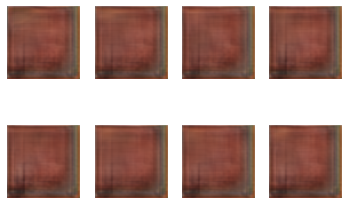

28001 [D loss: 0.816711, acc.: 93.75%, op_acc: 64.53%] [G loss: 1.099274]
28002 [D loss: 0.811844, acc.: 96.88%, op_acc: 67.42%] [G loss: 1.064942]
28003 [D loss: 0.789728, acc.: 96.88%, op_acc: 65.20%] [G loss: 1.107690]
28004 [D loss: 0.805146, acc.: 95.31%, op_acc: 65.94%] [G loss: 1.054398]
28005 [D loss: 0.848047, acc.: 93.75%, op_acc: 66.99%] [G loss: 1.033164]
28006 [D loss: 0.809600, acc.: 96.88%, op_acc: 67.03%] [G loss: 1.021156]
28007 [D loss: 0.802031, acc.: 93.75%, op_acc: 66.64%] [G loss: 1.006471]
28008 [D loss: 0.806988, acc.: 96.88%, op_acc: 66.37%] [G loss: 0.997069]
28009 [D loss: 0.837768, acc.: 92.19%, op_acc: 65.82%] [G loss: 0.964163]
28010 [D loss: 0.704108, acc.: 100.00%, op_acc: 66.91%] [G loss: 0.979888]
28011 [D loss: 0.701805, acc.: 98.44%, op_acc: 69.45%] [G loss: 1.008035]
28012 [D loss: 0.816517, acc.: 95.31%, op_acc: 67.42%] [G loss: 0.982665]
28013 [D loss: 0.708846, acc.: 98.44%, op_acc: 66.87%] [G loss: 0.975653]
28014 [D loss: 0.700400, acc.: 100.00

28112 [D loss: 0.686963, acc.: 98.44%, op_acc: 67.81%] [G loss: 1.010051]
28113 [D loss: 0.859576, acc.: 92.19%, op_acc: 66.52%] [G loss: 0.961991]
28114 [D loss: 0.645744, acc.: 98.44%, op_acc: 65.90%] [G loss: 0.979216]
28115 [D loss: 0.774841, acc.: 93.75%, op_acc: 66.72%] [G loss: 0.975331]
28116 [D loss: 0.782503, acc.: 95.31%, op_acc: 66.17%] [G loss: 0.943023]
28117 [D loss: 0.791472, acc.: 92.19%, op_acc: 65.47%] [G loss: 0.995900]
28118 [D loss: 0.711380, acc.: 96.88%, op_acc: 65.66%] [G loss: 0.996676]
28119 [D loss: 0.687189, acc.: 98.44%, op_acc: 66.17%] [G loss: 0.988539]
28120 [D loss: 0.668221, acc.: 96.88%, op_acc: 67.97%] [G loss: 0.950178]
28121 [D loss: 0.685003, acc.: 96.88%, op_acc: 66.45%] [G loss: 0.979717]
28122 [D loss: 0.638774, acc.: 98.44%, op_acc: 67.42%] [G loss: 1.028416]
28123 [D loss: 0.649582, acc.: 98.44%, op_acc: 67.23%] [G loss: 0.967331]
28124 [D loss: 0.633594, acc.: 98.44%, op_acc: 67.19%] [G loss: 0.998458]
28125 [D loss: 0.627815, acc.: 100.00%

28224 [D loss: 1.102557, acc.: 79.69%, op_acc: 66.99%] [G loss: 1.291686]
28225 [D loss: 1.349068, acc.: 65.62%, op_acc: 64.53%] [G loss: 1.206723]
28226 [D loss: 0.960222, acc.: 87.50%, op_acc: 66.45%] [G loss: 1.335923]
28227 [D loss: 1.125581, acc.: 75.00%, op_acc: 66.56%] [G loss: 1.166142]
28228 [D loss: 1.111066, acc.: 78.12%, op_acc: 65.12%] [G loss: 1.202044]
28229 [D loss: 1.063910, acc.: 87.50%, op_acc: 65.66%] [G loss: 1.272346]
28230 [D loss: 1.089364, acc.: 75.00%, op_acc: 68.09%] [G loss: 1.146850]
28231 [D loss: 1.046199, acc.: 85.94%, op_acc: 66.80%] [G loss: 1.209691]
28232 [D loss: 0.966752, acc.: 89.06%, op_acc: 63.63%] [G loss: 1.211903]
28233 [D loss: 1.094670, acc.: 81.25%, op_acc: 67.77%] [G loss: 1.123349]
28234 [D loss: 1.143837, acc.: 76.56%, op_acc: 66.68%] [G loss: 1.086137]
28235 [D loss: 1.017562, acc.: 81.25%, op_acc: 67.54%] [G loss: 1.101173]
28236 [D loss: 0.970957, acc.: 87.50%, op_acc: 67.38%] [G loss: 1.124123]
28237 [D loss: 0.957347, acc.: 84.38%,

28336 [D loss: 0.614956, acc.: 98.44%, op_acc: 65.47%] [G loss: 0.998823]
28337 [D loss: 0.573571, acc.: 100.00%, op_acc: 67.42%] [G loss: 1.012313]
28338 [D loss: 0.640348, acc.: 96.88%, op_acc: 65.94%] [G loss: 0.988438]
28339 [D loss: 0.605059, acc.: 98.44%, op_acc: 68.24%] [G loss: 0.954821]
28340 [D loss: 0.571905, acc.: 100.00%, op_acc: 67.50%] [G loss: 0.994235]
28341 [D loss: 0.616920, acc.: 98.44%, op_acc: 67.62%] [G loss: 0.979163]
28342 [D loss: 0.572139, acc.: 100.00%, op_acc: 67.03%] [G loss: 1.039428]
28343 [D loss: 0.613192, acc.: 98.44%, op_acc: 64.80%] [G loss: 0.981538]
28344 [D loss: 0.619534, acc.: 98.44%, op_acc: 67.30%] [G loss: 1.013067]
28345 [D loss: 0.657305, acc.: 96.88%, op_acc: 67.62%] [G loss: 0.997666]
28346 [D loss: 0.598894, acc.: 100.00%, op_acc: 66.72%] [G loss: 1.002487]
28347 [D loss: 0.576839, acc.: 98.44%, op_acc: 66.37%] [G loss: 0.957934]
28348 [D loss: 0.583733, acc.: 98.44%, op_acc: 68.79%] [G loss: 0.939459]
28349 [D loss: 0.583496, acc.: 100

28448 [D loss: 0.601848, acc.: 98.44%, op_acc: 66.68%] [G loss: 0.947199]
28449 [D loss: 0.707112, acc.: 95.31%, op_acc: 67.15%] [G loss: 0.928740]
28450 [D loss: 0.619005, acc.: 100.00%, op_acc: 66.21%] [G loss: 0.940656]
28451 [D loss: 0.608607, acc.: 100.00%, op_acc: 66.33%] [G loss: 0.952311]
28452 [D loss: 0.597799, acc.: 100.00%, op_acc: 68.59%] [G loss: 0.951476]
28453 [D loss: 0.584991, acc.: 100.00%, op_acc: 66.52%] [G loss: 0.955607]
28454 [D loss: 0.587975, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.959249]
28455 [D loss: 0.641075, acc.: 98.44%, op_acc: 66.76%] [G loss: 0.946157]
28456 [D loss: 0.617975, acc.: 96.88%, op_acc: 67.15%] [G loss: 0.964521]
28457 [D loss: 0.632010, acc.: 98.44%, op_acc: 68.79%] [G loss: 0.923160]
28458 [D loss: 0.592496, acc.: 98.44%, op_acc: 66.45%] [G loss: 0.981461]
28459 [D loss: 0.613608, acc.: 98.44%, op_acc: 66.72%] [G loss: 0.959460]
28460 [D loss: 0.592803, acc.: 98.44%, op_acc: 66.56%] [G loss: 0.986638]
28461 [D loss: 0.575566, acc.: 10

28560 [D loss: 0.805545, acc.: 93.75%, op_acc: 66.13%] [G loss: 0.964176]
28561 [D loss: 0.672207, acc.: 100.00%, op_acc: 66.13%] [G loss: 0.996267]
28562 [D loss: 0.688902, acc.: 96.88%, op_acc: 67.70%] [G loss: 1.004463]
28563 [D loss: 0.677163, acc.: 95.31%, op_acc: 67.15%] [G loss: 0.993509]
28564 [D loss: 0.824456, acc.: 93.75%, op_acc: 65.08%] [G loss: 0.980635]
28565 [D loss: 0.813761, acc.: 93.75%, op_acc: 67.11%] [G loss: 0.934792]
28566 [D loss: 0.730459, acc.: 96.88%, op_acc: 66.72%] [G loss: 0.972622]
28567 [D loss: 0.702540, acc.: 96.88%, op_acc: 66.45%] [G loss: 1.026804]
28568 [D loss: 0.755307, acc.: 95.31%, op_acc: 67.27%] [G loss: 0.982134]
28569 [D loss: 0.658232, acc.: 98.44%, op_acc: 66.05%] [G loss: 0.999544]
28570 [D loss: 0.768671, acc.: 95.31%, op_acc: 65.59%] [G loss: 0.949015]
28571 [D loss: 0.660257, acc.: 98.44%, op_acc: 67.07%] [G loss: 1.029490]
28572 [D loss: 0.738021, acc.: 95.31%, op_acc: 67.11%] [G loss: 1.014108]
28573 [D loss: 0.838488, acc.: 90.62%

28672 [D loss: 0.622927, acc.: 96.88%, op_acc: 67.54%] [G loss: 0.984601]
28673 [D loss: 0.645782, acc.: 100.00%, op_acc: 67.73%] [G loss: 0.995749]
28674 [D loss: 0.597784, acc.: 100.00%, op_acc: 69.61%] [G loss: 0.965796]
28675 [D loss: 0.745208, acc.: 95.31%, op_acc: 65.98%] [G loss: 0.987534]
28676 [D loss: 0.650518, acc.: 100.00%, op_acc: 66.76%] [G loss: 1.037614]
28677 [D loss: 0.635849, acc.: 98.44%, op_acc: 66.48%] [G loss: 1.018170]
28678 [D loss: 0.649102, acc.: 100.00%, op_acc: 66.37%] [G loss: 1.074315]
28679 [D loss: 0.618695, acc.: 100.00%, op_acc: 66.99%] [G loss: 1.034370]
28680 [D loss: 0.722733, acc.: 96.88%, op_acc: 66.37%] [G loss: 1.007680]
28681 [D loss: 0.693497, acc.: 98.44%, op_acc: 65.20%] [G loss: 1.019072]
28682 [D loss: 0.744738, acc.: 96.88%, op_acc: 66.60%] [G loss: 0.993864]
28683 [D loss: 0.713965, acc.: 95.31%, op_acc: 68.36%] [G loss: 0.974007]
28684 [D loss: 0.731844, acc.: 98.44%, op_acc: 66.80%] [G loss: 0.994158]
28685 [D loss: 0.725653, acc.: 96

28783 [D loss: 0.575144, acc.: 100.00%, op_acc: 68.44%] [G loss: 0.996339]
28784 [D loss: 0.684139, acc.: 95.31%, op_acc: 67.19%] [G loss: 1.018937]
28785 [D loss: 0.809202, acc.: 93.75%, op_acc: 68.28%] [G loss: 0.950344]
28786 [D loss: 0.695586, acc.: 95.31%, op_acc: 66.48%] [G loss: 0.996174]
28787 [D loss: 0.718852, acc.: 96.88%, op_acc: 66.21%] [G loss: 1.056708]
28788 [D loss: 0.690536, acc.: 96.88%, op_acc: 67.19%] [G loss: 1.057404]
28789 [D loss: 1.296196, acc.: 70.31%, op_acc: 65.47%] [G loss: 1.869610]
28790 [D loss: 1.201535, acc.: 85.94%, op_acc: 62.97%] [G loss: 1.029431]
28791 [D loss: 0.990211, acc.: 81.25%, op_acc: 65.35%] [G loss: 1.285066]
28792 [D loss: 1.316771, acc.: 82.81%, op_acc: 63.20%] [G loss: 1.044449]
28793 [D loss: 0.719429, acc.: 95.31%, op_acc: 64.96%] [G loss: 1.291653]
28794 [D loss: 0.956437, acc.: 90.62%, op_acc: 63.36%] [G loss: 0.997423]
28795 [D loss: 0.999641, acc.: 82.81%, op_acc: 66.05%] [G loss: 1.129800]
28796 [D loss: 0.780261, acc.: 92.19%

28895 [D loss: 1.129671, acc.: 81.25%, op_acc: 64.18%] [G loss: 1.902547]
28896 [D loss: 1.201247, acc.: 76.56%, op_acc: 65.20%] [G loss: 1.432360]
28897 [D loss: 1.279280, acc.: 71.88%, op_acc: 65.08%] [G loss: 1.432660]
28898 [D loss: 1.359568, acc.: 84.38%, op_acc: 62.11%] [G loss: 1.140057]
28899 [D loss: 1.149718, acc.: 89.06%, op_acc: 64.30%] [G loss: 1.090889]
28900 [D loss: 1.167275, acc.: 79.69%, op_acc: 66.99%] [G loss: 1.037123]
28901 [D loss: 1.064782, acc.: 81.25%, op_acc: 65.31%] [G loss: 1.128922]
28902 [D loss: 0.901990, acc.: 93.75%, op_acc: 66.33%] [G loss: 1.194751]
28903 [D loss: 1.138779, acc.: 93.75%, op_acc: 64.10%] [G loss: 1.203937]
28904 [D loss: 1.087504, acc.: 82.81%, op_acc: 64.14%] [G loss: 1.159484]
28905 [D loss: 0.832351, acc.: 96.88%, op_acc: 66.13%] [G loss: 1.129313]
28906 [D loss: 0.782837, acc.: 96.88%, op_acc: 65.59%] [G loss: 1.180405]
28907 [D loss: 0.739577, acc.: 96.88%, op_acc: 66.45%] [G loss: 1.242306]
28908 [D loss: 0.752331, acc.: 96.88%,

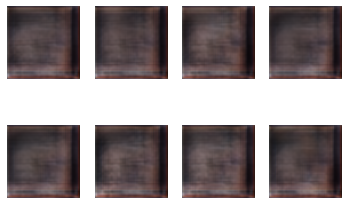

29001 [D loss: 1.112063, acc.: 85.94%, op_acc: 66.72%] [G loss: 1.610080]
29002 [D loss: 0.811200, acc.: 98.44%, op_acc: 65.31%] [G loss: 1.905702]
29003 [D loss: 0.870399, acc.: 87.50%, op_acc: 65.98%] [G loss: 1.796309]
29004 [D loss: 1.071480, acc.: 87.50%, op_acc: 65.31%] [G loss: 1.390840]
29005 [D loss: 1.118834, acc.: 81.25%, op_acc: 66.64%] [G loss: 1.176721]
29006 [D loss: 0.816595, acc.: 95.31%, op_acc: 66.87%] [G loss: 1.354515]
29007 [D loss: 0.758386, acc.: 96.88%, op_acc: 66.17%] [G loss: 1.551304]
29008 [D loss: 1.100595, acc.: 85.94%, op_acc: 64.61%] [G loss: 1.150066]
29009 [D loss: 0.873119, acc.: 93.75%, op_acc: 66.02%] [G loss: 1.258031]
29010 [D loss: 0.872228, acc.: 92.19%, op_acc: 67.11%] [G loss: 1.117303]
29011 [D loss: 1.045494, acc.: 84.38%, op_acc: 65.31%] [G loss: 1.124346]
29012 [D loss: 1.119272, acc.: 84.38%, op_acc: 64.38%] [G loss: 1.147905]
29013 [D loss: 0.781464, acc.: 93.75%, op_acc: 67.23%] [G loss: 1.123844]
29014 [D loss: 0.747724, acc.: 93.75%,

29113 [D loss: 0.916453, acc.: 90.62%, op_acc: 65.66%] [G loss: 1.160588]
29114 [D loss: 1.035380, acc.: 81.25%, op_acc: 66.29%] [G loss: 1.853227]
29115 [D loss: 0.835754, acc.: 90.62%, op_acc: 66.29%] [G loss: 1.458538]
29116 [D loss: 1.429584, acc.: 54.69%, op_acc: 64.61%] [G loss: 7.010619]
29117 [D loss: 1.466830, acc.: 82.81%, op_acc: 61.72%] [G loss: 1.721154]
29118 [D loss: 1.933975, acc.: 39.06%, op_acc: 63.67%] [G loss: 5.056521]
29119 [D loss: 1.242783, acc.: 84.38%, op_acc: 61.41%] [G loss: 5.272393]
29120 [D loss: 1.066309, acc.: 89.06%, op_acc: 63.55%] [G loss: 3.073140]
29121 [D loss: 0.763558, acc.: 98.44%, op_acc: 65.12%] [G loss: 2.948446]
29122 [D loss: 0.840693, acc.: 93.75%, op_acc: 65.08%] [G loss: 3.595490]
29123 [D loss: 0.721907, acc.: 96.88%, op_acc: 65.31%] [G loss: 4.167676]
29124 [D loss: 0.719396, acc.: 93.75%, op_acc: 65.94%] [G loss: 4.172231]
29125 [D loss: 0.893404, acc.: 87.50%, op_acc: 64.53%] [G loss: 3.577174]
29126 [D loss: 0.611511, acc.: 98.44%,

29225 [D loss: 1.133344, acc.: 75.00%, op_acc: 65.62%] [G loss: 1.987675]
29226 [D loss: 1.056198, acc.: 81.25%, op_acc: 66.33%] [G loss: 1.842912]
29227 [D loss: 1.084491, acc.: 85.94%, op_acc: 65.43%] [G loss: 2.000293]
29228 [D loss: 1.343827, acc.: 67.19%, op_acc: 64.14%] [G loss: 1.864665]
29229 [D loss: 1.240619, acc.: 62.50%, op_acc: 66.68%] [G loss: 1.682262]
29230 [D loss: 1.345698, acc.: 48.44%, op_acc: 65.31%] [G loss: 1.632252]
29231 [D loss: 1.460595, acc.: 54.69%, op_acc: 63.48%] [G loss: 1.609686]
29232 [D loss: 1.239196, acc.: 56.25%, op_acc: 66.37%] [G loss: 1.608834]
29233 [D loss: 1.302241, acc.: 60.94%, op_acc: 65.62%] [G loss: 1.549434]
29234 [D loss: 1.415002, acc.: 53.12%, op_acc: 64.84%] [G loss: 1.541167]
29235 [D loss: 1.347050, acc.: 56.25%, op_acc: 64.77%] [G loss: 1.516348]
29236 [D loss: 1.399979, acc.: 50.00%, op_acc: 65.04%] [G loss: 1.504037]
29237 [D loss: 1.364361, acc.: 48.44%, op_acc: 66.37%] [G loss: 1.505731]
29238 [D loss: 1.310956, acc.: 62.50%,

29337 [D loss: 1.330170, acc.: 57.81%, op_acc: 65.51%] [G loss: 1.537553]
29338 [D loss: 1.220138, acc.: 76.56%, op_acc: 65.98%] [G loss: 1.330098]
29339 [D loss: 1.214696, acc.: 75.00%, op_acc: 66.02%] [G loss: 1.437673]
29340 [D loss: 1.162928, acc.: 79.69%, op_acc: 66.29%] [G loss: 1.384037]
29341 [D loss: 1.115403, acc.: 75.00%, op_acc: 67.46%] [G loss: 1.287952]
29342 [D loss: 1.177719, acc.: 82.81%, op_acc: 66.68%] [G loss: 1.331183]
29343 [D loss: 1.175636, acc.: 78.12%, op_acc: 65.55%] [G loss: 1.281829]
29344 [D loss: 1.148592, acc.: 82.81%, op_acc: 65.94%] [G loss: 1.319231]
29345 [D loss: 1.082381, acc.: 93.75%, op_acc: 65.43%] [G loss: 1.273154]
29346 [D loss: 1.141966, acc.: 81.25%, op_acc: 66.29%] [G loss: 1.283513]
29347 [D loss: 1.117359, acc.: 84.38%, op_acc: 65.04%] [G loss: 1.340560]
29348 [D loss: 1.062076, acc.: 90.62%, op_acc: 65.90%] [G loss: 1.304136]
29349 [D loss: 1.189896, acc.: 76.56%, op_acc: 65.90%] [G loss: 1.184411]
29350 [D loss: 1.176893, acc.: 81.25%,

29448 [D loss: 1.009572, acc.: 84.38%, op_acc: 66.91%] [G loss: 1.115941]
29449 [D loss: 0.867008, acc.: 92.19%, op_acc: 65.16%] [G loss: 1.088391]
29450 [D loss: 0.838331, acc.: 93.75%, op_acc: 64.38%] [G loss: 1.047276]
29451 [D loss: 0.848605, acc.: 92.19%, op_acc: 67.03%] [G loss: 1.016972]
29452 [D loss: 0.897991, acc.: 85.94%, op_acc: 65.59%] [G loss: 1.012139]
29453 [D loss: 0.733634, acc.: 100.00%, op_acc: 66.80%] [G loss: 1.020329]
29454 [D loss: 0.828435, acc.: 92.19%, op_acc: 65.70%] [G loss: 1.020416]
29455 [D loss: 0.842461, acc.: 90.62%, op_acc: 65.00%] [G loss: 1.029781]
29456 [D loss: 0.799376, acc.: 92.19%, op_acc: 67.11%] [G loss: 1.025064]
29457 [D loss: 0.704749, acc.: 96.88%, op_acc: 66.91%] [G loss: 1.028580]
29458 [D loss: 0.653206, acc.: 98.44%, op_acc: 65.94%] [G loss: 1.002213]
29459 [D loss: 0.712243, acc.: 95.31%, op_acc: 67.62%] [G loss: 1.012662]
29460 [D loss: 0.738662, acc.: 92.19%, op_acc: 68.16%] [G loss: 1.026856]
29461 [D loss: 0.752199, acc.: 95.31%

29560 [D loss: 0.878506, acc.: 92.19%, op_acc: 66.05%] [G loss: 1.004024]
29561 [D loss: 0.894913, acc.: 92.19%, op_acc: 65.78%] [G loss: 0.968374]
29562 [D loss: 0.970697, acc.: 87.50%, op_acc: 67.27%] [G loss: 0.915033]
29563 [D loss: 0.826735, acc.: 92.19%, op_acc: 65.78%] [G loss: 0.978103]
29564 [D loss: 0.741749, acc.: 96.88%, op_acc: 65.74%] [G loss: 1.028145]
29565 [D loss: 0.838648, acc.: 89.06%, op_acc: 67.19%] [G loss: 0.979571]
29566 [D loss: 0.830416, acc.: 92.19%, op_acc: 68.71%] [G loss: 0.935771]
29567 [D loss: 0.758702, acc.: 96.88%, op_acc: 65.98%] [G loss: 0.957624]
29568 [D loss: 0.795098, acc.: 98.44%, op_acc: 66.45%] [G loss: 0.962898]
29569 [D loss: 0.767236, acc.: 95.31%, op_acc: 66.09%] [G loss: 0.946232]
29570 [D loss: 0.718369, acc.: 95.31%, op_acc: 68.05%] [G loss: 0.941515]
29571 [D loss: 0.694638, acc.: 95.31%, op_acc: 66.91%] [G loss: 0.916970]
29572 [D loss: 0.656466, acc.: 98.44%, op_acc: 68.13%] [G loss: 0.938370]
29573 [D loss: 0.666871, acc.: 98.44%,

29672 [D loss: 0.619939, acc.: 100.00%, op_acc: 67.70%] [G loss: 1.128366]
29673 [D loss: 0.691594, acc.: 95.31%, op_acc: 67.81%] [G loss: 1.201628]
29674 [D loss: 1.047094, acc.: 70.31%, op_acc: 66.60%] [G loss: 1.390036]
29675 [D loss: 0.844221, acc.: 89.06%, op_acc: 64.96%] [G loss: 1.461933]
29676 [D loss: 1.088557, acc.: 82.81%, op_acc: 64.65%] [G loss: 1.406387]
29677 [D loss: 0.852603, acc.: 92.19%, op_acc: 67.89%] [G loss: 2.303842]
29678 [D loss: 0.880777, acc.: 90.62%, op_acc: 67.93%] [G loss: 2.862147]
29679 [D loss: 1.058787, acc.: 67.19%, op_acc: 65.98%] [G loss: 4.210609]
29680 [D loss: 0.946540, acc.: 90.62%, op_acc: 65.55%] [G loss: 4.403839]
29681 [D loss: 1.294669, acc.: 78.12%, op_acc: 64.06%] [G loss: 3.376038]
29682 [D loss: 1.128522, acc.: 75.00%, op_acc: 66.80%] [G loss: 3.095627]
29683 [D loss: 1.266283, acc.: 75.00%, op_acc: 65.82%] [G loss: 2.244228]
29684 [D loss: 1.458736, acc.: 64.06%, op_acc: 62.77%] [G loss: 1.643105]
29685 [D loss: 1.084386, acc.: 85.94%

29784 [D loss: 0.611550, acc.: 100.00%, op_acc: 68.20%] [G loss: 1.001255]
29785 [D loss: 0.669685, acc.: 98.44%, op_acc: 65.70%] [G loss: 1.010150]
29786 [D loss: 0.697699, acc.: 93.75%, op_acc: 67.19%] [G loss: 0.998173]
29787 [D loss: 0.679486, acc.: 96.88%, op_acc: 65.90%] [G loss: 0.999319]
29788 [D loss: 0.710264, acc.: 96.88%, op_acc: 64.96%] [G loss: 0.991648]
29789 [D loss: 0.614683, acc.: 98.44%, op_acc: 66.45%] [G loss: 0.994216]
29790 [D loss: 0.696547, acc.: 93.75%, op_acc: 66.21%] [G loss: 0.971681]
29791 [D loss: 0.628114, acc.: 100.00%, op_acc: 67.81%] [G loss: 1.002292]
29792 [D loss: 0.603472, acc.: 98.44%, op_acc: 68.44%] [G loss: 1.012296]
29793 [D loss: 0.594388, acc.: 100.00%, op_acc: 67.23%] [G loss: 1.004547]
29794 [D loss: 0.583169, acc.: 100.00%, op_acc: 67.89%] [G loss: 1.031779]
29795 [D loss: 0.630632, acc.: 98.44%, op_acc: 66.02%] [G loss: 1.021513]
29796 [D loss: 0.573857, acc.: 100.00%, op_acc: 67.30%] [G loss: 1.003389]
29797 [D loss: 0.592591, acc.: 98

29896 [D loss: 0.876988, acc.: 92.19%, op_acc: 66.41%] [G loss: 0.931927]
29897 [D loss: 0.802217, acc.: 95.31%, op_acc: 65.16%] [G loss: 0.939202]
29898 [D loss: 0.685003, acc.: 98.44%, op_acc: 64.84%] [G loss: 0.978469]
29899 [D loss: 0.715150, acc.: 95.31%, op_acc: 66.87%] [G loss: 0.972338]
29900 [D loss: 0.835077, acc.: 89.06%, op_acc: 64.96%] [G loss: 0.933886]
29901 [D loss: 0.743655, acc.: 95.31%, op_acc: 65.94%] [G loss: 0.920353]
29902 [D loss: 0.644349, acc.: 100.00%, op_acc: 67.50%] [G loss: 0.937306]
29903 [D loss: 0.704855, acc.: 96.88%, op_acc: 65.16%] [G loss: 0.931510]
29904 [D loss: 0.640943, acc.: 98.44%, op_acc: 66.72%] [G loss: 0.990264]
29905 [D loss: 0.642339, acc.: 96.88%, op_acc: 66.09%] [G loss: 0.914467]
29906 [D loss: 0.729036, acc.: 93.75%, op_acc: 67.34%] [G loss: 0.934403]
29907 [D loss: 0.696317, acc.: 98.44%, op_acc: 67.38%] [G loss: 0.938851]
29908 [D loss: 0.673129, acc.: 96.88%, op_acc: 65.94%] [G loss: 0.941596]
29909 [D loss: 0.643132, acc.: 98.44%

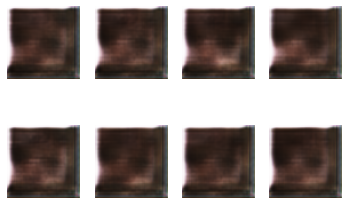

30001 [D loss: 0.627726, acc.: 98.44%, op_acc: 66.05%] [G loss: 2.133022]
30002 [D loss: 0.646978, acc.: 98.44%, op_acc: 68.48%] [G loss: 3.251269]
30003 [D loss: 0.709084, acc.: 92.19%, op_acc: 66.99%] [G loss: 2.922727]
30004 [D loss: 0.827134, acc.: 89.06%, op_acc: 65.90%] [G loss: 4.236340]
30005 [D loss: 0.790080, acc.: 92.19%, op_acc: 65.47%] [G loss: 3.553140]
30006 [D loss: 1.534899, acc.: 51.56%, op_acc: 68.09%] [G loss: 7.561535]
30007 [D loss: 3.146999, acc.: 65.62%, op_acc: 53.59%] [G loss: 2.378802]
30008 [D loss: 1.813288, acc.: 48.44%, op_acc: 63.40%] [G loss: 2.260416]
30009 [D loss: 1.428238, acc.: 78.12%, op_acc: 61.80%] [G loss: 1.980286]
30010 [D loss: 1.189553, acc.: 73.44%, op_acc: 65.51%] [G loss: 1.799782]
30011 [D loss: 1.432021, acc.: 75.00%, op_acc: 64.69%] [G loss: 1.802951]
30012 [D loss: 0.988104, acc.: 90.62%, op_acc: 66.45%] [G loss: 1.685727]
30013 [D loss: 0.882542, acc.: 87.50%, op_acc: 65.98%] [G loss: 1.387243]
30014 [D loss: 1.157753, acc.: 79.69%,

30113 [D loss: 0.631545, acc.: 98.44%, op_acc: 67.38%] [G loss: 0.959923]
30114 [D loss: 0.650991, acc.: 98.44%, op_acc: 66.05%] [G loss: 0.974915]
30115 [D loss: 0.788272, acc.: 93.75%, op_acc: 65.08%] [G loss: 0.948145]
30116 [D loss: 0.601088, acc.: 100.00%, op_acc: 67.70%] [G loss: 0.969741]
30117 [D loss: 0.589288, acc.: 100.00%, op_acc: 65.74%] [G loss: 1.005368]
30118 [D loss: 0.602436, acc.: 100.00%, op_acc: 67.07%] [G loss: 0.943786]
30119 [D loss: 0.731561, acc.: 96.88%, op_acc: 66.76%] [G loss: 0.963662]
30120 [D loss: 0.627689, acc.: 100.00%, op_acc: 65.70%] [G loss: 0.937978]
30121 [D loss: 0.611857, acc.: 100.00%, op_acc: 67.19%] [G loss: 0.925719]
30122 [D loss: 0.610289, acc.: 100.00%, op_acc: 66.25%] [G loss: 0.953153]
30123 [D loss: 0.606632, acc.: 96.88%, op_acc: 68.24%] [G loss: 0.917925]
30124 [D loss: 0.614628, acc.: 100.00%, op_acc: 67.62%] [G loss: 0.945570]
30125 [D loss: 0.748601, acc.: 96.88%, op_acc: 66.45%] [G loss: 0.911080]
30126 [D loss: 0.662472, acc.: 

30225 [D loss: 1.371513, acc.: 67.19%, op_acc: 64.34%] [G loss: 1.211158]
30226 [D loss: 1.291006, acc.: 64.06%, op_acc: 65.86%] [G loss: 1.171237]
30227 [D loss: 1.116397, acc.: 76.56%, op_acc: 66.37%] [G loss: 1.240826]
30228 [D loss: 1.339698, acc.: 70.31%, op_acc: 64.92%] [G loss: 1.194431]
30229 [D loss: 1.284424, acc.: 64.06%, op_acc: 67.46%] [G loss: 1.173771]
30230 [D loss: 1.227223, acc.: 67.19%, op_acc: 67.58%] [G loss: 1.137710]
30231 [D loss: 1.442953, acc.: 54.69%, op_acc: 64.02%] [G loss: 1.173203]
30232 [D loss: 1.302134, acc.: 64.06%, op_acc: 65.23%] [G loss: 1.254699]
30233 [D loss: 1.265569, acc.: 65.62%, op_acc: 65.98%] [G loss: 1.269005]
30234 [D loss: 1.319987, acc.: 65.62%, op_acc: 66.33%] [G loss: 1.278417]
30235 [D loss: 1.230068, acc.: 75.00%, op_acc: 66.21%] [G loss: 1.325724]
30236 [D loss: 1.301484, acc.: 65.62%, op_acc: 65.98%] [G loss: 1.302935]
30237 [D loss: 1.318643, acc.: 73.44%, op_acc: 65.43%] [G loss: 1.426635]
30238 [D loss: 1.323146, acc.: 50.00%,

30337 [D loss: 0.712206, acc.: 95.31%, op_acc: 67.46%] [G loss: 1.029459]
30338 [D loss: 0.689919, acc.: 98.44%, op_acc: 65.43%] [G loss: 1.098414]
30339 [D loss: 0.740303, acc.: 95.31%, op_acc: 64.65%] [G loss: 1.000531]
30340 [D loss: 0.798290, acc.: 95.31%, op_acc: 65.04%] [G loss: 0.976296]
30341 [D loss: 0.700106, acc.: 98.44%, op_acc: 66.25%] [G loss: 0.987873]
30342 [D loss: 0.717366, acc.: 96.88%, op_acc: 65.82%] [G loss: 0.938656]
30343 [D loss: 0.667376, acc.: 98.44%, op_acc: 66.91%] [G loss: 1.049206]
30344 [D loss: 0.671119, acc.: 96.88%, op_acc: 67.23%] [G loss: 0.988965]
30345 [D loss: 0.739523, acc.: 95.31%, op_acc: 65.00%] [G loss: 0.949420]
30346 [D loss: 0.709149, acc.: 98.44%, op_acc: 62.62%] [G loss: 0.930893]
30347 [D loss: 0.682804, acc.: 95.31%, op_acc: 66.91%] [G loss: 0.942934]
30348 [D loss: 0.659821, acc.: 98.44%, op_acc: 65.82%] [G loss: 0.974484]
30349 [D loss: 0.657340, acc.: 96.88%, op_acc: 65.90%] [G loss: 0.947131]
30350 [D loss: 0.739779, acc.: 95.31%,

30449 [D loss: 0.826538, acc.: 95.31%, op_acc: 65.66%] [G loss: 0.962907]
30450 [D loss: 0.694429, acc.: 96.88%, op_acc: 66.52%] [G loss: 0.945700]
30451 [D loss: 0.670062, acc.: 96.88%, op_acc: 66.48%] [G loss: 0.975325]
30452 [D loss: 0.678577, acc.: 96.88%, op_acc: 67.77%] [G loss: 0.953011]
30453 [D loss: 0.769794, acc.: 92.19%, op_acc: 67.62%] [G loss: 1.015797]
30454 [D loss: 0.708320, acc.: 98.44%, op_acc: 65.78%] [G loss: 1.013320]
30455 [D loss: 0.660002, acc.: 98.44%, op_acc: 67.30%] [G loss: 1.025046]
30456 [D loss: 0.681274, acc.: 96.88%, op_acc: 68.36%] [G loss: 0.944404]
30457 [D loss: 0.654396, acc.: 98.44%, op_acc: 67.54%] [G loss: 0.959265]
30458 [D loss: 0.682619, acc.: 98.44%, op_acc: 68.01%] [G loss: 1.004832]
30459 [D loss: 0.627890, acc.: 98.44%, op_acc: 67.03%] [G loss: 1.005806]
30460 [D loss: 0.637855, acc.: 98.44%, op_acc: 66.09%] [G loss: 1.022251]
30461 [D loss: 0.699741, acc.: 96.88%, op_acc: 67.58%] [G loss: 0.989634]
30462 [D loss: 0.669069, acc.: 95.31%,

30561 [D loss: 0.614145, acc.: 100.00%, op_acc: 67.89%] [G loss: 1.005599]
30562 [D loss: 0.607252, acc.: 98.44%, op_acc: 69.02%] [G loss: 1.027833]
30563 [D loss: 0.613123, acc.: 98.44%, op_acc: 68.09%] [G loss: 0.959594]
30564 [D loss: 0.604782, acc.: 98.44%, op_acc: 67.89%] [G loss: 1.028293]
30565 [D loss: 0.641979, acc.: 98.44%, op_acc: 67.03%] [G loss: 0.977646]
30566 [D loss: 0.674174, acc.: 96.88%, op_acc: 67.34%] [G loss: 0.978582]
30567 [D loss: 0.630046, acc.: 98.44%, op_acc: 66.99%] [G loss: 1.027866]
30568 [D loss: 0.643592, acc.: 96.88%, op_acc: 67.62%] [G loss: 1.006213]
30569 [D loss: 0.625252, acc.: 98.44%, op_acc: 67.81%] [G loss: 0.971944]
30570 [D loss: 0.631490, acc.: 98.44%, op_acc: 68.52%] [G loss: 0.972359]
30571 [D loss: 0.623736, acc.: 100.00%, op_acc: 67.73%] [G loss: 1.038888]
30572 [D loss: 0.585283, acc.: 100.00%, op_acc: 69.34%] [G loss: 0.973815]
30573 [D loss: 0.714573, acc.: 96.88%, op_acc: 68.40%] [G loss: 0.986543]
30574 [D loss: 0.587733, acc.: 98.4

30673 [D loss: 0.606076, acc.: 98.44%, op_acc: 67.38%] [G loss: 0.989121]
30674 [D loss: 0.577674, acc.: 100.00%, op_acc: 67.34%] [G loss: 1.009248]
30675 [D loss: 0.561753, acc.: 100.00%, op_acc: 67.03%] [G loss: 1.062538]
30676 [D loss: 0.594919, acc.: 98.44%, op_acc: 67.15%] [G loss: 1.029673]
30677 [D loss: 0.570472, acc.: 100.00%, op_acc: 66.48%] [G loss: 1.025674]
30678 [D loss: 0.559144, acc.: 100.00%, op_acc: 69.37%] [G loss: 1.035121]
30679 [D loss: 0.576317, acc.: 100.00%, op_acc: 67.15%] [G loss: 1.047966]
30680 [D loss: 0.709408, acc.: 95.31%, op_acc: 65.23%] [G loss: 1.028952]
30681 [D loss: 0.560091, acc.: 100.00%, op_acc: 68.32%] [G loss: 1.065642]
30682 [D loss: 0.572106, acc.: 100.00%, op_acc: 68.28%] [G loss: 1.156946]
30683 [D loss: 0.591198, acc.: 100.00%, op_acc: 68.28%] [G loss: 1.166110]
30684 [D loss: 0.583407, acc.: 100.00%, op_acc: 67.66%] [G loss: 1.044891]
30685 [D loss: 0.600238, acc.: 98.44%, op_acc: 69.80%] [G loss: 1.107664]
30686 [D loss: 0.633112, acc.

30784 [D loss: 0.599069, acc.: 98.44%, op_acc: 67.85%] [G loss: 0.981020]
30785 [D loss: 0.582462, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.965892]
30786 [D loss: 0.587292, acc.: 100.00%, op_acc: 67.23%] [G loss: 0.990995]
30787 [D loss: 0.620833, acc.: 100.00%, op_acc: 67.70%] [G loss: 0.972842]
30788 [D loss: 0.608483, acc.: 98.44%, op_acc: 67.97%] [G loss: 1.000388]
30789 [D loss: 0.572306, acc.: 100.00%, op_acc: 68.91%] [G loss: 0.979167]
30790 [D loss: 0.581875, acc.: 100.00%, op_acc: 68.52%] [G loss: 1.065511]
30791 [D loss: 0.690593, acc.: 98.44%, op_acc: 65.74%] [G loss: 1.042486]
30792 [D loss: 0.635918, acc.: 98.44%, op_acc: 67.77%] [G loss: 0.957992]
30793 [D loss: 0.567217, acc.: 100.00%, op_acc: 68.55%] [G loss: 1.016451]
30794 [D loss: 0.602565, acc.: 100.00%, op_acc: 67.15%] [G loss: 0.968125]
30795 [D loss: 0.754260, acc.: 96.88%, op_acc: 66.99%] [G loss: 0.964213]
30796 [D loss: 0.615723, acc.: 100.00%, op_acc: 67.81%] [G loss: 1.024705]
30797 [D loss: 0.648591, acc.:

30896 [D loss: 0.591972, acc.: 100.00%, op_acc: 67.81%] [G loss: 1.011701]
30897 [D loss: 0.633175, acc.: 98.44%, op_acc: 67.15%] [G loss: 0.999606]
30898 [D loss: 0.621241, acc.: 96.88%, op_acc: 69.34%] [G loss: 1.019526]
30899 [D loss: 0.651967, acc.: 95.31%, op_acc: 69.45%] [G loss: 1.056800]
30900 [D loss: 0.755422, acc.: 93.75%, op_acc: 68.67%] [G loss: 1.011699]
30901 [D loss: 0.665429, acc.: 96.88%, op_acc: 66.37%] [G loss: 1.003102]
30902 [D loss: 0.604830, acc.: 100.00%, op_acc: 68.63%] [G loss: 1.084393]
30903 [D loss: 0.629793, acc.: 98.44%, op_acc: 67.66%] [G loss: 1.008516]
30904 [D loss: 0.629171, acc.: 96.88%, op_acc: 68.67%] [G loss: 1.005734]
30905 [D loss: 0.635949, acc.: 98.44%, op_acc: 68.36%] [G loss: 1.023462]
30906 [D loss: 0.754136, acc.: 96.88%, op_acc: 68.09%] [G loss: 0.991765]
30907 [D loss: 0.621068, acc.: 98.44%, op_acc: 68.52%] [G loss: 1.068284]
30908 [D loss: 0.745914, acc.: 93.75%, op_acc: 66.76%] [G loss: 1.101386]
30909 [D loss: 0.634264, acc.: 98.44

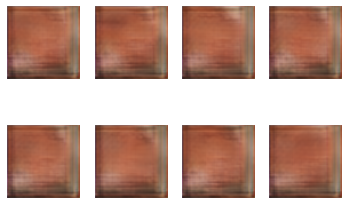

31001 [D loss: 0.941487, acc.: 85.94%, op_acc: 65.90%] [G loss: 1.199004]
31002 [D loss: 1.112339, acc.: 70.31%, op_acc: 66.17%] [G loss: 1.546500]
31003 [D loss: 2.418143, acc.: 32.81%, op_acc: 64.65%] [G loss: 1.645407]
31004 [D loss: 1.625552, acc.: 46.88%, op_acc: 65.00%] [G loss: 2.693764]
31005 [D loss: 2.155535, acc.: 37.50%, op_acc: 61.33%] [G loss: 2.380100]
31006 [D loss: 2.247048, acc.: 21.88%, op_acc: 62.38%] [G loss: 1.915502]
31007 [D loss: 1.277861, acc.: 68.75%, op_acc: 67.62%] [G loss: 2.408625]
31008 [D loss: 1.177686, acc.: 78.12%, op_acc: 65.35%] [G loss: 2.026962]
31009 [D loss: 1.425174, acc.: 62.50%, op_acc: 65.90%] [G loss: 1.920419]
31010 [D loss: 1.289226, acc.: 67.19%, op_acc: 66.99%] [G loss: 2.153016]
31011 [D loss: 0.964377, acc.: 87.50%, op_acc: 66.95%] [G loss: 2.536422]
31012 [D loss: 1.097743, acc.: 81.25%, op_acc: 66.60%] [G loss: 2.301023]
31013 [D loss: 1.105117, acc.: 78.12%, op_acc: 65.74%] [G loss: 2.350886]
31014 [D loss: 1.299107, acc.: 64.06%,

31113 [D loss: 0.805570, acc.: 95.31%, op_acc: 66.87%] [G loss: 1.191887]
31114 [D loss: 0.985308, acc.: 84.38%, op_acc: 65.12%] [G loss: 1.186274]
31115 [D loss: 0.923542, acc.: 85.94%, op_acc: 65.94%] [G loss: 1.228336]
31116 [D loss: 1.063902, acc.: 85.94%, op_acc: 64.69%] [G loss: 1.147483]
31117 [D loss: 0.916290, acc.: 90.62%, op_acc: 67.54%] [G loss: 1.298654]
31118 [D loss: 1.067134, acc.: 78.12%, op_acc: 65.47%] [G loss: 1.329883]
31119 [D loss: 1.088585, acc.: 79.69%, op_acc: 65.86%] [G loss: 1.204602]
31120 [D loss: 1.004012, acc.: 82.81%, op_acc: 66.56%] [G loss: 1.218149]
31121 [D loss: 0.996262, acc.: 85.94%, op_acc: 65.23%] [G loss: 1.225915]
31122 [D loss: 1.164494, acc.: 75.00%, op_acc: 64.73%] [G loss: 1.239009]
31123 [D loss: 1.182053, acc.: 68.75%, op_acc: 64.30%] [G loss: 1.285007]
31124 [D loss: 1.030021, acc.: 81.25%, op_acc: 66.37%] [G loss: 1.332758]
31125 [D loss: 1.152060, acc.: 76.56%, op_acc: 66.09%] [G loss: 1.262796]
31126 [D loss: 1.084931, acc.: 84.38%,

31225 [D loss: 1.177770, acc.: 81.25%, op_acc: 64.26%] [G loss: 1.508620]
31226 [D loss: 0.990800, acc.: 85.94%, op_acc: 66.80%] [G loss: 1.753614]
31227 [D loss: 0.989430, acc.: 82.81%, op_acc: 65.20%] [G loss: 1.478544]
31228 [D loss: 1.161862, acc.: 71.88%, op_acc: 64.30%] [G loss: 1.449058]
31229 [D loss: 0.923221, acc.: 89.06%, op_acc: 64.77%] [G loss: 1.596870]
31230 [D loss: 0.853218, acc.: 90.62%, op_acc: 66.13%] [G loss: 1.483980]
31231 [D loss: 1.170000, acc.: 76.56%, op_acc: 66.17%] [G loss: 1.479914]
31232 [D loss: 1.010385, acc.: 78.12%, op_acc: 65.55%] [G loss: 1.734976]
31233 [D loss: 1.028840, acc.: 85.94%, op_acc: 65.74%] [G loss: 1.593466]
31234 [D loss: 1.273008, acc.: 70.31%, op_acc: 65.98%] [G loss: 1.497002]
31235 [D loss: 0.984391, acc.: 82.81%, op_acc: 66.37%] [G loss: 1.585568]
31236 [D loss: 0.865756, acc.: 93.75%, op_acc: 65.43%] [G loss: 1.722773]
31237 [D loss: 1.099996, acc.: 82.81%, op_acc: 65.31%] [G loss: 2.025099]
31238 [D loss: 1.230534, acc.: 78.12%,

31337 [D loss: 0.853720, acc.: 92.19%, op_acc: 66.45%] [G loss: 1.011712]
31338 [D loss: 0.682366, acc.: 96.88%, op_acc: 69.10%] [G loss: 0.994300]
31339 [D loss: 0.863973, acc.: 87.50%, op_acc: 67.42%] [G loss: 0.984257]
31340 [D loss: 0.745808, acc.: 96.88%, op_acc: 68.95%] [G loss: 0.984833]
31341 [D loss: 0.854143, acc.: 89.06%, op_acc: 67.54%] [G loss: 0.994432]
31342 [D loss: 0.717326, acc.: 93.75%, op_acc: 69.26%] [G loss: 0.979119]
31343 [D loss: 0.730963, acc.: 98.44%, op_acc: 66.45%] [G loss: 1.037887]
31344 [D loss: 0.898791, acc.: 89.06%, op_acc: 64.96%] [G loss: 1.018911]
31345 [D loss: 0.880760, acc.: 87.50%, op_acc: 67.66%] [G loss: 0.962445]
31346 [D loss: 0.873164, acc.: 87.50%, op_acc: 66.87%] [G loss: 0.960898]
31347 [D loss: 0.861134, acc.: 92.19%, op_acc: 66.80%] [G loss: 0.996310]
31348 [D loss: 0.827493, acc.: 90.62%, op_acc: 66.13%] [G loss: 0.996791]
31349 [D loss: 0.704105, acc.: 95.31%, op_acc: 66.88%] [G loss: 0.957527]
31350 [D loss: 0.776867, acc.: 89.06%,

31448 [D loss: 0.750278, acc.: 96.88%, op_acc: 67.19%] [G loss: 1.137485]
31449 [D loss: 0.656254, acc.: 100.00%, op_acc: 66.91%] [G loss: 1.135121]
31450 [D loss: 0.804610, acc.: 93.75%, op_acc: 67.03%] [G loss: 1.212784]
31451 [D loss: 0.728213, acc.: 95.31%, op_acc: 66.91%] [G loss: 1.218832]
31452 [D loss: 0.896416, acc.: 93.75%, op_acc: 67.81%] [G loss: 1.390299]
31453 [D loss: 0.810950, acc.: 96.88%, op_acc: 68.05%] [G loss: 1.669128]
31454 [D loss: 0.719828, acc.: 95.31%, op_acc: 67.62%] [G loss: 1.558304]
31455 [D loss: 0.859270, acc.: 89.06%, op_acc: 66.09%] [G loss: 1.290019]
31456 [D loss: 0.932104, acc.: 89.06%, op_acc: 66.72%] [G loss: 1.226633]
31457 [D loss: 0.835107, acc.: 92.19%, op_acc: 66.56%] [G loss: 1.251684]
31458 [D loss: 0.836298, acc.: 90.62%, op_acc: 67.77%] [G loss: 1.102137]
31459 [D loss: 0.805060, acc.: 95.31%, op_acc: 66.45%] [G loss: 1.184790]
31460 [D loss: 0.895873, acc.: 85.94%, op_acc: 66.17%] [G loss: 1.134983]
31461 [D loss: 0.879024, acc.: 92.19%

31560 [D loss: 1.010513, acc.: 84.38%, op_acc: 64.22%] [G loss: 0.999172]
31561 [D loss: 1.024712, acc.: 85.94%, op_acc: 67.42%] [G loss: 0.991769]
31562 [D loss: 1.035844, acc.: 87.50%, op_acc: 65.94%] [G loss: 1.006995]
31563 [D loss: 0.976809, acc.: 87.50%, op_acc: 66.72%] [G loss: 0.991622]
31564 [D loss: 0.846198, acc.: 93.75%, op_acc: 65.59%] [G loss: 0.987444]
31565 [D loss: 0.858114, acc.: 93.75%, op_acc: 68.52%] [G loss: 0.949856]
31566 [D loss: 0.898696, acc.: 92.19%, op_acc: 68.40%] [G loss: 0.906633]
31567 [D loss: 0.852776, acc.: 95.31%, op_acc: 66.68%] [G loss: 0.934412]
31568 [D loss: 0.760560, acc.: 95.31%, op_acc: 67.70%] [G loss: 0.957002]
31569 [D loss: 0.746584, acc.: 98.44%, op_acc: 68.52%] [G loss: 0.923718]
31570 [D loss: 0.780889, acc.: 96.88%, op_acc: 66.41%] [G loss: 0.952958]
31571 [D loss: 0.821327, acc.: 92.19%, op_acc: 66.72%] [G loss: 0.939782]
31572 [D loss: 0.831132, acc.: 93.75%, op_acc: 67.89%] [G loss: 0.947132]
31573 [D loss: 0.738326, acc.: 95.31%,

31672 [D loss: 0.986619, acc.: 89.06%, op_acc: 66.05%] [G loss: 1.837813]
31673 [D loss: 1.108705, acc.: 79.69%, op_acc: 66.21%] [G loss: 1.718248]
31674 [D loss: 0.905630, acc.: 87.50%, op_acc: 65.82%] [G loss: 2.389245]
31675 [D loss: 1.075027, acc.: 78.12%, op_acc: 66.45%] [G loss: 1.837915]
31676 [D loss: 0.845129, acc.: 90.62%, op_acc: 66.99%] [G loss: 1.363997]
31677 [D loss: 0.942499, acc.: 89.06%, op_acc: 66.84%] [G loss: 1.600738]
31678 [D loss: 0.829346, acc.: 92.19%, op_acc: 67.73%] [G loss: 1.803610]
31679 [D loss: 1.088288, acc.: 79.69%, op_acc: 66.29%] [G loss: 1.359170]
31680 [D loss: 0.915332, acc.: 87.50%, op_acc: 65.00%] [G loss: 1.266753]
31681 [D loss: 0.972400, acc.: 89.06%, op_acc: 66.33%] [G loss: 1.220662]
31682 [D loss: 1.017020, acc.: 79.69%, op_acc: 66.09%] [G loss: 1.575993]
31683 [D loss: 0.822863, acc.: 92.19%, op_acc: 66.64%] [G loss: 1.355867]
31684 [D loss: 0.812438, acc.: 93.75%, op_acc: 65.51%] [G loss: 1.154164]
31685 [D loss: 0.818533, acc.: 96.88%,

31784 [D loss: 1.487073, acc.: 60.94%, op_acc: 63.87%] [G loss: 1.050849]
31785 [D loss: 1.185436, acc.: 82.81%, op_acc: 64.02%] [G loss: 1.093010]
31786 [D loss: 1.044338, acc.: 84.38%, op_acc: 66.05%] [G loss: 1.073099]
31787 [D loss: 1.121624, acc.: 84.38%, op_acc: 66.29%] [G loss: 1.050524]
31788 [D loss: 0.830096, acc.: 93.75%, op_acc: 65.90%] [G loss: 1.091136]
31789 [D loss: 0.853934, acc.: 95.31%, op_acc: 66.76%] [G loss: 1.047291]
31790 [D loss: 0.956016, acc.: 87.50%, op_acc: 66.05%] [G loss: 1.034718]
31791 [D loss: 1.046389, acc.: 85.94%, op_acc: 66.48%] [G loss: 1.046199]
31792 [D loss: 0.951034, acc.: 85.94%, op_acc: 67.62%] [G loss: 1.062002]
31793 [D loss: 1.052361, acc.: 90.62%, op_acc: 65.51%] [G loss: 1.030830]
31794 [D loss: 0.803170, acc.: 93.75%, op_acc: 67.77%] [G loss: 1.047478]
31795 [D loss: 0.891929, acc.: 89.06%, op_acc: 65.55%] [G loss: 1.061615]
31796 [D loss: 0.870113, acc.: 93.75%, op_acc: 65.90%] [G loss: 1.081784]
31797 [D loss: 0.869468, acc.: 90.62%,

31896 [D loss: 0.910117, acc.: 87.50%, op_acc: 66.99%] [G loss: 1.063963]
31897 [D loss: 0.856022, acc.: 89.06%, op_acc: 66.21%] [G loss: 1.087200]
31898 [D loss: 0.891377, acc.: 87.50%, op_acc: 66.13%] [G loss: 1.142604]
31899 [D loss: 1.056671, acc.: 81.25%, op_acc: 65.86%] [G loss: 1.099276]
31900 [D loss: 0.831144, acc.: 90.62%, op_acc: 66.95%] [G loss: 1.068063]
31901 [D loss: 0.899921, acc.: 89.06%, op_acc: 67.81%] [G loss: 1.180283]
31902 [D loss: 1.187904, acc.: 75.00%, op_acc: 65.74%] [G loss: 1.038489]
31903 [D loss: 0.921361, acc.: 90.62%, op_acc: 66.17%] [G loss: 1.093905]
31904 [D loss: 0.842440, acc.: 92.19%, op_acc: 68.63%] [G loss: 1.157350]
31905 [D loss: 1.031097, acc.: 81.25%, op_acc: 68.91%] [G loss: 1.014022]
31906 [D loss: 1.124608, acc.: 75.00%, op_acc: 65.82%] [G loss: 1.065837]
31907 [D loss: 0.982043, acc.: 82.81%, op_acc: 66.02%] [G loss: 1.031583]
31908 [D loss: 1.273077, acc.: 68.75%, op_acc: 64.57%] [G loss: 0.998632]
31909 [D loss: 0.995297, acc.: 81.25%,

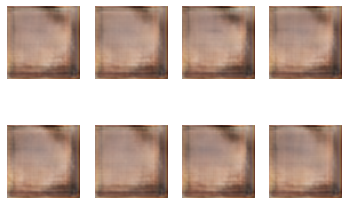

32001 [D loss: 1.163665, acc.: 84.38%, op_acc: 63.16%] [G loss: 2.426088]
32002 [D loss: 1.948483, acc.: 32.81%, op_acc: 63.83%] [G loss: 2.231411]
32003 [D loss: 1.303135, acc.: 67.19%, op_acc: 64.88%] [G loss: 2.284115]
32004 [D loss: 1.343154, acc.: 59.38%, op_acc: 65.00%] [G loss: 1.714258]
32005 [D loss: 1.577486, acc.: 46.88%, op_acc: 62.70%] [G loss: 1.446345]
32006 [D loss: 1.295446, acc.: 65.62%, op_acc: 63.83%] [G loss: 1.642671]
32007 [D loss: 1.286773, acc.: 62.50%, op_acc: 64.37%] [G loss: 1.390449]
32008 [D loss: 1.241740, acc.: 75.00%, op_acc: 65.04%] [G loss: 1.105725]
32009 [D loss: 1.139365, acc.: 84.38%, op_acc: 65.43%] [G loss: 1.097759]
32010 [D loss: 1.019894, acc.: 85.94%, op_acc: 67.11%] [G loss: 1.074201]
32011 [D loss: 1.053973, acc.: 82.81%, op_acc: 64.45%] [G loss: 1.072080]
32012 [D loss: 0.956142, acc.: 89.06%, op_acc: 66.09%] [G loss: 1.050178]
32013 [D loss: 0.995433, acc.: 85.94%, op_acc: 66.09%] [G loss: 1.097775]
32014 [D loss: 0.944210, acc.: 89.06%,

32112 [D loss: 0.599693, acc.: 100.00%, op_acc: 68.95%] [G loss: 1.026682]
32113 [D loss: 0.635090, acc.: 100.00%, op_acc: 65.74%] [G loss: 1.023353]
32114 [D loss: 0.704494, acc.: 95.31%, op_acc: 66.95%] [G loss: 0.917763]
32115 [D loss: 0.647304, acc.: 100.00%, op_acc: 67.11%] [G loss: 0.963580]
32116 [D loss: 0.613283, acc.: 98.44%, op_acc: 67.34%] [G loss: 0.974182]
32117 [D loss: 0.625612, acc.: 98.44%, op_acc: 66.72%] [G loss: 0.916264]
32118 [D loss: 0.575703, acc.: 100.00%, op_acc: 68.44%] [G loss: 0.980502]
32119 [D loss: 0.626833, acc.: 96.88%, op_acc: 68.12%] [G loss: 0.900535]
32120 [D loss: 0.620929, acc.: 96.88%, op_acc: 68.44%] [G loss: 0.927813]
32121 [D loss: 0.586109, acc.: 100.00%, op_acc: 68.05%] [G loss: 0.995463]
32122 [D loss: 0.656749, acc.: 96.88%, op_acc: 66.56%] [G loss: 0.898951]
32123 [D loss: 0.697150, acc.: 96.88%, op_acc: 66.84%] [G loss: 0.908005]
32124 [D loss: 0.569214, acc.: 100.00%, op_acc: 67.58%] [G loss: 0.877221]
32125 [D loss: 0.600442, acc.: 9

32224 [D loss: 0.656580, acc.: 98.44%, op_acc: 67.54%] [G loss: 1.054694]
32225 [D loss: 0.628217, acc.: 98.44%, op_acc: 66.95%] [G loss: 1.033180]
32226 [D loss: 0.733798, acc.: 93.75%, op_acc: 66.64%] [G loss: 1.043318]
32227 [D loss: 0.778340, acc.: 92.19%, op_acc: 66.48%] [G loss: 0.980378]
32228 [D loss: 0.597113, acc.: 100.00%, op_acc: 67.42%] [G loss: 1.080253]
32229 [D loss: 0.626288, acc.: 100.00%, op_acc: 67.38%] [G loss: 1.055802]
32230 [D loss: 0.751939, acc.: 95.31%, op_acc: 68.59%] [G loss: 1.027634]
32231 [D loss: 0.692181, acc.: 96.88%, op_acc: 67.62%] [G loss: 1.027854]
32232 [D loss: 0.638378, acc.: 98.44%, op_acc: 67.38%] [G loss: 1.034637]
32233 [D loss: 0.690162, acc.: 95.31%, op_acc: 68.20%] [G loss: 1.019429]
32234 [D loss: 0.602678, acc.: 100.00%, op_acc: 67.62%] [G loss: 1.062440]
32235 [D loss: 0.573020, acc.: 100.00%, op_acc: 66.91%] [G loss: 1.042650]
32236 [D loss: 0.603408, acc.: 100.00%, op_acc: 66.37%] [G loss: 1.078240]
32237 [D loss: 0.653758, acc.: 98

32336 [D loss: 0.856004, acc.: 90.62%, op_acc: 66.45%] [G loss: 1.756825]
32337 [D loss: 0.982615, acc.: 90.62%, op_acc: 64.69%] [G loss: 2.201592]
32338 [D loss: 0.936098, acc.: 85.94%, op_acc: 68.44%] [G loss: 2.265336]
32339 [D loss: 0.988305, acc.: 89.06%, op_acc: 64.73%] [G loss: 3.624674]
32340 [D loss: 1.105413, acc.: 79.69%, op_acc: 67.15%] [G loss: 4.937606]
32341 [D loss: 1.124256, acc.: 87.50%, op_acc: 63.63%] [G loss: 3.845755]
32342 [D loss: 1.352595, acc.: 78.12%, op_acc: 62.81%] [G loss: 4.842837]
32343 [D loss: 0.860764, acc.: 95.31%, op_acc: 66.02%] [G loss: 4.022069]
32344 [D loss: 0.991251, acc.: 89.06%, op_acc: 65.47%] [G loss: 1.967629]
32345 [D loss: 1.011573, acc.: 75.00%, op_acc: 67.19%] [G loss: 1.864258]
32346 [D loss: 1.123495, acc.: 75.00%, op_acc: 65.59%] [G loss: 1.783276]
32347 [D loss: 0.952884, acc.: 82.81%, op_acc: 67.38%] [G loss: 1.892377]
32348 [D loss: 1.061981, acc.: 79.69%, op_acc: 64.92%] [G loss: 1.549674]
32349 [D loss: 1.120152, acc.: 78.12%,

32448 [D loss: 0.636558, acc.: 96.88%, op_acc: 67.66%] [G loss: 1.041692]
32449 [D loss: 0.601955, acc.: 98.44%, op_acc: 66.60%] [G loss: 1.075426]
32450 [D loss: 0.762925, acc.: 93.75%, op_acc: 67.66%] [G loss: 0.979579]
32451 [D loss: 0.656926, acc.: 96.88%, op_acc: 65.20%] [G loss: 1.040368]
32452 [D loss: 0.629140, acc.: 98.44%, op_acc: 66.60%] [G loss: 1.074776]
32453 [D loss: 0.585790, acc.: 100.00%, op_acc: 69.49%] [G loss: 1.040341]
32454 [D loss: 0.640526, acc.: 98.44%, op_acc: 66.68%] [G loss: 1.008809]
32455 [D loss: 0.611857, acc.: 100.00%, op_acc: 68.05%] [G loss: 1.011245]
32456 [D loss: 0.600499, acc.: 100.00%, op_acc: 67.50%] [G loss: 0.992388]
32457 [D loss: 0.675869, acc.: 98.44%, op_acc: 66.29%] [G loss: 0.968724]
32458 [D loss: 0.674892, acc.: 96.88%, op_acc: 66.21%] [G loss: 0.998964]
32459 [D loss: 0.617005, acc.: 98.44%, op_acc: 67.07%] [G loss: 1.111201]
32460 [D loss: 0.707715, acc.: 95.31%, op_acc: 66.72%] [G loss: 1.003210]
32461 [D loss: 0.599467, acc.: 98.4

32560 [D loss: 0.580575, acc.: 100.00%, op_acc: 66.91%] [G loss: 1.052304]
32561 [D loss: 0.566357, acc.: 100.00%, op_acc: 68.59%] [G loss: 0.971549]
32562 [D loss: 0.584336, acc.: 98.44%, op_acc: 67.23%] [G loss: 0.987711]
32563 [D loss: 0.566785, acc.: 100.00%, op_acc: 67.42%] [G loss: 0.982604]
32564 [D loss: 0.589931, acc.: 100.00%, op_acc: 67.34%] [G loss: 0.980481]
32565 [D loss: 0.588676, acc.: 100.00%, op_acc: 68.59%] [G loss: 0.997108]
32566 [D loss: 0.568507, acc.: 100.00%, op_acc: 67.03%] [G loss: 1.021490]
32567 [D loss: 0.576468, acc.: 100.00%, op_acc: 66.91%] [G loss: 0.999733]
32568 [D loss: 0.626285, acc.: 98.44%, op_acc: 65.70%] [G loss: 1.082232]
32569 [D loss: 0.582883, acc.: 100.00%, op_acc: 68.28%] [G loss: 1.001260]
32570 [D loss: 0.570254, acc.: 100.00%, op_acc: 65.35%] [G loss: 0.950614]
32571 [D loss: 0.588128, acc.: 100.00%, op_acc: 67.23%] [G loss: 1.031133]
32572 [D loss: 0.655818, acc.: 96.88%, op_acc: 65.59%] [G loss: 0.989248]
32573 [D loss: 0.577693, acc

32672 [D loss: 0.654718, acc.: 96.88%, op_acc: 69.22%] [G loss: 1.004679]
32673 [D loss: 0.799070, acc.: 95.31%, op_acc: 66.99%] [G loss: 0.974259]
32674 [D loss: 0.830476, acc.: 95.31%, op_acc: 66.37%] [G loss: 0.989067]
32675 [D loss: 0.673297, acc.: 96.88%, op_acc: 68.63%] [G loss: 1.020350]
32676 [D loss: 1.012887, acc.: 85.94%, op_acc: 65.66%] [G loss: 0.982508]
32677 [D loss: 0.802806, acc.: 96.88%, op_acc: 65.51%] [G loss: 1.029995]
32678 [D loss: 0.811519, acc.: 95.31%, op_acc: 67.54%] [G loss: 1.001818]
32679 [D loss: 0.729864, acc.: 96.88%, op_acc: 67.34%] [G loss: 1.008500]
32680 [D loss: 1.125763, acc.: 75.00%, op_acc: 66.76%] [G loss: 1.024447]
32681 [D loss: 0.908896, acc.: 92.19%, op_acc: 65.62%] [G loss: 1.008627]
32682 [D loss: 0.767316, acc.: 93.75%, op_acc: 67.42%] [G loss: 1.053884]
32683 [D loss: 0.769780, acc.: 95.31%, op_acc: 66.80%] [G loss: 1.059111]
32684 [D loss: 0.610165, acc.: 100.00%, op_acc: 66.60%] [G loss: 1.041125]
32685 [D loss: 1.126795, acc.: 78.12%

32784 [D loss: 0.634227, acc.: 100.00%, op_acc: 65.82%] [G loss: 0.953120]
32785 [D loss: 0.607405, acc.: 100.00%, op_acc: 66.76%] [G loss: 0.948070]
32786 [D loss: 0.591909, acc.: 100.00%, op_acc: 66.60%] [G loss: 0.974987]
32787 [D loss: 0.651898, acc.: 98.44%, op_acc: 66.13%] [G loss: 1.017574]
32788 [D loss: 0.585570, acc.: 100.00%, op_acc: 67.42%] [G loss: 0.971215]
32789 [D loss: 0.575502, acc.: 98.44%, op_acc: 66.68%] [G loss: 0.992262]
32790 [D loss: 0.584737, acc.: 100.00%, op_acc: 66.25%] [G loss: 1.024892]
32791 [D loss: 0.611355, acc.: 98.44%, op_acc: 67.30%] [G loss: 0.980273]
32792 [D loss: 0.590447, acc.: 100.00%, op_acc: 65.31%] [G loss: 0.955596]
32793 [D loss: 0.583413, acc.: 100.00%, op_acc: 65.55%] [G loss: 0.959877]
32794 [D loss: 0.614189, acc.: 98.44%, op_acc: 66.29%] [G loss: 0.967191]
32795 [D loss: 0.581441, acc.: 100.00%, op_acc: 67.58%] [G loss: 0.997406]
32796 [D loss: 0.627180, acc.: 98.44%, op_acc: 65.39%] [G loss: 1.002653]
32797 [D loss: 0.553659, acc.:

32895 [D loss: 0.587681, acc.: 100.00%, op_acc: 67.66%] [G loss: 1.133076]
32896 [D loss: 0.633669, acc.: 98.44%, op_acc: 68.40%] [G loss: 1.094274]
32897 [D loss: 0.633130, acc.: 98.44%, op_acc: 66.99%] [G loss: 1.076350]
32898 [D loss: 0.724069, acc.: 95.31%, op_acc: 66.41%] [G loss: 1.067251]
32899 [D loss: 0.627226, acc.: 96.88%, op_acc: 69.38%] [G loss: 1.209693]
32900 [D loss: 0.795941, acc.: 92.19%, op_acc: 65.90%] [G loss: 1.290435]
32901 [D loss: 0.669406, acc.: 96.88%, op_acc: 64.57%] [G loss: 1.244217]
32902 [D loss: 0.785326, acc.: 92.19%, op_acc: 66.95%] [G loss: 1.181144]
32903 [D loss: 0.888705, acc.: 89.06%, op_acc: 68.28%] [G loss: 1.200367]
32904 [D loss: 0.755190, acc.: 93.75%, op_acc: 68.91%] [G loss: 1.135204]
32905 [D loss: 1.054278, acc.: 82.81%, op_acc: 65.00%] [G loss: 1.266064]
32906 [D loss: 0.799085, acc.: 93.75%, op_acc: 66.13%] [G loss: 1.267595]
32907 [D loss: 0.875860, acc.: 90.62%, op_acc: 66.99%] [G loss: 1.175202]
32908 [D loss: 0.785445, acc.: 93.75%

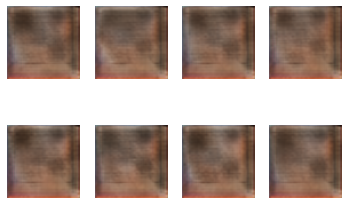

33001 [D loss: 0.843911, acc.: 95.31%, op_acc: 66.48%] [G loss: 0.948736]
33002 [D loss: 0.781032, acc.: 95.31%, op_acc: 65.78%] [G loss: 0.989114]
33003 [D loss: 0.803226, acc.: 92.19%, op_acc: 66.21%] [G loss: 0.971172]
33004 [D loss: 0.806192, acc.: 93.75%, op_acc: 65.27%] [G loss: 1.011717]
33005 [D loss: 0.807818, acc.: 93.75%, op_acc: 67.27%] [G loss: 0.956969]
33006 [D loss: 0.810998, acc.: 92.19%, op_acc: 65.86%] [G loss: 0.962975]
33007 [D loss: 0.812194, acc.: 95.31%, op_acc: 67.38%] [G loss: 0.960894]
33008 [D loss: 0.748359, acc.: 95.31%, op_acc: 67.27%] [G loss: 0.960058]
33009 [D loss: 0.766489, acc.: 93.75%, op_acc: 68.67%] [G loss: 0.934091]
33010 [D loss: 0.739416, acc.: 95.31%, op_acc: 67.85%] [G loss: 0.958214]
33011 [D loss: 0.698524, acc.: 98.44%, op_acc: 69.53%] [G loss: 0.910276]
33012 [D loss: 0.730513, acc.: 93.75%, op_acc: 67.50%] [G loss: 0.940740]
33013 [D loss: 0.724460, acc.: 95.31%, op_acc: 64.80%] [G loss: 0.971464]
33014 [D loss: 0.734010, acc.: 98.44%,

33113 [D loss: 1.497156, acc.: 50.00%, op_acc: 64.61%] [G loss: 1.446991]
33114 [D loss: 1.354213, acc.: 54.69%, op_acc: 65.51%] [G loss: 1.432983]
33115 [D loss: 1.290055, acc.: 73.44%, op_acc: 66.45%] [G loss: 1.503711]
33116 [D loss: 1.425754, acc.: 54.69%, op_acc: 64.84%] [G loss: 1.395378]
33117 [D loss: 1.127810, acc.: 81.25%, op_acc: 66.45%] [G loss: 1.661109]
33118 [D loss: 1.171442, acc.: 73.44%, op_acc: 67.58%] [G loss: 1.586197]
33119 [D loss: 1.409899, acc.: 59.38%, op_acc: 65.86%] [G loss: 1.277046]
33120 [D loss: 1.053815, acc.: 84.38%, op_acc: 66.21%] [G loss: 1.365418]
33121 [D loss: 1.117647, acc.: 81.25%, op_acc: 66.56%] [G loss: 1.353960]
33122 [D loss: 1.006513, acc.: 90.62%, op_acc: 65.90%] [G loss: 1.380885]
33123 [D loss: 0.974598, acc.: 87.50%, op_acc: 65.66%] [G loss: 1.455557]
33124 [D loss: 1.012661, acc.: 92.19%, op_acc: 67.15%] [G loss: 1.441795]
33125 [D loss: 0.999221, acc.: 90.62%, op_acc: 67.11%] [G loss: 1.392209]
33126 [D loss: 0.912931, acc.: 93.75%,

33225 [D loss: 1.082382, acc.: 81.25%, op_acc: 66.88%] [G loss: 3.363241]
33226 [D loss: 1.302361, acc.: 76.56%, op_acc: 64.02%] [G loss: 2.242120]
33227 [D loss: 1.244446, acc.: 64.06%, op_acc: 66.72%] [G loss: 2.047974]
33228 [D loss: 1.241829, acc.: 73.44%, op_acc: 67.27%] [G loss: 2.053479]
33229 [D loss: 1.400473, acc.: 60.94%, op_acc: 64.30%] [G loss: 1.664569]
33230 [D loss: 1.439890, acc.: 64.06%, op_acc: 65.66%] [G loss: 1.522434]
33231 [D loss: 1.740646, acc.: 46.88%, op_acc: 64.61%] [G loss: 1.443959]
33232 [D loss: 1.224041, acc.: 75.00%, op_acc: 65.78%] [G loss: 1.544845]
33233 [D loss: 1.270344, acc.: 75.00%, op_acc: 65.04%] [G loss: 1.459315]
33234 [D loss: 1.614183, acc.: 57.81%, op_acc: 64.10%] [G loss: 1.307847]
33235 [D loss: 1.419973, acc.: 54.69%, op_acc: 64.41%] [G loss: 1.392089]
33236 [D loss: 1.179432, acc.: 76.56%, op_acc: 65.51%] [G loss: 1.370894]
33237 [D loss: 1.250683, acc.: 68.75%, op_acc: 66.48%] [G loss: 1.437393]
33238 [D loss: 1.266947, acc.: 73.44%,

33337 [D loss: 0.824362, acc.: 95.31%, op_acc: 64.61%] [G loss: 3.675861]
33338 [D loss: 1.188652, acc.: 65.62%, op_acc: 66.91%] [G loss: 2.856458]
33339 [D loss: 1.071504, acc.: 84.38%, op_acc: 66.56%] [G loss: 2.820310]
33340 [D loss: 0.984694, acc.: 84.38%, op_acc: 67.46%] [G loss: 2.197883]
33341 [D loss: 0.895356, acc.: 90.62%, op_acc: 66.05%] [G loss: 1.634128]
33342 [D loss: 1.054590, acc.: 84.38%, op_acc: 65.43%] [G loss: 1.557478]
33343 [D loss: 1.173956, acc.: 81.25%, op_acc: 64.65%] [G loss: 1.344097]
33344 [D loss: 1.008718, acc.: 85.94%, op_acc: 67.19%] [G loss: 1.344859]
33345 [D loss: 1.279842, acc.: 68.75%, op_acc: 64.30%] [G loss: 1.296567]
33346 [D loss: 1.073421, acc.: 85.94%, op_acc: 66.60%] [G loss: 1.429504]
33347 [D loss: 1.154890, acc.: 75.00%, op_acc: 68.63%] [G loss: 1.376058]
33348 [D loss: 1.050496, acc.: 76.56%, op_acc: 67.19%] [G loss: 1.576151]
33349 [D loss: 1.319017, acc.: 71.88%, op_acc: 65.20%] [G loss: 1.466839]
33350 [D loss: 1.070700, acc.: 87.50%,

33448 [D loss: 0.860057, acc.: 92.19%, op_acc: 66.84%] [G loss: 1.288255]
33449 [D loss: 1.473628, acc.: 59.38%, op_acc: 66.37%] [G loss: 1.495849]
33450 [D loss: 1.201480, acc.: 70.31%, op_acc: 66.21%] [G loss: 1.848900]
33451 [D loss: 1.472261, acc.: 48.44%, op_acc: 65.27%] [G loss: 2.297281]
33452 [D loss: 1.512744, acc.: 67.19%, op_acc: 62.07%] [G loss: 1.640894]
33453 [D loss: 1.643247, acc.: 42.19%, op_acc: 63.52%] [G loss: 2.008929]
33454 [D loss: 1.160496, acc.: 76.56%, op_acc: 67.77%] [G loss: 1.595843]
33455 [D loss: 1.506155, acc.: 57.81%, op_acc: 62.77%] [G loss: 1.345168]
33456 [D loss: 1.248570, acc.: 79.69%, op_acc: 64.37%] [G loss: 1.212755]
33457 [D loss: 1.376495, acc.: 68.75%, op_acc: 65.78%] [G loss: 0.988384]
33458 [D loss: 1.579872, acc.: 68.75%, op_acc: 61.72%] [G loss: 1.029848]
33459 [D loss: 1.088229, acc.: 84.38%, op_acc: 64.69%] [G loss: 1.060639]
33460 [D loss: 1.253843, acc.: 82.81%, op_acc: 63.13%] [G loss: 1.006083]
33461 [D loss: 1.214499, acc.: 82.81%,

33560 [D loss: 1.569177, acc.: 54.69%, op_acc: 65.94%] [G loss: 1.912604]
33561 [D loss: 1.249832, acc.: 73.44%, op_acc: 62.34%] [G loss: 1.688735]
33562 [D loss: 1.121905, acc.: 79.69%, op_acc: 65.43%] [G loss: 1.753238]
33563 [D loss: 1.013850, acc.: 82.81%, op_acc: 65.59%] [G loss: 1.837590]
33564 [D loss: 1.099906, acc.: 84.38%, op_acc: 66.29%] [G loss: 1.657788]
33565 [D loss: 0.985587, acc.: 87.50%, op_acc: 66.68%] [G loss: 1.714471]
33566 [D loss: 0.935458, acc.: 89.06%, op_acc: 65.94%] [G loss: 1.802001]
33567 [D loss: 1.071216, acc.: 89.06%, op_acc: 65.66%] [G loss: 1.841730]
33568 [D loss: 1.052145, acc.: 89.06%, op_acc: 64.26%] [G loss: 1.544572]
33569 [D loss: 1.127399, acc.: 78.12%, op_acc: 66.33%] [G loss: 1.485885]
33570 [D loss: 0.902829, acc.: 89.06%, op_acc: 67.62%] [G loss: 1.670077]
33571 [D loss: 0.862729, acc.: 93.75%, op_acc: 65.59%] [G loss: 1.809199]
33572 [D loss: 0.839070, acc.: 90.62%, op_acc: 65.55%] [G loss: 1.847380]
33573 [D loss: 0.926507, acc.: 89.06%,

33672 [D loss: 0.758120, acc.: 96.88%, op_acc: 67.03%] [G loss: 2.364390]
33673 [D loss: 0.794613, acc.: 93.75%, op_acc: 66.09%] [G loss: 2.425725]
33674 [D loss: 0.934226, acc.: 90.62%, op_acc: 67.15%] [G loss: 2.143556]
33675 [D loss: 0.825249, acc.: 98.44%, op_acc: 65.98%] [G loss: 2.059593]
33676 [D loss: 1.193069, acc.: 67.19%, op_acc: 64.49%] [G loss: 1.657001]
33677 [D loss: 1.462466, acc.: 50.00%, op_acc: 65.16%] [G loss: 1.839484]
33678 [D loss: 1.627559, acc.: 50.00%, op_acc: 61.91%] [G loss: 1.868009]
33679 [D loss: 1.738101, acc.: 51.56%, op_acc: 63.36%] [G loss: 2.452578]
33680 [D loss: 1.684670, acc.: 60.94%, op_acc: 58.44%] [G loss: 2.350824]
33681 [D loss: 2.061473, acc.: 31.25%, op_acc: 58.95%] [G loss: 2.101342]
33682 [D loss: 1.644775, acc.: 45.31%, op_acc: 64.38%] [G loss: 2.612189]
33683 [D loss: 1.548608, acc.: 51.56%, op_acc: 63.40%] [G loss: 2.154251]
33684 [D loss: 1.550374, acc.: 50.00%, op_acc: 63.24%] [G loss: 2.102820]
33685 [D loss: 1.497105, acc.: 48.44%,

33784 [D loss: 0.883160, acc.: 90.62%, op_acc: 67.03%] [G loss: 1.689958]
33785 [D loss: 1.022709, acc.: 82.81%, op_acc: 67.23%] [G loss: 1.460100]
33786 [D loss: 1.022869, acc.: 76.56%, op_acc: 67.73%] [G loss: 2.147816]
33787 [D loss: 0.980419, acc.: 90.62%, op_acc: 65.23%] [G loss: 2.012418]
33788 [D loss: 1.199399, acc.: 81.25%, op_acc: 65.59%] [G loss: 1.886635]
33789 [D loss: 1.228118, acc.: 64.06%, op_acc: 66.72%] [G loss: 2.134861]
33790 [D loss: 1.180027, acc.: 84.38%, op_acc: 64.84%] [G loss: 1.918811]
33791 [D loss: 1.609653, acc.: 53.12%, op_acc: 62.81%] [G loss: 2.076046]
33792 [D loss: 1.712075, acc.: 48.44%, op_acc: 63.79%] [G loss: 1.969488]
33793 [D loss: 1.272039, acc.: 68.75%, op_acc: 66.68%] [G loss: 1.541486]
33794 [D loss: 1.315029, acc.: 60.94%, op_acc: 64.77%] [G loss: 1.724209]
33795 [D loss: 1.289755, acc.: 64.06%, op_acc: 66.84%] [G loss: 1.598108]
33796 [D loss: 1.391248, acc.: 71.88%, op_acc: 63.28%] [G loss: 1.247709]
33797 [D loss: 1.082994, acc.: 82.81%,

33896 [D loss: 1.034666, acc.: 81.25%, op_acc: 66.13%] [G loss: 1.769820]
33897 [D loss: 1.397814, acc.: 67.19%, op_acc: 63.09%] [G loss: 1.553746]
33898 [D loss: 1.119748, acc.: 75.00%, op_acc: 65.23%] [G loss: 1.783987]
33899 [D loss: 1.205153, acc.: 73.44%, op_acc: 64.84%] [G loss: 1.338323]
33900 [D loss: 1.632752, acc.: 56.25%, op_acc: 62.07%] [G loss: 1.470393]
33901 [D loss: 1.108424, acc.: 79.69%, op_acc: 65.20%] [G loss: 1.475814]
33902 [D loss: 1.190012, acc.: 79.69%, op_acc: 63.63%] [G loss: 1.271644]
33903 [D loss: 1.525476, acc.: 51.56%, op_acc: 66.48%] [G loss: 1.087005]
33904 [D loss: 1.276427, acc.: 64.06%, op_acc: 67.77%] [G loss: 1.189028]
33905 [D loss: 1.232599, acc.: 70.31%, op_acc: 66.41%] [G loss: 1.334480]
33906 [D loss: 1.219776, acc.: 68.75%, op_acc: 67.58%] [G loss: 1.241055]
33907 [D loss: 1.200838, acc.: 76.56%, op_acc: 64.41%] [G loss: 1.248890]
33908 [D loss: 1.287477, acc.: 68.75%, op_acc: 63.55%] [G loss: 1.369518]
33909 [D loss: 1.253409, acc.: 65.62%,

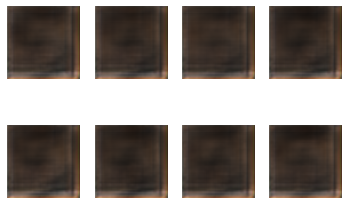

34001 [D loss: 1.007296, acc.: 78.12%, op_acc: 67.19%] [G loss: 1.204898]
34002 [D loss: 0.928781, acc.: 87.50%, op_acc: 66.64%] [G loss: 1.184476]
34003 [D loss: 1.068236, acc.: 87.50%, op_acc: 66.37%] [G loss: 1.149713]
34004 [D loss: 1.082954, acc.: 85.94%, op_acc: 65.35%] [G loss: 0.907705]
34005 [D loss: 0.849485, acc.: 90.62%, op_acc: 65.98%] [G loss: 0.933516]
34006 [D loss: 0.837295, acc.: 90.62%, op_acc: 68.44%] [G loss: 1.064392]
34007 [D loss: 0.910070, acc.: 85.94%, op_acc: 66.64%] [G loss: 0.972132]
34008 [D loss: 0.971275, acc.: 82.81%, op_acc: 66.87%] [G loss: 0.930171]
34009 [D loss: 0.789009, acc.: 93.75%, op_acc: 66.48%] [G loss: 0.960373]
34010 [D loss: 0.753712, acc.: 90.62%, op_acc: 66.80%] [G loss: 0.899929]
34011 [D loss: 0.741518, acc.: 96.88%, op_acc: 67.85%] [G loss: 0.891420]
34012 [D loss: 0.754826, acc.: 96.88%, op_acc: 68.71%] [G loss: 0.871886]
34013 [D loss: 0.693426, acc.: 95.31%, op_acc: 68.12%] [G loss: 0.852267]
34014 [D loss: 0.694146, acc.: 95.31%,

34111 [D loss: 0.625163, acc.: 98.44%, op_acc: 68.44%] [G loss: 1.446490]
34112 [D loss: 0.713385, acc.: 96.88%, op_acc: 66.91%] [G loss: 1.979000]
34113 [D loss: 0.791646, acc.: 93.75%, op_acc: 65.66%] [G loss: 1.215620]
34114 [D loss: 0.693684, acc.: 96.88%, op_acc: 67.58%] [G loss: 1.794888]
34115 [D loss: 0.923811, acc.: 89.06%, op_acc: 65.55%] [G loss: 3.376041]
34116 [D loss: 0.773876, acc.: 87.50%, op_acc: 66.02%] [G loss: 4.523276]
34117 [D loss: 0.767752, acc.: 95.31%, op_acc: 66.33%] [G loss: 2.982574]
34118 [D loss: 0.734471, acc.: 95.31%, op_acc: 67.15%] [G loss: 2.392378]
34119 [D loss: 0.695503, acc.: 95.31%, op_acc: 67.27%] [G loss: 3.783286]
34120 [D loss: 0.818528, acc.: 95.31%, op_acc: 66.80%] [G loss: 3.133358]
34121 [D loss: 0.637735, acc.: 100.00%, op_acc: 67.81%] [G loss: 2.112463]
34122 [D loss: 0.774099, acc.: 93.75%, op_acc: 65.90%] [G loss: 2.580791]
34123 [D loss: 0.922740, acc.: 90.62%, op_acc: 67.23%] [G loss: 1.823656]
34124 [D loss: 1.146460, acc.: 75.00%

34222 [D loss: 0.848492, acc.: 90.62%, op_acc: 66.84%] [G loss: 1.911049]
34223 [D loss: 0.973485, acc.: 85.94%, op_acc: 66.33%] [G loss: 2.041147]
34224 [D loss: 0.913817, acc.: 85.94%, op_acc: 66.72%] [G loss: 2.233697]
34225 [D loss: 1.260477, acc.: 73.44%, op_acc: 63.01%] [G loss: 1.851895]
34226 [D loss: 2.069577, acc.: 39.06%, op_acc: 63.83%] [G loss: 1.522813]
34227 [D loss: 1.639487, acc.: 35.94%, op_acc: 65.00%] [G loss: 1.637314]
34228 [D loss: 1.597572, acc.: 53.12%, op_acc: 61.37%] [G loss: 1.809303]
34229 [D loss: 1.521749, acc.: 46.88%, op_acc: 65.43%] [G loss: 1.591368]
34230 [D loss: 1.455264, acc.: 51.56%, op_acc: 64.53%] [G loss: 1.734970]
34231 [D loss: 1.631125, acc.: 40.62%, op_acc: 64.96%] [G loss: 1.480297]
34232 [D loss: 1.477471, acc.: 53.12%, op_acc: 65.86%] [G loss: 1.686596]
34233 [D loss: 1.570657, acc.: 37.50%, op_acc: 66.37%] [G loss: 1.824035]
34234 [D loss: 1.355672, acc.: 53.12%, op_acc: 66.29%] [G loss: 1.907205]
34235 [D loss: 1.254594, acc.: 65.62%,

34334 [D loss: 1.248553, acc.: 68.75%, op_acc: 65.70%] [G loss: 1.437189]
34335 [D loss: 1.333708, acc.: 53.12%, op_acc: 65.82%] [G loss: 1.394273]
34336 [D loss: 1.273476, acc.: 67.19%, op_acc: 67.03%] [G loss: 1.354959]
34337 [D loss: 1.183408, acc.: 82.81%, op_acc: 67.30%] [G loss: 1.391793]
34338 [D loss: 1.134916, acc.: 82.81%, op_acc: 67.66%] [G loss: 1.397157]
34339 [D loss: 1.208330, acc.: 76.56%, op_acc: 68.20%] [G loss: 1.370968]
34340 [D loss: 1.246735, acc.: 71.88%, op_acc: 64.30%] [G loss: 1.441865]
34341 [D loss: 1.280264, acc.: 70.31%, op_acc: 64.30%] [G loss: 1.380748]
34342 [D loss: 1.213121, acc.: 62.50%, op_acc: 66.45%] [G loss: 1.352240]
34343 [D loss: 1.289213, acc.: 51.56%, op_acc: 65.82%] [G loss: 1.373660]
34344 [D loss: 1.194701, acc.: 75.00%, op_acc: 67.23%] [G loss: 1.331175]
34345 [D loss: 1.181515, acc.: 67.19%, op_acc: 66.21%] [G loss: 1.364160]
34346 [D loss: 1.393348, acc.: 43.75%, op_acc: 67.93%] [G loss: 1.290564]
34347 [D loss: 1.369871, acc.: 35.94%,

34446 [D loss: 1.490918, acc.: 43.75%, op_acc: 66.37%] [G loss: 1.394196]
34447 [D loss: 1.377162, acc.: 46.88%, op_acc: 66.37%] [G loss: 1.386916]
34448 [D loss: 1.411561, acc.: 59.38%, op_acc: 66.05%] [G loss: 1.369201]
34449 [D loss: 1.474031, acc.: 42.19%, op_acc: 65.08%] [G loss: 1.276490]
34450 [D loss: 1.390795, acc.: 59.38%, op_acc: 66.17%] [G loss: 1.323843]
34451 [D loss: 1.495249, acc.: 34.38%, op_acc: 66.72%] [G loss: 1.282360]
34452 [D loss: 1.305712, acc.: 57.81%, op_acc: 66.95%] [G loss: 1.280115]
34453 [D loss: 1.385846, acc.: 46.88%, op_acc: 66.05%] [G loss: 1.322281]
34454 [D loss: 1.343079, acc.: 59.38%, op_acc: 65.70%] [G loss: 1.297125]
34455 [D loss: 1.363364, acc.: 45.31%, op_acc: 68.16%] [G loss: 1.184627]
34456 [D loss: 1.318780, acc.: 60.94%, op_acc: 66.84%] [G loss: 1.204926]
34457 [D loss: 1.323000, acc.: 57.81%, op_acc: 65.74%] [G loss: 1.199672]
34458 [D loss: 1.255937, acc.: 71.88%, op_acc: 67.62%] [G loss: 1.198558]
34459 [D loss: 1.319987, acc.: 59.38%,

34558 [D loss: 0.604201, acc.: 100.00%, op_acc: 68.55%] [G loss: 0.906689]
34559 [D loss: 0.595777, acc.: 100.00%, op_acc: 69.45%] [G loss: 0.958826]
34560 [D loss: 0.575042, acc.: 100.00%, op_acc: 68.87%] [G loss: 0.934515]
34561 [D loss: 0.662354, acc.: 96.88%, op_acc: 66.45%] [G loss: 0.965268]
34562 [D loss: 0.607105, acc.: 100.00%, op_acc: 67.46%] [G loss: 0.941273]
34563 [D loss: 0.616237, acc.: 98.44%, op_acc: 67.81%] [G loss: 0.936964]
34564 [D loss: 0.604332, acc.: 100.00%, op_acc: 67.77%] [G loss: 0.949374]
34565 [D loss: 0.599288, acc.: 100.00%, op_acc: 68.59%] [G loss: 0.942222]
34566 [D loss: 0.637056, acc.: 98.44%, op_acc: 66.84%] [G loss: 0.935785]
34567 [D loss: 0.582783, acc.: 100.00%, op_acc: 68.83%] [G loss: 0.891844]
34568 [D loss: 0.586730, acc.: 100.00%, op_acc: 69.45%] [G loss: 0.975098]
34569 [D loss: 0.598448, acc.: 100.00%, op_acc: 68.20%] [G loss: 0.918487]
34570 [D loss: 0.626491, acc.: 100.00%, op_acc: 67.11%] [G loss: 0.990687]
34571 [D loss: 0.592354, acc

34670 [D loss: 1.038252, acc.: 84.38%, op_acc: 65.55%] [G loss: 1.162267]
34671 [D loss: 0.812023, acc.: 93.75%, op_acc: 67.34%] [G loss: 1.231570]
34672 [D loss: 0.863496, acc.: 93.75%, op_acc: 66.56%] [G loss: 1.165603]
34673 [D loss: 1.063584, acc.: 82.81%, op_acc: 65.27%] [G loss: 1.148119]
34674 [D loss: 0.985081, acc.: 87.50%, op_acc: 66.33%] [G loss: 1.139140]
34675 [D loss: 0.917213, acc.: 90.62%, op_acc: 68.55%] [G loss: 1.115445]
34676 [D loss: 0.754190, acc.: 93.75%, op_acc: 67.54%] [G loss: 1.251966]
34677 [D loss: 0.803157, acc.: 90.62%, op_acc: 65.20%] [G loss: 1.203167]
34678 [D loss: 0.985612, acc.: 89.06%, op_acc: 64.10%] [G loss: 1.166120]
34679 [D loss: 0.747852, acc.: 96.88%, op_acc: 65.90%] [G loss: 1.069390]
34680 [D loss: 0.701418, acc.: 95.31%, op_acc: 67.66%] [G loss: 1.124540]
34681 [D loss: 0.808810, acc.: 93.75%, op_acc: 66.29%] [G loss: 1.036424]
34682 [D loss: 0.883223, acc.: 89.06%, op_acc: 66.37%] [G loss: 1.193981]
34683 [D loss: 0.881645, acc.: 87.50%,

34782 [D loss: 0.736610, acc.: 95.31%, op_acc: 66.84%] [G loss: 1.049954]
34783 [D loss: 0.639369, acc.: 98.44%, op_acc: 68.36%] [G loss: 1.030904]
34784 [D loss: 0.614711, acc.: 100.00%, op_acc: 67.19%] [G loss: 1.060362]
34785 [D loss: 0.660718, acc.: 98.44%, op_acc: 68.28%] [G loss: 1.039243]
34786 [D loss: 0.666234, acc.: 98.44%, op_acc: 68.12%] [G loss: 1.062675]
34787 [D loss: 0.664981, acc.: 98.44%, op_acc: 66.95%] [G loss: 1.072247]
34788 [D loss: 0.705140, acc.: 98.44%, op_acc: 68.67%] [G loss: 1.079540]
34789 [D loss: 0.630817, acc.: 98.44%, op_acc: 67.46%] [G loss: 1.047317]
34790 [D loss: 0.707095, acc.: 98.44%, op_acc: 67.46%] [G loss: 1.062177]
34791 [D loss: 0.714567, acc.: 95.31%, op_acc: 65.47%] [G loss: 1.046741]
34792 [D loss: 0.705952, acc.: 98.44%, op_acc: 68.05%] [G loss: 1.022055]
34793 [D loss: 0.654824, acc.: 98.44%, op_acc: 68.44%] [G loss: 1.044157]
34794 [D loss: 0.713556, acc.: 96.88%, op_acc: 68.28%] [G loss: 1.025039]
34795 [D loss: 0.670394, acc.: 98.44%

34894 [D loss: 0.585931, acc.: 98.44%, op_acc: 67.50%] [G loss: 1.058493]
34895 [D loss: 0.624233, acc.: 100.00%, op_acc: 66.84%] [G loss: 1.037673]
34896 [D loss: 0.589209, acc.: 100.00%, op_acc: 67.34%] [G loss: 1.092986]
34897 [D loss: 0.607401, acc.: 100.00%, op_acc: 66.60%] [G loss: 1.136291]
34898 [D loss: 0.601168, acc.: 98.44%, op_acc: 66.72%] [G loss: 1.043184]
34899 [D loss: 0.601363, acc.: 100.00%, op_acc: 65.86%] [G loss: 1.026570]
34900 [D loss: 0.590395, acc.: 98.44%, op_acc: 69.53%] [G loss: 1.093739]
34901 [D loss: 0.563801, acc.: 100.00%, op_acc: 67.38%] [G loss: 1.005922]
34902 [D loss: 0.598727, acc.: 100.00%, op_acc: 66.80%] [G loss: 1.070349]
34903 [D loss: 0.633873, acc.: 96.88%, op_acc: 65.70%] [G loss: 1.017024]
34904 [D loss: 0.566506, acc.: 100.00%, op_acc: 67.30%] [G loss: 1.052338]
34905 [D loss: 0.620006, acc.: 98.44%, op_acc: 67.50%] [G loss: 1.062727]
34906 [D loss: 0.560381, acc.: 100.00%, op_acc: 67.66%] [G loss: 1.045863]
34907 [D loss: 0.568069, acc.:

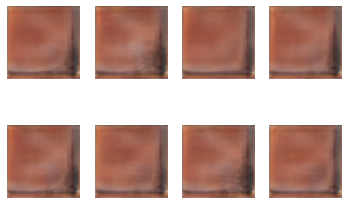

35001 [D loss: 0.790442, acc.: 93.75%, op_acc: 67.89%] [G loss: 1.020442]
35002 [D loss: 0.787488, acc.: 93.75%, op_acc: 68.59%] [G loss: 1.027309]
35003 [D loss: 0.950209, acc.: 84.38%, op_acc: 67.81%] [G loss: 1.002161]
35004 [D loss: 0.776644, acc.: 95.31%, op_acc: 67.54%] [G loss: 0.994759]
35005 [D loss: 0.700503, acc.: 95.31%, op_acc: 68.16%] [G loss: 1.038399]
35006 [D loss: 0.936254, acc.: 82.81%, op_acc: 66.33%] [G loss: 1.045509]
35007 [D loss: 0.758643, acc.: 92.19%, op_acc: 67.62%] [G loss: 1.015479]
35008 [D loss: 0.836169, acc.: 95.31%, op_acc: 66.45%] [G loss: 1.033241]
35009 [D loss: 0.787507, acc.: 93.75%, op_acc: 67.58%] [G loss: 1.049844]
35010 [D loss: 0.923367, acc.: 89.06%, op_acc: 67.38%] [G loss: 1.021549]
35011 [D loss: 0.735864, acc.: 98.44%, op_acc: 67.85%] [G loss: 1.015073]
35012 [D loss: 0.769772, acc.: 93.75%, op_acc: 67.46%] [G loss: 1.006702]
35013 [D loss: 0.885816, acc.: 92.19%, op_acc: 65.82%] [G loss: 1.004417]
35014 [D loss: 0.854435, acc.: 93.75%,

35113 [D loss: 0.922226, acc.: 89.06%, op_acc: 66.33%] [G loss: 1.377019]
35114 [D loss: 0.790888, acc.: 93.75%, op_acc: 66.17%] [G loss: 1.293550]
35115 [D loss: 1.070449, acc.: 75.00%, op_acc: 66.37%] [G loss: 1.031350]
35116 [D loss: 0.801740, acc.: 93.75%, op_acc: 65.35%] [G loss: 1.216703]
35117 [D loss: 0.882969, acc.: 89.06%, op_acc: 66.84%] [G loss: 1.014683]
35118 [D loss: 0.874345, acc.: 85.94%, op_acc: 66.87%] [G loss: 1.115905]
35119 [D loss: 0.936928, acc.: 87.50%, op_acc: 64.37%] [G loss: 1.063801]
35120 [D loss: 0.829824, acc.: 87.50%, op_acc: 67.93%] [G loss: 1.117082]
35121 [D loss: 0.786365, acc.: 93.75%, op_acc: 67.11%] [G loss: 1.203034]
35122 [D loss: 0.752904, acc.: 96.88%, op_acc: 67.77%] [G loss: 1.200828]
35123 [D loss: 0.736940, acc.: 96.88%, op_acc: 68.91%] [G loss: 1.318420]
35124 [D loss: 0.749347, acc.: 95.31%, op_acc: 66.56%] [G loss: 1.311567]
35125 [D loss: 0.785410, acc.: 92.19%, op_acc: 67.07%] [G loss: 1.148556]
35126 [D loss: 0.875945, acc.: 85.94%,

35225 [D loss: 0.957764, acc.: 87.50%, op_acc: 66.91%] [G loss: 1.368892]
35226 [D loss: 0.924912, acc.: 87.50%, op_acc: 66.84%] [G loss: 1.766623]
35227 [D loss: 1.181747, acc.: 75.00%, op_acc: 65.66%] [G loss: 1.571121]
35228 [D loss: 0.996392, acc.: 85.94%, op_acc: 66.37%] [G loss: 1.508424]
35229 [D loss: 1.166913, acc.: 71.88%, op_acc: 66.25%] [G loss: 1.960416]
35230 [D loss: 0.858322, acc.: 89.06%, op_acc: 68.32%] [G loss: 2.051690]
35231 [D loss: 0.938428, acc.: 90.62%, op_acc: 65.59%] [G loss: 2.052322]
35232 [D loss: 0.963460, acc.: 85.94%, op_acc: 67.81%] [G loss: 2.196254]
35233 [D loss: 0.803172, acc.: 95.31%, op_acc: 65.39%] [G loss: 2.650110]
35234 [D loss: 0.843506, acc.: 89.06%, op_acc: 66.41%] [G loss: 2.450274]
35235 [D loss: 0.782734, acc.: 98.44%, op_acc: 66.84%] [G loss: 1.961008]
35236 [D loss: 0.814440, acc.: 95.31%, op_acc: 65.78%] [G loss: 2.033263]
35237 [D loss: 1.032302, acc.: 87.50%, op_acc: 64.18%] [G loss: 2.061167]
35238 [D loss: 1.005953, acc.: 84.38%,

35337 [D loss: 0.836242, acc.: 95.31%, op_acc: 65.51%] [G loss: 1.393757]
35338 [D loss: 0.786225, acc.: 93.75%, op_acc: 65.82%] [G loss: 1.455393]
35339 [D loss: 0.784576, acc.: 93.75%, op_acc: 66.60%] [G loss: 1.421271]
35340 [D loss: 0.834083, acc.: 93.75%, op_acc: 66.25%] [G loss: 1.313183]
35341 [D loss: 0.932704, acc.: 90.62%, op_acc: 66.56%] [G loss: 1.082275]
35342 [D loss: 0.924270, acc.: 90.62%, op_acc: 66.52%] [G loss: 1.068361]
35343 [D loss: 0.992290, acc.: 87.50%, op_acc: 65.78%] [G loss: 1.136167]
35344 [D loss: 0.837063, acc.: 95.31%, op_acc: 68.28%] [G loss: 1.034973]
35345 [D loss: 0.845931, acc.: 92.19%, op_acc: 67.50%] [G loss: 1.156981]
35346 [D loss: 0.726151, acc.: 96.88%, op_acc: 67.19%] [G loss: 1.193488]
35347 [D loss: 0.705502, acc.: 98.44%, op_acc: 68.01%] [G loss: 1.137631]
35348 [D loss: 0.829450, acc.: 95.31%, op_acc: 66.17%] [G loss: 1.119243]
35349 [D loss: 0.985163, acc.: 85.94%, op_acc: 65.90%] [G loss: 1.078052]
35350 [D loss: 0.969935, acc.: 87.50%,

35449 [D loss: 0.731934, acc.: 96.88%, op_acc: 66.52%] [G loss: 1.238538]
35450 [D loss: 0.691337, acc.: 95.31%, op_acc: 67.89%] [G loss: 1.617354]
35451 [D loss: 0.892040, acc.: 90.62%, op_acc: 65.47%] [G loss: 1.362987]
35452 [D loss: 0.719559, acc.: 96.88%, op_acc: 67.93%] [G loss: 1.487618]
35453 [D loss: 0.646316, acc.: 98.44%, op_acc: 68.12%] [G loss: 1.537258]
35454 [D loss: 0.709757, acc.: 95.31%, op_acc: 65.66%] [G loss: 1.434169]
35455 [D loss: 0.722582, acc.: 93.75%, op_acc: 68.01%] [G loss: 1.361041]
35456 [D loss: 0.716957, acc.: 96.88%, op_acc: 67.77%] [G loss: 1.301773]
35457 [D loss: 0.789691, acc.: 92.19%, op_acc: 66.21%] [G loss: 1.467830]
35458 [D loss: 0.848376, acc.: 89.06%, op_acc: 67.15%] [G loss: 1.247815]
35459 [D loss: 0.777174, acc.: 96.88%, op_acc: 66.87%] [G loss: 1.334107]
35460 [D loss: 0.623377, acc.: 100.00%, op_acc: 67.54%] [G loss: 1.357560]
35461 [D loss: 0.746550, acc.: 93.75%, op_acc: 67.77%] [G loss: 1.227227]
35462 [D loss: 0.788032, acc.: 92.19%

35561 [D loss: 0.689905, acc.: 96.88%, op_acc: 67.66%] [G loss: 1.056684]
35562 [D loss: 0.801404, acc.: 95.31%, op_acc: 67.07%] [G loss: 0.984609]
35563 [D loss: 0.672081, acc.: 96.88%, op_acc: 67.11%] [G loss: 1.069569]
35564 [D loss: 0.621630, acc.: 98.44%, op_acc: 66.29%] [G loss: 1.064263]
35565 [D loss: 0.615287, acc.: 98.44%, op_acc: 67.93%] [G loss: 1.049099]
35566 [D loss: 0.691650, acc.: 96.88%, op_acc: 65.55%] [G loss: 1.008018]
35567 [D loss: 0.688139, acc.: 96.88%, op_acc: 68.91%] [G loss: 1.039671]
35568 [D loss: 0.673972, acc.: 98.44%, op_acc: 66.80%] [G loss: 1.110868]
35569 [D loss: 0.647996, acc.: 98.44%, op_acc: 66.91%] [G loss: 1.042080]
35570 [D loss: 0.614049, acc.: 100.00%, op_acc: 68.52%] [G loss: 1.070444]
35571 [D loss: 0.599719, acc.: 100.00%, op_acc: 68.40%] [G loss: 1.208082]
35572 [D loss: 0.830581, acc.: 93.75%, op_acc: 67.50%] [G loss: 1.044495]
35573 [D loss: 0.620605, acc.: 98.44%, op_acc: 68.71%] [G loss: 1.025835]
35574 [D loss: 0.636217, acc.: 98.44

35673 [D loss: 0.650356, acc.: 100.00%, op_acc: 67.19%] [G loss: 1.055388]
35674 [D loss: 0.620054, acc.: 100.00%, op_acc: 66.87%] [G loss: 1.028467]
35675 [D loss: 0.632015, acc.: 95.31%, op_acc: 68.71%] [G loss: 1.054039]
35676 [D loss: 0.682671, acc.: 96.88%, op_acc: 67.11%] [G loss: 1.062453]
35677 [D loss: 0.697044, acc.: 98.44%, op_acc: 67.81%] [G loss: 0.993027]
35678 [D loss: 0.976706, acc.: 93.75%, op_acc: 63.13%] [G loss: 1.021492]
35679 [D loss: 0.697941, acc.: 96.88%, op_acc: 65.86%] [G loss: 1.023757]
35680 [D loss: 0.679644, acc.: 96.88%, op_acc: 66.68%] [G loss: 1.002954]
35681 [D loss: 0.714935, acc.: 93.75%, op_acc: 65.98%] [G loss: 0.987220]
35682 [D loss: 0.754737, acc.: 98.44%, op_acc: 67.58%] [G loss: 0.970640]
35683 [D loss: 0.731123, acc.: 95.31%, op_acc: 65.90%] [G loss: 1.014228]
35684 [D loss: 0.699090, acc.: 96.88%, op_acc: 68.12%] [G loss: 1.055659]
35685 [D loss: 0.650737, acc.: 100.00%, op_acc: 68.16%] [G loss: 1.055500]
35686 [D loss: 0.725535, acc.: 95.3

35785 [D loss: 1.050575, acc.: 82.81%, op_acc: 66.72%] [G loss: 2.557332]
35786 [D loss: 1.363405, acc.: 73.44%, op_acc: 64.41%] [G loss: 2.101832]
35787 [D loss: 1.097305, acc.: 76.56%, op_acc: 65.08%] [G loss: 2.150646]
35788 [D loss: 0.931896, acc.: 89.06%, op_acc: 65.78%] [G loss: 2.176485]
35789 [D loss: 1.235284, acc.: 79.69%, op_acc: 63.71%] [G loss: 1.775352]
35790 [D loss: 0.970710, acc.: 82.81%, op_acc: 65.47%] [G loss: 1.580058]
35791 [D loss: 0.944392, acc.: 92.19%, op_acc: 65.31%] [G loss: 1.738039]
35792 [D loss: 1.186719, acc.: 89.06%, op_acc: 64.30%] [G loss: 1.444122]
35793 [D loss: 1.350831, acc.: 73.44%, op_acc: 61.72%] [G loss: 1.283921]
35794 [D loss: 1.072890, acc.: 76.56%, op_acc: 67.23%] [G loss: 1.380703]
35795 [D loss: 0.980147, acc.: 89.06%, op_acc: 66.99%] [G loss: 1.223743]
35796 [D loss: 1.140456, acc.: 81.25%, op_acc: 65.78%] [G loss: 1.111581]
35797 [D loss: 1.158758, acc.: 75.00%, op_acc: 65.82%] [G loss: 1.076466]
35798 [D loss: 1.008550, acc.: 89.06%,

35897 [D loss: 1.183301, acc.: 70.31%, op_acc: 65.55%] [G loss: 1.632416]
35898 [D loss: 1.268744, acc.: 70.31%, op_acc: 64.30%] [G loss: 1.571949]
35899 [D loss: 1.162552, acc.: 73.44%, op_acc: 65.98%] [G loss: 1.561340]
35900 [D loss: 1.159517, acc.: 70.31%, op_acc: 64.88%] [G loss: 1.556680]
35901 [D loss: 1.001786, acc.: 89.06%, op_acc: 66.45%] [G loss: 1.491474]
35902 [D loss: 0.949927, acc.: 92.19%, op_acc: 65.27%] [G loss: 1.464866]
35903 [D loss: 1.150984, acc.: 79.69%, op_acc: 64.02%] [G loss: 1.232229]
35904 [D loss: 0.950393, acc.: 93.75%, op_acc: 66.21%] [G loss: 1.295516]
35905 [D loss: 0.973837, acc.: 93.75%, op_acc: 63.83%] [G loss: 1.324610]
35906 [D loss: 1.057551, acc.: 79.69%, op_acc: 66.95%] [G loss: 1.185792]
35907 [D loss: 0.934672, acc.: 90.62%, op_acc: 66.21%] [G loss: 1.131594]
35908 [D loss: 1.068391, acc.: 84.38%, op_acc: 64.14%] [G loss: 1.141968]
35909 [D loss: 0.952450, acc.: 92.19%, op_acc: 65.43%] [G loss: 1.168352]
35910 [D loss: 1.010391, acc.: 87.50%,

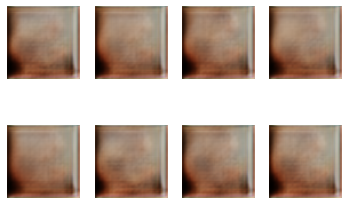

36001 [D loss: 0.599685, acc.: 100.00%, op_acc: 67.23%] [G loss: 0.975947]
36002 [D loss: 0.597412, acc.: 100.00%, op_acc: 66.95%] [G loss: 0.990679]
36003 [D loss: 0.693559, acc.: 95.31%, op_acc: 66.84%] [G loss: 1.002142]
36004 [D loss: 0.613930, acc.: 100.00%, op_acc: 67.19%] [G loss: 0.969864]
36005 [D loss: 0.634053, acc.: 98.44%, op_acc: 66.41%] [G loss: 1.005071]
36006 [D loss: 0.709768, acc.: 95.31%, op_acc: 66.25%] [G loss: 0.945747]
36007 [D loss: 0.658004, acc.: 96.88%, op_acc: 67.30%] [G loss: 0.926475]
36008 [D loss: 0.661855, acc.: 98.44%, op_acc: 66.99%] [G loss: 0.980747]
36009 [D loss: 0.650502, acc.: 96.88%, op_acc: 66.25%] [G loss: 0.922774]
36010 [D loss: 0.580736, acc.: 100.00%, op_acc: 67.66%] [G loss: 1.049705]
36011 [D loss: 0.611701, acc.: 98.44%, op_acc: 67.93%] [G loss: 1.070051]
36012 [D loss: 0.610361, acc.: 100.00%, op_acc: 66.25%] [G loss: 1.030348]
36013 [D loss: 0.596368, acc.: 100.00%, op_acc: 65.98%] [G loss: 0.999938]
36014 [D loss: 0.631106, acc.: 9

36113 [D loss: 0.910365, acc.: 89.06%, op_acc: 67.34%] [G loss: 1.136232]
36114 [D loss: 1.019901, acc.: 85.94%, op_acc: 66.25%] [G loss: 1.117189]
36115 [D loss: 0.981763, acc.: 90.62%, op_acc: 67.03%] [G loss: 1.104939]
36116 [D loss: 0.925159, acc.: 92.19%, op_acc: 66.41%] [G loss: 1.171375]
36117 [D loss: 0.994624, acc.: 84.38%, op_acc: 67.54%] [G loss: 1.109323]
36118 [D loss: 0.929478, acc.: 90.62%, op_acc: 64.45%] [G loss: 1.144036]
36119 [D loss: 0.884455, acc.: 93.75%, op_acc: 67.07%] [G loss: 1.107502]
36120 [D loss: 1.004130, acc.: 89.06%, op_acc: 66.02%] [G loss: 1.106811]
36121 [D loss: 0.891371, acc.: 92.19%, op_acc: 65.74%] [G loss: 1.119943]
36122 [D loss: 0.882103, acc.: 92.19%, op_acc: 66.25%] [G loss: 1.146304]
36123 [D loss: 0.879363, acc.: 93.75%, op_acc: 66.76%] [G loss: 1.112840]
36124 [D loss: 0.791696, acc.: 98.44%, op_acc: 66.56%] [G loss: 1.115624]
36125 [D loss: 0.928474, acc.: 96.88%, op_acc: 65.43%] [G loss: 1.092763]
36126 [D loss: 0.868957, acc.: 90.62%,

36225 [D loss: 0.713950, acc.: 95.31%, op_acc: 67.07%] [G loss: 1.003125]
36226 [D loss: 0.716929, acc.: 98.44%, op_acc: 67.03%] [G loss: 1.001991]
36227 [D loss: 0.687046, acc.: 100.00%, op_acc: 65.98%] [G loss: 1.104050]
36228 [D loss: 0.726635, acc.: 96.88%, op_acc: 65.82%] [G loss: 1.012427]
36229 [D loss: 0.705419, acc.: 96.88%, op_acc: 66.99%] [G loss: 0.968162]
36230 [D loss: 0.759839, acc.: 93.75%, op_acc: 66.60%] [G loss: 1.020567]
36231 [D loss: 0.707063, acc.: 95.31%, op_acc: 65.86%] [G loss: 1.015511]
36232 [D loss: 0.668308, acc.: 98.44%, op_acc: 67.42%] [G loss: 1.032211]
36233 [D loss: 0.667685, acc.: 100.00%, op_acc: 67.19%] [G loss: 1.111565]
36234 [D loss: 0.669337, acc.: 98.44%, op_acc: 68.67%] [G loss: 0.984762]
36235 [D loss: 0.672879, acc.: 98.44%, op_acc: 67.50%] [G loss: 1.069157]
36236 [D loss: 0.795328, acc.: 93.75%, op_acc: 66.99%] [G loss: 0.977030]
36237 [D loss: 0.772200, acc.: 93.75%, op_acc: 66.99%] [G loss: 0.976942]
36238 [D loss: 0.653541, acc.: 100.0

36337 [D loss: 0.577672, acc.: 100.00%, op_acc: 66.56%] [G loss: 1.038429]
36338 [D loss: 0.596298, acc.: 100.00%, op_acc: 67.27%] [G loss: 0.996128]
36339 [D loss: 0.582531, acc.: 100.00%, op_acc: 67.15%] [G loss: 0.984685]
36340 [D loss: 0.675952, acc.: 96.88%, op_acc: 67.34%] [G loss: 1.039149]
36341 [D loss: 0.603507, acc.: 98.44%, op_acc: 68.01%] [G loss: 1.030083]
36342 [D loss: 0.583747, acc.: 100.00%, op_acc: 68.44%] [G loss: 0.984211]
36343 [D loss: 0.590873, acc.: 100.00%, op_acc: 67.85%] [G loss: 0.974015]
36344 [D loss: 0.578945, acc.: 100.00%, op_acc: 66.99%] [G loss: 0.994332]
36345 [D loss: 0.586118, acc.: 98.44%, op_acc: 68.59%] [G loss: 0.990010]
36346 [D loss: 0.590894, acc.: 100.00%, op_acc: 66.68%] [G loss: 0.986064]
36347 [D loss: 0.618753, acc.: 100.00%, op_acc: 66.05%] [G loss: 1.058541]
36348 [D loss: 0.581137, acc.: 100.00%, op_acc: 69.02%] [G loss: 0.975741]
36349 [D loss: 0.641813, acc.: 98.44%, op_acc: 66.13%] [G loss: 0.991410]
36350 [D loss: 0.644202, acc.

36447 [D loss: 0.609941, acc.: 96.88%, op_acc: 68.59%] [G loss: 1.396151]
36448 [D loss: 0.701309, acc.: 98.44%, op_acc: 65.86%] [G loss: 1.284605]
36449 [D loss: 0.583697, acc.: 100.00%, op_acc: 67.62%] [G loss: 1.679506]
36450 [D loss: 0.848826, acc.: 92.19%, op_acc: 65.74%] [G loss: 1.458416]
36451 [D loss: 0.548285, acc.: 100.00%, op_acc: 67.77%] [G loss: 2.031094]
36452 [D loss: 0.665943, acc.: 96.88%, op_acc: 66.64%] [G loss: 1.929839]
36453 [D loss: 0.597702, acc.: 100.00%, op_acc: 66.09%] [G loss: 1.489198]
36454 [D loss: 0.575118, acc.: 98.44%, op_acc: 69.14%] [G loss: 1.177836]
36455 [D loss: 0.633912, acc.: 98.44%, op_acc: 66.76%] [G loss: 1.150345]
36456 [D loss: 0.573499, acc.: 100.00%, op_acc: 67.89%] [G loss: 1.299786]
36457 [D loss: 0.685984, acc.: 93.75%, op_acc: 67.03%] [G loss: 1.053032]
36458 [D loss: 0.590741, acc.: 98.44%, op_acc: 68.40%] [G loss: 1.064080]
36459 [D loss: 0.589838, acc.: 100.00%, op_acc: 67.03%] [G loss: 1.054749]
36460 [D loss: 0.598351, acc.: 10

36559 [D loss: 0.592253, acc.: 98.44%, op_acc: 67.81%] [G loss: 1.025103]
36560 [D loss: 0.569849, acc.: 100.00%, op_acc: 66.84%] [G loss: 1.015782]
36561 [D loss: 0.593459, acc.: 100.00%, op_acc: 67.34%] [G loss: 0.970491]
36562 [D loss: 0.573240, acc.: 100.00%, op_acc: 67.54%] [G loss: 0.980379]
36563 [D loss: 0.571574, acc.: 100.00%, op_acc: 67.85%] [G loss: 0.998406]
36564 [D loss: 0.581694, acc.: 100.00%, op_acc: 66.99%] [G loss: 1.001375]
36565 [D loss: 0.577272, acc.: 100.00%, op_acc: 69.02%] [G loss: 0.952700]
36566 [D loss: 0.573859, acc.: 100.00%, op_acc: 69.18%] [G loss: 0.969175]
36567 [D loss: 0.591955, acc.: 98.44%, op_acc: 67.62%] [G loss: 1.018692]
36568 [D loss: 0.573327, acc.: 100.00%, op_acc: 69.18%] [G loss: 0.997769]
36569 [D loss: 0.601422, acc.: 98.44%, op_acc: 69.14%] [G loss: 1.046116]
36570 [D loss: 0.573549, acc.: 100.00%, op_acc: 67.11%] [G loss: 1.058239]
36571 [D loss: 0.555489, acc.: 100.00%, op_acc: 68.09%] [G loss: 1.010294]
36572 [D loss: 0.559894, acc

36669 [D loss: 0.736394, acc.: 95.31%, op_acc: 67.70%] [G loss: 1.017066]
36670 [D loss: 0.660826, acc.: 96.88%, op_acc: 67.85%] [G loss: 0.981599]
36671 [D loss: 0.610909, acc.: 100.00%, op_acc: 68.52%] [G loss: 0.966117]
36672 [D loss: 0.668402, acc.: 98.44%, op_acc: 66.80%] [G loss: 0.981610]
36673 [D loss: 0.696636, acc.: 96.88%, op_acc: 66.76%] [G loss: 1.026839]
36674 [D loss: 0.823464, acc.: 90.62%, op_acc: 64.26%] [G loss: 1.206507]
36675 [D loss: 0.813723, acc.: 93.75%, op_acc: 65.39%] [G loss: 1.251440]
36676 [D loss: 0.799026, acc.: 87.50%, op_acc: 67.62%] [G loss: 1.334796]
36677 [D loss: 0.608649, acc.: 98.44%, op_acc: 68.63%] [G loss: 1.837621]
36678 [D loss: 0.732112, acc.: 95.31%, op_acc: 67.42%] [G loss: 4.182378]
36679 [D loss: 0.905062, acc.: 85.94%, op_acc: 69.18%] [G loss: 8.007711]
36680 [D loss: 0.729501, acc.: 93.75%, op_acc: 65.55%] [G loss: 7.415613]
36681 [D loss: 0.740333, acc.: 96.88%, op_acc: 65.59%] [G loss: 4.173289]
36682 [D loss: 0.872302, acc.: 87.50%

36781 [D loss: 0.573181, acc.: 100.00%, op_acc: 66.80%] [G loss: 0.955410]
36782 [D loss: 0.574197, acc.: 100.00%, op_acc: 68.28%] [G loss: 0.950116]
36783 [D loss: 0.596469, acc.: 98.44%, op_acc: 67.38%] [G loss: 0.958072]
36784 [D loss: 0.620036, acc.: 98.44%, op_acc: 67.81%] [G loss: 0.991927]
36785 [D loss: 0.605672, acc.: 98.44%, op_acc: 67.97%] [G loss: 0.979062]
36786 [D loss: 0.614829, acc.: 98.44%, op_acc: 66.64%] [G loss: 0.930133]
36787 [D loss: 0.568624, acc.: 100.00%, op_acc: 68.16%] [G loss: 0.959886]
36788 [D loss: 0.565322, acc.: 100.00%, op_acc: 67.54%] [G loss: 0.917541]
36789 [D loss: 0.570386, acc.: 100.00%, op_acc: 66.52%] [G loss: 1.013299]
36790 [D loss: 0.629650, acc.: 96.88%, op_acc: 67.54%] [G loss: 0.952743]
36791 [D loss: 0.595875, acc.: 98.44%, op_acc: 67.50%] [G loss: 1.006193]
36792 [D loss: 0.605781, acc.: 98.44%, op_acc: 66.52%] [G loss: 1.016157]
36793 [D loss: 0.555748, acc.: 100.00%, op_acc: 67.46%] [G loss: 0.981503]
36794 [D loss: 0.589389, acc.: 9

36893 [D loss: 0.735628, acc.: 95.31%, op_acc: 67.46%] [G loss: 1.031500]
36894 [D loss: 0.928099, acc.: 90.62%, op_acc: 67.34%] [G loss: 0.992815]
36895 [D loss: 0.782797, acc.: 92.19%, op_acc: 66.72%] [G loss: 1.049374]
36896 [D loss: 0.734764, acc.: 96.88%, op_acc: 66.48%] [G loss: 1.036053]
36897 [D loss: 0.761606, acc.: 93.75%, op_acc: 66.60%] [G loss: 1.011765]
36898 [D loss: 0.721919, acc.: 95.31%, op_acc: 66.95%] [G loss: 1.026635]
36899 [D loss: 0.762777, acc.: 96.88%, op_acc: 66.80%] [G loss: 1.031593]
36900 [D loss: 0.704366, acc.: 98.44%, op_acc: 67.54%] [G loss: 1.053214]
36901 [D loss: 0.775261, acc.: 93.75%, op_acc: 65.74%] [G loss: 1.076235]
36902 [D loss: 0.666902, acc.: 96.88%, op_acc: 68.52%] [G loss: 1.097805]
36903 [D loss: 0.719676, acc.: 96.88%, op_acc: 68.24%] [G loss: 1.019794]
36904 [D loss: 0.966331, acc.: 84.38%, op_acc: 65.90%] [G loss: 1.044542]
36905 [D loss: 0.776607, acc.: 93.75%, op_acc: 68.28%] [G loss: 1.110518]
36906 [D loss: 0.728908, acc.: 95.31%,

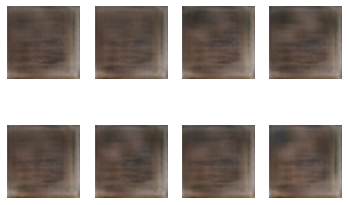

37001 [D loss: 0.628007, acc.: 98.44%, op_acc: 67.50%] [G loss: 1.060066]
37002 [D loss: 0.672327, acc.: 96.88%, op_acc: 65.51%] [G loss: 0.995651]
37003 [D loss: 0.656160, acc.: 96.88%, op_acc: 67.15%] [G loss: 0.942069]
37004 [D loss: 0.656978, acc.: 100.00%, op_acc: 64.92%] [G loss: 1.012424]
37005 [D loss: 0.655322, acc.: 98.44%, op_acc: 66.68%] [G loss: 1.013384]
37006 [D loss: 0.671343, acc.: 96.88%, op_acc: 67.42%] [G loss: 1.009180]
37007 [D loss: 0.723212, acc.: 95.31%, op_acc: 67.58%] [G loss: 0.975021]
37008 [D loss: 0.657231, acc.: 96.88%, op_acc: 68.01%] [G loss: 0.981917]
37009 [D loss: 0.603170, acc.: 98.44%, op_acc: 65.12%] [G loss: 0.962232]
37010 [D loss: 0.589181, acc.: 100.00%, op_acc: 67.54%] [G loss: 1.003115]
37011 [D loss: 0.601680, acc.: 96.88%, op_acc: 69.80%] [G loss: 1.044745]
37012 [D loss: 0.682869, acc.: 96.88%, op_acc: 67.23%] [G loss: 1.009464]
37013 [D loss: 0.629382, acc.: 98.44%, op_acc: 67.70%] [G loss: 0.987144]
37014 [D loss: 0.621643, acc.: 98.44

37111 [D loss: 0.762027, acc.: 96.88%, op_acc: 66.76%] [G loss: 1.597771]
37112 [D loss: 0.950669, acc.: 84.38%, op_acc: 66.52%] [G loss: 2.401606]
37113 [D loss: 0.810106, acc.: 93.75%, op_acc: 65.90%] [G loss: 3.395695]
37114 [D loss: 0.907782, acc.: 92.19%, op_acc: 65.43%] [G loss: 2.862688]
37115 [D loss: 0.740300, acc.: 95.31%, op_acc: 66.80%] [G loss: 3.328522]
37116 [D loss: 0.763487, acc.: 93.75%, op_acc: 67.11%] [G loss: 4.407345]
37117 [D loss: 0.880524, acc.: 84.38%, op_acc: 66.09%] [G loss: 3.059128]
37118 [D loss: 0.809626, acc.: 89.06%, op_acc: 67.50%] [G loss: 5.738664]
37119 [D loss: 0.764114, acc.: 93.75%, op_acc: 67.54%] [G loss: 4.652066]
37120 [D loss: 0.911806, acc.: 89.06%, op_acc: 65.90%] [G loss: 5.733338]
37121 [D loss: 1.060444, acc.: 85.94%, op_acc: 67.03%] [G loss: 4.460149]
37122 [D loss: 2.487548, acc.: 35.94%, op_acc: 63.24%] [G loss: 5.315901]
37123 [D loss: 1.470189, acc.: 75.00%, op_acc: 65.27%] [G loss: 4.128719]
37124 [D loss: 1.093995, acc.: 78.12%,

37223 [D loss: 0.584950, acc.: 100.00%, op_acc: 67.38%] [G loss: 1.041614]
37224 [D loss: 0.605793, acc.: 98.44%, op_acc: 68.44%] [G loss: 1.053648]
37225 [D loss: 0.586316, acc.: 100.00%, op_acc: 68.28%] [G loss: 1.076585]
37226 [D loss: 0.595067, acc.: 98.44%, op_acc: 68.67%] [G loss: 1.059187]
37227 [D loss: 0.652266, acc.: 96.88%, op_acc: 67.38%] [G loss: 0.994009]
37228 [D loss: 0.622851, acc.: 100.00%, op_acc: 67.62%] [G loss: 1.016034]
37229 [D loss: 0.585628, acc.: 98.44%, op_acc: 69.22%] [G loss: 1.076079]
37230 [D loss: 0.648405, acc.: 96.88%, op_acc: 68.16%] [G loss: 1.042646]
37231 [D loss: 0.726606, acc.: 93.75%, op_acc: 67.81%] [G loss: 1.024355]
37232 [D loss: 0.632651, acc.: 100.00%, op_acc: 68.05%] [G loss: 1.066617]
37233 [D loss: 0.600378, acc.: 98.44%, op_acc: 66.99%] [G loss: 1.082904]
37234 [D loss: 0.668067, acc.: 96.88%, op_acc: 67.66%] [G loss: 1.075835]
37235 [D loss: 0.601338, acc.: 100.00%, op_acc: 67.03%] [G loss: 1.053781]
37236 [D loss: 0.656427, acc.: 96

37335 [D loss: 1.064922, acc.: 82.81%, op_acc: 65.94%] [G loss: 1.229460]
37336 [D loss: 0.930234, acc.: 92.19%, op_acc: 67.27%] [G loss: 1.187414]
37337 [D loss: 0.878555, acc.: 93.75%, op_acc: 66.91%] [G loss: 1.214486]
37338 [D loss: 1.024313, acc.: 84.38%, op_acc: 65.90%] [G loss: 1.058789]
37339 [D loss: 0.927089, acc.: 87.50%, op_acc: 66.56%] [G loss: 1.025360]
37340 [D loss: 0.863235, acc.: 95.31%, op_acc: 66.76%] [G loss: 1.141419]
37341 [D loss: 1.107710, acc.: 89.06%, op_acc: 64.77%] [G loss: 0.994195]
37342 [D loss: 0.836023, acc.: 95.31%, op_acc: 66.68%] [G loss: 0.941582]
37343 [D loss: 0.843448, acc.: 95.31%, op_acc: 65.39%] [G loss: 1.011170]
37344 [D loss: 0.952309, acc.: 90.62%, op_acc: 66.88%] [G loss: 0.957617]
37345 [D loss: 0.926894, acc.: 85.94%, op_acc: 65.43%] [G loss: 0.917101]
37346 [D loss: 0.888265, acc.: 89.06%, op_acc: 65.86%] [G loss: 0.910343]
37347 [D loss: 0.848871, acc.: 93.75%, op_acc: 67.58%] [G loss: 0.916501]
37348 [D loss: 0.763191, acc.: 96.88%,

37447 [D loss: 0.719634, acc.: 96.88%, op_acc: 67.46%] [G loss: 0.998452]
37448 [D loss: 1.096892, acc.: 85.94%, op_acc: 63.44%] [G loss: 0.996158]
37449 [D loss: 0.765983, acc.: 95.31%, op_acc: 67.03%] [G loss: 1.029403]
37450 [D loss: 0.765968, acc.: 90.62%, op_acc: 65.43%] [G loss: 0.993105]
37451 [D loss: 0.742121, acc.: 95.31%, op_acc: 65.90%] [G loss: 1.046041]
37452 [D loss: 0.856860, acc.: 95.31%, op_acc: 65.12%] [G loss: 0.987604]
37453 [D loss: 0.820854, acc.: 93.75%, op_acc: 66.80%] [G loss: 1.020107]
37454 [D loss: 0.654036, acc.: 98.44%, op_acc: 65.94%] [G loss: 1.045652]
37455 [D loss: 0.681731, acc.: 96.88%, op_acc: 66.21%] [G loss: 1.091650]
37456 [D loss: 0.675456, acc.: 96.88%, op_acc: 66.76%] [G loss: 1.031303]
37457 [D loss: 0.707395, acc.: 96.88%, op_acc: 66.56%] [G loss: 0.998816]
37458 [D loss: 0.786532, acc.: 89.06%, op_acc: 65.98%] [G loss: 0.998833]
37459 [D loss: 0.674917, acc.: 100.00%, op_acc: 65.35%] [G loss: 1.051915]
37460 [D loss: 0.671392, acc.: 100.00

37559 [D loss: 1.388642, acc.: 53.12%, op_acc: 65.59%] [G loss: 2.016518]
37560 [D loss: 1.282485, acc.: 75.00%, op_acc: 65.47%] [G loss: 1.844820]
37561 [D loss: 1.231010, acc.: 76.56%, op_acc: 65.62%] [G loss: 1.751107]
37562 [D loss: 1.390336, acc.: 51.56%, op_acc: 66.45%] [G loss: 1.681671]
37563 [D loss: 1.238824, acc.: 68.75%, op_acc: 65.31%] [G loss: 1.584677]
37564 [D loss: 1.285106, acc.: 60.94%, op_acc: 67.73%] [G loss: 1.476419]
37565 [D loss: 1.321472, acc.: 50.00%, op_acc: 67.66%] [G loss: 1.456166]
37566 [D loss: 1.332979, acc.: 54.69%, op_acc: 66.09%] [G loss: 1.437322]
37567 [D loss: 1.384531, acc.: 43.75%, op_acc: 67.34%] [G loss: 1.368162]
37568 [D loss: 1.401913, acc.: 53.12%, op_acc: 66.76%] [G loss: 1.386600]
37569 [D loss: 1.488296, acc.: 37.50%, op_acc: 65.12%] [G loss: 1.393719]
37570 [D loss: 1.323700, acc.: 56.25%, op_acc: 66.95%] [G loss: 1.421506]
37571 [D loss: 1.472939, acc.: 29.69%, op_acc: 68.12%] [G loss: 1.297595]
37572 [D loss: 1.473162, acc.: 43.75%,

37671 [D loss: 1.197593, acc.: 76.56%, op_acc: 64.61%] [G loss: 1.329553]
37672 [D loss: 1.206753, acc.: 76.56%, op_acc: 65.86%] [G loss: 1.337387]
37673 [D loss: 1.200657, acc.: 78.12%, op_acc: 66.45%] [G loss: 1.280682]
37674 [D loss: 1.198099, acc.: 71.88%, op_acc: 68.12%] [G loss: 1.220582]
37675 [D loss: 1.198168, acc.: 75.00%, op_acc: 64.96%] [G loss: 1.249537]
37676 [D loss: 1.130569, acc.: 81.25%, op_acc: 66.99%] [G loss: 1.255871]
37677 [D loss: 1.157398, acc.: 84.38%, op_acc: 65.86%] [G loss: 1.226541]
37678 [D loss: 1.247262, acc.: 67.19%, op_acc: 65.59%] [G loss: 1.220383]
37679 [D loss: 1.231489, acc.: 73.44%, op_acc: 65.74%] [G loss: 1.159134]
37680 [D loss: 1.074931, acc.: 89.06%, op_acc: 66.68%] [G loss: 1.163023]
37681 [D loss: 1.218192, acc.: 71.88%, op_acc: 65.66%] [G loss: 1.164712]
37682 [D loss: 1.163121, acc.: 81.25%, op_acc: 66.80%] [G loss: 1.175691]
37683 [D loss: 1.170295, acc.: 76.56%, op_acc: 67.81%] [G loss: 1.120950]
37684 [D loss: 1.126294, acc.: 76.56%,

37783 [D loss: 0.663317, acc.: 98.44%, op_acc: 67.66%] [G loss: 1.026564]
37784 [D loss: 0.749315, acc.: 95.31%, op_acc: 67.66%] [G loss: 0.950012]
37785 [D loss: 0.724676, acc.: 96.88%, op_acc: 67.19%] [G loss: 0.989731]
37786 [D loss: 0.740766, acc.: 93.75%, op_acc: 67.77%] [G loss: 0.950046]
37787 [D loss: 0.695581, acc.: 95.31%, op_acc: 64.88%] [G loss: 0.969453]
37788 [D loss: 0.678222, acc.: 96.88%, op_acc: 67.19%] [G loss: 0.981976]
37789 [D loss: 0.664228, acc.: 100.00%, op_acc: 67.70%] [G loss: 0.959687]
37790 [D loss: 0.676558, acc.: 96.88%, op_acc: 66.41%] [G loss: 0.946290]
37791 [D loss: 0.679834, acc.: 98.44%, op_acc: 68.01%] [G loss: 0.954674]
37792 [D loss: 0.678214, acc.: 100.00%, op_acc: 67.11%] [G loss: 1.015514]
37793 [D loss: 0.670200, acc.: 98.44%, op_acc: 67.73%] [G loss: 0.979290]
37794 [D loss: 0.673402, acc.: 98.44%, op_acc: 67.97%] [G loss: 0.930089]
37795 [D loss: 0.703939, acc.: 96.88%, op_acc: 68.59%] [G loss: 0.990714]
37796 [D loss: 0.684788, acc.: 96.88

37894 [D loss: 1.364081, acc.: 68.75%, op_acc: 66.05%] [G loss: 1.403857]
37895 [D loss: 1.107951, acc.: 85.94%, op_acc: 66.09%] [G loss: 1.348567]
37896 [D loss: 1.281598, acc.: 70.31%, op_acc: 64.61%] [G loss: 1.229360]
37897 [D loss: 1.295450, acc.: 64.06%, op_acc: 67.38%] [G loss: 1.186464]
37898 [D loss: 1.223007, acc.: 73.44%, op_acc: 65.94%] [G loss: 1.213583]
37899 [D loss: 1.288117, acc.: 71.88%, op_acc: 66.17%] [G loss: 1.201224]
37900 [D loss: 1.353141, acc.: 59.38%, op_acc: 65.08%] [G loss: 1.179522]
37901 [D loss: 1.288156, acc.: 64.06%, op_acc: 66.25%] [G loss: 1.128273]
37902 [D loss: 1.306811, acc.: 65.62%, op_acc: 64.57%] [G loss: 1.087584]
37903 [D loss: 1.319494, acc.: 65.62%, op_acc: 65.62%] [G loss: 1.099656]
37904 [D loss: 1.058513, acc.: 82.81%, op_acc: 67.19%] [G loss: 1.201280]
37905 [D loss: 1.211589, acc.: 73.44%, op_acc: 66.29%] [G loss: 1.146220]
37906 [D loss: 1.174641, acc.: 71.88%, op_acc: 65.43%] [G loss: 1.156566]
37907 [D loss: 1.043475, acc.: 84.38%,

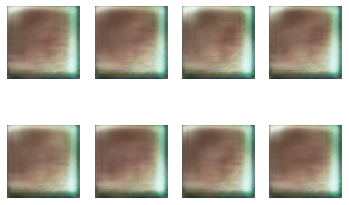

38001 [D loss: 0.613540, acc.: 98.44%, op_acc: 66.80%] [G loss: 0.971078]
38002 [D loss: 0.693735, acc.: 95.31%, op_acc: 68.36%] [G loss: 0.928322]
38003 [D loss: 0.658723, acc.: 96.88%, op_acc: 68.16%] [G loss: 0.937431]
38004 [D loss: 0.785515, acc.: 96.88%, op_acc: 66.56%] [G loss: 0.991297]
38005 [D loss: 0.714585, acc.: 96.88%, op_acc: 67.30%] [G loss: 0.900365]
38006 [D loss: 0.679685, acc.: 98.44%, op_acc: 67.54%] [G loss: 0.993088]
38007 [D loss: 0.726590, acc.: 95.31%, op_acc: 68.59%] [G loss: 0.944964]
38008 [D loss: 0.596604, acc.: 100.00%, op_acc: 68.48%] [G loss: 1.007569]
38009 [D loss: 0.624908, acc.: 100.00%, op_acc: 66.52%] [G loss: 1.006664]
38010 [D loss: 0.658668, acc.: 98.44%, op_acc: 66.72%] [G loss: 0.901606]
38011 [D loss: 0.825033, acc.: 95.31%, op_acc: 66.45%] [G loss: 0.963348]
38012 [D loss: 0.618377, acc.: 100.00%, op_acc: 66.17%] [G loss: 0.948184]
38013 [D loss: 0.628426, acc.: 98.44%, op_acc: 67.42%] [G loss: 0.999961]
38014 [D loss: 0.704096, acc.: 96.8

38113 [D loss: 1.262728, acc.: 67.19%, op_acc: 67.46%] [G loss: 2.010173]
38114 [D loss: 1.347936, acc.: 71.88%, op_acc: 65.12%] [G loss: 2.002074]
38115 [D loss: 1.017094, acc.: 85.94%, op_acc: 67.77%] [G loss: 2.242229]
38116 [D loss: 1.205417, acc.: 70.31%, op_acc: 66.87%] [G loss: 1.772666]
38117 [D loss: 1.173992, acc.: 81.25%, op_acc: 67.23%] [G loss: 1.874485]
38118 [D loss: 1.137739, acc.: 73.44%, op_acc: 67.97%] [G loss: 2.248520]
38119 [D loss: 1.294143, acc.: 68.75%, op_acc: 65.08%] [G loss: 1.973548]
38120 [D loss: 1.316696, acc.: 70.31%, op_acc: 68.40%] [G loss: 1.377558]
38121 [D loss: 1.297460, acc.: 64.06%, op_acc: 66.84%] [G loss: 1.439821]
38122 [D loss: 1.257541, acc.: 57.81%, op_acc: 66.48%] [G loss: 1.550168]
38123 [D loss: 1.240623, acc.: 64.06%, op_acc: 66.64%] [G loss: 1.492209]
38124 [D loss: 1.471410, acc.: 53.12%, op_acc: 66.09%] [G loss: 1.608806]
38125 [D loss: 1.413962, acc.: 59.38%, op_acc: 67.23%] [G loss: 1.455560]
38126 [D loss: 1.326250, acc.: 60.94%,

38225 [D loss: 0.633588, acc.: 100.00%, op_acc: 66.99%] [G loss: 1.142043]
38226 [D loss: 0.797642, acc.: 92.19%, op_acc: 65.86%] [G loss: 1.038479]
38227 [D loss: 0.639842, acc.: 98.44%, op_acc: 67.85%] [G loss: 1.080443]
38228 [D loss: 0.716041, acc.: 95.31%, op_acc: 66.68%] [G loss: 1.115984]
38229 [D loss: 0.743347, acc.: 95.31%, op_acc: 67.73%] [G loss: 0.975129]
38230 [D loss: 0.708827, acc.: 96.88%, op_acc: 68.52%] [G loss: 0.999437]
38231 [D loss: 0.690707, acc.: 96.88%, op_acc: 67.58%] [G loss: 1.064497]
38232 [D loss: 0.663287, acc.: 98.44%, op_acc: 67.03%] [G loss: 1.013250]
38233 [D loss: 0.732488, acc.: 95.31%, op_acc: 66.64%] [G loss: 1.083821]
38234 [D loss: 0.778870, acc.: 95.31%, op_acc: 65.39%] [G loss: 1.115999]
38235 [D loss: 0.681485, acc.: 96.88%, op_acc: 67.54%] [G loss: 1.182258]
38236 [D loss: 0.620649, acc.: 100.00%, op_acc: 68.48%] [G loss: 1.283084]
38237 [D loss: 0.701215, acc.: 96.88%, op_acc: 66.09%] [G loss: 1.173339]
38238 [D loss: 0.661638, acc.: 95.31

38337 [D loss: 0.967735, acc.: 93.75%, op_acc: 65.62%] [G loss: 1.375476]
38338 [D loss: 1.001059, acc.: 85.94%, op_acc: 66.13%] [G loss: 1.341114]
38339 [D loss: 0.952847, acc.: 90.62%, op_acc: 66.91%] [G loss: 1.355484]
38340 [D loss: 1.036750, acc.: 84.38%, op_acc: 68.01%] [G loss: 1.326029]
38341 [D loss: 0.939017, acc.: 92.19%, op_acc: 66.21%] [G loss: 1.361426]
38342 [D loss: 0.943119, acc.: 90.62%, op_acc: 66.68%] [G loss: 1.290810]
38343 [D loss: 0.905416, acc.: 93.75%, op_acc: 66.17%] [G loss: 1.323294]
38344 [D loss: 0.866553, acc.: 95.31%, op_acc: 66.13%] [G loss: 1.274996]
38345 [D loss: 0.996250, acc.: 85.94%, op_acc: 66.02%] [G loss: 1.247933]
38346 [D loss: 0.962489, acc.: 89.06%, op_acc: 66.60%] [G loss: 1.235691]
38347 [D loss: 1.092223, acc.: 82.81%, op_acc: 65.51%] [G loss: 1.162719]
38348 [D loss: 1.080886, acc.: 78.12%, op_acc: 65.70%] [G loss: 1.264407]
38349 [D loss: 0.919222, acc.: 95.31%, op_acc: 66.76%] [G loss: 1.249991]
38350 [D loss: 0.959069, acc.: 87.50%,

38449 [D loss: 0.555264, acc.: 100.00%, op_acc: 68.20%] [G loss: 1.018638]
38450 [D loss: 0.606101, acc.: 100.00%, op_acc: 67.27%] [G loss: 0.982380]
38451 [D loss: 0.614156, acc.: 98.44%, op_acc: 67.50%] [G loss: 1.002316]
38452 [D loss: 0.640921, acc.: 96.88%, op_acc: 68.12%] [G loss: 0.947343]
38453 [D loss: 0.592890, acc.: 98.44%, op_acc: 67.85%] [G loss: 0.956220]
38454 [D loss: 0.603144, acc.: 98.44%, op_acc: 67.89%] [G loss: 0.941080]
38455 [D loss: 0.591690, acc.: 98.44%, op_acc: 66.95%] [G loss: 1.004600]
38456 [D loss: 0.600926, acc.: 100.00%, op_acc: 67.34%] [G loss: 0.981927]
38457 [D loss: 0.572857, acc.: 100.00%, op_acc: 66.80%] [G loss: 1.017156]
38458 [D loss: 0.570486, acc.: 100.00%, op_acc: 67.73%] [G loss: 0.957986]
38459 [D loss: 0.602365, acc.: 98.44%, op_acc: 67.50%] [G loss: 1.017881]
38460 [D loss: 0.613401, acc.: 96.88%, op_acc: 68.12%] [G loss: 1.008753]
38461 [D loss: 0.578084, acc.: 98.44%, op_acc: 67.66%] [G loss: 0.996169]
38462 [D loss: 0.606082, acc.: 98

38560 [D loss: 0.887860, acc.: 89.06%, op_acc: 68.20%] [G loss: 1.226795]
38561 [D loss: 0.972620, acc.: 87.50%, op_acc: 65.94%] [G loss: 1.394756]
38562 [D loss: 0.947310, acc.: 82.81%, op_acc: 66.91%] [G loss: 1.699486]
38563 [D loss: 0.669264, acc.: 98.44%, op_acc: 66.64%] [G loss: 1.896072]
38564 [D loss: 0.761375, acc.: 96.88%, op_acc: 68.24%] [G loss: 1.816243]
38565 [D loss: 0.796490, acc.: 93.75%, op_acc: 65.94%] [G loss: 1.446838]
38566 [D loss: 0.973508, acc.: 87.50%, op_acc: 66.02%] [G loss: 1.204894]
38567 [D loss: 1.039143, acc.: 82.81%, op_acc: 66.09%] [G loss: 1.192225]
38568 [D loss: 0.932313, acc.: 89.06%, op_acc: 65.78%] [G loss: 1.222803]
38569 [D loss: 0.928896, acc.: 89.06%, op_acc: 67.66%] [G loss: 1.161974]
38570 [D loss: 0.877723, acc.: 90.62%, op_acc: 66.41%] [G loss: 1.127251]
38571 [D loss: 0.774469, acc.: 96.88%, op_acc: 67.58%] [G loss: 1.147723]
38572 [D loss: 0.810003, acc.: 95.31%, op_acc: 66.84%] [G loss: 1.104662]
38573 [D loss: 0.756811, acc.: 95.31%,

38672 [D loss: 1.014353, acc.: 82.81%, op_acc: 67.70%] [G loss: 1.390724]
38673 [D loss: 1.114566, acc.: 78.12%, op_acc: 66.48%] [G loss: 1.312017]
38674 [D loss: 0.998125, acc.: 87.50%, op_acc: 66.41%] [G loss: 1.562144]
38675 [D loss: 0.928962, acc.: 87.50%, op_acc: 66.02%] [G loss: 1.610613]
38676 [D loss: 0.925406, acc.: 92.19%, op_acc: 66.60%] [G loss: 1.603693]
38677 [D loss: 1.064514, acc.: 85.94%, op_acc: 66.02%] [G loss: 1.524441]
38678 [D loss: 1.010902, acc.: 78.12%, op_acc: 67.03%] [G loss: 1.615209]
38679 [D loss: 0.911990, acc.: 90.62%, op_acc: 66.60%] [G loss: 1.698757]
38680 [D loss: 1.022344, acc.: 82.81%, op_acc: 68.75%] [G loss: 1.568308]
38681 [D loss: 0.946196, acc.: 89.06%, op_acc: 65.04%] [G loss: 1.590107]
38682 [D loss: 0.936223, acc.: 82.81%, op_acc: 65.51%] [G loss: 1.530828]
38683 [D loss: 0.836600, acc.: 89.06%, op_acc: 65.27%] [G loss: 1.831367]
38684 [D loss: 1.012614, acc.: 89.06%, op_acc: 64.53%] [G loss: 1.512272]
38685 [D loss: 0.920990, acc.: 87.50%,

38784 [D loss: 0.879562, acc.: 92.19%, op_acc: 67.03%] [G loss: 1.087916]
38785 [D loss: 0.772458, acc.: 96.88%, op_acc: 67.54%] [G loss: 1.055280]
38786 [D loss: 0.851939, acc.: 93.75%, op_acc: 66.95%] [G loss: 1.063329]
38787 [D loss: 0.805916, acc.: 95.31%, op_acc: 68.01%] [G loss: 1.011310]
38788 [D loss: 0.733003, acc.: 98.44%, op_acc: 66.60%] [G loss: 1.032976]
38789 [D loss: 0.842077, acc.: 92.19%, op_acc: 68.09%] [G loss: 1.020790]
38790 [D loss: 0.795366, acc.: 98.44%, op_acc: 65.59%] [G loss: 1.039541]
38791 [D loss: 0.863079, acc.: 93.75%, op_acc: 66.21%] [G loss: 1.034243]
38792 [D loss: 0.790997, acc.: 93.75%, op_acc: 68.44%] [G loss: 1.035404]
38793 [D loss: 0.776633, acc.: 92.19%, op_acc: 65.59%] [G loss: 1.082149]
38794 [D loss: 0.778335, acc.: 95.31%, op_acc: 66.05%] [G loss: 1.065748]
38795 [D loss: 0.899005, acc.: 92.19%, op_acc: 67.11%] [G loss: 1.008132]
38796 [D loss: 0.817097, acc.: 93.75%, op_acc: 65.82%] [G loss: 1.045724]
38797 [D loss: 0.811098, acc.: 96.88%,

38896 [D loss: 0.760581, acc.: 96.88%, op_acc: 68.20%] [G loss: 0.939269]
38897 [D loss: 0.637209, acc.: 98.44%, op_acc: 67.19%] [G loss: 0.938297]
38898 [D loss: 0.766883, acc.: 92.19%, op_acc: 67.15%] [G loss: 0.917979]
38899 [D loss: 0.633991, acc.: 98.44%, op_acc: 68.01%] [G loss: 0.961457]
38900 [D loss: 0.870578, acc.: 93.75%, op_acc: 66.13%] [G loss: 0.920270]
38901 [D loss: 0.692427, acc.: 96.88%, op_acc: 67.34%] [G loss: 0.988790]
38902 [D loss: 0.614483, acc.: 98.44%, op_acc: 67.70%] [G loss: 0.984367]
38903 [D loss: 0.655621, acc.: 98.44%, op_acc: 68.01%] [G loss: 0.925069]
38904 [D loss: 0.652349, acc.: 96.88%, op_acc: 68.09%] [G loss: 0.927021]
38905 [D loss: 0.666056, acc.: 95.31%, op_acc: 70.04%] [G loss: 0.974658]
38906 [D loss: 0.687834, acc.: 96.88%, op_acc: 68.40%] [G loss: 0.972494]
38907 [D loss: 0.683898, acc.: 95.31%, op_acc: 69.34%] [G loss: 0.975570]
38908 [D loss: 0.748256, acc.: 96.88%, op_acc: 66.41%] [G loss: 0.939615]
38909 [D loss: 0.759453, acc.: 93.75%,

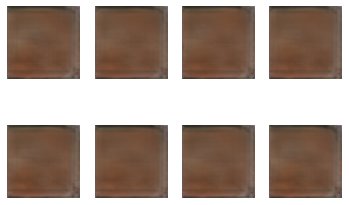

39001 [D loss: 0.899423, acc.: 87.50%, op_acc: 66.76%] [G loss: 1.161638]
39002 [D loss: 0.923316, acc.: 87.50%, op_acc: 66.95%] [G loss: 1.138984]
39003 [D loss: 1.186257, acc.: 70.31%, op_acc: 65.74%] [G loss: 1.174453]
39004 [D loss: 1.020833, acc.: 87.50%, op_acc: 65.59%] [G loss: 1.195826]
39005 [D loss: 1.204442, acc.: 71.88%, op_acc: 66.95%] [G loss: 1.482908]
39006 [D loss: 1.145236, acc.: 70.31%, op_acc: 66.48%] [G loss: 1.619467]
39007 [D loss: 1.371643, acc.: 64.06%, op_acc: 65.47%] [G loss: 1.402668]
39008 [D loss: 1.178933, acc.: 67.19%, op_acc: 67.23%] [G loss: 1.464960]
39009 [D loss: 1.195122, acc.: 68.75%, op_acc: 67.03%] [G loss: 1.521692]
39010 [D loss: 1.257525, acc.: 62.50%, op_acc: 67.15%] [G loss: 1.618099]
39011 [D loss: 0.977180, acc.: 87.50%, op_acc: 68.36%] [G loss: 1.571704]
39012 [D loss: 1.067449, acc.: 79.69%, op_acc: 66.37%] [G loss: 1.693274]
39013 [D loss: 1.213496, acc.: 75.00%, op_acc: 65.59%] [G loss: 1.574413]
39014 [D loss: 1.159757, acc.: 73.44%,

39113 [D loss: 0.612587, acc.: 100.00%, op_acc: 68.67%] [G loss: 1.077733]
39114 [D loss: 0.652682, acc.: 96.88%, op_acc: 66.84%] [G loss: 1.034787]
39115 [D loss: 0.668628, acc.: 95.31%, op_acc: 68.05%] [G loss: 1.012149]
39116 [D loss: 0.590365, acc.: 100.00%, op_acc: 68.01%] [G loss: 1.006181]
39117 [D loss: 0.610227, acc.: 100.00%, op_acc: 68.12%] [G loss: 1.133450]
39118 [D loss: 0.596824, acc.: 100.00%, op_acc: 68.44%] [G loss: 1.000651]
39119 [D loss: 0.633368, acc.: 100.00%, op_acc: 68.95%] [G loss: 1.110745]
39120 [D loss: 0.607302, acc.: 100.00%, op_acc: 69.38%] [G loss: 1.150342]
39121 [D loss: 0.618842, acc.: 100.00%, op_acc: 67.15%] [G loss: 1.091008]
39122 [D loss: 0.665304, acc.: 96.88%, op_acc: 68.24%] [G loss: 1.105895]
39123 [D loss: 0.615264, acc.: 100.00%, op_acc: 66.88%] [G loss: 1.062255]
39124 [D loss: 0.653240, acc.: 98.44%, op_acc: 67.54%] [G loss: 1.043110]
39125 [D loss: 0.659580, acc.: 96.88%, op_acc: 68.24%] [G loss: 1.194289]
39126 [D loss: 0.701511, acc.:

39225 [D loss: 0.594398, acc.: 98.44%, op_acc: 67.85%] [G loss: 1.015237]
39226 [D loss: 0.578869, acc.: 100.00%, op_acc: 68.71%] [G loss: 1.027409]
39227 [D loss: 0.642816, acc.: 98.44%, op_acc: 67.34%] [G loss: 1.002401]
39228 [D loss: 0.606089, acc.: 98.44%, op_acc: 68.01%] [G loss: 1.004572]
39229 [D loss: 0.653151, acc.: 98.44%, op_acc: 68.79%] [G loss: 1.039109]
39230 [D loss: 0.718511, acc.: 93.75%, op_acc: 68.52%] [G loss: 1.007254]
39231 [D loss: 0.661745, acc.: 98.44%, op_acc: 67.85%] [G loss: 1.030030]
39232 [D loss: 0.646469, acc.: 100.00%, op_acc: 67.70%] [G loss: 1.004940]
39233 [D loss: 0.605002, acc.: 100.00%, op_acc: 68.09%] [G loss: 1.031038]
39234 [D loss: 0.634660, acc.: 98.44%, op_acc: 66.84%] [G loss: 1.078704]
39235 [D loss: 0.618571, acc.: 100.00%, op_acc: 68.48%] [G loss: 1.003705]
39236 [D loss: 0.582145, acc.: 100.00%, op_acc: 69.61%] [G loss: 1.026342]
39237 [D loss: 0.613999, acc.: 98.44%, op_acc: 68.36%] [G loss: 1.050173]
39238 [D loss: 0.591186, acc.: 10

39336 [D loss: 0.889902, acc.: 89.06%, op_acc: 66.48%] [G loss: 4.043622]
39337 [D loss: 0.784803, acc.: 90.62%, op_acc: 65.39%] [G loss: 6.341495]
39338 [D loss: 1.519848, acc.: 54.69%, op_acc: 64.37%] [G loss: 8.581116]
39339 [D loss: 1.210817, acc.: 85.94%, op_acc: 62.07%] [G loss: 7.187032]
39340 [D loss: 1.228848, acc.: 75.00%, op_acc: 60.04%] [G loss: 7.529419]
39341 [D loss: 1.126448, acc.: 84.38%, op_acc: 59.06%] [G loss: 6.057118]
39342 [D loss: 1.332384, acc.: 68.75%, op_acc: 63.83%] [G loss: 7.048225]
39343 [D loss: 1.173402, acc.: 84.38%, op_acc: 61.17%] [G loss: 6.647499]
39344 [D loss: 1.009613, acc.: 87.50%, op_acc: 65.12%] [G loss: 6.037504]
39345 [D loss: 1.350270, acc.: 79.69%, op_acc: 63.67%] [G loss: 4.954354]
39346 [D loss: 1.158497, acc.: 79.69%, op_acc: 65.55%] [G loss: 4.377529]
39347 [D loss: 1.110023, acc.: 81.25%, op_acc: 65.70%] [G loss: 4.354320]
39348 [D loss: 0.855400, acc.: 89.06%, op_acc: 66.09%] [G loss: 3.456975]
39349 [D loss: 1.020190, acc.: 84.38%,

39448 [D loss: 1.572459, acc.: 51.56%, op_acc: 65.94%] [G loss: 1.517081]
39449 [D loss: 1.331623, acc.: 67.19%, op_acc: 67.62%] [G loss: 1.229252]
39450 [D loss: 1.402917, acc.: 71.88%, op_acc: 64.69%] [G loss: 1.136575]
39451 [D loss: 1.072789, acc.: 79.69%, op_acc: 66.84%] [G loss: 1.141784]
39452 [D loss: 1.605901, acc.: 64.06%, op_acc: 60.90%] [G loss: 1.079044]
39453 [D loss: 1.155464, acc.: 82.81%, op_acc: 64.80%] [G loss: 1.136607]
39454 [D loss: 1.441371, acc.: 65.62%, op_acc: 64.69%] [G loss: 1.076508]
39455 [D loss: 0.990378, acc.: 87.50%, op_acc: 66.41%] [G loss: 1.142971]
39456 [D loss: 1.099288, acc.: 85.94%, op_acc: 65.90%] [G loss: 1.123662]
39457 [D loss: 1.080302, acc.: 82.81%, op_acc: 67.73%] [G loss: 1.046082]
39458 [D loss: 1.124866, acc.: 82.81%, op_acc: 66.88%] [G loss: 1.033507]
39459 [D loss: 0.887038, acc.: 87.50%, op_acc: 66.64%] [G loss: 1.112509]
39460 [D loss: 0.856202, acc.: 92.19%, op_acc: 66.21%] [G loss: 1.177974]
39461 [D loss: 0.848099, acc.: 93.75%,

39560 [D loss: 0.961059, acc.: 89.06%, op_acc: 67.27%] [G loss: 1.665172]
39561 [D loss: 1.036758, acc.: 84.38%, op_acc: 64.92%] [G loss: 1.669609]
39562 [D loss: 0.910132, acc.: 87.50%, op_acc: 67.27%] [G loss: 1.637141]
39563 [D loss: 1.192523, acc.: 71.88%, op_acc: 65.82%] [G loss: 1.424020]
39564 [D loss: 1.034767, acc.: 87.50%, op_acc: 66.56%] [G loss: 1.414628]
39565 [D loss: 1.081350, acc.: 82.81%, op_acc: 65.23%] [G loss: 1.498310]
39566 [D loss: 1.123132, acc.: 81.25%, op_acc: 67.30%] [G loss: 1.516439]
39567 [D loss: 1.007620, acc.: 84.38%, op_acc: 66.48%] [G loss: 1.474040]
39568 [D loss: 1.069976, acc.: 79.69%, op_acc: 66.87%] [G loss: 1.337795]
39569 [D loss: 0.934293, acc.: 87.50%, op_acc: 67.50%] [G loss: 1.640521]
39570 [D loss: 1.133372, acc.: 73.44%, op_acc: 66.17%] [G loss: 1.422576]
39571 [D loss: 0.862557, acc.: 90.62%, op_acc: 68.20%] [G loss: 1.375936]
39572 [D loss: 0.838892, acc.: 95.31%, op_acc: 68.91%] [G loss: 1.780216]
39573 [D loss: 1.018322, acc.: 87.50%,

39672 [D loss: 0.617642, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.931485]
39673 [D loss: 0.678341, acc.: 98.44%, op_acc: 67.07%] [G loss: 0.986540]
39674 [D loss: 0.731748, acc.: 93.75%, op_acc: 67.11%] [G loss: 0.886719]
39675 [D loss: 0.763004, acc.: 95.31%, op_acc: 65.62%] [G loss: 0.927031]
39676 [D loss: 0.622286, acc.: 100.00%, op_acc: 66.64%] [G loss: 0.916333]
39677 [D loss: 0.628905, acc.: 98.44%, op_acc: 66.76%] [G loss: 1.028674]
39678 [D loss: 0.681969, acc.: 98.44%, op_acc: 68.01%] [G loss: 0.922128]
39679 [D loss: 0.652689, acc.: 98.44%, op_acc: 67.23%] [G loss: 0.929967]
39680 [D loss: 0.698374, acc.: 93.75%, op_acc: 68.40%] [G loss: 0.922110]
39681 [D loss: 0.689474, acc.: 98.44%, op_acc: 67.93%] [G loss: 0.930875]
39682 [D loss: 0.772185, acc.: 95.31%, op_acc: 66.68%] [G loss: 0.928108]
39683 [D loss: 0.625730, acc.: 96.88%, op_acc: 67.54%] [G loss: 0.988309]
39684 [D loss: 0.790533, acc.: 90.62%, op_acc: 66.87%] [G loss: 0.938902]
39685 [D loss: 0.704435, acc.: 96.88

39784 [D loss: 1.145017, acc.: 76.56%, op_acc: 65.74%] [G loss: 1.528754]
39785 [D loss: 1.203937, acc.: 71.88%, op_acc: 62.42%] [G loss: 1.280861]
39786 [D loss: 1.283786, acc.: 73.44%, op_acc: 65.00%] [G loss: 1.179155]
39787 [D loss: 1.216012, acc.: 76.56%, op_acc: 64.06%] [G loss: 1.058491]
39788 [D loss: 1.162947, acc.: 82.81%, op_acc: 65.16%] [G loss: 0.959334]
39789 [D loss: 1.069429, acc.: 82.81%, op_acc: 68.13%] [G loss: 0.923742]
39790 [D loss: 1.356478, acc.: 65.62%, op_acc: 62.73%] [G loss: 0.980261]
39791 [D loss: 0.816327, acc.: 89.06%, op_acc: 67.30%] [G loss: 0.938408]
39792 [D loss: 0.964808, acc.: 87.50%, op_acc: 65.12%] [G loss: 0.980619]
39793 [D loss: 0.925902, acc.: 87.50%, op_acc: 66.87%] [G loss: 0.925837]
39794 [D loss: 0.827035, acc.: 92.19%, op_acc: 66.60%] [G loss: 0.926473]
39795 [D loss: 0.807568, acc.: 90.62%, op_acc: 65.82%] [G loss: 0.976804]
39796 [D loss: 0.915336, acc.: 89.06%, op_acc: 65.23%] [G loss: 0.937305]
39797 [D loss: 0.779488, acc.: 92.19%,

39896 [D loss: 0.595070, acc.: 100.00%, op_acc: 67.46%] [G loss: 0.972405]
39897 [D loss: 0.616988, acc.: 96.88%, op_acc: 68.71%] [G loss: 0.929279]
39898 [D loss: 0.584625, acc.: 98.44%, op_acc: 68.01%] [G loss: 0.996022]
39899 [D loss: 0.565243, acc.: 100.00%, op_acc: 67.81%] [G loss: 0.952821]
39900 [D loss: 0.580576, acc.: 98.44%, op_acc: 68.28%] [G loss: 0.949810]
39901 [D loss: 0.572473, acc.: 100.00%, op_acc: 66.09%] [G loss: 0.945551]
39902 [D loss: 0.587123, acc.: 100.00%, op_acc: 68.01%] [G loss: 0.957573]
39903 [D loss: 0.583822, acc.: 100.00%, op_acc: 67.70%] [G loss: 0.991608]
39904 [D loss: 0.561517, acc.: 100.00%, op_acc: 67.46%] [G loss: 0.907447]
39905 [D loss: 0.552933, acc.: 100.00%, op_acc: 68.95%] [G loss: 0.944627]
39906 [D loss: 0.561522, acc.: 100.00%, op_acc: 68.24%] [G loss: 0.948391]
39907 [D loss: 0.582778, acc.: 100.00%, op_acc: 66.56%] [G loss: 0.987239]
39908 [D loss: 0.579991, acc.: 98.44%, op_acc: 66.52%] [G loss: 0.974791]
39909 [D loss: 0.582958, acc.

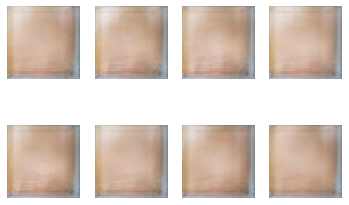

40001 [D loss: 0.584086, acc.: 98.44%, op_acc: 68.91%] [G loss: 1.014928]
40002 [D loss: 0.729506, acc.: 96.88%, op_acc: 67.07%] [G loss: 0.998631]
40003 [D loss: 0.560332, acc.: 100.00%, op_acc: 68.63%] [G loss: 1.000593]
40004 [D loss: 0.604191, acc.: 98.44%, op_acc: 67.89%] [G loss: 0.960168]
40005 [D loss: 0.595786, acc.: 98.44%, op_acc: 66.72%] [G loss: 0.929879]
40006 [D loss: 0.599169, acc.: 98.44%, op_acc: 68.05%] [G loss: 0.966255]
40007 [D loss: 0.583241, acc.: 100.00%, op_acc: 67.62%] [G loss: 0.948589]
40008 [D loss: 0.612078, acc.: 96.88%, op_acc: 68.83%] [G loss: 0.977475]
40009 [D loss: 0.646020, acc.: 98.44%, op_acc: 68.71%] [G loss: 0.945312]
40010 [D loss: 0.632028, acc.: 98.44%, op_acc: 67.93%] [G loss: 0.948826]
40011 [D loss: 0.602173, acc.: 98.44%, op_acc: 67.77%] [G loss: 0.967291]
40012 [D loss: 0.553498, acc.: 100.00%, op_acc: 68.71%] [G loss: 0.995738]
40013 [D loss: 0.585962, acc.: 98.44%, op_acc: 68.52%] [G loss: 0.994921]
40014 [D loss: 0.619274, acc.: 96.8

40113 [D loss: 0.578719, acc.: 100.00%, op_acc: 67.54%] [G loss: 1.011081]
40114 [D loss: 0.566224, acc.: 100.00%, op_acc: 68.36%] [G loss: 1.064000]
40115 [D loss: 0.687909, acc.: 96.88%, op_acc: 67.73%] [G loss: 0.983877]
40116 [D loss: 0.616818, acc.: 100.00%, op_acc: 67.62%] [G loss: 1.011807]
40117 [D loss: 0.591586, acc.: 100.00%, op_acc: 67.42%] [G loss: 0.984377]
40118 [D loss: 0.583461, acc.: 100.00%, op_acc: 67.81%] [G loss: 1.057657]
40119 [D loss: 0.613250, acc.: 98.44%, op_acc: 68.44%] [G loss: 0.963025]
40120 [D loss: 0.604977, acc.: 100.00%, op_acc: 67.70%] [G loss: 1.011297]
40121 [D loss: 0.592662, acc.: 100.00%, op_acc: 68.12%] [G loss: 1.123207]
40122 [D loss: 0.601174, acc.: 100.00%, op_acc: 66.95%] [G loss: 1.042652]
40123 [D loss: 0.576239, acc.: 100.00%, op_acc: 66.72%] [G loss: 1.082001]
40124 [D loss: 0.579308, acc.: 98.44%, op_acc: 68.24%] [G loss: 1.088024]
40125 [D loss: 0.634074, acc.: 98.44%, op_acc: 68.28%] [G loss: 1.074371]
40126 [D loss: 0.615627, acc.

40225 [D loss: 0.857774, acc.: 92.19%, op_acc: 66.87%] [G loss: 1.281580]
40226 [D loss: 0.656473, acc.: 96.88%, op_acc: 66.76%] [G loss: 1.304219]
40227 [D loss: 0.835252, acc.: 92.19%, op_acc: 67.58%] [G loss: 1.156329]
40228 [D loss: 1.078103, acc.: 76.56%, op_acc: 66.05%] [G loss: 1.208241]
40229 [D loss: 0.690384, acc.: 96.88%, op_acc: 66.80%] [G loss: 1.768842]
40230 [D loss: 0.822081, acc.: 92.19%, op_acc: 67.07%] [G loss: 1.165376]
40231 [D loss: 0.784849, acc.: 93.75%, op_acc: 68.48%] [G loss: 1.252313]
40232 [D loss: 0.654258, acc.: 98.44%, op_acc: 67.66%] [G loss: 1.320113]
40233 [D loss: 0.653131, acc.: 100.00%, op_acc: 66.99%] [G loss: 1.435338]
40234 [D loss: 0.724455, acc.: 92.19%, op_acc: 67.38%] [G loss: 1.178257]
40235 [D loss: 0.641611, acc.: 98.44%, op_acc: 67.62%] [G loss: 1.403016]
40236 [D loss: 0.805221, acc.: 90.62%, op_acc: 65.90%] [G loss: 1.313536]
40237 [D loss: 0.652592, acc.: 98.44%, op_acc: 66.87%] [G loss: 1.341263]
40238 [D loss: 0.639397, acc.: 98.44%

40337 [D loss: 0.793408, acc.: 93.75%, op_acc: 66.48%] [G loss: 1.416654]
40338 [D loss: 0.720286, acc.: 92.19%, op_acc: 66.56%] [G loss: 1.476000]
40339 [D loss: 0.805834, acc.: 92.19%, op_acc: 68.55%] [G loss: 1.140411]
40340 [D loss: 0.811359, acc.: 92.19%, op_acc: 66.09%] [G loss: 1.187671]
40341 [D loss: 0.839204, acc.: 92.19%, op_acc: 66.87%] [G loss: 1.104460]
40342 [D loss: 0.872424, acc.: 92.19%, op_acc: 66.13%] [G loss: 1.024744]
40343 [D loss: 1.012736, acc.: 79.69%, op_acc: 67.27%] [G loss: 1.010527]
40344 [D loss: 0.835220, acc.: 93.75%, op_acc: 67.27%] [G loss: 1.036765]
40345 [D loss: 1.225250, acc.: 81.25%, op_acc: 65.47%] [G loss: 0.985663]
40346 [D loss: 0.812629, acc.: 93.75%, op_acc: 66.45%] [G loss: 0.994699]
40347 [D loss: 0.803961, acc.: 95.31%, op_acc: 68.09%] [G loss: 1.008507]
40348 [D loss: 0.815961, acc.: 92.19%, op_acc: 66.91%] [G loss: 1.022831]
40349 [D loss: 0.822405, acc.: 89.06%, op_acc: 68.48%] [G loss: 1.038835]
40350 [D loss: 0.686769, acc.: 100.00%

40449 [D loss: 0.578206, acc.: 98.44%, op_acc: 67.89%] [G loss: 0.973100]
40450 [D loss: 0.567677, acc.: 100.00%, op_acc: 67.66%] [G loss: 0.980965]
40451 [D loss: 0.642133, acc.: 98.44%, op_acc: 66.56%] [G loss: 1.003339]
40452 [D loss: 0.586006, acc.: 100.00%, op_acc: 68.12%] [G loss: 1.019483]
40453 [D loss: 0.613771, acc.: 98.44%, op_acc: 68.32%] [G loss: 0.994264]
40454 [D loss: 0.574675, acc.: 100.00%, op_acc: 68.09%] [G loss: 0.984370]
40455 [D loss: 0.573757, acc.: 100.00%, op_acc: 68.48%] [G loss: 0.998263]
40456 [D loss: 0.572009, acc.: 100.00%, op_acc: 69.69%] [G loss: 0.996416]
40457 [D loss: 0.617811, acc.: 100.00%, op_acc: 67.93%] [G loss: 1.004261]
40458 [D loss: 0.565063, acc.: 100.00%, op_acc: 67.46%] [G loss: 0.983566]
40459 [D loss: 0.567115, acc.: 100.00%, op_acc: 69.10%] [G loss: 1.052659]
40460 [D loss: 0.585250, acc.: 98.44%, op_acc: 68.16%] [G loss: 1.012983]
40461 [D loss: 0.566914, acc.: 100.00%, op_acc: 67.50%] [G loss: 1.020895]
40462 [D loss: 0.570315, acc.

40559 [D loss: 0.672097, acc.: 95.31%, op_acc: 67.23%] [G loss: 0.993201]
40560 [D loss: 0.682885, acc.: 96.88%, op_acc: 67.54%] [G loss: 0.971824]
40561 [D loss: 0.664202, acc.: 96.88%, op_acc: 67.54%] [G loss: 1.088294]
40562 [D loss: 0.640236, acc.: 98.44%, op_acc: 67.46%] [G loss: 0.974692]
40563 [D loss: 0.698587, acc.: 98.44%, op_acc: 67.89%] [G loss: 0.978652]
40564 [D loss: 0.693911, acc.: 96.88%, op_acc: 68.75%] [G loss: 1.085757]
40565 [D loss: 0.874091, acc.: 92.19%, op_acc: 65.82%] [G loss: 0.994121]
40566 [D loss: 0.671305, acc.: 98.44%, op_acc: 67.27%] [G loss: 1.062514]
40567 [D loss: 0.797563, acc.: 89.06%, op_acc: 66.76%] [G loss: 1.086778]
40568 [D loss: 0.723023, acc.: 96.88%, op_acc: 67.66%] [G loss: 1.120127]
40569 [D loss: 0.806541, acc.: 92.19%, op_acc: 66.68%] [G loss: 1.182646]
40570 [D loss: 0.696103, acc.: 96.88%, op_acc: 67.34%] [G loss: 1.238615]
40571 [D loss: 0.730879, acc.: 93.75%, op_acc: 66.48%] [G loss: 1.364605]
40572 [D loss: 0.861523, acc.: 89.06%,

40669 [D loss: 0.555444, acc.: 100.00%, op_acc: 68.63%] [G loss: 1.050460]
40670 [D loss: 0.611503, acc.: 98.44%, op_acc: 66.88%] [G loss: 1.038408]
40671 [D loss: 0.561499, acc.: 100.00%, op_acc: 68.01%] [G loss: 1.075848]
40672 [D loss: 0.541420, acc.: 100.00%, op_acc: 68.40%] [G loss: 1.066526]
40673 [D loss: 0.646957, acc.: 98.44%, op_acc: 67.46%] [G loss: 1.072198]
40674 [D loss: 0.578441, acc.: 100.00%, op_acc: 67.58%] [G loss: 1.037484]
40675 [D loss: 0.548473, acc.: 100.00%, op_acc: 68.32%] [G loss: 1.002997]
40676 [D loss: 0.547430, acc.: 100.00%, op_acc: 67.66%] [G loss: 1.012966]
40677 [D loss: 0.555762, acc.: 100.00%, op_acc: 68.75%] [G loss: 1.001612]
40678 [D loss: 0.556508, acc.: 100.00%, op_acc: 67.62%] [G loss: 1.241983]
40679 [D loss: 0.563379, acc.: 100.00%, op_acc: 67.15%] [G loss: 1.035648]
40680 [D loss: 0.549221, acc.: 100.00%, op_acc: 68.36%] [G loss: 1.046090]
40681 [D loss: 0.536735, acc.: 100.00%, op_acc: 68.98%] [G loss: 1.114058]
40682 [D loss: 0.568288, ac

40779 [D loss: 0.599417, acc.: 98.44%, op_acc: 67.42%] [G loss: 1.025349]
40780 [D loss: 0.559097, acc.: 100.00%, op_acc: 67.58%] [G loss: 1.031361]
40781 [D loss: 0.555498, acc.: 100.00%, op_acc: 67.19%] [G loss: 0.995377]
40782 [D loss: 0.570673, acc.: 98.44%, op_acc: 66.72%] [G loss: 1.022450]
40783 [D loss: 0.579967, acc.: 100.00%, op_acc: 68.28%] [G loss: 1.020343]
40784 [D loss: 0.571823, acc.: 100.00%, op_acc: 68.12%] [G loss: 0.988270]
40785 [D loss: 0.586329, acc.: 98.44%, op_acc: 64.92%] [G loss: 1.081937]
40786 [D loss: 0.552607, acc.: 100.00%, op_acc: 68.55%] [G loss: 1.013318]
40787 [D loss: 0.564267, acc.: 100.00%, op_acc: 67.54%] [G loss: 1.118608]
40788 [D loss: 0.564856, acc.: 100.00%, op_acc: 68.52%] [G loss: 1.001060]
40789 [D loss: 0.574423, acc.: 100.00%, op_acc: 65.31%] [G loss: 1.047206]
40790 [D loss: 0.573292, acc.: 100.00%, op_acc: 68.28%] [G loss: 1.079824]
40791 [D loss: 0.557765, acc.: 100.00%, op_acc: 66.80%] [G loss: 1.096610]
40792 [D loss: 0.557800, acc

40889 [D loss: 0.572116, acc.: 100.00%, op_acc: 67.42%] [G loss: 1.418326]
40890 [D loss: 0.720134, acc.: 96.88%, op_acc: 66.68%] [G loss: 1.355549]
40891 [D loss: 0.610806, acc.: 100.00%, op_acc: 67.81%] [G loss: 1.666106]
40892 [D loss: 0.708624, acc.: 96.88%, op_acc: 66.99%] [G loss: 1.278672]
40893 [D loss: 0.585736, acc.: 100.00%, op_acc: 67.27%] [G loss: 1.879144]
40894 [D loss: 0.560423, acc.: 100.00%, op_acc: 67.93%] [G loss: 1.726335]
40895 [D loss: 0.561886, acc.: 100.00%, op_acc: 67.62%] [G loss: 2.340322]
40896 [D loss: 0.682343, acc.: 96.88%, op_acc: 66.52%] [G loss: 2.008322]
40897 [D loss: 0.644310, acc.: 95.31%, op_acc: 67.97%] [G loss: 3.146303]
40898 [D loss: 0.597576, acc.: 100.00%, op_acc: 67.73%] [G loss: 3.943793]
40899 [D loss: 0.632767, acc.: 96.88%, op_acc: 67.15%] [G loss: 3.535245]
40900 [D loss: 1.134030, acc.: 70.31%, op_acc: 65.94%] [G loss: 8.710589]
40901 [D loss: 1.048114, acc.: 85.94%, op_acc: 62.62%] [G loss: 6.535109]
40902 [D loss: 1.221751, acc.: 6

40999 [D loss: 0.561429, acc.: 100.00%, op_acc: 68.59%] [G loss: 0.925031]
41000 [D loss: 0.578458, acc.: 100.00%, op_acc: 66.29%] [G loss: 0.967109]
(8, 64, 64, 3)


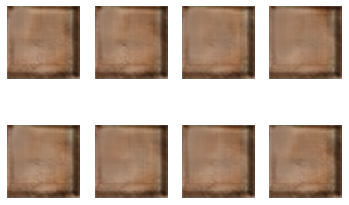

41001 [D loss: 0.552862, acc.: 100.00%, op_acc: 68.87%] [G loss: 0.929377]
41002 [D loss: 0.578386, acc.: 98.44%, op_acc: 67.73%] [G loss: 0.943279]
41003 [D loss: 0.576194, acc.: 98.44%, op_acc: 68.67%] [G loss: 0.931455]
41004 [D loss: 0.571497, acc.: 100.00%, op_acc: 66.84%] [G loss: 0.912981]
41005 [D loss: 0.555553, acc.: 100.00%, op_acc: 68.01%] [G loss: 0.959955]
41006 [D loss: 0.576953, acc.: 98.44%, op_acc: 67.50%] [G loss: 1.017422]
41007 [D loss: 0.642101, acc.: 96.88%, op_acc: 67.23%] [G loss: 1.050878]
41008 [D loss: 0.607970, acc.: 100.00%, op_acc: 66.37%] [G loss: 1.119127]
41009 [D loss: 0.614460, acc.: 100.00%, op_acc: 64.18%] [G loss: 1.137469]
41010 [D loss: 0.613409, acc.: 100.00%, op_acc: 66.95%] [G loss: 1.303956]
41011 [D loss: 0.613315, acc.: 100.00%, op_acc: 67.46%] [G loss: 1.275897]
41012 [D loss: 0.633895, acc.: 98.44%, op_acc: 67.46%] [G loss: 1.182925]
41013 [D loss: 0.670206, acc.: 98.44%, op_acc: 67.34%] [G loss: 1.144684]
41014 [D loss: 0.685394, acc.: 

41113 [D loss: 0.781743, acc.: 98.44%, op_acc: 67.38%] [G loss: 2.560773]
41114 [D loss: 0.752383, acc.: 98.44%, op_acc: 66.72%] [G loss: 2.980560]
41115 [D loss: 0.919405, acc.: 87.50%, op_acc: 66.56%] [G loss: 2.288059]
41116 [D loss: 0.873367, acc.: 92.19%, op_acc: 65.27%] [G loss: 2.845086]
41117 [D loss: 0.776559, acc.: 95.31%, op_acc: 67.38%] [G loss: 2.638741]
41118 [D loss: 1.071679, acc.: 82.81%, op_acc: 68.16%] [G loss: 2.187747]
41119 [D loss: 1.020558, acc.: 85.94%, op_acc: 65.78%] [G loss: 2.022515]
41120 [D loss: 1.087923, acc.: 79.69%, op_acc: 66.48%] [G loss: 2.297355]
41121 [D loss: 0.984690, acc.: 84.38%, op_acc: 66.60%] [G loss: 2.418612]
41122 [D loss: 0.934951, acc.: 92.19%, op_acc: 64.92%] [G loss: 2.462520]
41123 [D loss: 1.042622, acc.: 76.56%, op_acc: 65.98%] [G loss: 2.263535]
41124 [D loss: 1.504658, acc.: 45.31%, op_acc: 65.55%] [G loss: 3.609902]
41125 [D loss: 1.119626, acc.: 76.56%, op_acc: 66.33%] [G loss: 3.603655]
41126 [D loss: 1.194092, acc.: 68.75%,

41225 [D loss: 0.988556, acc.: 82.81%, op_acc: 65.51%] [G loss: 1.210503]
41226 [D loss: 0.790920, acc.: 92.19%, op_acc: 67.15%] [G loss: 1.276348]
41227 [D loss: 0.712132, acc.: 98.44%, op_acc: 65.90%] [G loss: 1.462151]
41228 [D loss: 0.884468, acc.: 90.62%, op_acc: 68.40%] [G loss: 1.290403]
41229 [D loss: 0.871775, acc.: 92.19%, op_acc: 65.70%] [G loss: 1.397473]
41230 [D loss: 0.961462, acc.: 81.25%, op_acc: 67.15%] [G loss: 1.547467]
41231 [D loss: 0.917029, acc.: 81.25%, op_acc: 67.19%] [G loss: 1.495929]
41232 [D loss: 0.871033, acc.: 89.06%, op_acc: 66.80%] [G loss: 1.884902]
41233 [D loss: 0.882931, acc.: 89.06%, op_acc: 66.80%] [G loss: 1.790064]
41234 [D loss: 1.006618, acc.: 85.94%, op_acc: 66.41%] [G loss: 1.597305]
41235 [D loss: 0.823546, acc.: 93.75%, op_acc: 66.52%] [G loss: 1.923681]
41236 [D loss: 0.866919, acc.: 89.06%, op_acc: 66.37%] [G loss: 1.848193]
41237 [D loss: 0.952935, acc.: 85.94%, op_acc: 67.11%] [G loss: 1.801209]
41238 [D loss: 1.202742, acc.: 84.38%,

41337 [D loss: 1.055187, acc.: 87.50%, op_acc: 67.23%] [G loss: 1.235887]
41338 [D loss: 1.259677, acc.: 70.31%, op_acc: 66.02%] [G loss: 1.218130]
41339 [D loss: 1.103560, acc.: 79.69%, op_acc: 65.62%] [G loss: 1.277315]
41340 [D loss: 1.096313, acc.: 84.38%, op_acc: 67.19%] [G loss: 1.210373]
41341 [D loss: 1.107804, acc.: 76.56%, op_acc: 66.29%] [G loss: 1.263345]
41342 [D loss: 0.987436, acc.: 90.62%, op_acc: 67.30%] [G loss: 1.322261]
41343 [D loss: 1.059161, acc.: 82.81%, op_acc: 66.80%] [G loss: 1.240656]
41344 [D loss: 1.012310, acc.: 87.50%, op_acc: 67.70%] [G loss: 1.393427]
41345 [D loss: 0.987766, acc.: 87.50%, op_acc: 65.86%] [G loss: 1.294677]
41346 [D loss: 1.036897, acc.: 84.38%, op_acc: 66.33%] [G loss: 1.264447]
41347 [D loss: 0.988454, acc.: 87.50%, op_acc: 67.23%] [G loss: 1.402759]
41348 [D loss: 0.955265, acc.: 93.75%, op_acc: 66.48%] [G loss: 1.339061]
41349 [D loss: 0.991742, acc.: 82.81%, op_acc: 66.72%] [G loss: 1.363637]
41350 [D loss: 1.090281, acc.: 76.56%,

41449 [D loss: 0.850406, acc.: 92.19%, op_acc: 67.42%] [G loss: 1.010245]
41450 [D loss: 0.892352, acc.: 90.62%, op_acc: 67.81%] [G loss: 0.979982]
41451 [D loss: 0.774146, acc.: 96.88%, op_acc: 66.68%] [G loss: 1.033380]
41452 [D loss: 0.775342, acc.: 95.31%, op_acc: 66.52%] [G loss: 1.039707]
41453 [D loss: 0.736738, acc.: 92.19%, op_acc: 67.66%] [G loss: 0.973709]
41454 [D loss: 0.786439, acc.: 95.31%, op_acc: 67.73%] [G loss: 0.922490]
41455 [D loss: 0.761700, acc.: 95.31%, op_acc: 65.74%] [G loss: 0.963041]
41456 [D loss: 0.723386, acc.: 96.88%, op_acc: 67.46%] [G loss: 0.992817]
41457 [D loss: 0.765545, acc.: 95.31%, op_acc: 66.84%] [G loss: 0.975544]
41458 [D loss: 0.676484, acc.: 98.44%, op_acc: 67.73%] [G loss: 0.933483]
41459 [D loss: 0.702282, acc.: 96.88%, op_acc: 68.55%] [G loss: 0.918150]
41460 [D loss: 0.671642, acc.: 96.88%, op_acc: 70.00%] [G loss: 0.940899]
41461 [D loss: 0.753631, acc.: 93.75%, op_acc: 66.87%] [G loss: 0.917991]
41462 [D loss: 0.644023, acc.: 98.44%,

41561 [D loss: 0.829479, acc.: 95.31%, op_acc: 65.55%] [G loss: 2.066709]
41562 [D loss: 0.793103, acc.: 92.19%, op_acc: 66.99%] [G loss: 1.847251]
41563 [D loss: 0.847062, acc.: 84.38%, op_acc: 68.59%] [G loss: 1.777796]
41564 [D loss: 0.834815, acc.: 89.06%, op_acc: 66.99%] [G loss: 1.950584]
41565 [D loss: 1.233963, acc.: 65.62%, op_acc: 67.34%] [G loss: 1.572371]
41566 [D loss: 1.828685, acc.: 39.06%, op_acc: 65.16%] [G loss: 1.805096]
41567 [D loss: 1.345784, acc.: 65.62%, op_acc: 66.64%] [G loss: 2.250607]
41568 [D loss: 1.446841, acc.: 67.19%, op_acc: 65.12%] [G loss: 2.424225]
41569 [D loss: 1.641824, acc.: 53.12%, op_acc: 64.96%] [G loss: 1.687903]
41570 [D loss: 1.379487, acc.: 67.19%, op_acc: 65.70%] [G loss: 1.706745]
41571 [D loss: 1.285575, acc.: 70.31%, op_acc: 65.27%] [G loss: 1.545612]
41572 [D loss: 1.127053, acc.: 79.69%, op_acc: 67.23%] [G loss: 1.721993]
41573 [D loss: 1.187258, acc.: 75.00%, op_acc: 65.59%] [G loss: 1.649995]
41574 [D loss: 1.108740, acc.: 79.69%,

41673 [D loss: 0.733985, acc.: 95.31%, op_acc: 68.12%] [G loss: 1.410143]
41674 [D loss: 0.777879, acc.: 92.19%, op_acc: 67.11%] [G loss: 1.766512]
41675 [D loss: 0.764601, acc.: 92.19%, op_acc: 65.70%] [G loss: 1.500540]
41676 [D loss: 0.768647, acc.: 95.31%, op_acc: 66.29%] [G loss: 2.019815]
41677 [D loss: 0.671700, acc.: 98.44%, op_acc: 67.03%] [G loss: 3.327098]
41678 [D loss: 1.390107, acc.: 65.62%, op_acc: 65.82%] [G loss: 2.325850]
41679 [D loss: 1.009455, acc.: 82.81%, op_acc: 67.62%] [G loss: 3.456034]
41680 [D loss: 1.170112, acc.: 76.56%, op_acc: 65.00%] [G loss: 3.065412]
41681 [D loss: 0.949397, acc.: 79.69%, op_acc: 67.46%] [G loss: 4.093157]
41682 [D loss: 0.864272, acc.: 87.50%, op_acc: 68.09%] [G loss: 5.257182]
41683 [D loss: 0.911784, acc.: 89.06%, op_acc: 66.02%] [G loss: 4.143224]
41684 [D loss: 0.879368, acc.: 85.94%, op_acc: 65.23%] [G loss: 4.595350]
41685 [D loss: 0.813205, acc.: 89.06%, op_acc: 66.68%] [G loss: 3.747511]
41686 [D loss: 1.685696, acc.: 54.69%,

41785 [D loss: 1.045401, acc.: 84.38%, op_acc: 65.90%] [G loss: 1.401753]
41786 [D loss: 0.923631, acc.: 87.50%, op_acc: 67.19%] [G loss: 1.563578]
41787 [D loss: 0.942259, acc.: 92.19%, op_acc: 66.13%] [G loss: 1.281273]
41788 [D loss: 0.794225, acc.: 90.62%, op_acc: 65.47%] [G loss: 1.236907]
41789 [D loss: 0.716386, acc.: 96.88%, op_acc: 67.38%] [G loss: 1.310637]
41790 [D loss: 0.877227, acc.: 92.19%, op_acc: 65.16%] [G loss: 1.038200]
41791 [D loss: 0.969583, acc.: 85.94%, op_acc: 65.20%] [G loss: 1.016890]
41792 [D loss: 0.835749, acc.: 89.06%, op_acc: 65.86%] [G loss: 1.002929]
41793 [D loss: 0.743053, acc.: 95.31%, op_acc: 68.16%] [G loss: 0.960024]
41794 [D loss: 0.766028, acc.: 96.88%, op_acc: 67.81%] [G loss: 0.955923]
41795 [D loss: 0.763444, acc.: 95.31%, op_acc: 66.33%] [G loss: 0.959029]
41796 [D loss: 0.624884, acc.: 100.00%, op_acc: 68.05%] [G loss: 0.956038]
41797 [D loss: 0.692254, acc.: 96.88%, op_acc: 67.73%] [G loss: 0.960489]
41798 [D loss: 0.714218, acc.: 96.88%

41897 [D loss: 0.837651, acc.: 92.19%, op_acc: 66.02%] [G loss: 1.564612]
41898 [D loss: 0.967594, acc.: 92.19%, op_acc: 65.43%] [G loss: 1.434232]
41899 [D loss: 1.014975, acc.: 87.50%, op_acc: 67.42%] [G loss: 1.257018]
41900 [D loss: 1.035281, acc.: 90.62%, op_acc: 65.31%] [G loss: 1.176070]
41901 [D loss: 0.958784, acc.: 87.50%, op_acc: 67.30%] [G loss: 1.055039]
41902 [D loss: 0.860168, acc.: 87.50%, op_acc: 67.34%] [G loss: 1.145483]
41903 [D loss: 0.914079, acc.: 85.94%, op_acc: 67.50%] [G loss: 1.065041]
41904 [D loss: 0.750584, acc.: 96.88%, op_acc: 66.25%] [G loss: 1.139772]
41905 [D loss: 0.828847, acc.: 90.62%, op_acc: 67.93%] [G loss: 1.018810]
41906 [D loss: 1.047194, acc.: 87.50%, op_acc: 65.04%] [G loss: 1.024788]
41907 [D loss: 0.906006, acc.: 93.75%, op_acc: 63.44%] [G loss: 1.027877]
41908 [D loss: 0.843382, acc.: 90.62%, op_acc: 68.28%] [G loss: 0.968862]
41909 [D loss: 0.863912, acc.: 87.50%, op_acc: 66.45%] [G loss: 1.030226]
41910 [D loss: 0.872630, acc.: 93.75%,

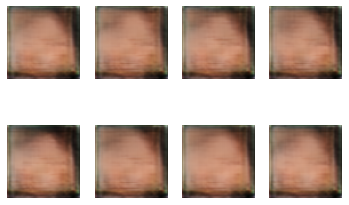

42001 [D loss: 0.706164, acc.: 95.31%, op_acc: 68.71%] [G loss: 1.209899]
42002 [D loss: 0.863964, acc.: 89.06%, op_acc: 66.05%] [G loss: 1.096042]
42003 [D loss: 0.715086, acc.: 95.31%, op_acc: 67.70%] [G loss: 1.066139]
42004 [D loss: 0.654093, acc.: 98.44%, op_acc: 67.30%] [G loss: 1.225336]
42005 [D loss: 0.879357, acc.: 92.19%, op_acc: 68.12%] [G loss: 1.191418]
42006 [D loss: 0.747840, acc.: 93.75%, op_acc: 65.00%] [G loss: 1.132113]
42007 [D loss: 0.677106, acc.: 96.88%, op_acc: 66.87%] [G loss: 1.185042]
42008 [D loss: 0.723015, acc.: 95.31%, op_acc: 67.58%] [G loss: 1.068459]
42009 [D loss: 0.659131, acc.: 98.44%, op_acc: 66.56%] [G loss: 1.057792]
42010 [D loss: 0.801405, acc.: 90.62%, op_acc: 66.29%] [G loss: 1.170006]
42011 [D loss: 0.751611, acc.: 93.75%, op_acc: 65.70%] [G loss: 1.221581]
42012 [D loss: 0.693876, acc.: 98.44%, op_acc: 66.72%] [G loss: 1.167254]
42013 [D loss: 0.680853, acc.: 95.31%, op_acc: 67.27%] [G loss: 1.109711]
42014 [D loss: 0.725584, acc.: 93.75%,

42113 [D loss: 0.875245, acc.: 90.62%, op_acc: 66.60%] [G loss: 1.428879]
42114 [D loss: 1.178122, acc.: 71.88%, op_acc: 65.35%] [G loss: 1.356424]
42115 [D loss: 0.922048, acc.: 87.50%, op_acc: 65.62%] [G loss: 1.464036]
42116 [D loss: 0.884197, acc.: 92.19%, op_acc: 64.88%] [G loss: 1.463765]
42117 [D loss: 0.893290, acc.: 93.75%, op_acc: 66.76%] [G loss: 1.452890]
42118 [D loss: 0.809170, acc.: 93.75%, op_acc: 66.05%] [G loss: 1.528622]
42119 [D loss: 0.830829, acc.: 96.88%, op_acc: 67.77%] [G loss: 1.497545]
42120 [D loss: 0.965680, acc.: 84.38%, op_acc: 66.52%] [G loss: 1.486227]
42121 [D loss: 1.037423, acc.: 79.69%, op_acc: 65.16%] [G loss: 1.442921]
42122 [D loss: 0.984420, acc.: 85.94%, op_acc: 67.30%] [G loss: 1.340941]
42123 [D loss: 0.887381, acc.: 93.75%, op_acc: 69.30%] [G loss: 1.323383]
42124 [D loss: 0.888522, acc.: 95.31%, op_acc: 65.98%] [G loss: 1.322091]
42125 [D loss: 0.948330, acc.: 90.62%, op_acc: 65.86%] [G loss: 1.362212]
42126 [D loss: 0.992732, acc.: 85.94%,

42225 [D loss: 0.912909, acc.: 93.75%, op_acc: 66.02%] [G loss: 1.605188]
42226 [D loss: 0.889220, acc.: 93.75%, op_acc: 66.64%] [G loss: 1.622627]
42227 [D loss: 0.847402, acc.: 92.19%, op_acc: 68.48%] [G loss: 1.561421]
42228 [D loss: 1.017166, acc.: 85.94%, op_acc: 66.29%] [G loss: 1.203731]
42229 [D loss: 1.019292, acc.: 84.38%, op_acc: 67.23%] [G loss: 1.421199]
42230 [D loss: 1.010630, acc.: 87.50%, op_acc: 66.99%] [G loss: 1.219211]
42231 [D loss: 0.943199, acc.: 90.62%, op_acc: 67.34%] [G loss: 1.506337]
42232 [D loss: 0.962801, acc.: 89.06%, op_acc: 66.29%] [G loss: 1.458937]
42233 [D loss: 0.855204, acc.: 89.06%, op_acc: 67.62%] [G loss: 1.511315]
42234 [D loss: 1.002228, acc.: 82.81%, op_acc: 66.64%] [G loss: 1.730545]
42235 [D loss: 1.029463, acc.: 84.38%, op_acc: 66.29%] [G loss: 1.788599]
42236 [D loss: 1.314310, acc.: 73.44%, op_acc: 65.00%] [G loss: 1.411936]
42237 [D loss: 0.978734, acc.: 84.38%, op_acc: 66.29%] [G loss: 1.869411]
42238 [D loss: 1.169059, acc.: 78.12%,

42337 [D loss: 0.607730, acc.: 100.00%, op_acc: 67.54%] [G loss: 0.952390]
42338 [D loss: 0.569547, acc.: 100.00%, op_acc: 67.85%] [G loss: 0.974362]
42339 [D loss: 0.615106, acc.: 98.44%, op_acc: 67.46%] [G loss: 0.957986]
42340 [D loss: 0.635844, acc.: 98.44%, op_acc: 67.11%] [G loss: 0.963367]
42341 [D loss: 0.580333, acc.: 100.00%, op_acc: 66.99%] [G loss: 1.022931]
42342 [D loss: 0.570440, acc.: 100.00%, op_acc: 67.70%] [G loss: 0.949824]
42343 [D loss: 0.660239, acc.: 96.88%, op_acc: 66.84%] [G loss: 0.984339]
42344 [D loss: 0.667881, acc.: 96.88%, op_acc: 69.30%] [G loss: 0.921251]
42345 [D loss: 0.593723, acc.: 100.00%, op_acc: 66.95%] [G loss: 0.940306]
42346 [D loss: 0.616323, acc.: 98.44%, op_acc: 67.50%] [G loss: 0.962482]
42347 [D loss: 0.661111, acc.: 96.88%, op_acc: 67.19%] [G loss: 0.977677]
42348 [D loss: 0.616309, acc.: 98.44%, op_acc: 68.40%] [G loss: 0.962898]
42349 [D loss: 0.639606, acc.: 98.44%, op_acc: 68.40%] [G loss: 0.948649]
42350 [D loss: 0.624466, acc.: 10

42449 [D loss: 0.857292, acc.: 92.19%, op_acc: 67.38%] [G loss: 1.585763]
42450 [D loss: 1.018003, acc.: 82.81%, op_acc: 64.80%] [G loss: 1.609644]
42451 [D loss: 0.944924, acc.: 84.38%, op_acc: 68.55%] [G loss: 1.350738]
42452 [D loss: 0.920324, acc.: 90.62%, op_acc: 66.05%] [G loss: 1.338160]
42453 [D loss: 0.866816, acc.: 92.19%, op_acc: 66.72%] [G loss: 1.437725]
42454 [D loss: 0.906893, acc.: 87.50%, op_acc: 66.56%] [G loss: 1.287670]
42455 [D loss: 0.860984, acc.: 90.62%, op_acc: 66.45%] [G loss: 1.425200]
42456 [D loss: 0.883476, acc.: 93.75%, op_acc: 66.25%] [G loss: 1.435891]
42457 [D loss: 1.046037, acc.: 82.81%, op_acc: 64.14%] [G loss: 1.375728]
42458 [D loss: 0.914376, acc.: 87.50%, op_acc: 64.69%] [G loss: 1.540864]
42459 [D loss: 1.188266, acc.: 78.12%, op_acc: 65.12%] [G loss: 2.080793]
42460 [D loss: 0.982805, acc.: 81.25%, op_acc: 66.02%] [G loss: 2.572948]
42461 [D loss: 0.931047, acc.: 89.06%, op_acc: 65.12%] [G loss: 2.329515]
42462 [D loss: 0.928525, acc.: 85.94%,

42561 [D loss: 0.817238, acc.: 95.31%, op_acc: 68.91%] [G loss: 1.019082]
42562 [D loss: 0.808426, acc.: 92.19%, op_acc: 66.33%] [G loss: 1.059395]
42563 [D loss: 0.771565, acc.: 95.31%, op_acc: 65.78%] [G loss: 1.002138]
42564 [D loss: 0.732377, acc.: 96.88%, op_acc: 67.46%] [G loss: 0.984897]
42565 [D loss: 0.666741, acc.: 100.00%, op_acc: 68.32%] [G loss: 0.985692]
42566 [D loss: 0.775695, acc.: 92.19%, op_acc: 67.07%] [G loss: 0.980818]
42567 [D loss: 0.723117, acc.: 98.44%, op_acc: 67.50%] [G loss: 0.936643]
42568 [D loss: 0.707248, acc.: 96.88%, op_acc: 67.62%] [G loss: 0.927741]
42569 [D loss: 0.700656, acc.: 96.88%, op_acc: 68.12%] [G loss: 0.939880]
42570 [D loss: 0.744388, acc.: 93.75%, op_acc: 67.03%] [G loss: 0.917106]
42571 [D loss: 0.721395, acc.: 95.31%, op_acc: 66.91%] [G loss: 0.956508]
42572 [D loss: 0.708411, acc.: 95.31%, op_acc: 69.41%] [G loss: 0.884926]
42573 [D loss: 0.670213, acc.: 98.44%, op_acc: 67.34%] [G loss: 0.997618]
42574 [D loss: 0.717995, acc.: 95.31%

42673 [D loss: 0.817221, acc.: 93.75%, op_acc: 67.03%] [G loss: 1.107232]
42674 [D loss: 0.911483, acc.: 92.19%, op_acc: 67.30%] [G loss: 1.110294]
42675 [D loss: 0.800497, acc.: 95.31%, op_acc: 68.16%] [G loss: 1.132873]
42676 [D loss: 0.838641, acc.: 93.75%, op_acc: 66.52%] [G loss: 1.108534]
42677 [D loss: 0.779783, acc.: 95.31%, op_acc: 67.27%] [G loss: 1.120396]
42678 [D loss: 0.796858, acc.: 96.88%, op_acc: 68.44%] [G loss: 1.099176]
42679 [D loss: 0.876453, acc.: 92.19%, op_acc: 66.91%] [G loss: 1.101959]
42680 [D loss: 0.785636, acc.: 95.31%, op_acc: 66.33%] [G loss: 1.133479]
42681 [D loss: 0.824946, acc.: 93.75%, op_acc: 67.19%] [G loss: 1.132440]
42682 [D loss: 0.854866, acc.: 90.62%, op_acc: 68.24%] [G loss: 1.089502]
42683 [D loss: 0.767705, acc.: 98.44%, op_acc: 68.59%] [G loss: 1.080003]
42684 [D loss: 0.747822, acc.: 96.88%, op_acc: 67.15%] [G loss: 1.139889]
42685 [D loss: 0.700970, acc.: 96.88%, op_acc: 67.85%] [G loss: 1.155605]
42686 [D loss: 0.834112, acc.: 93.75%,

42785 [D loss: 1.100649, acc.: 82.81%, op_acc: 66.56%] [G loss: 1.547351]
42786 [D loss: 1.269184, acc.: 59.38%, op_acc: 66.33%] [G loss: 1.480977]
42787 [D loss: 1.105515, acc.: 82.81%, op_acc: 66.37%] [G loss: 1.487255]
42788 [D loss: 1.138918, acc.: 75.00%, op_acc: 66.87%] [G loss: 1.565651]
42789 [D loss: 1.146168, acc.: 76.56%, op_acc: 66.84%] [G loss: 1.581153]
42790 [D loss: 1.156188, acc.: 81.25%, op_acc: 66.76%] [G loss: 1.443681]
42791 [D loss: 1.178390, acc.: 71.88%, op_acc: 63.67%] [G loss: 1.629919]
42792 [D loss: 1.141184, acc.: 82.81%, op_acc: 65.08%] [G loss: 1.497885]
42793 [D loss: 1.240933, acc.: 67.19%, op_acc: 67.46%] [G loss: 1.482810]
42794 [D loss: 1.039933, acc.: 79.69%, op_acc: 66.02%] [G loss: 1.492211]
42795 [D loss: 1.022068, acc.: 81.25%, op_acc: 65.98%] [G loss: 1.561753]
42796 [D loss: 1.141651, acc.: 75.00%, op_acc: 66.95%] [G loss: 1.540433]
42797 [D loss: 1.176388, acc.: 73.44%, op_acc: 65.51%] [G loss: 1.389890]
42798 [D loss: 1.093330, acc.: 78.12%,

42897 [D loss: 1.155648, acc.: 78.12%, op_acc: 66.76%] [G loss: 1.314914]
42898 [D loss: 1.182885, acc.: 76.56%, op_acc: 65.94%] [G loss: 1.285268]
42899 [D loss: 1.277685, acc.: 68.75%, op_acc: 67.38%] [G loss: 1.192990]
42900 [D loss: 1.140369, acc.: 73.44%, op_acc: 66.60%] [G loss: 1.182664]
42901 [D loss: 1.253669, acc.: 65.62%, op_acc: 65.70%] [G loss: 1.192216]
42902 [D loss: 1.174125, acc.: 78.12%, op_acc: 67.54%] [G loss: 1.186009]
42903 [D loss: 1.076972, acc.: 78.12%, op_acc: 65.86%] [G loss: 1.309161]
42904 [D loss: 1.168775, acc.: 81.25%, op_acc: 66.37%] [G loss: 1.211007]
42905 [D loss: 1.081981, acc.: 84.38%, op_acc: 65.12%] [G loss: 1.201240]
42906 [D loss: 1.153604, acc.: 71.88%, op_acc: 67.81%] [G loss: 1.258286]
42907 [D loss: 1.090470, acc.: 81.25%, op_acc: 67.03%] [G loss: 1.296923]
42908 [D loss: 1.047683, acc.: 85.94%, op_acc: 66.80%] [G loss: 1.250015]
42909 [D loss: 1.126382, acc.: 78.12%, op_acc: 66.72%] [G loss: 1.236639]
42910 [D loss: 1.036315, acc.: 89.06%,

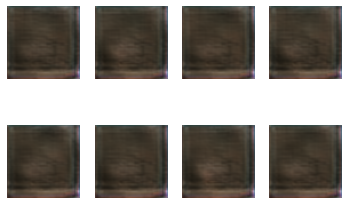

43001 [D loss: 1.547842, acc.: 56.25%, op_acc: 65.16%] [G loss: 1.795774]
43002 [D loss: 1.547468, acc.: 51.56%, op_acc: 64.38%] [G loss: 1.775551]
43003 [D loss: 1.297235, acc.: 68.75%, op_acc: 65.74%] [G loss: 1.809171]
43004 [D loss: 1.358341, acc.: 60.94%, op_acc: 68.52%] [G loss: 1.827895]
43005 [D loss: 1.165737, acc.: 73.44%, op_acc: 67.97%] [G loss: 1.915246]
43006 [D loss: 1.098221, acc.: 82.81%, op_acc: 66.91%] [G loss: 2.019661]
43007 [D loss: 1.106283, acc.: 79.69%, op_acc: 65.08%] [G loss: 1.955331]
43008 [D loss: 1.187443, acc.: 78.12%, op_acc: 67.07%] [G loss: 2.015866]
43009 [D loss: 1.112762, acc.: 75.00%, op_acc: 66.95%] [G loss: 2.080338]
43010 [D loss: 1.101310, acc.: 79.69%, op_acc: 67.62%] [G loss: 2.018715]
43011 [D loss: 1.217802, acc.: 73.44%, op_acc: 66.41%] [G loss: 2.003520]
43012 [D loss: 1.328089, acc.: 56.25%, op_acc: 65.59%] [G loss: 1.905634]
43013 [D loss: 1.235113, acc.: 70.31%, op_acc: 66.29%] [G loss: 1.742480]
43014 [D loss: 1.270214, acc.: 64.06%,

43112 [D loss: 0.686201, acc.: 96.88%, op_acc: 65.86%] [G loss: 1.509379]
43113 [D loss: 0.788991, acc.: 93.75%, op_acc: 66.25%] [G loss: 1.253610]
43114 [D loss: 0.876865, acc.: 92.19%, op_acc: 66.05%] [G loss: 1.192068]
43115 [D loss: 0.760690, acc.: 92.19%, op_acc: 68.01%] [G loss: 1.279691]
43116 [D loss: 0.746742, acc.: 95.31%, op_acc: 66.37%] [G loss: 1.354892]
43117 [D loss: 0.654780, acc.: 100.00%, op_acc: 67.97%] [G loss: 1.605818]
43118 [D loss: 0.828262, acc.: 93.75%, op_acc: 66.13%] [G loss: 1.390314]
43119 [D loss: 0.768938, acc.: 95.31%, op_acc: 66.87%] [G loss: 1.934628]
43120 [D loss: 0.721783, acc.: 95.31%, op_acc: 66.64%] [G loss: 2.090126]
43121 [D loss: 0.830199, acc.: 90.62%, op_acc: 66.72%] [G loss: 2.152721]
43122 [D loss: 0.969442, acc.: 89.06%, op_acc: 64.69%] [G loss: 2.221221]
43123 [D loss: 0.978106, acc.: 81.25%, op_acc: 66.72%] [G loss: 2.812284]
43124 [D loss: 1.094759, acc.: 76.56%, op_acc: 68.95%] [G loss: 3.169194]
43125 [D loss: 1.373848, acc.: 65.62%

43224 [D loss: 0.782018, acc.: 95.31%, op_acc: 67.11%] [G loss: 0.956107]
43225 [D loss: 0.681153, acc.: 93.75%, op_acc: 67.58%] [G loss: 0.958970]
43226 [D loss: 0.602150, acc.: 100.00%, op_acc: 66.87%] [G loss: 0.980717]
43227 [D loss: 0.610496, acc.: 98.44%, op_acc: 68.20%] [G loss: 0.953942]
43228 [D loss: 0.655418, acc.: 96.88%, op_acc: 68.05%] [G loss: 0.946193]
43229 [D loss: 0.617150, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.975057]
43230 [D loss: 0.729412, acc.: 96.88%, op_acc: 64.10%] [G loss: 0.964921]
43231 [D loss: 0.632623, acc.: 100.00%, op_acc: 68.12%] [G loss: 0.970411]
43232 [D loss: 0.749426, acc.: 96.88%, op_acc: 67.23%] [G loss: 1.003939]
43233 [D loss: 0.599506, acc.: 100.00%, op_acc: 67.38%] [G loss: 0.998976]
43234 [D loss: 0.605609, acc.: 100.00%, op_acc: 67.15%] [G loss: 1.018981]
43235 [D loss: 0.587369, acc.: 100.00%, op_acc: 67.81%] [G loss: 0.999659]
43236 [D loss: 0.659183, acc.: 96.88%, op_acc: 65.08%] [G loss: 1.210028]
43237 [D loss: 0.645754, acc.: 9

43336 [D loss: 0.583961, acc.: 98.44%, op_acc: 67.70%] [G loss: 1.124685]
43337 [D loss: 0.601558, acc.: 98.44%, op_acc: 67.34%] [G loss: 1.094956]
43338 [D loss: 0.603346, acc.: 100.00%, op_acc: 67.66%] [G loss: 1.151839]
43339 [D loss: 0.572983, acc.: 100.00%, op_acc: 67.66%] [G loss: 1.150031]
43340 [D loss: 0.615380, acc.: 98.44%, op_acc: 67.15%] [G loss: 1.110001]
43341 [D loss: 0.638718, acc.: 98.44%, op_acc: 66.02%] [G loss: 1.100405]
43342 [D loss: 0.654064, acc.: 98.44%, op_acc: 66.84%] [G loss: 1.070519]
43343 [D loss: 0.653283, acc.: 96.88%, op_acc: 66.91%] [G loss: 1.147144]
43344 [D loss: 0.603145, acc.: 100.00%, op_acc: 65.62%] [G loss: 1.208297]
43345 [D loss: 0.623563, acc.: 98.44%, op_acc: 68.05%] [G loss: 1.091691]
43346 [D loss: 0.584200, acc.: 100.00%, op_acc: 67.89%] [G loss: 1.170580]
43347 [D loss: 0.655137, acc.: 95.31%, op_acc: 66.80%] [G loss: 1.177183]
43348 [D loss: 0.777928, acc.: 95.31%, op_acc: 66.52%] [G loss: 1.076177]
43349 [D loss: 0.593826, acc.: 100

43448 [D loss: 0.630381, acc.: 98.44%, op_acc: 66.29%] [G loss: 0.988974]
43449 [D loss: 0.591787, acc.: 100.00%, op_acc: 66.21%] [G loss: 1.082105]
43450 [D loss: 0.607959, acc.: 98.44%, op_acc: 68.63%] [G loss: 0.994146]
43451 [D loss: 0.582187, acc.: 100.00%, op_acc: 68.32%] [G loss: 0.984676]
43452 [D loss: 0.603257, acc.: 100.00%, op_acc: 67.73%] [G loss: 0.990836]
43453 [D loss: 0.602562, acc.: 98.44%, op_acc: 67.70%] [G loss: 1.070431]
43454 [D loss: 0.674209, acc.: 96.88%, op_acc: 66.99%] [G loss: 0.977802]
43455 [D loss: 0.745273, acc.: 92.19%, op_acc: 68.28%] [G loss: 0.978346]
43456 [D loss: 0.670646, acc.: 98.44%, op_acc: 68.12%] [G loss: 0.966837]
43457 [D loss: 0.648456, acc.: 100.00%, op_acc: 66.41%] [G loss: 1.026034]
43458 [D loss: 0.690751, acc.: 95.31%, op_acc: 67.07%] [G loss: 1.106501]
43459 [D loss: 0.601913, acc.: 98.44%, op_acc: 69.10%] [G loss: 1.062051]
43460 [D loss: 0.653708, acc.: 98.44%, op_acc: 67.27%] [G loss: 1.071334]
43461 [D loss: 0.859409, acc.: 92.

43560 [D loss: 1.317863, acc.: 62.50%, op_acc: 63.40%] [G loss: 1.178936]
43561 [D loss: 0.855845, acc.: 92.19%, op_acc: 65.08%] [G loss: 1.242538]
43562 [D loss: 1.010452, acc.: 84.38%, op_acc: 66.88%] [G loss: 1.057740]
43563 [D loss: 1.109949, acc.: 64.06%, op_acc: 67.19%] [G loss: 1.078370]
43564 [D loss: 1.024391, acc.: 84.38%, op_acc: 67.07%] [G loss: 1.108356]
43565 [D loss: 0.923416, acc.: 89.06%, op_acc: 66.68%] [G loss: 1.184040]
43566 [D loss: 0.915175, acc.: 89.06%, op_acc: 67.15%] [G loss: 1.235024]
43567 [D loss: 1.054756, acc.: 81.25%, op_acc: 65.98%] [G loss: 1.191088]
43568 [D loss: 0.991059, acc.: 90.62%, op_acc: 65.78%] [G loss: 1.169960]
43569 [D loss: 0.822242, acc.: 96.88%, op_acc: 67.77%] [G loss: 1.217317]
43570 [D loss: 0.860868, acc.: 90.62%, op_acc: 66.88%] [G loss: 1.201154]
43571 [D loss: 0.901062, acc.: 90.62%, op_acc: 67.30%] [G loss: 1.086885]
43572 [D loss: 0.939181, acc.: 87.50%, op_acc: 67.81%] [G loss: 1.108910]
43573 [D loss: 0.755013, acc.: 98.44%,

43672 [D loss: 0.846934, acc.: 92.19%, op_acc: 66.41%] [G loss: 1.074873]
43673 [D loss: 0.887632, acc.: 89.06%, op_acc: 67.77%] [G loss: 1.020067]
43674 [D loss: 0.695840, acc.: 96.88%, op_acc: 69.10%] [G loss: 1.077499]
43675 [D loss: 0.868593, acc.: 90.62%, op_acc: 65.04%] [G loss: 1.049413]
43676 [D loss: 0.864504, acc.: 90.62%, op_acc: 67.54%] [G loss: 1.014635]
43677 [D loss: 0.780002, acc.: 90.62%, op_acc: 69.26%] [G loss: 1.011710]
43678 [D loss: 0.868631, acc.: 92.19%, op_acc: 67.93%] [G loss: 0.994847]
43679 [D loss: 0.886496, acc.: 87.50%, op_acc: 66.02%] [G loss: 1.066765]
43680 [D loss: 0.838117, acc.: 90.62%, op_acc: 66.17%] [G loss: 1.061584]
43681 [D loss: 0.774507, acc.: 92.19%, op_acc: 68.63%] [G loss: 1.026202]
43682 [D loss: 1.025361, acc.: 85.94%, op_acc: 66.48%] [G loss: 0.986707]
43683 [D loss: 0.861192, acc.: 93.75%, op_acc: 65.31%] [G loss: 1.017654]
43684 [D loss: 0.822984, acc.: 90.62%, op_acc: 68.05%] [G loss: 1.045557]
43685 [D loss: 0.763997, acc.: 95.31%,

43784 [D loss: 0.923270, acc.: 93.75%, op_acc: 67.23%] [G loss: 1.034633]
43785 [D loss: 0.930077, acc.: 85.94%, op_acc: 65.86%] [G loss: 1.073364]
43786 [D loss: 0.884073, acc.: 89.06%, op_acc: 67.38%] [G loss: 1.024335]
43787 [D loss: 0.754733, acc.: 96.88%, op_acc: 66.80%] [G loss: 1.082759]
43788 [D loss: 0.819040, acc.: 93.75%, op_acc: 66.87%] [G loss: 1.081599]
43789 [D loss: 0.734878, acc.: 95.31%, op_acc: 69.02%] [G loss: 1.018980]
43790 [D loss: 0.764292, acc.: 95.31%, op_acc: 68.95%] [G loss: 0.996168]
43791 [D loss: 0.727332, acc.: 95.31%, op_acc: 65.70%] [G loss: 1.024254]
43792 [D loss: 0.697419, acc.: 95.31%, op_acc: 67.15%] [G loss: 1.051371]
43793 [D loss: 0.710239, acc.: 96.88%, op_acc: 68.05%] [G loss: 1.024600]
43794 [D loss: 0.618950, acc.: 100.00%, op_acc: 68.36%] [G loss: 1.048944]
43795 [D loss: 0.615876, acc.: 100.00%, op_acc: 68.48%] [G loss: 1.031334]
43796 [D loss: 0.637307, acc.: 98.44%, op_acc: 67.03%] [G loss: 1.062449]
43797 [D loss: 0.728934, acc.: 93.75

43896 [D loss: 1.037451, acc.: 89.06%, op_acc: 66.17%] [G loss: 1.583652]
43897 [D loss: 0.895281, acc.: 90.62%, op_acc: 67.46%] [G loss: 1.297373]
43898 [D loss: 0.865206, acc.: 92.19%, op_acc: 67.03%] [G loss: 1.432041]
43899 [D loss: 0.787778, acc.: 90.62%, op_acc: 66.64%] [G loss: 1.737390]
43900 [D loss: 0.673301, acc.: 96.88%, op_acc: 66.87%] [G loss: 1.503592]
43901 [D loss: 0.904730, acc.: 87.50%, op_acc: 66.33%] [G loss: 1.390109]
43902 [D loss: 0.804835, acc.: 90.62%, op_acc: 67.85%] [G loss: 1.178735]
43903 [D loss: 0.653347, acc.: 96.88%, op_acc: 65.62%] [G loss: 1.067887]
43904 [D loss: 0.648199, acc.: 98.44%, op_acc: 68.83%] [G loss: 1.166249]
43905 [D loss: 0.655064, acc.: 98.44%, op_acc: 67.70%] [G loss: 1.097173]
43906 [D loss: 0.775467, acc.: 95.31%, op_acc: 67.66%] [G loss: 1.134653]
43907 [D loss: 0.788937, acc.: 92.19%, op_acc: 66.64%] [G loss: 1.020899]
43908 [D loss: 0.725504, acc.: 96.88%, op_acc: 66.37%] [G loss: 1.132869]
43909 [D loss: 0.635716, acc.: 98.44%,

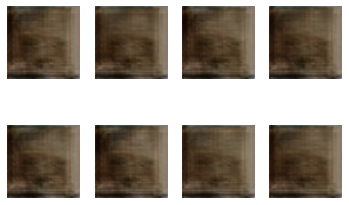

44001 [D loss: 0.644686, acc.: 96.88%, op_acc: 67.97%] [G loss: 0.978711]
44002 [D loss: 0.579416, acc.: 100.00%, op_acc: 69.22%] [G loss: 1.011804]
44003 [D loss: 0.581562, acc.: 100.00%, op_acc: 68.28%] [G loss: 0.960494]
44004 [D loss: 0.565605, acc.: 100.00%, op_acc: 67.50%] [G loss: 0.956315]
44005 [D loss: 0.545532, acc.: 100.00%, op_acc: 68.98%] [G loss: 1.030667]
44006 [D loss: 0.704934, acc.: 95.31%, op_acc: 67.11%] [G loss: 0.997739]
44007 [D loss: 0.561227, acc.: 100.00%, op_acc: 69.65%] [G loss: 0.977944]
44008 [D loss: 0.615813, acc.: 98.44%, op_acc: 67.97%] [G loss: 0.990095]
44009 [D loss: 0.588222, acc.: 98.44%, op_acc: 66.68%] [G loss: 0.986002]
44010 [D loss: 0.642165, acc.: 98.44%, op_acc: 67.62%] [G loss: 0.971810]
44011 [D loss: 0.563398, acc.: 100.00%, op_acc: 69.14%] [G loss: 1.027392]
44012 [D loss: 0.586235, acc.: 100.00%, op_acc: 66.91%] [G loss: 0.985905]
44013 [D loss: 0.629420, acc.: 98.44%, op_acc: 66.21%] [G loss: 0.955863]
44014 [D loss: 0.570822, acc.: 

44113 [D loss: 0.633289, acc.: 100.00%, op_acc: 66.21%] [G loss: 1.051992]
44114 [D loss: 0.609808, acc.: 100.00%, op_acc: 68.83%] [G loss: 1.003382]
44115 [D loss: 0.608613, acc.: 100.00%, op_acc: 67.58%] [G loss: 1.045853]
44116 [D loss: 0.689006, acc.: 96.88%, op_acc: 65.86%] [G loss: 0.990008]
44117 [D loss: 0.615331, acc.: 100.00%, op_acc: 67.58%] [G loss: 0.971969]
44118 [D loss: 0.619151, acc.: 98.44%, op_acc: 68.09%] [G loss: 0.988770]
44119 [D loss: 0.617534, acc.: 100.00%, op_acc: 66.95%] [G loss: 1.017509]
44120 [D loss: 0.610092, acc.: 98.44%, op_acc: 66.09%] [G loss: 0.975733]
44121 [D loss: 0.612622, acc.: 100.00%, op_acc: 67.27%] [G loss: 1.019453]
44122 [D loss: 0.628811, acc.: 100.00%, op_acc: 68.71%] [G loss: 1.000721]
44123 [D loss: 0.673549, acc.: 95.31%, op_acc: 69.77%] [G loss: 0.995948]
44124 [D loss: 0.601544, acc.: 98.44%, op_acc: 69.10%] [G loss: 1.066060]
44125 [D loss: 0.670239, acc.: 96.88%, op_acc: 67.34%] [G loss: 1.010108]
44126 [D loss: 0.599446, acc.: 

44223 [D loss: 0.620881, acc.: 98.44%, op_acc: 67.89%] [G loss: 1.059923]
44224 [D loss: 0.635495, acc.: 96.88%, op_acc: 67.42%] [G loss: 1.042206]
44225 [D loss: 0.616908, acc.: 100.00%, op_acc: 68.12%] [G loss: 1.062754]
44226 [D loss: 0.640012, acc.: 100.00%, op_acc: 68.63%] [G loss: 1.032476]
44227 [D loss: 0.592300, acc.: 98.44%, op_acc: 68.75%] [G loss: 1.031583]
44228 [D loss: 0.577393, acc.: 100.00%, op_acc: 70.12%] [G loss: 1.008347]
44229 [D loss: 0.621833, acc.: 100.00%, op_acc: 67.66%] [G loss: 1.061106]
44230 [D loss: 0.629267, acc.: 98.44%, op_acc: 67.54%] [G loss: 1.034869]
44231 [D loss: 0.585274, acc.: 98.44%, op_acc: 69.45%] [G loss: 1.040818]
44232 [D loss: 0.588725, acc.: 100.00%, op_acc: 68.20%] [G loss: 1.086355]
44233 [D loss: 0.632312, acc.: 96.88%, op_acc: 68.67%] [G loss: 1.059169]
44234 [D loss: 0.575689, acc.: 100.00%, op_acc: 68.44%] [G loss: 1.038759]
44235 [D loss: 0.616840, acc.: 98.44%, op_acc: 68.28%] [G loss: 1.045167]
44236 [D loss: 0.647126, acc.: 9

44335 [D loss: 0.917003, acc.: 89.06%, op_acc: 66.60%] [G loss: 1.629166]
44336 [D loss: 0.845199, acc.: 95.31%, op_acc: 66.72%] [G loss: 1.631984]
44337 [D loss: 0.944265, acc.: 89.06%, op_acc: 65.62%] [G loss: 1.278028]
44338 [D loss: 1.010955, acc.: 87.50%, op_acc: 65.35%] [G loss: 1.281049]
44339 [D loss: 0.922002, acc.: 89.06%, op_acc: 66.02%] [G loss: 1.447800]
44340 [D loss: 0.964968, acc.: 89.06%, op_acc: 66.87%] [G loss: 1.268888]
44341 [D loss: 0.885523, acc.: 93.75%, op_acc: 67.11%] [G loss: 1.119911]
44342 [D loss: 0.844210, acc.: 93.75%, op_acc: 67.70%] [G loss: 1.186894]
44343 [D loss: 0.921402, acc.: 90.62%, op_acc: 65.70%] [G loss: 1.205094]
44344 [D loss: 0.715010, acc.: 96.88%, op_acc: 66.56%] [G loss: 1.173010]
44345 [D loss: 0.767360, acc.: 96.88%, op_acc: 67.93%] [G loss: 1.112380]
44346 [D loss: 0.765164, acc.: 95.31%, op_acc: 67.27%] [G loss: 1.012865]
44347 [D loss: 0.780394, acc.: 93.75%, op_acc: 66.76%] [G loss: 1.062859]
44348 [D loss: 0.724548, acc.: 96.88%,

44447 [D loss: 0.600131, acc.: 98.44%, op_acc: 67.23%] [G loss: 1.048776]
44448 [D loss: 0.547088, acc.: 100.00%, op_acc: 68.91%] [G loss: 1.190001]
44449 [D loss: 0.572400, acc.: 98.44%, op_acc: 67.03%] [G loss: 1.203543]
44450 [D loss: 0.573444, acc.: 98.44%, op_acc: 69.61%] [G loss: 1.040332]
44451 [D loss: 0.561255, acc.: 100.00%, op_acc: 69.26%] [G loss: 1.096631]
44452 [D loss: 0.675818, acc.: 95.31%, op_acc: 67.42%] [G loss: 1.069385]
44453 [D loss: 0.606650, acc.: 98.44%, op_acc: 68.48%] [G loss: 1.141698]
44454 [D loss: 0.618219, acc.: 96.88%, op_acc: 67.30%] [G loss: 1.289283]
44455 [D loss: 0.636498, acc.: 98.44%, op_acc: 65.98%] [G loss: 1.109917]
44456 [D loss: 0.671592, acc.: 95.31%, op_acc: 67.73%] [G loss: 1.106885]
44457 [D loss: 0.608593, acc.: 98.44%, op_acc: 67.85%] [G loss: 1.207811]
44458 [D loss: 0.591919, acc.: 100.00%, op_acc: 66.95%] [G loss: 1.080468]
44459 [D loss: 0.580528, acc.: 100.00%, op_acc: 67.27%] [G loss: 1.204874]
44460 [D loss: 0.739286, acc.: 95.

44559 [D loss: 1.315332, acc.: 70.31%, op_acc: 65.00%] [G loss: 1.335729]
44560 [D loss: 0.842488, acc.: 95.31%, op_acc: 66.17%] [G loss: 1.389364]
44561 [D loss: 0.938483, acc.: 87.50%, op_acc: 67.19%] [G loss: 1.313025]
44562 [D loss: 0.875165, acc.: 92.19%, op_acc: 67.85%] [G loss: 1.184614]
44563 [D loss: 1.208352, acc.: 78.12%, op_acc: 63.52%] [G loss: 1.142645]
44564 [D loss: 1.019029, acc.: 76.56%, op_acc: 66.91%] [G loss: 1.136966]
44565 [D loss: 0.864109, acc.: 92.19%, op_acc: 68.83%] [G loss: 1.287784]
44566 [D loss: 0.760602, acc.: 95.31%, op_acc: 67.30%] [G loss: 1.327355]
44567 [D loss: 1.049327, acc.: 82.81%, op_acc: 65.66%] [G loss: 1.170001]
44568 [D loss: 0.793684, acc.: 93.75%, op_acc: 66.21%] [G loss: 1.182291]
44569 [D loss: 0.847888, acc.: 92.19%, op_acc: 66.72%] [G loss: 1.228325]
44570 [D loss: 0.842214, acc.: 90.62%, op_acc: 65.51%] [G loss: 1.248628]
44571 [D loss: 0.734638, acc.: 96.88%, op_acc: 68.01%] [G loss: 1.214856]
44572 [D loss: 0.740848, acc.: 96.88%,

44671 [D loss: 1.246287, acc.: 89.06%, op_acc: 63.55%] [G loss: 1.504384]
44672 [D loss: 1.179754, acc.: 71.88%, op_acc: 65.55%] [G loss: 1.623957]
44673 [D loss: 1.000413, acc.: 84.38%, op_acc: 66.21%] [G loss: 1.339253]
44674 [D loss: 1.244743, acc.: 65.62%, op_acc: 64.02%] [G loss: 1.344078]
44675 [D loss: 1.182448, acc.: 71.88%, op_acc: 65.04%] [G loss: 1.296594]
44676 [D loss: 1.385758, acc.: 60.94%, op_acc: 66.09%] [G loss: 1.395653]
44677 [D loss: 1.278226, acc.: 57.81%, op_acc: 67.15%] [G loss: 1.453144]
44678 [D loss: 1.109877, acc.: 68.75%, op_acc: 67.50%] [G loss: 1.497683]
44679 [D loss: 1.226275, acc.: 65.62%, op_acc: 66.87%] [G loss: 1.518313]
44680 [D loss: 1.355433, acc.: 59.38%, op_acc: 67.30%] [G loss: 1.550676]
44681 [D loss: 1.955315, acc.: 28.12%, op_acc: 64.30%] [G loss: 1.857923]
44682 [D loss: 1.419221, acc.: 59.38%, op_acc: 64.92%] [G loss: 2.172900]
44683 [D loss: 1.195308, acc.: 67.19%, op_acc: 67.54%] [G loss: 2.394826]
44684 [D loss: 1.412948, acc.: 57.81%,

44783 [D loss: 0.830818, acc.: 96.88%, op_acc: 66.84%] [G loss: 1.230207]
44784 [D loss: 0.880213, acc.: 93.75%, op_acc: 66.29%] [G loss: 1.028395]
44785 [D loss: 0.658602, acc.: 100.00%, op_acc: 66.87%] [G loss: 1.377354]
44786 [D loss: 0.765549, acc.: 95.31%, op_acc: 66.41%] [G loss: 1.246821]
44787 [D loss: 0.831071, acc.: 92.19%, op_acc: 66.84%] [G loss: 1.300510]
44788 [D loss: 0.918098, acc.: 90.62%, op_acc: 66.05%] [G loss: 1.227685]
44789 [D loss: 0.832232, acc.: 90.62%, op_acc: 65.27%] [G loss: 1.274274]
44790 [D loss: 1.375615, acc.: 59.38%, op_acc: 65.27%] [G loss: 1.230884]
44791 [D loss: 1.082442, acc.: 81.25%, op_acc: 67.23%] [G loss: 1.437016]
44792 [D loss: 0.933155, acc.: 89.06%, op_acc: 67.93%] [G loss: 1.251846]
44793 [D loss: 1.084073, acc.: 75.00%, op_acc: 68.91%] [G loss: 1.540295]
44794 [D loss: 0.873931, acc.: 93.75%, op_acc: 67.38%] [G loss: 1.573329]
44795 [D loss: 1.327440, acc.: 64.06%, op_acc: 66.21%] [G loss: 1.703315]
44796 [D loss: 0.935719, acc.: 81.25%

44895 [D loss: 1.182553, acc.: 73.44%, op_acc: 66.95%] [G loss: 1.452942]
44896 [D loss: 1.324853, acc.: 67.19%, op_acc: 63.98%] [G loss: 1.557363]
44897 [D loss: 1.003990, acc.: 82.81%, op_acc: 66.80%] [G loss: 1.789048]
44898 [D loss: 1.239486, acc.: 78.12%, op_acc: 64.14%] [G loss: 1.653204]
44899 [D loss: 1.004383, acc.: 82.81%, op_acc: 68.20%] [G loss: 1.526451]
44900 [D loss: 0.896666, acc.: 87.50%, op_acc: 67.93%] [G loss: 1.567898]
44901 [D loss: 0.869231, acc.: 93.75%, op_acc: 66.60%] [G loss: 1.567470]
44902 [D loss: 0.920053, acc.: 87.50%, op_acc: 65.98%] [G loss: 1.434216]
44903 [D loss: 0.956424, acc.: 81.25%, op_acc: 66.60%] [G loss: 1.290984]
44904 [D loss: 0.942132, acc.: 89.06%, op_acc: 65.82%] [G loss: 1.285957]
44905 [D loss: 0.967753, acc.: 89.06%, op_acc: 65.23%] [G loss: 1.217437]
44906 [D loss: 0.864078, acc.: 93.75%, op_acc: 65.51%] [G loss: 1.473677]
44907 [D loss: 1.012954, acc.: 85.94%, op_acc: 67.07%] [G loss: 1.182082]
44908 [D loss: 0.999185, acc.: 82.81%,

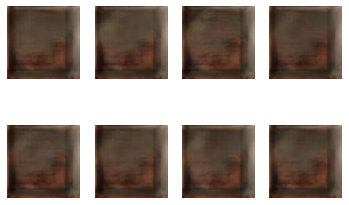

45001 [D loss: 1.323357, acc.: 60.94%, op_acc: 65.78%] [G loss: 1.403931]
45002 [D loss: 1.277116, acc.: 59.38%, op_acc: 68.44%] [G loss: 1.374400]
45003 [D loss: 1.217609, acc.: 75.00%, op_acc: 65.86%] [G loss: 1.380093]
45004 [D loss: 1.311605, acc.: 60.94%, op_acc: 67.15%] [G loss: 1.383713]
45005 [D loss: 1.306649, acc.: 60.94%, op_acc: 66.99%] [G loss: 1.379696]
45006 [D loss: 1.178801, acc.: 75.00%, op_acc: 64.14%] [G loss: 1.416357]
45007 [D loss: 1.299790, acc.: 60.94%, op_acc: 67.11%] [G loss: 1.362343]
45008 [D loss: 1.357115, acc.: 57.81%, op_acc: 66.09%] [G loss: 1.405010]
45009 [D loss: 1.189997, acc.: 71.88%, op_acc: 64.80%] [G loss: 1.414265]
45010 [D loss: 1.223520, acc.: 73.44%, op_acc: 67.93%] [G loss: 1.417200]
45011 [D loss: 1.193742, acc.: 68.75%, op_acc: 67.03%] [G loss: 1.395717]
45012 [D loss: 1.219269, acc.: 71.88%, op_acc: 65.90%] [G loss: 1.473880]
45013 [D loss: 1.252612, acc.: 65.62%, op_acc: 68.09%] [G loss: 1.443721]
45014 [D loss: 1.146334, acc.: 82.81%,

45113 [D loss: 1.450318, acc.: 60.94%, op_acc: 63.59%] [G loss: 1.168896]
45114 [D loss: 1.238411, acc.: 65.62%, op_acc: 66.60%] [G loss: 1.098588]
45115 [D loss: 1.256572, acc.: 64.06%, op_acc: 66.21%] [G loss: 1.085129]
45116 [D loss: 1.166439, acc.: 75.00%, op_acc: 68.13%] [G loss: 1.094646]
45117 [D loss: 1.203151, acc.: 75.00%, op_acc: 65.04%] [G loss: 1.082023]
45118 [D loss: 1.100943, acc.: 81.25%, op_acc: 66.91%] [G loss: 1.053936]
45119 [D loss: 1.129007, acc.: 76.56%, op_acc: 66.56%] [G loss: 1.116729]
45120 [D loss: 1.154297, acc.: 78.12%, op_acc: 65.55%] [G loss: 1.068813]
45121 [D loss: 0.982763, acc.: 89.06%, op_acc: 67.97%] [G loss: 1.077087]
45122 [D loss: 0.954569, acc.: 90.62%, op_acc: 67.03%] [G loss: 1.094990]
45123 [D loss: 1.083942, acc.: 79.69%, op_acc: 65.86%] [G loss: 1.085414]
45124 [D loss: 1.098596, acc.: 78.12%, op_acc: 66.60%] [G loss: 1.087997]
45125 [D loss: 0.996827, acc.: 85.94%, op_acc: 64.73%] [G loss: 1.109643]
45126 [D loss: 0.909609, acc.: 90.62%,

45225 [D loss: 0.800630, acc.: 90.62%, op_acc: 68.48%] [G loss: 0.974334]
45226 [D loss: 0.810415, acc.: 95.31%, op_acc: 66.60%] [G loss: 1.025318]
45227 [D loss: 0.847653, acc.: 93.75%, op_acc: 67.50%] [G loss: 1.007032]
45228 [D loss: 0.869318, acc.: 90.62%, op_acc: 65.98%] [G loss: 0.994701]
45229 [D loss: 0.764571, acc.: 95.31%, op_acc: 69.53%] [G loss: 1.005885]
45230 [D loss: 0.803567, acc.: 92.19%, op_acc: 67.77%] [G loss: 1.051670]
45231 [D loss: 0.773191, acc.: 98.44%, op_acc: 66.84%] [G loss: 1.070220]
45232 [D loss: 0.688149, acc.: 98.44%, op_acc: 69.06%] [G loss: 1.056616]
45233 [D loss: 0.845884, acc.: 89.06%, op_acc: 67.77%] [G loss: 1.104374]
45234 [D loss: 0.834902, acc.: 95.31%, op_acc: 68.32%] [G loss: 1.079400]
45235 [D loss: 0.856313, acc.: 85.94%, op_acc: 67.81%] [G loss: 1.104752]
45236 [D loss: 0.843955, acc.: 87.50%, op_acc: 69.80%] [G loss: 1.083449]
45237 [D loss: 0.757683, acc.: 95.31%, op_acc: 69.41%] [G loss: 1.094230]
45238 [D loss: 0.855238, acc.: 84.38%,

45337 [D loss: 0.804342, acc.: 95.31%, op_acc: 66.95%] [G loss: 1.002771]
45338 [D loss: 0.711387, acc.: 95.31%, op_acc: 68.40%] [G loss: 1.082147]
45339 [D loss: 0.678811, acc.: 98.44%, op_acc: 67.70%] [G loss: 1.020920]
45340 [D loss: 0.769749, acc.: 92.19%, op_acc: 68.01%] [G loss: 0.965152]
45341 [D loss: 0.675303, acc.: 98.44%, op_acc: 68.95%] [G loss: 1.075848]
45342 [D loss: 0.654291, acc.: 98.44%, op_acc: 67.97%] [G loss: 1.027321]
45343 [D loss: 0.644822, acc.: 100.00%, op_acc: 68.09%] [G loss: 1.121598]
45344 [D loss: 0.797123, acc.: 95.31%, op_acc: 67.27%] [G loss: 0.962221]
45345 [D loss: 0.647637, acc.: 100.00%, op_acc: 66.99%] [G loss: 1.107195]
45346 [D loss: 0.645222, acc.: 98.44%, op_acc: 69.69%] [G loss: 1.072204]
45347 [D loss: 0.675647, acc.: 98.44%, op_acc: 68.05%] [G loss: 1.088153]
45348 [D loss: 0.672571, acc.: 96.88%, op_acc: 67.93%] [G loss: 1.021787]
45349 [D loss: 0.700683, acc.: 95.31%, op_acc: 68.24%] [G loss: 1.029469]
45350 [D loss: 0.636366, acc.: 98.44

45449 [D loss: 1.415447, acc.: 68.75%, op_acc: 65.00%] [G loss: 1.998282]
45450 [D loss: 1.325848, acc.: 71.88%, op_acc: 65.43%] [G loss: 1.688748]
45451 [D loss: 1.202361, acc.: 78.12%, op_acc: 66.80%] [G loss: 1.698242]
45452 [D loss: 1.623052, acc.: 56.25%, op_acc: 64.41%] [G loss: 1.250965]
45453 [D loss: 1.176315, acc.: 75.00%, op_acc: 64.45%] [G loss: 1.275362]
45454 [D loss: 1.021994, acc.: 85.94%, op_acc: 67.11%] [G loss: 1.310271]
45455 [D loss: 1.382134, acc.: 71.88%, op_acc: 64.61%] [G loss: 1.308897]
45456 [D loss: 1.331836, acc.: 81.25%, op_acc: 64.14%] [G loss: 1.241752]
45457 [D loss: 1.424400, acc.: 67.19%, op_acc: 64.80%] [G loss: 1.253802]
45458 [D loss: 1.013131, acc.: 76.56%, op_acc: 66.48%] [G loss: 1.320531]
45459 [D loss: 1.346727, acc.: 79.69%, op_acc: 62.66%] [G loss: 1.195568]
45460 [D loss: 0.918993, acc.: 89.06%, op_acc: 65.94%] [G loss: 1.221062]
45461 [D loss: 0.960384, acc.: 89.06%, op_acc: 66.13%] [G loss: 1.245361]
45462 [D loss: 1.047594, acc.: 89.06%,

45560 [D loss: 0.830651, acc.: 89.06%, op_acc: 66.45%] [G loss: 1.158062]
45561 [D loss: 0.897636, acc.: 92.19%, op_acc: 65.98%] [G loss: 0.992252]
45562 [D loss: 0.921763, acc.: 87.50%, op_acc: 65.66%] [G loss: 1.000428]
45563 [D loss: 0.797582, acc.: 93.75%, op_acc: 67.19%] [G loss: 1.042717]
45564 [D loss: 0.815579, acc.: 90.62%, op_acc: 67.34%] [G loss: 0.938802]
45565 [D loss: 0.856190, acc.: 87.50%, op_acc: 68.71%] [G loss: 0.975798]
45566 [D loss: 0.741626, acc.: 93.75%, op_acc: 65.20%] [G loss: 1.040854]
45567 [D loss: 0.806488, acc.: 95.31%, op_acc: 67.07%] [G loss: 0.940129]
45568 [D loss: 0.802811, acc.: 93.75%, op_acc: 66.17%] [G loss: 0.972114]
45569 [D loss: 0.640616, acc.: 98.44%, op_acc: 67.77%] [G loss: 0.950403]
45570 [D loss: 0.678785, acc.: 96.88%, op_acc: 66.68%] [G loss: 0.917128]
45571 [D loss: 0.676551, acc.: 96.88%, op_acc: 68.05%] [G loss: 1.004529]
45572 [D loss: 0.743155, acc.: 95.31%, op_acc: 67.23%] [G loss: 0.939465]
45573 [D loss: 0.632928, acc.: 100.00%

45672 [D loss: 0.916898, acc.: 87.50%, op_acc: 68.20%] [G loss: 1.280485]
45673 [D loss: 1.099267, acc.: 75.00%, op_acc: 67.03%] [G loss: 1.662647]
45674 [D loss: 1.114533, acc.: 79.69%, op_acc: 65.51%] [G loss: 1.475868]
45675 [D loss: 2.095150, acc.: 42.19%, op_acc: 61.25%] [G loss: 1.280781]
45676 [D loss: 1.448051, acc.: 68.75%, op_acc: 64.92%] [G loss: 1.360360]
45677 [D loss: 1.118230, acc.: 76.56%, op_acc: 67.23%] [G loss: 1.589226]
45678 [D loss: 1.190974, acc.: 75.00%, op_acc: 66.64%] [G loss: 1.417367]
45679 [D loss: 1.282979, acc.: 60.94%, op_acc: 66.45%] [G loss: 1.706421]
45680 [D loss: 1.146992, acc.: 73.44%, op_acc: 66.37%] [G loss: 2.109217]
45681 [D loss: 1.375474, acc.: 64.06%, op_acc: 65.04%] [G loss: 2.140326]
45682 [D loss: 1.316129, acc.: 70.31%, op_acc: 64.49%] [G loss: 2.176694]
45683 [D loss: 1.133430, acc.: 78.12%, op_acc: 66.48%] [G loss: 2.219208]
45684 [D loss: 1.477333, acc.: 51.56%, op_acc: 66.87%] [G loss: 2.500926]
45685 [D loss: 1.526461, acc.: 45.31%,

45784 [D loss: 0.989839, acc.: 82.81%, op_acc: 65.82%] [G loss: 1.552784]
45785 [D loss: 1.092766, acc.: 75.00%, op_acc: 64.02%] [G loss: 1.510344]
45786 [D loss: 0.797354, acc.: 93.75%, op_acc: 68.67%] [G loss: 1.808513]
45787 [D loss: 1.074750, acc.: 68.75%, op_acc: 66.72%] [G loss: 1.831237]
45788 [D loss: 0.934106, acc.: 84.38%, op_acc: 65.55%] [G loss: 2.013522]
45789 [D loss: 1.302697, acc.: 65.62%, op_acc: 64.53%] [G loss: 1.546965]
45790 [D loss: 1.317759, acc.: 70.31%, op_acc: 61.76%] [G loss: 1.617328]
45791 [D loss: 1.280652, acc.: 64.06%, op_acc: 65.27%] [G loss: 1.881171]
45792 [D loss: 1.181388, acc.: 75.00%, op_acc: 64.96%] [G loss: 2.325247]
45793 [D loss: 0.993078, acc.: 85.94%, op_acc: 66.95%] [G loss: 1.847112]
45794 [D loss: 1.263389, acc.: 67.19%, op_acc: 66.48%] [G loss: 1.362311]
45795 [D loss: 1.061662, acc.: 78.12%, op_acc: 66.45%] [G loss: 1.582565]
45796 [D loss: 1.180004, acc.: 75.00%, op_acc: 65.47%] [G loss: 1.678952]
45797 [D loss: 1.368045, acc.: 65.62%,

45896 [D loss: 0.953798, acc.: 90.62%, op_acc: 67.30%] [G loss: 1.244322]
45897 [D loss: 0.976913, acc.: 87.50%, op_acc: 66.52%] [G loss: 1.276291]
45898 [D loss: 0.874714, acc.: 92.19%, op_acc: 66.05%] [G loss: 1.324976]
45899 [D loss: 1.013223, acc.: 82.81%, op_acc: 66.64%] [G loss: 1.176275]
45900 [D loss: 0.876545, acc.: 89.06%, op_acc: 67.34%] [G loss: 1.220466]
45901 [D loss: 0.864902, acc.: 90.62%, op_acc: 66.56%] [G loss: 1.244304]
45902 [D loss: 0.951501, acc.: 89.06%, op_acc: 65.98%] [G loss: 1.250206]
45903 [D loss: 0.846763, acc.: 93.75%, op_acc: 67.15%] [G loss: 1.194358]
45904 [D loss: 0.909868, acc.: 90.62%, op_acc: 66.80%] [G loss: 1.148609]
45905 [D loss: 0.887876, acc.: 90.62%, op_acc: 66.80%] [G loss: 1.138012]
45906 [D loss: 0.786501, acc.: 95.31%, op_acc: 66.48%] [G loss: 1.126961]
45907 [D loss: 0.797661, acc.: 90.62%, op_acc: 67.38%] [G loss: 1.023618]
45908 [D loss: 0.770337, acc.: 93.75%, op_acc: 67.54%] [G loss: 1.034567]
45909 [D loss: 0.734244, acc.: 95.31%,

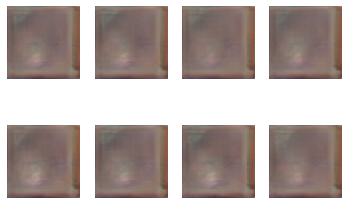

46001 [D loss: 0.898173, acc.: 90.62%, op_acc: 65.59%] [G loss: 1.110866]
46002 [D loss: 0.832931, acc.: 93.75%, op_acc: 66.41%] [G loss: 1.021582]
46003 [D loss: 0.917736, acc.: 92.19%, op_acc: 67.30%] [G loss: 0.968539]
46004 [D loss: 0.850950, acc.: 95.31%, op_acc: 65.94%] [G loss: 1.084568]
46005 [D loss: 0.789888, acc.: 95.31%, op_acc: 66.87%] [G loss: 0.989481]
46006 [D loss: 0.726973, acc.: 98.44%, op_acc: 67.58%] [G loss: 1.012921]
46007 [D loss: 0.866964, acc.: 90.62%, op_acc: 67.66%] [G loss: 0.989916]
46008 [D loss: 0.771654, acc.: 90.62%, op_acc: 68.52%] [G loss: 0.970182]
46009 [D loss: 0.700845, acc.: 98.44%, op_acc: 67.77%] [G loss: 0.979216]
46010 [D loss: 0.728285, acc.: 98.44%, op_acc: 66.17%] [G loss: 1.054570]
46011 [D loss: 0.697913, acc.: 98.44%, op_acc: 66.21%] [G loss: 0.986596]
46012 [D loss: 0.724647, acc.: 96.88%, op_acc: 66.02%] [G loss: 1.076836]
46013 [D loss: 0.729719, acc.: 96.88%, op_acc: 65.86%] [G loss: 0.988078]
46014 [D loss: 0.821205, acc.: 92.19%,

46113 [D loss: 0.766986, acc.: 93.75%, op_acc: 68.16%] [G loss: 1.063163]
46114 [D loss: 0.807638, acc.: 90.62%, op_acc: 64.92%] [G loss: 1.107755]
46115 [D loss: 0.669716, acc.: 95.31%, op_acc: 66.02%] [G loss: 1.176906]
46116 [D loss: 0.759612, acc.: 96.88%, op_acc: 66.02%] [G loss: 0.995094]
46117 [D loss: 0.664887, acc.: 98.44%, op_acc: 66.60%] [G loss: 1.139815]
46118 [D loss: 0.672603, acc.: 93.75%, op_acc: 67.77%] [G loss: 1.280227]
46119 [D loss: 0.736612, acc.: 95.31%, op_acc: 66.29%] [G loss: 1.113989]
46120 [D loss: 0.725068, acc.: 96.88%, op_acc: 65.62%] [G loss: 1.232344]
46121 [D loss: 0.670478, acc.: 98.44%, op_acc: 66.09%] [G loss: 1.426799]
46122 [D loss: 0.674726, acc.: 96.88%, op_acc: 67.85%] [G loss: 1.706679]
46123 [D loss: 0.987078, acc.: 85.94%, op_acc: 65.31%] [G loss: 1.511688]
46124 [D loss: 0.779039, acc.: 95.31%, op_acc: 66.64%] [G loss: 2.493940]
46125 [D loss: 0.826050, acc.: 89.06%, op_acc: 67.03%] [G loss: 2.357458]
46126 [D loss: 1.037655, acc.: 85.94%,

46225 [D loss: 0.713659, acc.: 96.88%, op_acc: 67.42%] [G loss: 1.023135]
46226 [D loss: 0.607178, acc.: 100.00%, op_acc: 66.99%] [G loss: 1.040865]
46227 [D loss: 0.715922, acc.: 96.88%, op_acc: 66.80%] [G loss: 1.022710]
46228 [D loss: 0.698433, acc.: 96.88%, op_acc: 66.80%] [G loss: 0.982941]
46229 [D loss: 0.630963, acc.: 100.00%, op_acc: 68.36%] [G loss: 0.953429]
46230 [D loss: 0.718894, acc.: 96.88%, op_acc: 66.76%] [G loss: 1.039611]
46231 [D loss: 0.677889, acc.: 96.88%, op_acc: 67.07%] [G loss: 0.988795]
46232 [D loss: 0.594837, acc.: 100.00%, op_acc: 68.20%] [G loss: 1.074679]
46233 [D loss: 0.695139, acc.: 96.88%, op_acc: 66.33%] [G loss: 0.996300]
46234 [D loss: 0.667839, acc.: 96.88%, op_acc: 67.66%] [G loss: 1.000178]
46235 [D loss: 0.657160, acc.: 96.88%, op_acc: 67.23%] [G loss: 1.079913]
46236 [D loss: 0.615526, acc.: 98.44%, op_acc: 67.19%] [G loss: 1.076821]
46237 [D loss: 0.651070, acc.: 98.44%, op_acc: 66.76%] [G loss: 1.097260]
46238 [D loss: 0.681632, acc.: 93.7

46336 [D loss: 0.912746, acc.: 84.38%, op_acc: 65.08%] [G loss: 1.018657]
46337 [D loss: 1.141981, acc.: 78.12%, op_acc: 66.21%] [G loss: 1.005620]
46338 [D loss: 0.797944, acc.: 93.75%, op_acc: 67.97%] [G loss: 0.962069]
46339 [D loss: 0.782940, acc.: 92.19%, op_acc: 67.81%] [G loss: 1.004443]
46340 [D loss: 0.762382, acc.: 93.75%, op_acc: 67.19%] [G loss: 1.023567]
46341 [D loss: 0.898341, acc.: 89.06%, op_acc: 66.52%] [G loss: 0.983963]
46342 [D loss: 0.736873, acc.: 93.75%, op_acc: 67.38%] [G loss: 0.982413]
46343 [D loss: 0.761732, acc.: 96.88%, op_acc: 67.54%] [G loss: 0.984293]
46344 [D loss: 0.661011, acc.: 100.00%, op_acc: 67.15%] [G loss: 1.008062]
46345 [D loss: 0.666630, acc.: 96.88%, op_acc: 69.61%] [G loss: 0.968460]
46346 [D loss: 0.674839, acc.: 96.88%, op_acc: 68.01%] [G loss: 1.000602]
46347 [D loss: 0.740958, acc.: 93.75%, op_acc: 68.87%] [G loss: 0.976957]
46348 [D loss: 0.673137, acc.: 100.00%, op_acc: 67.27%] [G loss: 1.022821]
46349 [D loss: 0.736622, acc.: 93.75

46448 [D loss: 0.723572, acc.: 93.75%, op_acc: 66.37%] [G loss: 0.952793]
46449 [D loss: 0.665723, acc.: 95.31%, op_acc: 67.42%] [G loss: 0.970569]
46450 [D loss: 0.688413, acc.: 96.88%, op_acc: 69.14%] [G loss: 0.984152]
46451 [D loss: 0.691478, acc.: 96.88%, op_acc: 66.25%] [G loss: 1.004189]
46452 [D loss: 0.674563, acc.: 96.88%, op_acc: 68.13%] [G loss: 0.986289]
46453 [D loss: 0.639229, acc.: 98.44%, op_acc: 68.28%] [G loss: 0.974286]
46454 [D loss: 0.621947, acc.: 98.44%, op_acc: 67.07%] [G loss: 1.009087]
46455 [D loss: 0.648104, acc.: 96.88%, op_acc: 67.19%] [G loss: 0.980721]
46456 [D loss: 0.651999, acc.: 98.44%, op_acc: 66.68%] [G loss: 0.976494]
46457 [D loss: 0.645051, acc.: 98.44%, op_acc: 66.37%] [G loss: 0.935189]
46458 [D loss: 0.749098, acc.: 92.19%, op_acc: 64.96%] [G loss: 1.030185]
46459 [D loss: 0.772850, acc.: 93.75%, op_acc: 67.54%] [G loss: 0.998187]
46460 [D loss: 0.738245, acc.: 92.19%, op_acc: 66.84%] [G loss: 0.971108]
46461 [D loss: 0.753549, acc.: 92.19%,

46560 [D loss: 0.997064, acc.: 87.50%, op_acc: 66.02%] [G loss: 1.306952]
46561 [D loss: 1.151121, acc.: 82.81%, op_acc: 65.31%] [G loss: 1.237527]
46562 [D loss: 0.989991, acc.: 89.06%, op_acc: 66.56%] [G loss: 1.180291]
46563 [D loss: 1.093647, acc.: 79.69%, op_acc: 65.82%] [G loss: 1.196329]
46564 [D loss: 1.067482, acc.: 81.25%, op_acc: 68.12%] [G loss: 1.176395]
46565 [D loss: 1.233451, acc.: 78.12%, op_acc: 65.78%] [G loss: 1.118754]
46566 [D loss: 0.971835, acc.: 90.62%, op_acc: 67.54%] [G loss: 1.156638]
46567 [D loss: 0.943828, acc.: 87.50%, op_acc: 64.57%] [G loss: 1.161321]
46568 [D loss: 0.961853, acc.: 87.50%, op_acc: 66.80%] [G loss: 1.227864]
46569 [D loss: 1.101734, acc.: 84.38%, op_acc: 63.79%] [G loss: 1.318905]
46570 [D loss: 1.026417, acc.: 84.38%, op_acc: 65.43%] [G loss: 1.284070]
46571 [D loss: 0.888495, acc.: 85.94%, op_acc: 67.77%] [G loss: 1.227645]
46572 [D loss: 0.971694, acc.: 89.06%, op_acc: 67.58%] [G loss: 1.325639]
46573 [D loss: 0.900850, acc.: 89.06%,

46672 [D loss: 1.054877, acc.: 89.06%, op_acc: 64.30%] [G loss: 1.079894]
46673 [D loss: 0.848543, acc.: 92.19%, op_acc: 66.76%] [G loss: 1.097071]
46674 [D loss: 0.993982, acc.: 85.94%, op_acc: 65.66%] [G loss: 1.128127]
46675 [D loss: 0.776673, acc.: 92.19%, op_acc: 67.97%] [G loss: 1.091423]
46676 [D loss: 0.929749, acc.: 87.50%, op_acc: 66.56%] [G loss: 1.031220]
46677 [D loss: 1.023168, acc.: 82.81%, op_acc: 68.52%] [G loss: 1.011317]
46678 [D loss: 1.075185, acc.: 92.19%, op_acc: 65.74%] [G loss: 1.011744]
46679 [D loss: 0.772769, acc.: 95.31%, op_acc: 64.84%] [G loss: 1.163093]
46680 [D loss: 0.894824, acc.: 90.62%, op_acc: 68.13%] [G loss: 1.138633]
46681 [D loss: 0.934743, acc.: 90.62%, op_acc: 67.42%] [G loss: 1.071858]
46682 [D loss: 0.866477, acc.: 95.31%, op_acc: 63.09%] [G loss: 1.170225]
46683 [D loss: 0.842077, acc.: 92.19%, op_acc: 64.34%] [G loss: 1.139745]
46684 [D loss: 0.833498, acc.: 95.31%, op_acc: 65.78%] [G loss: 1.101387]
46685 [D loss: 0.987470, acc.: 90.62%,

46784 [D loss: 0.754103, acc.: 95.31%, op_acc: 67.85%] [G loss: 1.067725]
46785 [D loss: 0.653497, acc.: 100.00%, op_acc: 68.09%] [G loss: 1.141389]
46786 [D loss: 0.692780, acc.: 98.44%, op_acc: 68.28%] [G loss: 1.158953]
46787 [D loss: 0.859795, acc.: 90.62%, op_acc: 67.46%] [G loss: 1.042091]
46788 [D loss: 0.782616, acc.: 95.31%, op_acc: 68.05%] [G loss: 1.056455]
46789 [D loss: 0.694400, acc.: 96.88%, op_acc: 66.21%] [G loss: 1.159891]
46790 [D loss: 0.737165, acc.: 93.75%, op_acc: 68.36%] [G loss: 1.156381]
46791 [D loss: 0.853397, acc.: 93.75%, op_acc: 65.20%] [G loss: 1.212266]
46792 [D loss: 0.745048, acc.: 95.31%, op_acc: 67.54%] [G loss: 1.300524]
46793 [D loss: 0.707087, acc.: 98.44%, op_acc: 66.05%] [G loss: 1.286091]
46794 [D loss: 0.822696, acc.: 90.62%, op_acc: 68.01%] [G loss: 1.165209]
46795 [D loss: 0.828594, acc.: 89.06%, op_acc: 67.77%] [G loss: 1.158859]
46796 [D loss: 0.775944, acc.: 95.31%, op_acc: 68.24%] [G loss: 1.304132]
46797 [D loss: 0.693349, acc.: 96.88%

46896 [D loss: 0.691099, acc.: 96.88%, op_acc: 68.16%] [G loss: 0.959480]
46897 [D loss: 0.650810, acc.: 96.88%, op_acc: 66.21%] [G loss: 0.946063]
46898 [D loss: 0.620154, acc.: 98.44%, op_acc: 68.36%] [G loss: 0.947678]
46899 [D loss: 0.680286, acc.: 96.88%, op_acc: 65.39%] [G loss: 0.964756]
46900 [D loss: 0.662700, acc.: 96.88%, op_acc: 67.34%] [G loss: 0.980922]
46901 [D loss: 0.673234, acc.: 96.88%, op_acc: 65.98%] [G loss: 0.996058]
46902 [D loss: 0.616971, acc.: 98.44%, op_acc: 68.12%] [G loss: 0.993854]
46903 [D loss: 0.661632, acc.: 96.88%, op_acc: 67.50%] [G loss: 0.998964]
46904 [D loss: 0.633499, acc.: 98.44%, op_acc: 68.95%] [G loss: 0.947884]
46905 [D loss: 0.639430, acc.: 98.44%, op_acc: 67.54%] [G loss: 0.932584]
46906 [D loss: 0.608405, acc.: 100.00%, op_acc: 67.11%] [G loss: 0.953744]
46907 [D loss: 0.667517, acc.: 95.31%, op_acc: 67.46%] [G loss: 0.952995]
46908 [D loss: 0.624191, acc.: 100.00%, op_acc: 67.03%] [G loss: 0.989980]
46909 [D loss: 0.640810, acc.: 96.88

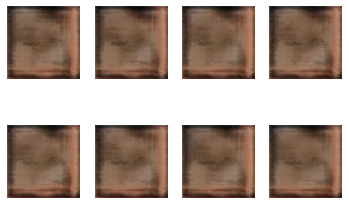

47001 [D loss: 0.799843, acc.: 93.75%, op_acc: 68.75%] [G loss: 1.239473]
47002 [D loss: 0.904206, acc.: 90.62%, op_acc: 66.09%] [G loss: 1.166396]
47003 [D loss: 0.738804, acc.: 96.88%, op_acc: 67.19%] [G loss: 1.203818]
47004 [D loss: 0.762534, acc.: 93.75%, op_acc: 68.48%] [G loss: 1.207295]
47005 [D loss: 0.707520, acc.: 96.88%, op_acc: 69.34%] [G loss: 1.237413]
47006 [D loss: 0.822823, acc.: 93.75%, op_acc: 64.65%] [G loss: 1.310601]
47007 [D loss: 0.810027, acc.: 93.75%, op_acc: 65.74%] [G loss: 1.248379]
47008 [D loss: 0.801081, acc.: 93.75%, op_acc: 68.24%] [G loss: 1.230666]
47009 [D loss: 0.836638, acc.: 90.62%, op_acc: 64.45%] [G loss: 1.279309]
47010 [D loss: 0.713058, acc.: 93.75%, op_acc: 68.12%] [G loss: 1.212085]
47011 [D loss: 0.841415, acc.: 92.19%, op_acc: 67.03%] [G loss: 1.189466]
47012 [D loss: 0.728723, acc.: 92.19%, op_acc: 66.80%] [G loss: 1.280527]
47013 [D loss: 0.744518, acc.: 93.75%, op_acc: 68.24%] [G loss: 1.403591]
47014 [D loss: 0.965372, acc.: 85.94%,

47113 [D loss: 0.883543, acc.: 92.19%, op_acc: 66.48%] [G loss: 1.044314]
47114 [D loss: 0.675885, acc.: 96.88%, op_acc: 68.91%] [G loss: 1.219802]
47115 [D loss: 0.935285, acc.: 92.19%, op_acc: 66.41%] [G loss: 1.072309]
47116 [D loss: 0.733822, acc.: 96.88%, op_acc: 66.09%] [G loss: 1.122775]
47117 [D loss: 0.838199, acc.: 93.75%, op_acc: 66.99%] [G loss: 1.099379]
47118 [D loss: 0.811319, acc.: 93.75%, op_acc: 67.42%] [G loss: 0.997197]
47119 [D loss: 0.860490, acc.: 90.62%, op_acc: 67.27%] [G loss: 1.294548]
47120 [D loss: 0.719896, acc.: 93.75%, op_acc: 68.44%] [G loss: 1.158122]
47121 [D loss: 0.856191, acc.: 89.06%, op_acc: 67.38%] [G loss: 1.051504]
47122 [D loss: 0.791196, acc.: 93.75%, op_acc: 67.73%] [G loss: 1.161813]
47123 [D loss: 0.805231, acc.: 89.06%, op_acc: 67.73%] [G loss: 1.186608]
47124 [D loss: 0.863067, acc.: 92.19%, op_acc: 68.16%] [G loss: 1.255949]
47125 [D loss: 0.801313, acc.: 92.19%, op_acc: 66.95%] [G loss: 1.173294]
47126 [D loss: 0.904746, acc.: 92.19%,

47225 [D loss: 1.324630, acc.: 57.81%, op_acc: 67.85%] [G loss: 1.470028]
47226 [D loss: 1.160734, acc.: 75.00%, op_acc: 66.13%] [G loss: 1.628804]
47227 [D loss: 0.999698, acc.: 82.81%, op_acc: 67.42%] [G loss: 1.731132]
47228 [D loss: 1.037016, acc.: 87.50%, op_acc: 66.41%] [G loss: 1.723347]
47229 [D loss: 1.209129, acc.: 71.88%, op_acc: 66.87%] [G loss: 1.691435]
47230 [D loss: 1.157842, acc.: 82.81%, op_acc: 65.23%] [G loss: 1.887529]
47231 [D loss: 0.909706, acc.: 95.31%, op_acc: 66.52%] [G loss: 1.722297]
47232 [D loss: 0.893939, acc.: 92.19%, op_acc: 66.95%] [G loss: 1.741541]
47233 [D loss: 0.895855, acc.: 90.62%, op_acc: 65.43%] [G loss: 1.764963]
47234 [D loss: 0.955998, acc.: 87.50%, op_acc: 66.95%] [G loss: 1.741399]
47235 [D loss: 1.197884, acc.: 73.44%, op_acc: 65.74%] [G loss: 1.588573]
47236 [D loss: 0.919043, acc.: 89.06%, op_acc: 65.55%] [G loss: 1.562776]
47237 [D loss: 0.852134, acc.: 89.06%, op_acc: 67.27%] [G loss: 1.561149]
47238 [D loss: 0.795796, acc.: 95.31%,

KeyboardInterrupt: 

In [8]:
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size, n_test_images);

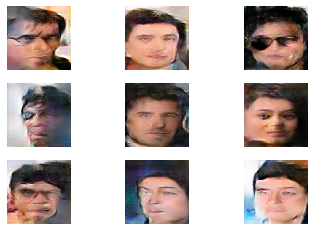

In [15]:
# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

model = load_model('cgan/cgan_generator_3attr_36epochs_50ktrainig_noembeddgin.h5',
                           custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D})
latent_points, labels = generate_latent_points(latent_dim, 100, n_attr)
# specify labels
labels = np.zeros((latent_dim, n_attr))
#labels = load_groundtruth_labels(100, ind_attributes, dict_attributes)
labels[:, 0] = 1
# generate images
X = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
save_plot(X, 3)

In [ ]:
# define the standalone discriminator model
# A best practice involves using an embedding
# layer followed by a fully connected layer with a linear activation that scales the embedding to
# the size of the image before concatenating it in the model as an additional channel or feature
# map. A version of this recommendation was described in the 2015 paper titled Deep Generative
# Image Models using a Laplacian Pyramid of Adversarial Networks.
    
def define_discriminator(filters=64, kernel_size=3, in_shape=(64,64,3)):
    # input layer:
    in_image = Input(shape=in_shape)

    # 64 x 64 x FILTERS
    fe = SNConv2D(filters=filters, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(in_image) ##in_image
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 32 x 32 x FILTERS
    fe = SNConv2D(filters=filters * 2, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 16 x 16 x FILTERS
    fe = SNConv2D(filters=filters * 4, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 8 x 8 x FILTERS
    fe = SNConv2D(filters=filters * 8, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    
    # Current size: 4 x 4 x FILTERS 
    fe = GlobalAveragePooling2D()(fe)
    
    # output about fake/real image:
    out = Dense(1)(fe)
    
    # define model
    model = Model(in_image, out)
  
    return model

def define_classifier(filters=64, kernel_size=3, in_shape=(64,64,3)):
    # input layer:
    in_image = Input(shape=in_shape)

    # 64 x 64 x FILTERS
    fe = SNConv2D(filters=filters, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(in_image) ##in_image
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 32 x 32 x FILTERS
    fe = SNConv2D(filters=filters * 2, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 16 x 16 x FILTERS
    fe = SNConv2D(filters=filters * 4, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 8 x 8 x FILTERS
    fe = SNConv2D(filters=filters * 8, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    
    # Current size: 4 x 4 x FILTERS 
    fe = GlobalAveragePooling2D()(fe)
    
    # output about fake/real image:
    out = Dense(n_attr, activation='sigmoid')(fe)
    
    # define model
    model = Model(in_image, out)
  
    return model


# define the standalone generator model
def define_generator(latent_dim, n_attr, filters=64):

    in_label = Input(shape=(latent_dim + n_attr,)) 
    n_nodes = 4 * 4 * filters * 8
    gen = Dense(n_nodes)(in_label)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, filters * 8))(gen)
    gen = BatchNormalization()(gen)
    
    # 4x4 -> 8x8
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters*4, kernel_size=4, strides=(1,1), padding='same', spectral_normalization=True)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 8x8 -> 16x16
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters*2, kernel_size=4, strides=(1,1), padding='same', spectral_normalization=True)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 16x16 -> 32x32
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters, kernel_size=4, strides=(1,1), padding='same', spectral_normalization=True)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 32x32 -> 64x64
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters // 2, kernel_size=4, strides=(1,1), padding='same', spectral_normalization=True)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # output
    out_layer = SNConv2D(filters=3, kernel_size=4, activation='tanh', padding='same', spectral_normalization=True)(gen)
    # define model
    model = Model(in_label, out_layer)
    return model


